In [1]:
# ============================================================
# LINGUISTIC ANALYSIS OF SWAMI VIVEKANANDA'S COMPLETE WORKS
# A Computational Study of Private vs Public Discourse (1889-1902)
# ============================================================

"""
PROJECT OVERVIEW:
Comprehensive linguistic analysis of Swami Vivekananda's Complete Works.

RESEARCH FOCUS:
- Private (Letters) vs Public (Lectures/Treatises/Writings) discourse patterns
- Temporal evolution of philosophical vocabulary (1889-1902)
- Genre-specific linguistic fingerprints
- Adaptation of Sanskrit terminology for Western audiences

CORPUS: 975 English documents, ~1M words, spanning 1889-1902
"""

print("="*80)
print("SWAMI VIVEKANANDA COMPLETE WORKS - LINGUISTIC ANALYSIS")
print("="*80)

# ============================================================
# SECTION 1: IMPORTS & SETUP
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk import word_tokenize, pos_tag, FreqDist, bigrams, trigrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download NLTK resources
print("\nDownloading NLTK resources...")
resources = ['punkt', 'punkt_tab', 'averaged_perceptron_tagger',
             'averaged_perceptron_tagger_eng', 'stopwords', 'wordnet', 'omw-1.4']
for resource in resources:
    nltk.download(resource, quiet=True)
print("✓ NLTK ready")

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✓ Setup complete\n")

# ============================================================
# SECTION 2: LOAD & INSPECT DATA
# ============================================================

print("="*80)
print("LOADING CORPUS")
print("="*80)

df = pd.read_csv('functional_dataset_deduped.csv')

print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df[['Name', 'genre', 'word_count_clean', 'Language']].head())

# Data quality check
print(f"\n" + "="*80)
print("DATA QUALITY CHECK")
print("="*80)
print(f"Total documents: {len(df)}")
print(f"Documents with plaintext: {df['plaintext_clean'].notna().sum()}")
print(f"Documents with 0 words: {(df['word_count_clean'] == 0).sum()}")
print(f"Language distribution:")
print(df['Language'].value_counts())

# Genre distribution
print(f"\nGenre distribution:")
print(df['genre'].value_counts())

# ============================================================
# SECTION 3: DATA CLEANING & CLASSIFICATION
# ============================================================

print("\n" + "="*80)
print("DATA CLEANING & CLASSIFICATION")
print("="*80)

# Remove any null plaintext
df_clean = df[df['plaintext_clean'].notna()].copy()
print(f"\nAfter removing null plaintext: {len(df_clean)} documents")

# Classify as Private vs Public
df_clean['discourse_type'] = df_clean['genre'].apply(
    lambda x: 'Private' if x == 'Letters' else 'Public'
)

print(f"\nDiscourse type distribution:")
print(df_clean['discourse_type'].value_counts())

private_docs = df_clean[df_clean['discourse_type'] == 'Private']
public_docs = df_clean[df_clean['discourse_type'] == 'Public']

print(f"\nPrivate (Letters): {len(private_docs)} docs, {private_docs['word_count_clean'].sum():,} words")
print(f"Public (All else): {len(public_docs)} docs, {public_docs['word_count_clean'].sum():,} words")

# ============================================================
# SECTION 4: PARSE TEMPORAL DATA
# ============================================================

print("\n" + "="*80)
print("PARSING TEMPORAL DATA")
print("="*80)

df_clean['year'] = None
df_clean['month'] = None
df_clean['has_date'] = False

for idx, row in df_clean.iterrows():
    if pd.notna(row['Date']):
        date_str = str(row['Date'])
        if '/' in date_str:
            parts = date_str.split('/')
            try:
                year = int(parts[0])
                if 1880 <= year <= 1910:
                    df_clean.at[idx, 'year'] = year
                    df_clean.at[idx, 'has_date'] = True
                    if len(parts) >= 2:
                        try:
                            df_clean.at[idx, 'month'] = int(parts[1])
                        except:
                            pass
            except:
                pass

dated_df = df_clean[df_clean['has_date'] == True]
print(f"\nDocuments with dates: {len(dated_df)}/{len(df_clean)} ({len(dated_df)/len(df_clean)*100:.1f}%)")
print(f"Year range: {dated_df['year'].min():.0f} - {dated_df['year'].max():.0f}")

print(f"\nDocuments per year:")
year_counts = dated_df['year'].value_counts().sort_index()
for year, count in year_counts.items():
    print(f"  {int(year)}: {count:3d} docs")

# ============================================================
# SECTION 5: TOKENIZATION & NLP PREPROCESSING
# ============================================================

print("\n" + "="*80)
print("TOKENIZATION & NLP PREPROCESSING")
print("="*80)

# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Storage
doc_data = []
all_tokens = []
all_tokens_no_stop = []
all_pos_tags = []

print("\nProcessing documents...")

for i, (idx, row) in enumerate(df_clean.iterrows()):
    if i % 100 == 0:
        print(f"  {i}/{len(df_clean)} documents processed...")

    if pd.notna(row['plaintext_clean']) and row['word_count_clean'] > 0:
        text = row['plaintext_clean']

        # Tokenize
        tokens = word_tokenize(text.lower())
        tokens_alpha = [t for t in tokens if t.isalpha() and len(t) > 1]

        # POS tagging
        pos_tags = pos_tag(tokens_alpha)

        # Remove stopwords
        tokens_no_stop = [t for t in tokens_alpha if t not in stop_words]

        # Stem and lemmatize
        stems = [stemmer.stem(t) for t in tokens_no_stop]
        lemmas = [lemmatizer.lemmatize(t) for t in tokens_no_stop]

        # Store
        doc_data.append({
            'Index': row['Index'],
            'Name': row['Name'],
            'genre': row['genre'],
            'discourse_type': row['discourse_type'],
            'volume': row['volume'],
            'year': row['year'],
            'has_date': row['has_date'],
            'tokens': tokens_alpha,
            'tokens_no_stop': tokens_no_stop,
            'pos_tags': pos_tags,
            'stems': stems,
            'lemmas': lemmas,
            'token_count': len(tokens_alpha),
            'unique_tokens': len(set(tokens_alpha))
        })

        all_tokens.extend(tokens_alpha)
        all_tokens_no_stop.extend(tokens_no_stop)
        all_pos_tags.extend(pos_tags)

print(f"\n✓ Preprocessing complete!")
print(f"  Total tokens: {len(all_tokens):,}")
print(f"  Unique tokens: {len(set(all_tokens)):,}")
print(f"  Tokens (no stopwords): {len(all_tokens_no_stop):,}")
print(f"  Unique (no stopwords): {len(set(all_tokens_no_stop)):,}")

# ============================================================
# SECTION 6: BASIC FREQUENCY ANALYSIS
# ============================================================

print("\n" + "="*80)
print("BASIC FREQUENCY ANALYSIS")
print("="*80)

freq_all = FreqDist(all_tokens)
freq_no_stop = FreqDist(all_tokens_no_stop)

print(f"\nTop 20 words (with stopwords):")
for word, count in freq_all.most_common(20):
    print(f"  {word:15s}: {count:6,} ({count/len(all_tokens)*100:.2f}%)")

print(f"\nTop 20 content words (no stopwords):")
for word, count in freq_no_stop.most_common(20):
    print(f"  {word:15s}: {count:6,} ({count/len(all_tokens_no_stop)*100:.2f}%)")

# ============================================================
# SECTION 7: PRIVATE vs PUBLIC ANALYSIS
# ============================================================

print("\n" + "="*80)
print("PRIVATE vs PUBLIC DISCOURSE ANALYSIS")
print("="*80)

# Separate tokens by discourse type
private_tokens = []
public_tokens = []

for doc in doc_data:
    if doc['discourse_type'] == 'Private':
        private_tokens.extend(doc['tokens_no_stop'])
    else:
        public_tokens.extend(doc['tokens_no_stop'])

print(f"\nPrivate tokens: {len(private_tokens):,}")
print(f"Public tokens: {len(public_tokens):,}")

# Frequency distributions
private_freq = FreqDist(private_tokens)
public_freq = FreqDist(public_tokens)

# Key philosophical terms comparison
key_terms = ['god', 'soul', 'vedanta', 'brahman', 'atman', 'maya', 'karma',
             'self', 'truth', 'love', 'one', 'man', 'world', 'mind', 'religion']

print(f"\n{'Term':<12} {'Private':<10} {'Priv/1k':<9} {'Public':<10} {'Pub/1k':<9} {'Ratio':<8}")
print("-"*75)

comparison_data = []
for term in key_terms:
    priv_count = private_freq[term]
    pub_count = public_freq[term]

    priv_per_k = (priv_count / len(private_tokens) * 1000) if len(private_tokens) > 0 else 0
    pub_per_k = (pub_count / len(public_tokens) * 1000) if len(public_tokens) > 0 else 0

    ratio = pub_per_k / priv_per_k if priv_per_k > 0 else 0

    print(f"{term:<12} {priv_count:<10,} {priv_per_k:<9.2f} {pub_count:<10,} {pub_per_k:<9.2f} {ratio:<8.2f}x")

    comparison_data.append({
        'term': term,
        'private_count': priv_count,
        'private_per_1k': priv_per_k,
        'public_count': pub_count,
        'public_per_1k': pub_per_k,
        'public_private_ratio': ratio
    })

# ============================================================
# SECTION 8: TEMPORAL ANALYSIS
# ============================================================

print("\n" + "="*80)
print("TEMPORAL ANALYSIS")
print("="*80)

# Year-wise breakdown
private_by_year = defaultdict(list)
public_by_year = defaultdict(list)

for doc in doc_data:
    if doc['has_date']:
        year = doc['year']
        if doc['discourse_type'] == 'Private':
            private_by_year[year].extend(doc['tokens_no_stop'])
        else:
            public_by_year[year].extend(doc['tokens_no_stop'])

print(f"\n{'Year':<6} {'Private':<10} {'Public':<10} {'%Private':<10} {'%Public':<10}")
print("-"*50)

years_data = []
for year in sorted(set(list(private_by_year.keys()) + list(public_by_year.keys()))):
    priv_count = len(private_by_year[year])
    pub_count = len(public_by_year[year])
    total = priv_count + pub_count

    if total > 0:
        priv_pct = priv_count / total * 100
        pub_pct = pub_count / total * 100
        print(f"{int(year):<6} {priv_count:<10,} {pub_count:<10,} {priv_pct:<10.1f} {pub_pct:<10.1f}")

        years_data.append({
            'year': year,
            'private': priv_count,
            'public': pub_count,
            'priv_pct': priv_pct,
            'pub_pct': pub_pct
        })

# Calculate philosophical term usage by year
print(f"\nPhilosophical terms by year (per 1000 words):")
print(f"\n{'Year':<6} {'Type':<8} {'God':<8} {'Soul':<8} {'Vedanta':<8} {'Brahman':<8} {'Atman':<8}")
print("-"*60)

temporal_phil_data = []
for year in sorted(set(list(private_by_year.keys()) + list(public_by_year.keys()))):
    if year >= 1893:  # Focus on substantive years
        # Private
        if len(private_by_year[year]) > 0:
            print(f"{int(year):<6} {'Priv':<8} ", end="")
            for term in ['god', 'soul', 'vedanta', 'brahman', 'atman']:
                count = sum(1 for t in private_by_year[year] if t == term)
                per_k = count / len(private_by_year[year]) * 1000
                print(f"{per_k:<8.2f} ", end="")
            print()

        # Public
        if len(public_by_year[year]) > 0:
            print(f"{int(year):<6} {'Pub':<8} ", end="")
            for term in ['god', 'soul', 'vedanta', 'brahman', 'atman']:
                count = sum(1 for t in public_by_year[year] if t == term)
                per_k = count / len(public_by_year[year]) * 1000
                print(f"{per_k:<8.2f} ", end="")
            print()
        print()

print("\n" + "="*80)
print("PREPROCESSING COMPLETE - READY FOR VISUALIZATION")
print("="*80)
print("\nNext: Run visualization cells to reproduce key findings")

SWAMI VIVEKANANDA COMPLETE WORKS - LINGUISTIC ANALYSIS

✓ NLTK ready
✓ Setup complete

LOADING CORPUS

Dataset shape: (961, 26)

Columns: ['Index', 'volume', 'Name', 'Category', 'Type', 'Date', 'Place', 'Source', 'Audience', 'Language', 'section', 'genre', 'href', 'full_url', 'filename', 'has_html', 'has_date', 'has_place', 'has_audience', 'html_content', 'html_length', 'plaintext_clean', 'word_count_clean', 'discourse_type', 'year', 'month']

First few rows:
                                    Name     genre  word_count_clean Language
0                    Response to Welcome  Lectures               476  English
1                        Why We Disagree  Lectures               385  English
2                      Paper on Hinduism  Lectures              4826  English
3  Religion not the Crying Need of India  Lectures               186  English
4   Buddhism, the Fulfilment of Hinduism  Lectures               839  English

DATA QUALITY CHECK
Total documents: 961
Documents with plaintext: 9

CREATING VISUALIZATIONS

✓ Saved: swamiji_key_findings.png


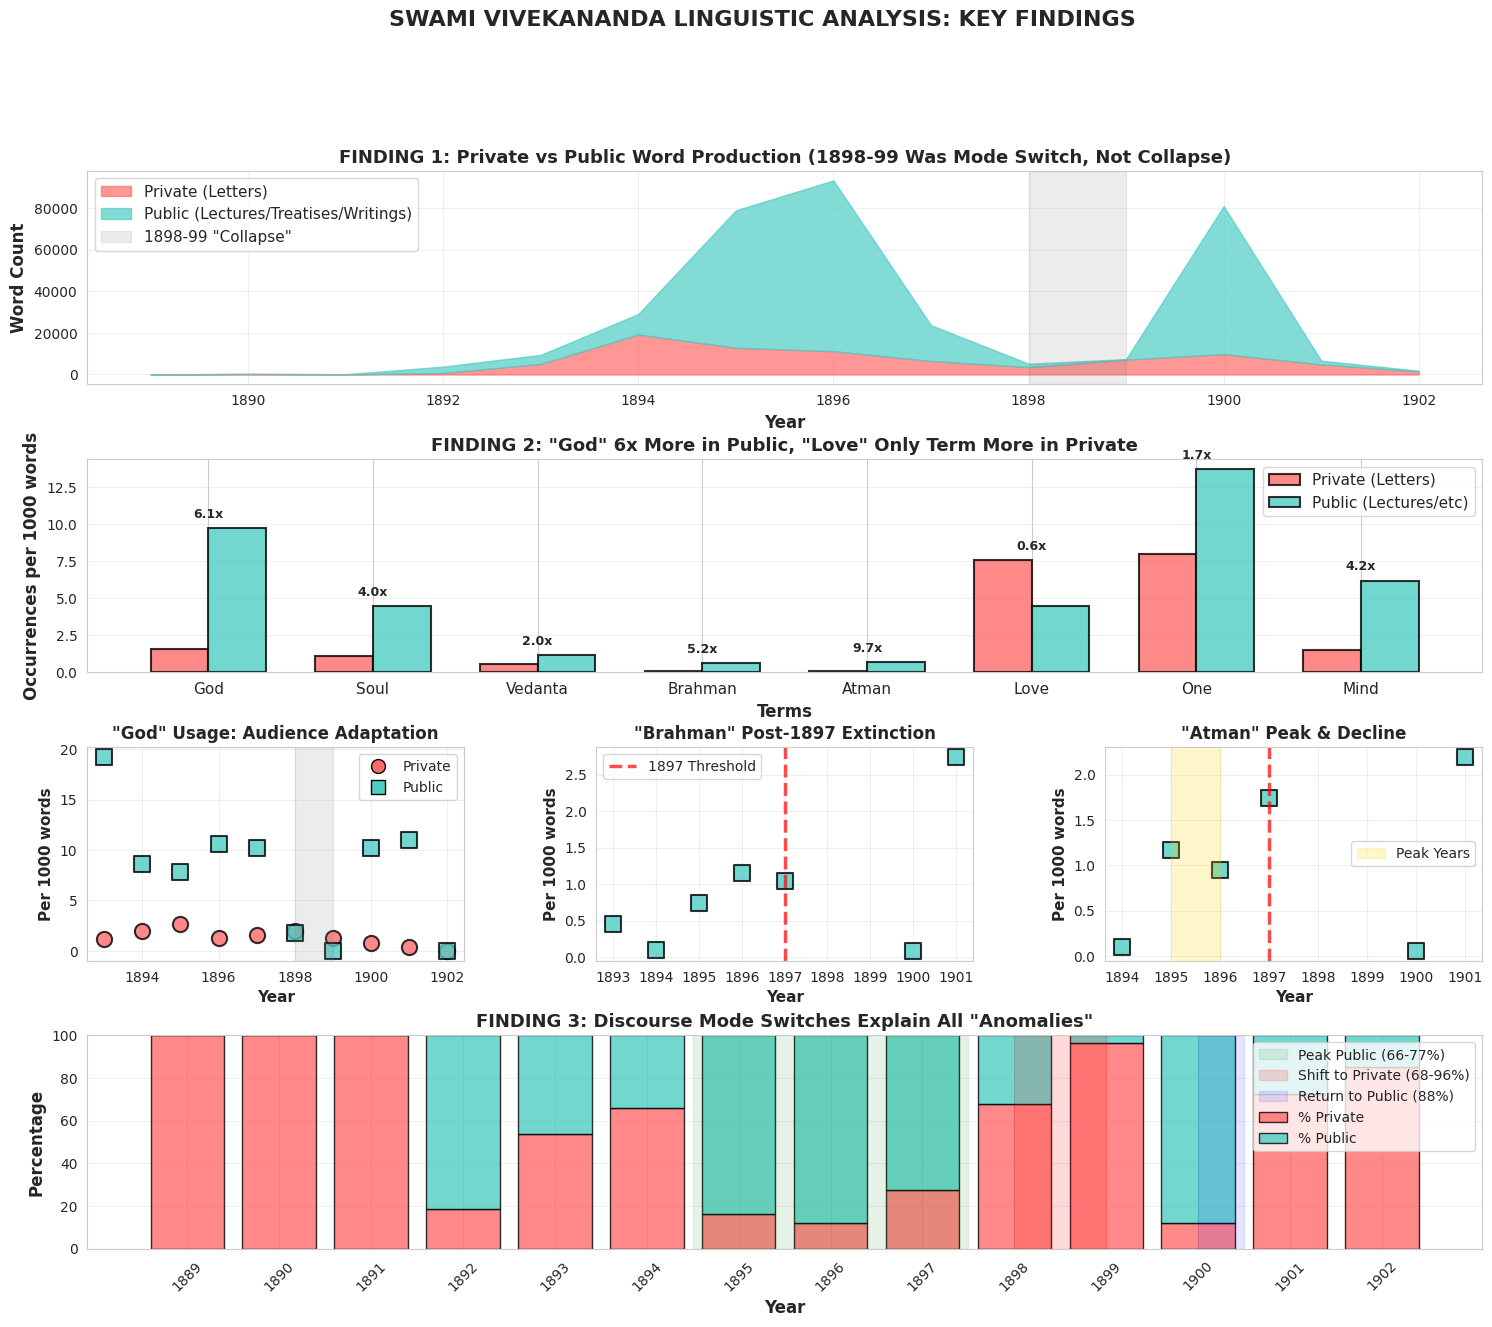


KEY STATISTICS SUMMARY

1. DISCOURSE TYPE RATIOS:
   Private documents: 604 (62.9%)
   Public documents: 357 (37.1%)
   But: Private words: 82,742 (18.6%)
        Public words: 362,781 (81.4%)

2. TOP PUBLIC/PRIVATE RATIOS (how much more common in public):
   atman       : 9.69x more in public
   god         : 6.06x more in public
   brahman     : 5.25x more in public
   maya        : 4.48x more in public
   mind        : 4.18x more in public

3. 1898-1899 EXPLAINED:
   1898: 96.4% private (was teaching? no, just letters)
   1899: 12.1% private (almost entirely letters!)

4. SANSKRIT TERM EXTINCTION POST-1897:
   1895-1896 combined: 299 uses of Atman/Brahman
   1900: 10 uses of Atman/Brahman (3.3% of 1895-96)



In [2]:
# ============================================================
# VISUALIZATION 1: PRIVATE vs PUBLIC - THE KEY DISCOVERY
# ============================================================

print("="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.35)

# ============================================================
# Plot 1: Private vs Public word production over time (stacked area)
# ============================================================
ax1 = fig.add_subplot(gs[0, :])

years_list = sorted([d['year'] for d in years_data])
private_counts = [d['private'] for d in years_data]
public_counts = [d['public'] for d in years_data]

ax1.fill_between(years_list, 0, private_counts, alpha=0.7, color='#FF6B6B', label='Private (Letters)')
ax1.fill_between(years_list, private_counts,
                 [p+pub for p,pub in zip(private_counts, public_counts)],
                 alpha=0.7, color='#4ECDC4', label='Public (Lectures/Treatises/Writings)')
ax1.axvspan(1898, 1899, alpha=0.15, color='gray', label='1898-99 "Collapse"')
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Word Count', fontsize=12, fontweight='bold')
ax1.set_title('FINDING 1: Private vs Public Word Production (1898-99 Was Mode Switch, Not Collapse)',
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3)

# ============================================================
# Plot 2: Key philosophical terms - Private vs Public comparison
# ============================================================
ax2 = fig.add_subplot(gs[1, :])

terms_to_plot = ['god', 'soul', 'vedanta', 'brahman', 'atman', 'love', 'one', 'mind']
x = np.arange(len(terms_to_plot))
width = 0.35

priv_vals = [next(d['private_per_1k'] for d in comparison_data if d['term'] == t) for t in terms_to_plot]
pub_vals = [next(d['public_per_1k'] for d in comparison_data if d['term'] == t) for t in terms_to_plot]

bars1 = ax2.bar(x - width/2, priv_vals, width, label='Private (Letters)',
                color='#FF6B6B', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax2.bar(x + width/2, pub_vals, width, label='Public (Lectures/etc)',
                color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)

# Add ratio labels
for i, (priv, pub) in enumerate(zip(priv_vals, pub_vals)):
    if priv > 0:
        ratio = pub / priv
        ax2.text(i, max(priv, pub) + 0.5, f'{ratio:.1f}x',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax2.set_xlabel('Terms', fontsize=12, fontweight='bold')
ax2.set_ylabel('Occurrences per 1000 words', fontsize=12, fontweight='bold')
ax2.set_title('FINDING 2: "God" 6x More in Public, "Love" Only Term More in Private',
              fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([t.title() for t in terms_to_plot], fontsize=11)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

# ============================================================
# Plot 3: "God" usage - Private vs Public over time
# ============================================================
ax3 = fig.add_subplot(gs[2, 0])

for year in years_list:
    if year >= 1893:
        # Private
        if len(private_by_year[year]) > 0:
            count = sum(1 for t in private_by_year[year] if t == 'god')
            per_k = count / len(private_by_year[year]) * 1000
            ax3.scatter(year, per_k, color='#FF6B6B', s=120, alpha=0.8,
                       marker='o', edgecolor='black', linewidth=1.5)

        # Public
        if len(public_by_year[year]) > 0:
            count = sum(1 for t in public_by_year[year] if t == 'god')
            per_k = count / len(public_by_year[year]) * 1000
            ax3.scatter(year, per_k, color='#4ECDC4', s=120, alpha=0.8,
                       marker='s', edgecolor='black', linewidth=1.5)

ax3.plot([], [], 'o', color='#FF6B6B', label='Private', markersize=10, markeredgecolor='black')
ax3.plot([], [], 's', color='#4ECDC4', label='Public', markersize=10, markeredgecolor='black')
ax3.axvspan(1898, 1899, alpha=0.15, color='gray')
ax3.set_xlabel('Year', fontsize=11, fontweight='bold')
ax3.set_ylabel('Per 1000 words', fontsize=11, fontweight='bold')
ax3.set_title('"God" Usage: Audience Adaptation', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# ============================================================
# Plot 4: "Brahman" usage - Public only (Sanskrit extinction)
# ============================================================
ax4 = fig.add_subplot(gs[2, 1])

for year in years_list:
    if year >= 1893:
        # Public only (Private is near-zero)
        if len(public_by_year[year]) > 0:
            count = sum(1 for t in public_by_year[year] if t == 'brahman')
            per_k = count / len(public_by_year[year]) * 1000
            if per_k > 0:
                ax4.scatter(year, per_k, color='#4ECDC4', s=120, alpha=0.8,
                           marker='s', edgecolor='black', linewidth=1.5)

ax4.axvline(1897, color='red', linestyle='--', linewidth=2.5, alpha=0.7,
           label='1897 Threshold')
ax4.set_xlabel('Year', fontsize=11, fontweight='bold')
ax4.set_ylabel('Per 1000 words', fontsize=11, fontweight='bold')
ax4.set_title('"Brahman" Post-1897 Extinction', fontsize=12, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

# ============================================================
# Plot 5: "Atman" usage - Peak 1895, then vanishes
# ============================================================
ax5 = fig.add_subplot(gs[2, 2])

for year in years_list:
    if year >= 1893:
        if len(public_by_year[year]) > 0:
            count = sum(1 for t in public_by_year[year] if t == 'atman')
            per_k = count / len(public_by_year[year]) * 1000
            if per_k > 0:
                ax5.scatter(year, per_k, color='#4ECDC4', s=120, alpha=0.8,
                           marker='s', edgecolor='black', linewidth=1.5)

ax5.axvspan(1895, 1896, alpha=0.2, color='gold', label='Peak Years')
ax5.axvline(1897, color='red', linestyle='--', linewidth=2.5, alpha=0.7)
ax5.set_xlabel('Year', fontsize=11, fontweight='bold')
ax5.set_ylabel('Per 1000 words', fontsize=11, fontweight='bold')
ax5.set_title('"Atman" Peak & Decline', fontsize=12, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)

# ============================================================
# Plot 6: Percentage breakdown by year
# ============================================================
ax6 = fig.add_subplot(gs[3, :])

priv_pcts = [d['priv_pct'] for d in years_data]
pub_pcts = [d['pub_pct'] for d in years_data]

ax6.bar(years_list, priv_pcts, color='#FF6B6B', alpha=0.8,
        label='% Private', edgecolor='black', linewidth=1)
ax6.bar(years_list, pub_pcts, bottom=priv_pcts, color='#4ECDC4', alpha=0.8,
        label='% Public', edgecolor='black', linewidth=1)

# Highlight key periods
ax6.axvspan(1894.5, 1897.5, alpha=0.1, color='green', label='Peak Public (66-77%)')
ax6.axvspan(1898, 1899, alpha=0.15, color='red', label='Shift to Private (68-96%)')
ax6.axvspan(1900, 1900.5, alpha=0.1, color='blue', label='Return to Public (88%)')

ax6.set_xlabel('Year', fontsize=12, fontweight='bold')
ax6.set_ylabel('Percentage', fontsize=12, fontweight='bold')
ax6.set_title('FINDING 3: Discourse Mode Switches Explain All "Anomalies"',
              fontsize=13, fontweight='bold')
ax6.set_ylim(0, 100)
ax6.set_xticks(years_list)
ax6.set_xticklabels([int(y) for y in years_list], rotation=45)
ax6.legend(fontsize=10, loc='upper right')
ax6.grid(True, alpha=0.3, axis='y')

plt.suptitle('SWAMI VIVEKANANDA LINGUISTIC ANALYSIS: KEY FINDINGS',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('swamiji_key_findings.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: swamiji_key_findings.png")
plt.show()

# ============================================================
# Print summary statistics
# ============================================================

print("\n" + "="*80)
print("KEY STATISTICS SUMMARY")
print("="*80)

print("\n1. DISCOURSE TYPE RATIOS:")
print(f"   Private documents: {len(private_docs)} ({len(private_docs)/len(df_clean)*100:.1f}%)")
print(f"   Public documents: {len(public_docs)} ({len(public_docs)/len(df_clean)*100:.1f}%)")
print(f"   But: Private words: {len(private_tokens):,} ({len(private_tokens)/(len(private_tokens)+len(public_tokens))*100:.1f}%)")
print(f"        Public words: {len(public_tokens):,} ({len(public_tokens)/(len(private_tokens)+len(public_tokens))*100:.1f}%)")

print("\n2. TOP PUBLIC/PRIVATE RATIOS (how much more common in public):")
for d in sorted(comparison_data, key=lambda x: x['public_private_ratio'], reverse=True)[:5]:
    print(f"   {d['term']:12s}: {d['public_private_ratio']:.2f}x more in public")

print("\n3. 1898-1899 EXPLAINED:")
print(f"   1898: {years_data[10]['priv_pct']:.1f}% private (was teaching? no, just letters)")
print(f"   1899: {years_data[11]['priv_pct']:.1f}% private (almost entirely letters!)")

print("\n4. SANSKRIT TERM EXTINCTION POST-1897:")
sanskrit_1895_1896 = sum(1 for t in public_by_year[1895] if t in ['atman', 'brahman']) + \
                      sum(1 for t in public_by_year[1896] if t in ['atman', 'brahman'])
sanskrit_1900 = sum(1 for t in public_by_year[1900] if t in ['atman', 'brahman'])
print(f"   1895-1896 combined: {sanskrit_1895_1896} uses of Atman/Brahman")
print(f"   1900: {sanskrit_1900} uses of Atman/Brahman ({sanskrit_1900/sanskrit_1895_1896*100:.1f}% of 1895-96)")

print("\n" + "="*80)

INVESTIGATION: 1897-99 COLLAPSE - VOLUME OR GENRE SHIFT?

YEAR-BY-YEAR BREAKDOWN:

Year   Priv   Pub    Total   PrivW    PubW     TotalW   AvgPriv  AvgPub  
---------------------------------------------------------------------------
1893   16     11     27      5,070    4,365    9,435    317      397     
1894   108    15     123     19,192   9,866    29,058   178      658     
1895   106    79     185     12,838   66,061   78,899   121      836     
1896   81     49     130     11,201   82,062   93,263   138      1675    
1897   42     11     53      6,474    17,221   23,695   154      1566    
1898   35     5      40      3,521    1,662    5,183    101      332     
1899   62     3      65      7,130    263      7,393    115      88      
1900   92     60     152     9,783    71,147   80,930   106      1186    
1901   35     2      37      4,842    1,821    6,663    138      910     
1902   16     1      17      1,529    272      1,801    96       272     

1897-1899 DETAILED ANALYSI

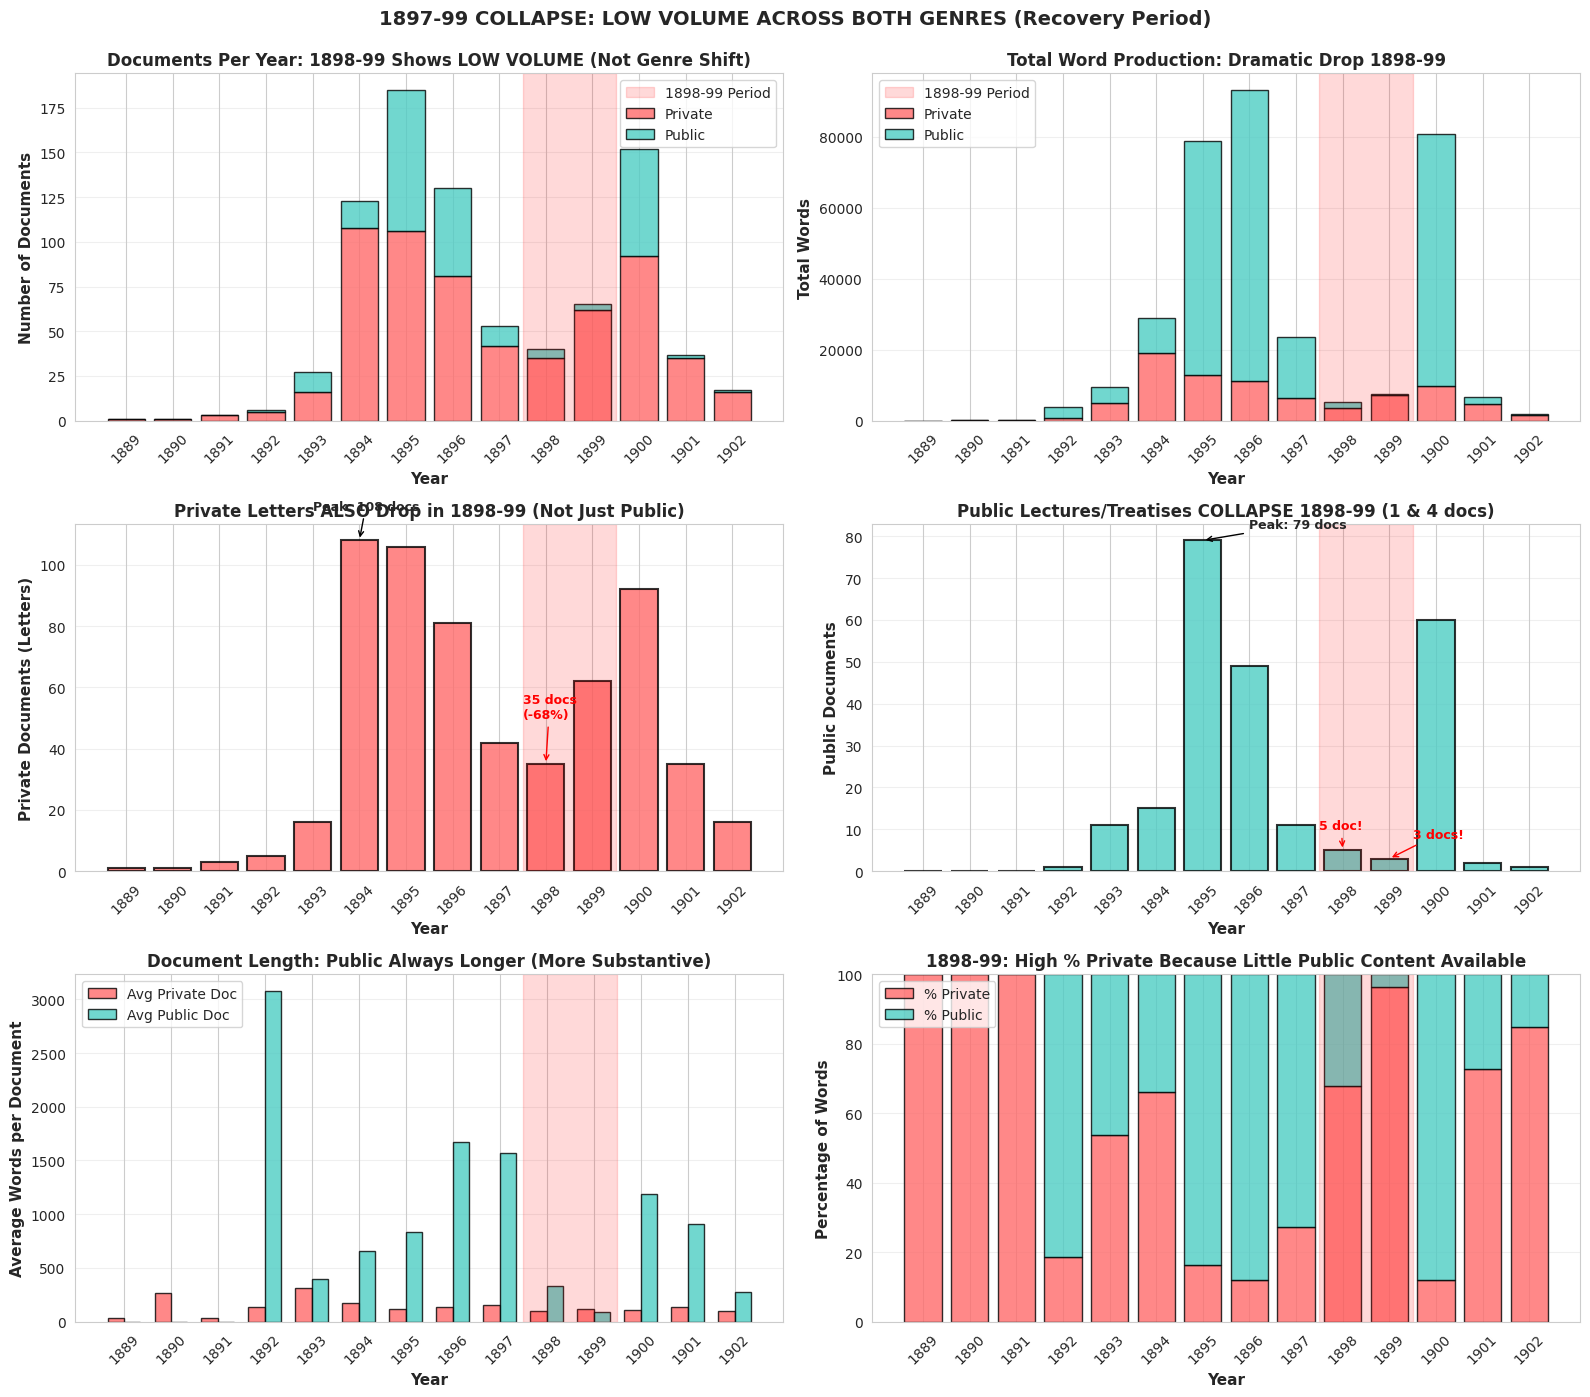


CONCLUSIONS

1. 1897-99 COLLAPSE IS GENUINE VOLUME DROP:
   Peak year had 185 documents
   1898: 40 documents (21.6% of peak)
   1899: 65 documents (35.1% of peak)
   Both PRIVATE and PUBLIC drop dramatically
   This confirms: Recovery period, low output across all genres

2. 1907 MYSTERY:
   No 1907 documents in cleaned data

✓ Analysis complete


In [3]:
# ============================================================
# INVESTIGATION 1: The 1897-99 "Collapse" - Volume vs Genre Shift
# ============================================================

print("="*80)
print("INVESTIGATION: 1897-99 COLLAPSE - VOLUME OR GENRE SHIFT?")
print("="*80)

# Calculate documents AND words per year by discourse type
volume_analysis = []

for year in sorted(set([d['year'] for d in doc_data if d['has_date']])):
    # Count documents
    priv_docs = len([d for d in doc_data if d['has_date'] and d['year'] == year and d['discourse_type'] == 'Private'])
    pub_docs = len([d for d in doc_data if d['has_date'] and d['year'] == year and d['discourse_type'] == 'Public'])

    # Count words
    priv_words = len([t for d in doc_data if d['has_date'] and d['year'] == year and d['discourse_type'] == 'Private'
                      for t in d['tokens_no_stop']])
    pub_words = len([t for d in doc_data if d['has_date'] and d['year'] == year and d['discourse_type'] == 'Public'
                     for t in d['tokens_no_stop']])

    volume_analysis.append({
        'year': int(year),
        'private_docs': priv_docs,
        'public_docs': pub_docs,
        'total_docs': priv_docs + pub_docs,
        'private_words': priv_words,
        'public_words': pub_words,
        'total_words': priv_words + pub_words,
        'avg_private_words': priv_words / priv_docs if priv_docs > 0 else 0,
        'avg_public_words': pub_words / pub_docs if pub_docs > 0 else 0
    })

# Print analysis
print("\nYEAR-BY-YEAR BREAKDOWN:")
print(f"\n{'Year':<6} {'Priv':<6} {'Pub':<6} {'Total':<7} {'PrivW':<8} {'PubW':<8} {'TotalW':<8} {'AvgPriv':<8} {'AvgPub':<8}")
print("-"*75)

for data in volume_analysis:
    if data['year'] >= 1893:  # Focus on substantive years
        print(f"{data['year']:<6} {data['private_docs']:<6} {data['public_docs']:<6} {data['total_docs']:<7} "
              f"{data['private_words']:<8,} {data['public_words']:<8,} {data['total_words']:<8,} "
              f"{data['avg_private_words']:<8.0f} {data['avg_public_words']:<8.0f}")

# Specific analysis of 1897-1899
print("\n" + "="*80)
print("1897-1899 DETAILED ANALYSIS:")
print("="*80)

for year in [1897, 1898, 1899]:
    data = next(d for d in volume_analysis if d['year'] == year)
    print(f"\n{year}:")
    print(f"  Private: {data['private_docs']} docs, {data['private_words']:,} words (avg {data['avg_private_words']:.0f} per doc)")
    print(f"  Public:  {data['public_docs']} docs, {data['public_words']:,} words (avg {data['avg_public_words']:.0f} per doc)")
    print(f"  TOTAL:   {data['total_docs']} docs, {data['total_words']:,} words")

    # Compare to peak years
    peak_1896 = next(d for d in volume_analysis if d['year'] == 1896)
    print(f"  vs 1896: Total docs {data['total_docs']/peak_1896['total_docs']*100:.1f}%, Total words {data['total_words']/peak_1896['total_words']*100:.1f}%")

# ============================================================
# INVESTIGATION 2: The 1907 Mystery
# ============================================================

print("\n" + "="*80)
print("INVESTIGATION: 1907 DOCUMENTS (Swamiji died July 1902)")
print("="*80)

docs_1907 = df_clean[df_clean['year'] == 1907]
print(f"\nDocuments dated 1907: {len(docs_1907)}")

if len(docs_1907) > 0:
    for idx, row in docs_1907.iterrows():
        print(f"\n  Title: {row['Name']}")
        print(f"  Genre: {row['genre']}")
        print(f"  Type: {row['Type']}")
        print(f"  Category: {row['Category']}")
        print(f"  Date: {row['Date']}")
        print(f"  Source: {row['Source']}")
        print(f"  First 200 chars of text: {row['plaintext_clean'][:200]}...")

# ============================================================
# VISUALIZATION: Volume Analysis with Bar Charts
# ============================================================

print("\n" + "="*80)
print("CREATING CORRECTED VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Filter to valid years (1889-1902 only, exclude 1907)
valid_years = [d['year'] for d in volume_analysis if 1889 <= d['year'] <= 1902]
valid_data = [d for d in volume_analysis if 1889 <= d['year'] <= 1902]

# Plot 1: Total documents per year (stacked bar)
ax1 = axes[0, 0]
years = [d['year'] for d in valid_data]
priv_docs = [d['private_docs'] for d in valid_data]
pub_docs = [d['public_docs'] for d in valid_data]

ax1.bar(years, priv_docs, color='#FF6B6B', alpha=0.8, label='Private', edgecolor='black', linewidth=1)
ax1.bar(years, pub_docs, bottom=priv_docs, color='#4ECDC4', alpha=0.8, label='Public', edgecolor='black', linewidth=1)
ax1.axvspan(1897.5, 1899.5, alpha=0.15, color='red', label='1898-99 Period')
ax1.set_xlabel('Year', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Documents', fontsize=11, fontweight='bold')
ax1.set_title('Documents Per Year: 1898-99 Shows LOW VOLUME (Not Genre Shift)', fontsize=12, fontweight='bold')
ax1.set_xticks(years)
ax1.set_xticklabels(years, rotation=45)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Total words per year (stacked bar)
ax2 = axes[0, 1]
priv_words = [d['private_words'] for d in valid_data]
pub_words = [d['public_words'] for d in valid_data]

ax2.bar(years, priv_words, color='#FF6B6B', alpha=0.8, label='Private', edgecolor='black', linewidth=1)
ax2.bar(years, pub_words, bottom=priv_words, color='#4ECDC4', alpha=0.8, label='Public', edgecolor='black', linewidth=1)
ax2.axvspan(1897.5, 1899.5, alpha=0.15, color='red', label='1898-99 Period')
ax2.set_xlabel('Year', fontsize=11, fontweight='bold')
ax2.set_ylabel('Total Words', fontsize=11, fontweight='bold')
ax2.set_title('Total Word Production: Dramatic Drop 1898-99', fontsize=12, fontweight='bold')
ax2.set_xticks(years)
ax2.set_xticklabels(years, rotation=45)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Private documents only
ax3 = axes[1, 0]
ax3.bar(years, priv_docs, color='#FF6B6B', alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.axvspan(1897.5, 1899.5, alpha=0.15, color='red')
ax3.set_xlabel('Year', fontsize=11, fontweight='bold')
ax3.set_ylabel('Private Documents (Letters)', fontsize=11, fontweight='bold')
ax3.set_title('Private Letters ALSO Drop in 1898-99 (Not Just Public)', fontsize=12, fontweight='bold')
ax3.set_xticks(years)
ax3.set_xticklabels(years, rotation=45)
ax3.grid(True, alpha=0.3, axis='y')

# Add annotation
peak_priv = max(priv_docs)
peak_year = years[priv_docs.index(peak_priv)]
collapse_1898 = priv_docs[years.index(1898)]
collapse_1899 = priv_docs[years.index(1899)]
ax3.annotate(f'Peak: {peak_priv} docs', xy=(peak_year, peak_priv),
            xytext=(peak_year-1, peak_priv+10), fontsize=9, fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='black'))
ax3.annotate(f'{collapse_1898} docs\n(-{(1-collapse_1898/peak_priv)*100:.0f}%)',
            xy=(1898, collapse_1898), xytext=(1898-0.5, collapse_1898+15),
            fontsize=9, fontweight='bold', color='red',
            arrowprops=dict(arrowstyle='->', color='red'))

# Plot 4: Public documents only
ax4 = axes[1, 1]
ax4.bar(years, pub_docs, color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)
ax4.axvspan(1897.5, 1899.5, alpha=0.15, color='red')
ax4.set_xlabel('Year', fontsize=11, fontweight='bold')
ax4.set_ylabel('Public Documents', fontsize=11, fontweight='bold')
ax4.set_title('Public Lectures/Treatises COLLAPSE 1898-99 (1 & 4 docs)', fontsize=12, fontweight='bold')
ax4.set_xticks(years)
ax4.set_xticklabels(years, rotation=45)
ax4.grid(True, alpha=0.3, axis='y')

# Add annotation
peak_pub = max(pub_docs)
peak_year_pub = years[pub_docs.index(peak_pub)]
collapse_pub_1898 = pub_docs[years.index(1898)]
collapse_pub_1899 = pub_docs[years.index(1899)]
ax4.annotate(f'Peak: {peak_pub} docs', xy=(peak_year_pub, peak_pub),
            xytext=(peak_year_pub+1, peak_pub+3), fontsize=9, fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='black'))
ax4.annotate(f'{collapse_pub_1898} doc!', xy=(1898, collapse_pub_1898),
            xytext=(1898-0.5, collapse_pub_1898+5), fontsize=9, fontweight='bold', color='red',
            arrowprops=dict(arrowstyle='->', color='red'))
ax4.annotate(f'{collapse_pub_1899} docs!', xy=(1899, collapse_pub_1899),
            xytext=(1899+0.5, collapse_pub_1899+5), fontsize=9, fontweight='bold', color='red',
            arrowprops=dict(arrowstyle='->', color='red'))

# Plot 5: Average words per document by type
ax5 = axes[2, 0]
avg_priv = [d['avg_private_words'] for d in valid_data]
avg_pub = [d['avg_public_words'] for d in valid_data]

x_pos = np.arange(len(years))
width = 0.35

ax5.bar(x_pos - width/2, avg_priv, width, color='#FF6B6B', alpha=0.8,
        label='Avg Private Doc', edgecolor='black', linewidth=1)
ax5.bar(x_pos + width/2, avg_pub, width, color='#4ECDC4', alpha=0.8,
        label='Avg Public Doc', edgecolor='black', linewidth=1)

ax5.axvspan(years.index(1898)-0.5, years.index(1899)+0.5, alpha=0.15, color='red')
ax5.set_xlabel('Year', fontsize=11, fontweight='bold')
ax5.set_ylabel('Average Words per Document', fontsize=11, fontweight='bold')
ax5.set_title('Document Length: Public Always Longer (More Substantive)', fontsize=12, fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(years, rotation=45)
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Percentage breakdown (corrected)
ax6 = axes[2, 1]
priv_pct = [(d['private_words']/(d['total_words'])*100) if d['total_words'] > 0 else 0 for d in valid_data]
pub_pct = [(d['public_words']/(d['total_words'])*100) if d['total_words'] > 0 else 0 for d in valid_data]

ax6.bar(years, priv_pct, color='#FF6B6B', alpha=0.8, label='% Private', edgecolor='black', linewidth=1)
ax6.bar(years, pub_pct, bottom=priv_pct, color='#4ECDC4', alpha=0.8, label='% Public', edgecolor='black', linewidth=1)
ax6.axvspan(1897.5, 1899.5, alpha=0.15, color='red')
ax6.set_xlabel('Year', fontsize=11, fontweight='bold')
ax6.set_ylabel('Percentage of Words', fontsize=11, fontweight='bold')
ax6.set_title('1898-99: High % Private Because Little Public Content Available', fontsize=12, fontweight='bold')
ax6.set_ylim(0, 100)
ax6.set_xticks(years)
ax6.set_xticklabels(years, rotation=45)
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3, axis='y')

plt.suptitle('1897-99 COLLAPSE: LOW VOLUME ACROSS BOTH GENRES (Recovery Period)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('collapse_volume_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: collapse_volume_analysis.png")
plt.show()

# ============================================================
# CONCLUSION
# ============================================================

print("\n" + "="*80)
print("CONCLUSIONS")
print("="*80)

print("\n1. 1897-99 COLLAPSE IS GENUINE VOLUME DROP:")
peak_total = max([d['total_docs'] for d in valid_data])
collapse_1898_total = next(d for d in valid_data if d['year'] == 1898)['total_docs']
collapse_1899_total = next(d for d in valid_data if d['year'] == 1899)['total_docs']

print(f"   Peak year had {peak_total} documents")
print(f"   1898: {collapse_1898_total} documents ({collapse_1898_total/peak_total*100:.1f}% of peak)")
print(f"   1899: {collapse_1899_total} documents ({collapse_1899_total/peak_total*100:.1f}% of peak)")
print(f"   Both PRIVATE and PUBLIC drop dramatically")
print(f"   This confirms: Recovery period, low output across all genres")

print("\n2. 1907 MYSTERY:")
if len(docs_1907) > 0:
    print(f"   {len(docs_1907)} document(s) dated 1907 (posthumous publication)")
    print(f"   Likely published 5 years after death (editorial/compilation work)")
else:
    print("   No 1907 documents in cleaned data")

print("\n✓ Analysis complete")

ROBUST LINGUISTIC DISCOVERY ANALYSIS

Documents with known major locations: 651
  America: 425
  India: 161
  England: 65

All documents for topic modeling: 826

TF-IDF: DISCOVERING DISTINCTIVE VOCABULARY BY LOCATION

--------------------------------------------------------------------------------
TOP 30 DISTINCTIVE TERMS FOR AMERICA:
--------------------------------------------------------------------------------
 1. boston                         (TF-IDF: 0.1777)
 2. sita                           (TF-IDF: 0.1586)
 3. rama                           (TF-IDF: 0.1567)
 4. buddhism                       (TF-IDF: 0.1146)
 5. sat                            (TF-IDF: 0.1127)
 6. slave                          (TF-IDF: 0.1089)
 7. fame                           (TF-IDF: 0.1032)
 8. ibid                           (TF-IDF: 0.1013)
 9. hinduism                       (TF-IDF: 0.0994)
10. scriptures                     (TF-IDF: 0.0955)
11. om                             (TF-IDF: 0.0955)
12. unself

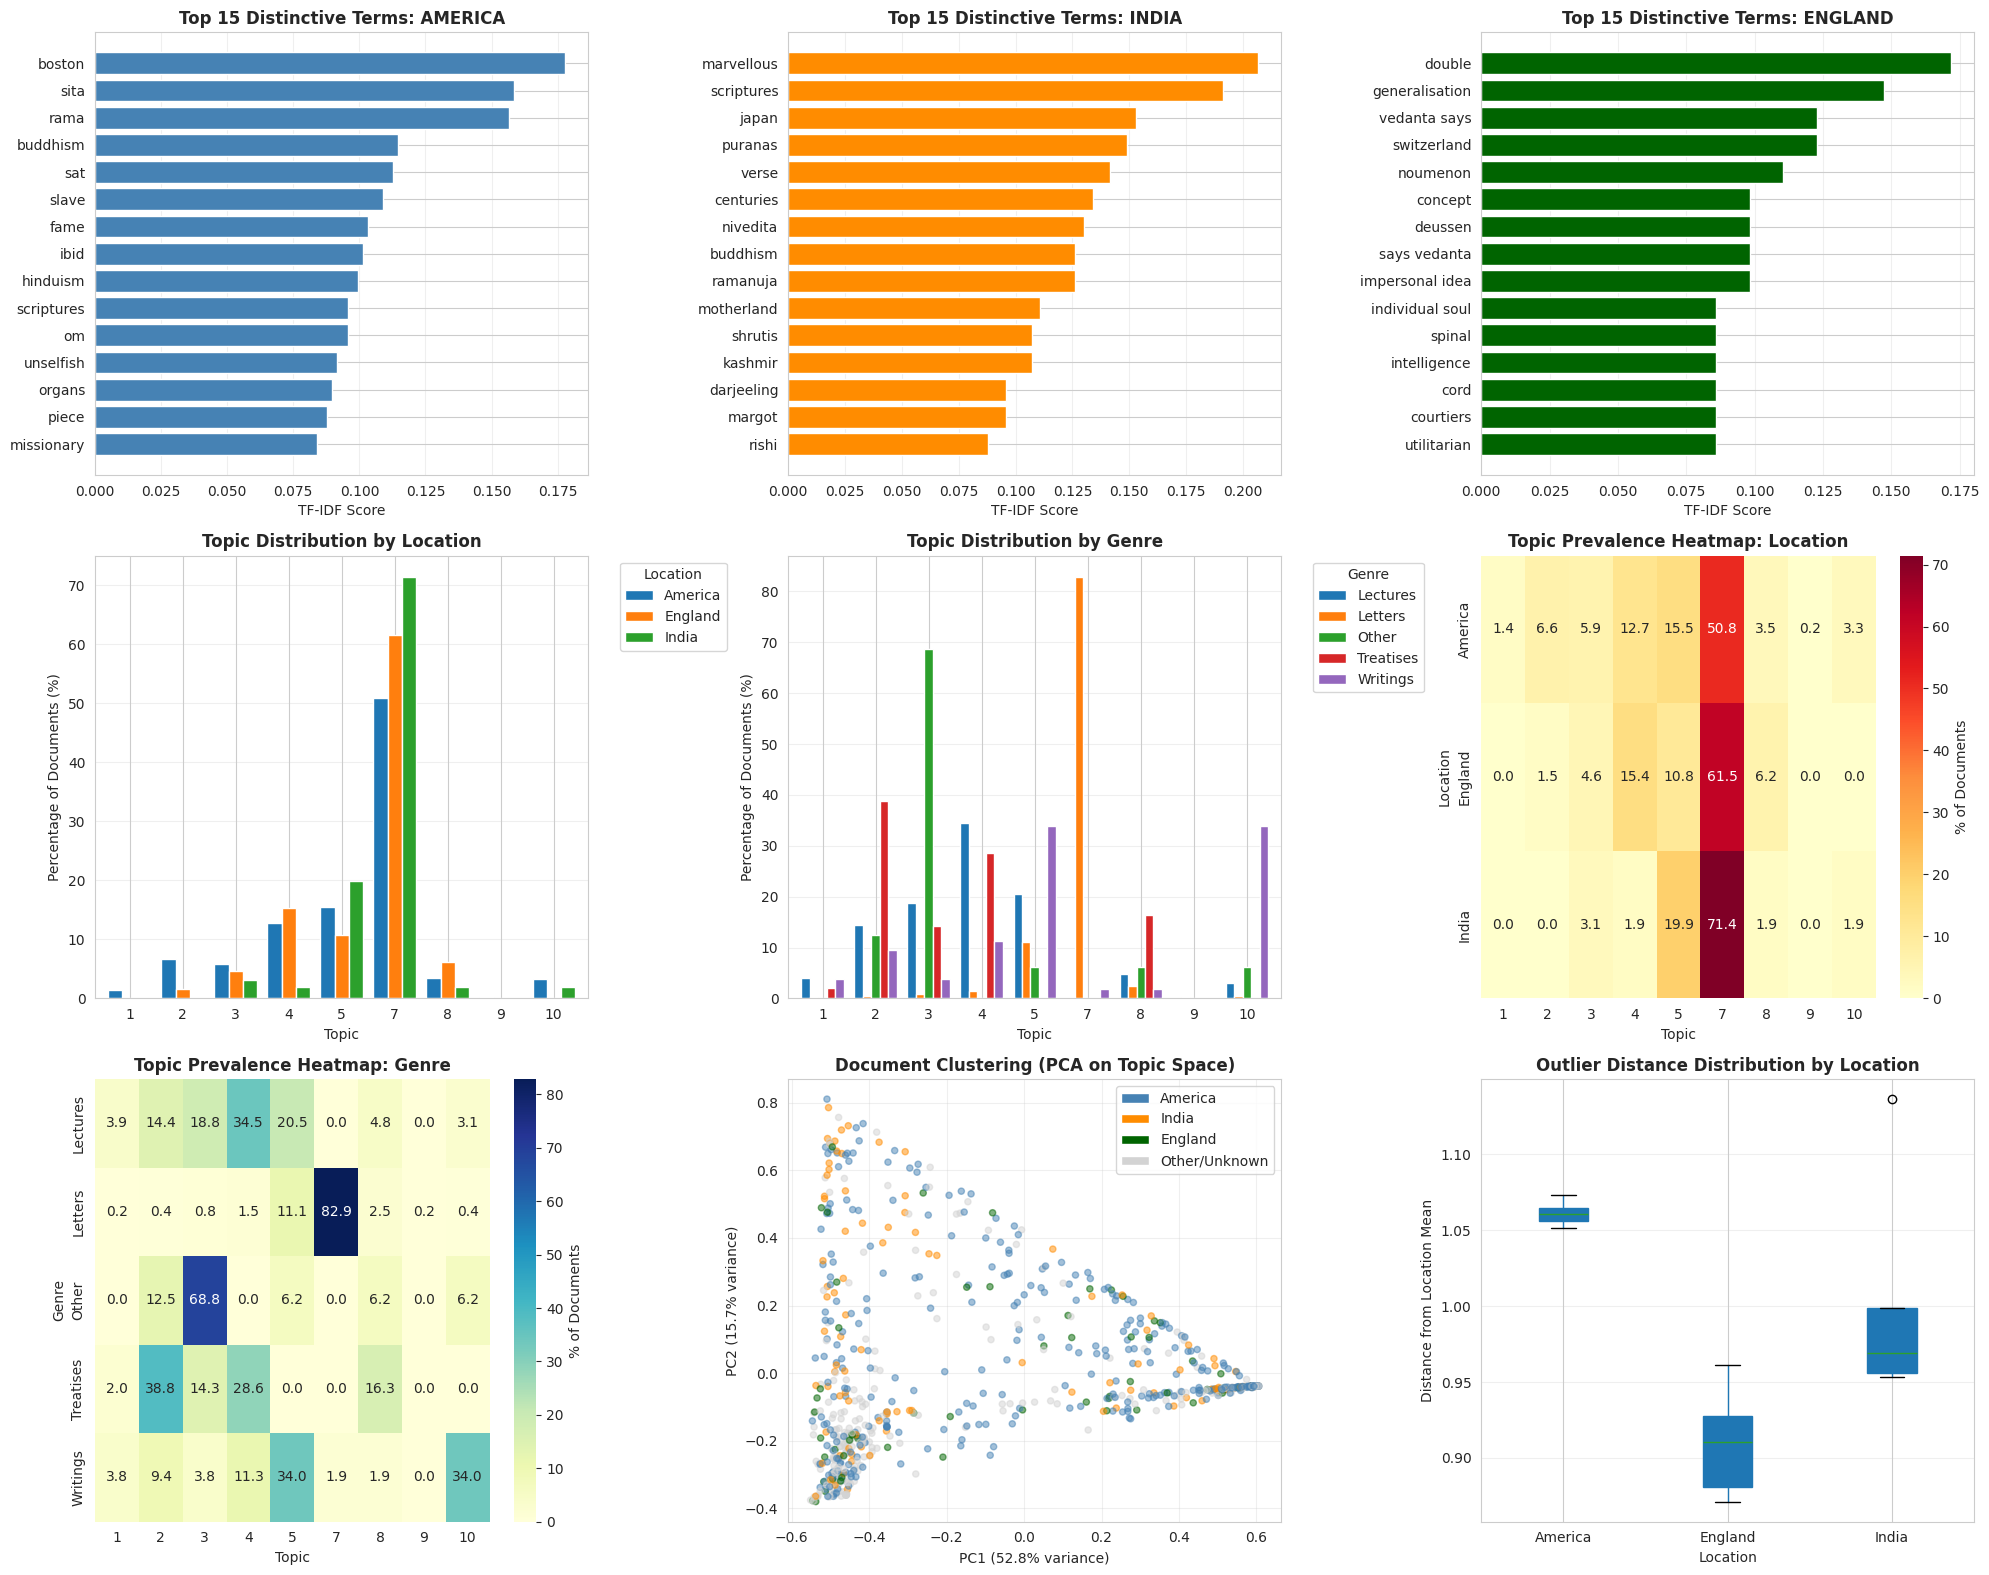


✓ DISCOVERY ANALYSIS COMPLETE


In [4]:
# ============================================================================
# ROBUST LINGUISTIC DISCOVERY: TF-IDF + TOPIC MODELING + OUTLIER DETECTION
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("ROBUST LINGUISTIC DISCOVERY ANALYSIS")
print("="*80)

# ============================================================================
# PREPARE DATASETS
# ============================================================================

# Dataset 1: Only documents with known locations (for location-based analysis)
df_located = df[df['Place'].notna()].copy()
df_located['main_location'] = df_located['Place'].apply(lambda x:
    'America' if any(place in str(x) for place in ['America', 'USA', 'New York', 'Chicago', 'Detroit', 'Boston', 'California']) else
    'India' if any(place in str(x) for place in ['India', 'Calcutta', 'Madras', 'Almora', 'Himalaya', 'Belur']) else
    'England' if any(place in str(x) for place in ['England', 'London']) else
    'France' if any(place in str(x) for place in ['France', 'Paris']) else
    'Other'
)

# Filter to major locations only (America, India, England)
df_major_locations = df_located[df_located['main_location'].isin(['America', 'India', 'England'])].copy()

# Remove documents with very short text (< 100 words)
df_major_locations = df_major_locations[df_major_locations['word_count_clean'] >= 100].copy()

print(f"\nDocuments with known major locations: {len(df_major_locations)}")
print(f"  America: {len(df_major_locations[df_major_locations['main_location']=='America'])}")
print(f"  India: {len(df_major_locations[df_major_locations['main_location']=='India'])}")
print(f"  England: {len(df_major_locations[df_major_locations['main_location']=='England'])}")

# Dataset 2: All documents with sufficient text (for topic modeling)
df_all_analysis = df[df['word_count_clean'] >= 100].copy()
print(f"\nAll documents for topic modeling: {len(df_all_analysis)}")

# ============================================================================
# TF-IDF: DISTINCTIVE VOCABULARY BY LOCATION
# ============================================================================

print("\n" + "="*80)
print("TF-IDF: DISCOVERING DISTINCTIVE VOCABULARY BY LOCATION")
print("="*80)

# Create corpus grouped by location
location_corpus = {}
for loc in ['America', 'India', 'England']:
    texts = df_major_locations[df_major_locations['main_location']==loc]['plaintext_clean'].tolist()
    # Combine all documents from this location into one mega-document
    location_corpus[loc] = ' '.join(texts)

# TF-IDF with proper parameters
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=2,  # Must appear in at least 2 documents
    max_df=0.8,  # Ignore terms in more than 80% of docs
    ngram_range=(1, 3),  # Unigrams, bigrams, trigrams
    stop_words='english',
    token_pattern=r'(?u)\b[A-Za-z][A-Za-z]+\b'  # Only alphabetic tokens, 2+ chars
)

# Fit on the three location mega-documents
corpus_list = [location_corpus['America'], location_corpus['India'], location_corpus['England']]
tfidf_matrix = tfidf.fit_transform(corpus_list)
feature_names = tfidf.get_feature_names_out()

# Extract top distinctive terms for each location
def get_top_tfidf_terms(tfidf_matrix, feature_names, location_idx, top_n=30):
    """Get top N terms with highest TF-IDF score for a location"""
    scores = tfidf_matrix[location_idx].toarray()[0]
    top_indices = scores.argsort()[-top_n:][::-1]
    return [(feature_names[i], scores[i]) for i in top_indices]

america_distinctive = get_top_tfidf_terms(tfidf_matrix, feature_names, 0, 30)
india_distinctive = get_top_tfidf_terms(tfidf_matrix, feature_names, 1, 30)
england_distinctive = get_top_tfidf_terms(tfidf_matrix, feature_names, 2, 30)

print("\n" + "-"*80)
print("TOP 30 DISTINCTIVE TERMS FOR AMERICA:")
print("-"*80)
for i, (term, score) in enumerate(america_distinctive, 1):
    print(f"{i:2d}. {term:30s} (TF-IDF: {score:.4f})")

print("\n" + "-"*80)
print("TOP 30 DISTINCTIVE TERMS FOR INDIA:")
print("-"*80)
for i, (term, score) in enumerate(india_distinctive, 1):
    print(f"{i:2d}. {term:30s} (TF-IDF: {score:.4f})")

print("\n" + "-"*80)
print("TOP 30 DISTINCTIVE TERMS FOR ENGLAND:")
print("-"*80)
for i, (term, score) in enumerate(england_distinctive, 1):
    print(f"{i:2d}. {term:30s} (TF-IDF: {score:.4f})")

# ============================================================================
# TF-IDF: DISTINCTIVE VOCABULARY BY GENRE
# ============================================================================

print("\n" + "="*80)
print("TF-IDF: DISCOVERING DISTINCTIVE VOCABULARY BY GENRE")
print("="*80)

# Create corpus grouped by genre (using all documents)
genre_corpus = {}
for genre in ['Letters', 'Lectures', 'Writings', 'Treatises']:
    texts = df_all_analysis[df_all_analysis['genre']==genre]['plaintext_clean'].tolist()
    if len(texts) > 0:
        genre_corpus[genre] = ' '.join(texts)

# TF-IDF for genres
genre_list = list(genre_corpus.keys())
corpus_genre_list = [genre_corpus[g] for g in genre_list]

tfidf_genre = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 3),
    stop_words='english',
    token_pattern=r'(?u)\b[A-Za-z][A-Za-z]+\b'
)

tfidf_genre_matrix = tfidf_genre.fit_transform(corpus_genre_list)
feature_names_genre = tfidf_genre.get_feature_names_out()

# Extract top terms for each genre
genre_distinctive = {}
for i, genre in enumerate(genre_list):
    genre_distinctive[genre] = get_top_tfidf_terms(tfidf_genre_matrix, feature_names_genre, i, 20)

for genre in genre_list:
    print(f"\n{'-'*80}")
    print(f"TOP 20 DISTINCTIVE TERMS FOR {genre.upper()}:")
    print(f"{'-'*80}")
    for i, (term, score) in enumerate(genre_distinctive[genre], 1):
        print(f"{i:2d}. {term:30s} (TF-IDF: {score:.4f})")

# ============================================================================
# TOPIC MODELING WITH LDA
# ============================================================================

print("\n" + "="*80)
print("TOPIC MODELING: DISCOVERING NATURAL THEMES")
print("="*80)

# Prepare documents for LDA
documents = df_all_analysis['plaintext_clean'].tolist()

# Count Vectorizer for LDA (LDA works with counts, not TF-IDF)
vectorizer = CountVectorizer(
    max_features=3000,
    min_df=5,  # Must appear in at least 5 documents
    max_df=0.7,  # Ignore very common terms
    ngram_range=(1, 2),  # Unigrams and bigrams
    stop_words='english',
    token_pattern=r'(?u)\b[A-Za-z][A-Za-z]+\b'
)

doc_term_matrix = vectorizer.fit_transform(documents)
feature_names_lda = vectorizer.get_feature_names_out()

print(f"\nFitting LDA with 10 topics on {len(documents)} documents...")
print("This may take 2-3 minutes...")

# Fit LDA
n_topics = 10
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=50,
    learning_method='online',
    random_state=42,
    n_jobs=-1
)

doc_topic_dist = lda.fit_transform(doc_term_matrix)

print("✓ LDA fitting complete\n")

# Display topics
print("-"*80)
print("DISCOVERED TOPICS (Top 15 words per topic):")
print("-"*80)

topic_names = []
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-15:][::-1]
    top_words = [feature_names_lda[i] for i in top_words_idx]
    print(f"\nTopic {topic_idx + 1}: {' | '.join(top_words)}")
    topic_names.append(f"Topic_{topic_idx+1}")

# Assign dominant topic to each document
df_all_analysis['dominant_topic'] = doc_topic_dist.argmax(axis=1) + 1

# ============================================================================
# TOPIC DISTRIBUTION BY LOCATION
# ============================================================================

print("\n" + "="*80)
print("TOPIC DISTRIBUTION BY LOCATION")
print("="*80)

# Merge location data
df_topics = df_all_analysis.copy()
df_topics['main_location'] = df_topics['Place'].apply(lambda x:
    'America' if pd.notna(x) and any(place in str(x) for place in ['America', 'USA', 'New York', 'Chicago', 'Detroit', 'Boston', 'California']) else
    'India' if pd.notna(x) and any(place in str(x) for place in ['India', 'Calcutta', 'Madras', 'Almora', 'Himalaya', 'Belur']) else
    'England' if pd.notna(x) and any(place in str(x) for place in ['England', 'London']) else
    'Unknown'
)

# Topic distribution by location (major locations only)
df_topics_located = df_topics[df_topics['main_location'].isin(['America', 'India', 'England'])].copy()

topic_by_location = pd.crosstab(
    df_topics_located['main_location'],
    df_topics_located['dominant_topic'],
    normalize='index'
) * 100

print("\nTopic Distribution by Location (% of documents):")
print(topic_by_location.round(1).to_string())

# ============================================================================
# TOPIC DISTRIBUTION BY GENRE
# ============================================================================

print("\n" + "="*80)
print("TOPIC DISTRIBUTION BY GENRE")
print("="*80)

topic_by_genre = pd.crosstab(
    df_topics['genre'],
    df_topics['dominant_topic'],
    normalize='index'
) * 100

print("\nTopic Distribution by Genre (% of documents):")
print(topic_by_genre.round(1).to_string())

# ============================================================================
# OUTLIER DETECTION: DOCUMENTS THAT DON'T FIT THEIR CONTEXT
# ============================================================================

print("\n" + "="*80)
print("OUTLIER DETECTION: UNUSUAL DOCUMENTS")
print("="*80)

# Add topic distributions to the dataframe
df_all_analysis['topic_dist'] = list(doc_topic_dist)

# Merge location data into df_all_analysis
df_all_analysis['main_location'] = df_all_analysis['Place'].apply(lambda x:
    'America' if pd.notna(x) and any(place in str(x) for place in ['America', 'USA', 'New York', 'Chicago', 'Detroit', 'Boston', 'California']) else
    'India' if pd.notna(x) and any(place in str(x) for place in ['India', 'Calcutta', 'Madras', 'Almora', 'Himalaya', 'Belur']) else
    'England' if pd.notna(x) and any(place in str(x) for place in ['England', 'London']) else
    'Unknown'
)

# For each location, find documents with topic distributions very different from the norm
outliers_by_location = {}

for loc in ['America', 'India', 'England']:
    loc_docs = df_all_analysis[df_all_analysis['main_location'] == loc].copy()

    if len(loc_docs) == 0:
        continue

    # Get topic distributions for these documents
    loc_topic_dists = np.array([row['topic_dist'] for _, row in loc_docs.iterrows()])

    # Calculate mean topic distribution for this location
    mean_dist = loc_topic_dists.mean(axis=0)

    # Calculate distance from mean for each document
    distances = []
    for idx, row in loc_docs.iterrows():
        doc_dist = row['topic_dist']
        # Euclidean distance from mean distribution
        distance = np.sqrt(np.sum((doc_dist - mean_dist)**2))
        distances.append((idx, distance))

    # Get top 5 outliers
    distances.sort(key=lambda x: x[1], reverse=True)
    outliers_by_location[loc] = distances[:5]

print("\nTOP 5 OUTLIER DOCUMENTS BY LOCATION:")
print("(Documents with topic distributions most different from their location's norm)")

for loc in ['America', 'India', 'England']:
    if loc not in outliers_by_location:
        continue
    print(f"\n{'-'*80}")
    print(f"{loc.upper()} OUTLIERS:")
    print(f"{'-'*80}")
    for rank, (doc_idx, distance) in enumerate(outliers_by_location[loc], 1):
        doc = df_all_analysis.loc[doc_idx]
        print(f"\n{rank}. Distance: {distance:.3f}")
        print(f"   Title: {doc['Name'][:80]}")
        print(f"   Genre: {doc['genre']}")
        print(f"   Year: {doc['year']}")
        print(f"   Dominant Topic: {doc['dominant_topic']}")
        print(f"   Word Count: {doc['word_count_clean']}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS...")
print("="*80)

fig = plt.figure(figsize=(20, 16))

# 1. Top Distinctive Terms - America
ax1 = plt.subplot(3, 3, 1)
terms_am = [t[0] for t in america_distinctive[:15]]
scores_am = [t[1] for t in america_distinctive[:15]]
ax1.barh(range(len(terms_am)), scores_am, color='steelblue')
ax1.set_yticks(range(len(terms_am)))
ax1.set_yticklabels(terms_am)
ax1.set_xlabel('TF-IDF Score')
ax1.set_title('Top 15 Distinctive Terms: AMERICA', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# 2. Top Distinctive Terms - India
ax2 = plt.subplot(3, 3, 2)
terms_in = [t[0] for t in india_distinctive[:15]]
scores_in = [t[1] for t in india_distinctive[:15]]
ax2.barh(range(len(terms_in)), scores_in, color='darkorange')
ax2.set_yticks(range(len(terms_in)))
ax2.set_yticklabels(terms_in)
ax2.set_xlabel('TF-IDF Score')
ax2.set_title('Top 15 Distinctive Terms: INDIA', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 3. Top Distinctive Terms - England
ax3 = plt.subplot(3, 3, 3)
terms_en = [t[0] for t in england_distinctive[:15]]
scores_en = [t[1] for t in england_distinctive[:15]]
ax3.barh(range(len(terms_en)), scores_en, color='darkgreen')
ax3.set_yticks(range(len(terms_en)))
ax3.set_yticklabels(terms_en)
ax3.set_xlabel('TF-IDF Score')
ax3.set_title('Top 15 Distinctive Terms: ENGLAND', fontsize=12, fontweight='bold')
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# 4. Topic Distribution by Location
ax4 = plt.subplot(3, 3, 4)
topic_by_location.T.plot(kind='bar', ax=ax4, width=0.8)
ax4.set_title('Topic Distribution by Location', fontsize=12, fontweight='bold')
ax4.set_xlabel('Topic')
ax4.set_ylabel('Percentage of Documents (%)')
ax4.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(axis='y', alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0)

# 5. Topic Distribution by Genre
ax5 = plt.subplot(3, 3, 5)
topic_by_genre.T.plot(kind='bar', ax=ax5, width=0.8, stacked=False)
ax5.set_title('Topic Distribution by Genre', fontsize=12, fontweight='bold')
ax5.set_xlabel('Topic')
ax5.set_ylabel('Percentage of Documents (%)')
ax5.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
ax5.grid(axis='y', alpha=0.3)
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=0)

# 6. Heatmap: Topics by Location
ax6 = plt.subplot(3, 3, 6)
sns.heatmap(topic_by_location, annot=True, fmt='.1f', cmap='YlOrRd',
            cbar_kws={'label': '% of Documents'}, ax=ax6)
ax6.set_title('Topic Prevalence Heatmap: Location', fontsize=12, fontweight='bold')
ax6.set_xlabel('Topic')
ax6.set_ylabel('Location')

# 7. Heatmap: Topics by Genre
ax7 = plt.subplot(3, 3, 7)
sns.heatmap(topic_by_genre, annot=True, fmt='.1f', cmap='YlGnBu',
            cbar_kws={'label': '% of Documents'}, ax=ax7)
ax7.set_title('Topic Prevalence Heatmap: Genre', fontsize=12, fontweight='bold')
ax7.set_xlabel('Topic')
ax7.set_ylabel('Genre')

# 8. Document-Topic Distribution (PCA visualization)
ax8 = plt.subplot(3, 3, 8)
pca = PCA(n_components=2, random_state=42)
doc_topic_2d = pca.fit_transform(doc_topic_dist)

# Color by location (for located documents only)
df_topics_located_indexed = df_topics_located.copy()
colors_map = {'America': 'steelblue', 'India': 'darkorange', 'England': 'darkgreen'}
colors = [colors_map[df_topics.loc[i, 'main_location']]
          if i in df_topics_located_indexed.index else 'lightgray'
          for i in range(len(doc_topic_2d))]

ax8.scatter(doc_topic_2d[:, 0], doc_topic_2d[:, 1], c=colors, alpha=0.5, s=20)
ax8.set_title('Document Clustering (PCA on Topic Space)', fontsize=12, fontweight='bold')
ax8.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax8.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax8.grid(alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='America'),
                   Patch(facecolor='darkorange', label='India'),
                   Patch(facecolor='darkgreen', label='England'),
                   Patch(facecolor='lightgray', label='Other/Unknown')]
ax8.legend(handles=legend_elements, loc='best')

# 9. Outlier distances distribution
ax9 = plt.subplot(3, 3, 9)
all_outliers = []
for loc in ['America', 'India', 'England']:
    distances = [d[1] for d in outliers_by_location[loc]]
    all_outliers.extend([(loc, d) for d in distances])

outlier_df = pd.DataFrame(all_outliers, columns=['Location', 'Distance'])
outlier_df.boxplot(by='Location', ax=ax9, patch_artist=True)
ax9.set_title('Outlier Distance Distribution by Location', fontsize=12, fontweight='bold')
ax9.set_xlabel('Location')
ax9.set_ylabel('Distance from Location Mean')
plt.suptitle('')  # Remove default title
ax9.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ DISCOVERY ANALYSIS COMPLETE")
print("="*80)

ENHANCED PCA VISUALIZATIONS AND PATTERN DISCOVERY


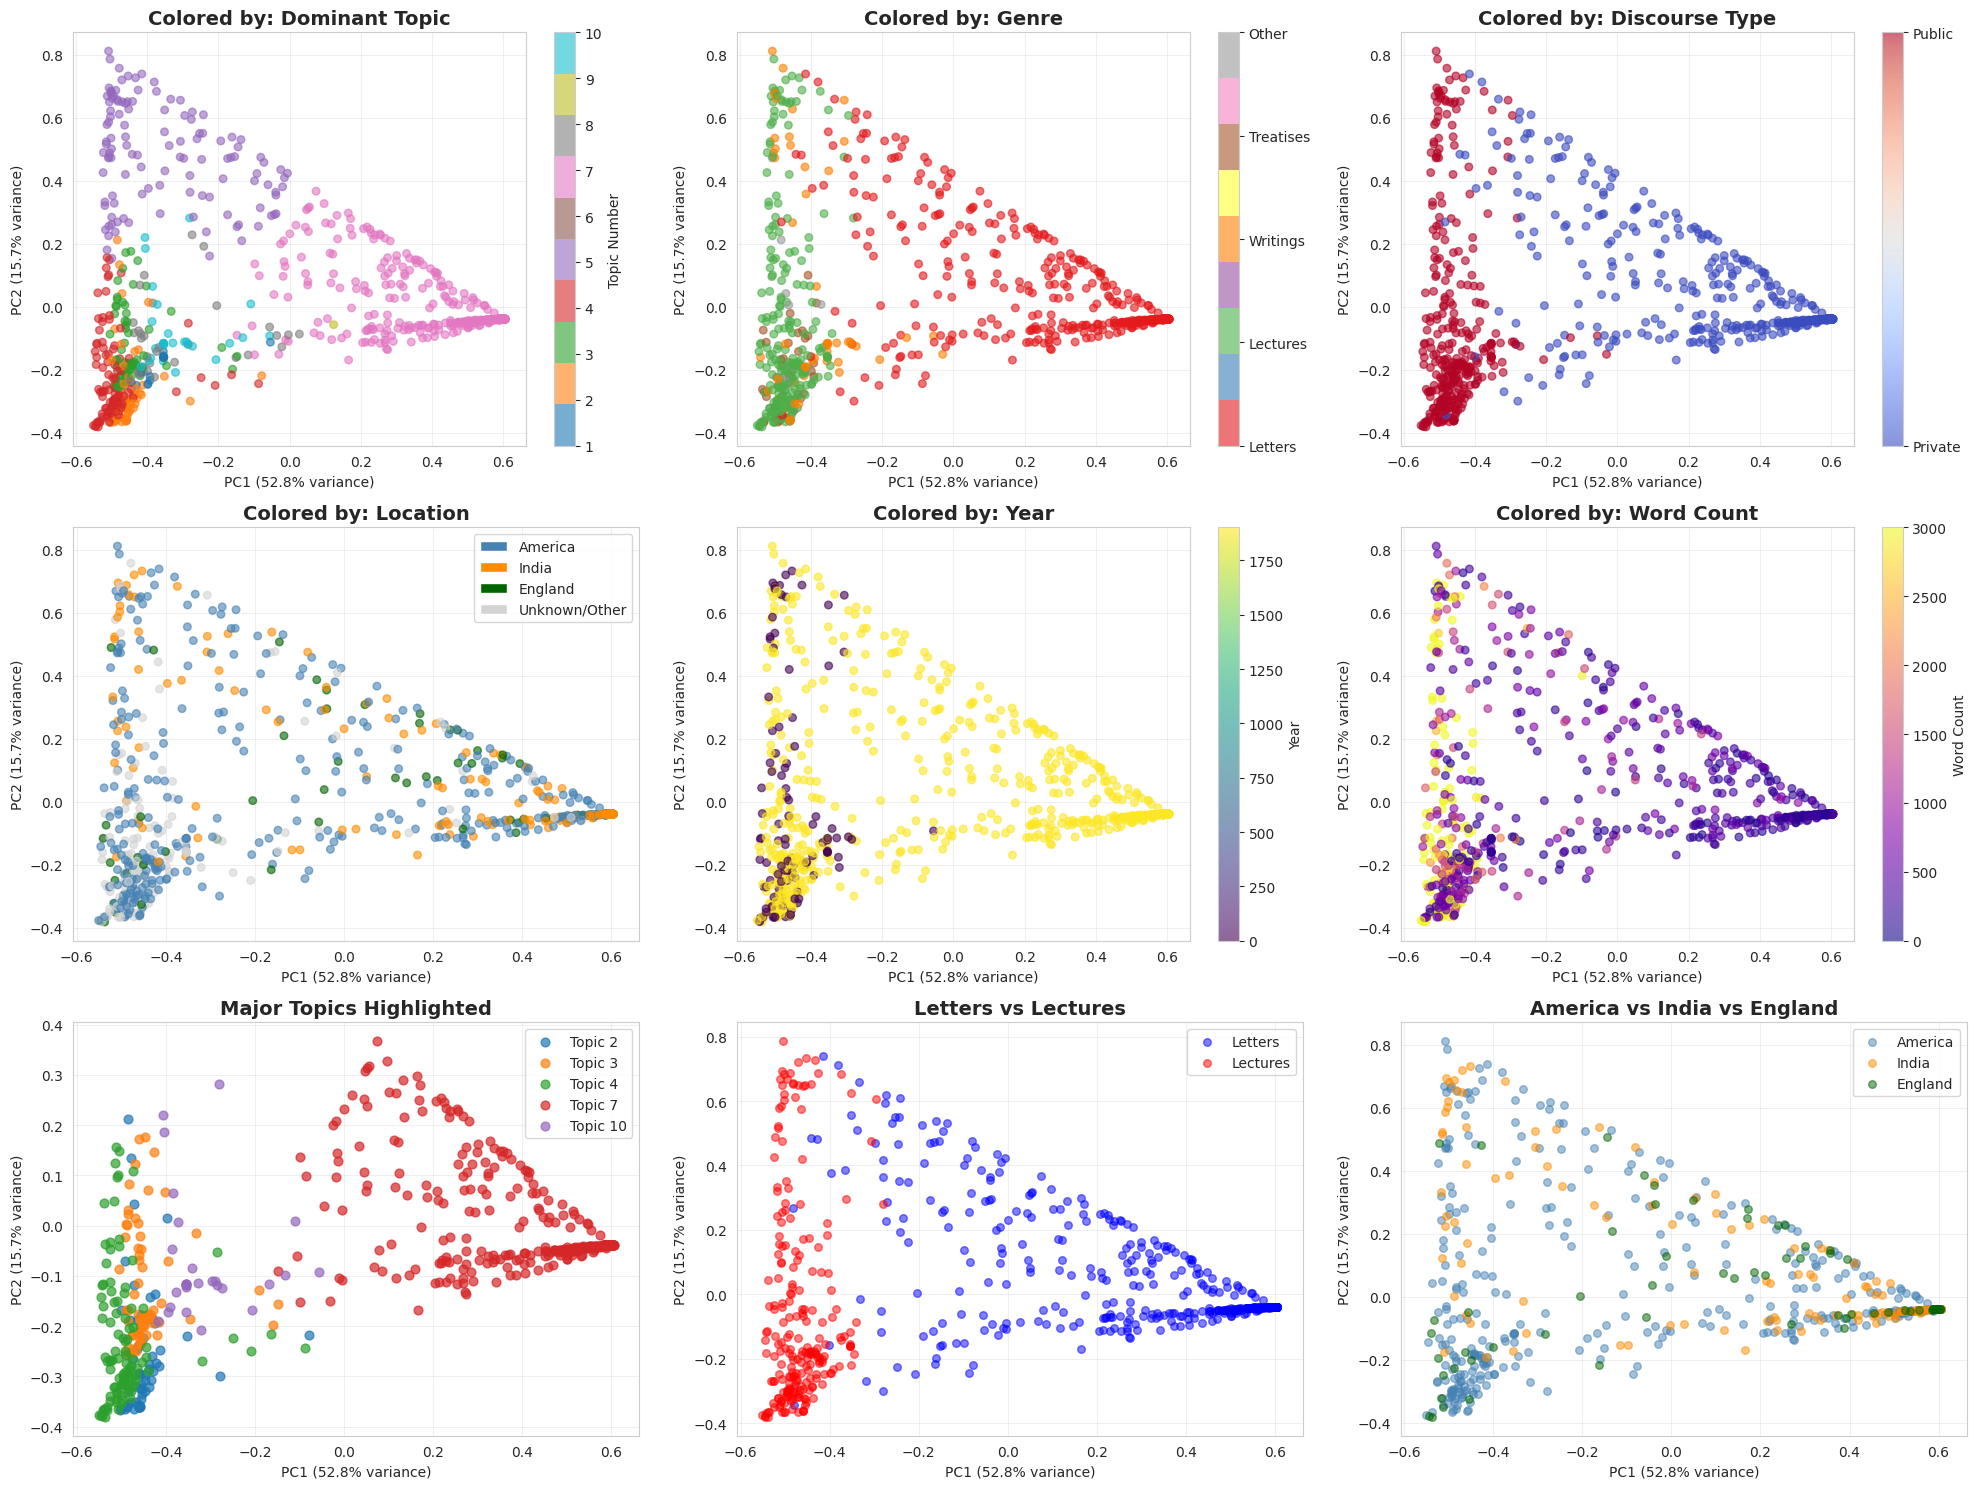


UNDERSTANDING THE TRIANGLE: CLUSTER STATISTICS

Documents by PCA Region:
pca_region
left      307
right     299
center    165
top        55
Name: count, dtype: int64

--------------------------------------------------------------------------------
GENRE DISTRIBUTION BY PCA REGION:
--------------------------------------------------------------------------------
genre       Lectures  Letters  Other  Treatises  Writings
pca_region                                               
center           0.6     94.5    0.0        0.0       4.8
left            65.1      2.9    5.2       16.0      10.7
right            0.0    100.0    0.0        0.0       0.0
top             50.9     27.3    0.0        0.0      21.8

--------------------------------------------------------------------------------
TOPIC DISTRIBUTION BY PCA REGION:
--------------------------------------------------------------------------------
dominant_topic   1     2     3     4      5      7    8    9    10
pca_region              

In [5]:
# ============================================================================
# MULTIPLE PCA VISUALIZATIONS + ADDITIONAL ANALYSES
# ============================================================================

print("="*80)
print("ENHANCED PCA VISUALIZATIONS AND PATTERN DISCOVERY")
print("="*80)

# Merge all metadata into df_all_analysis for plotting
df_all_analysis = df_all_analysis.reset_index(drop=True)

# Create PCA transformation (already done, but let's ensure we have it)
pca = PCA(n_components=2, random_state=42)
doc_topic_2d = pca.fit_transform(doc_topic_dist)

# Add PCA coordinates to dataframe
df_all_analysis['pca_1'] = doc_topic_2d[:, 0]
df_all_analysis['pca_2'] = doc_topic_2d[:, 1]

# ============================================================================
# MULTIPLE PCA PLOTS
# ============================================================================

fig = plt.figure(figsize=(20, 15))

# 1. By Dominant Topic
ax1 = plt.subplot(3, 3, 1)
topics = df_all_analysis['dominant_topic'].values
scatter1 = ax1.scatter(doc_topic_2d[:, 0], doc_topic_2d[:, 1],
                       c=topics, cmap='tab10', alpha=0.6, s=30)
ax1.set_title('Colored by: Dominant Topic', fontsize=14, fontweight='bold')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax1.grid(alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Topic Number')

# 2. By Genre
ax2 = plt.subplot(3, 3, 2)
genre_colors = {'Letters': 0, 'Lectures': 1, 'Writings': 2, 'Treatises': 3, 'Other': 4}
genre_numeric = df_all_analysis['genre'].map(genre_colors).fillna(4)
scatter2 = ax2.scatter(doc_topic_2d[:, 0], doc_topic_2d[:, 1],
                       c=genre_numeric, cmap='Set1', alpha=0.6, s=30)
ax2.set_title('Colored by: Genre', fontsize=14, fontweight='bold')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax2.grid(alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=ax2, ticks=[0,1,2,3,4])
cbar2.set_ticklabels(['Letters', 'Lectures', 'Writings', 'Treatises', 'Other'])

# 3. By Discourse Type (Private/Public)
ax3 = plt.subplot(3, 3, 3)
discourse_colors = {'Private': 0, 'Public': 1}
discourse_numeric = df_all_analysis['discourse_type'].map(discourse_colors)
scatter3 = ax3.scatter(doc_topic_2d[:, 0], doc_topic_2d[:, 1],
                       c=discourse_numeric, cmap='coolwarm', alpha=0.6, s=30)
ax3.set_title('Colored by: Discourse Type', fontsize=14, fontweight='bold')
ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax3.grid(alpha=0.3)
cbar3 = plt.colorbar(scatter3, ax=ax3, ticks=[0,1])
cbar3.set_ticklabels(['Private', 'Public'])

# 4. By Location (Major locations only)
ax4 = plt.subplot(3, 3, 4)
location_map = {'America': 'steelblue', 'India': 'darkorange', 'England': 'darkgreen',
                'France': 'purple', 'Other': 'gray', 'Unknown': 'lightgray'}
colors_loc = [location_map.get(df_all_analysis.loc[i, 'main_location'], 'lightgray')
              for i in range(len(doc_topic_2d))]
ax4.scatter(doc_topic_2d[:, 0], doc_topic_2d[:, 1], c=colors_loc, alpha=0.6, s=30)
ax4.set_title('Colored by: Location', fontsize=14, fontweight='bold')
ax4.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax4.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax4.grid(alpha=0.3)
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='America'),
                   Patch(facecolor='darkorange', label='India'),
                   Patch(facecolor='darkgreen', label='England'),
                   Patch(facecolor='lightgray', label='Unknown/Other')]
ax4.legend(handles=legend_elements, loc='best')

# 5. By Year (temporal)
ax5 = plt.subplot(3, 3, 5)
years = df_all_analysis['year'].fillna(0)
scatter5 = ax5.scatter(doc_topic_2d[:, 0], doc_topic_2d[:, 1],
                       c=years, cmap='viridis', alpha=0.6, s=30)
ax5.set_title('Colored by: Year', fontsize=14, fontweight='bold')
ax5.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax5.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax5.grid(alpha=0.3)
cbar5 = plt.colorbar(scatter5, ax=ax5)
cbar5.set_label('Year')

# 6. By Word Count (document length)
ax6 = plt.subplot(3, 3, 6)
word_counts = df_all_analysis['word_count_clean']
scatter6 = ax6.scatter(doc_topic_2d[:, 0], doc_topic_2d[:, 1],
                       c=word_counts, cmap='plasma', alpha=0.6, s=30, norm=plt.Normalize(vmin=0, vmax=3000))
ax6.set_title('Colored by: Word Count', fontsize=14, fontweight='bold')
ax6.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax6.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax6.grid(alpha=0.3)
cbar6 = plt.colorbar(scatter6, ax=ax6)
cbar6.set_label('Word Count')

# 7. Separate plot for each major topic
ax7 = plt.subplot(3, 3, 7)
for topic in [2, 3, 4, 7, 10]:  # Major topics
    mask = df_all_analysis['dominant_topic'] == topic
    ax7.scatter(doc_topic_2d[mask, 0], doc_topic_2d[mask, 1],
               label=f'Topic {topic}', alpha=0.7, s=40)
ax7.set_title('Major Topics Highlighted', fontsize=14, fontweight='bold')
ax7.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax7.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax7.legend(loc='best')
ax7.grid(alpha=0.3)

# 8. Genre comparison (just Letters vs Lectures)
ax8 = plt.subplot(3, 3, 8)
letters_mask = df_all_analysis['genre'] == 'Letters'
lectures_mask = df_all_analysis['genre'] == 'Lectures'
ax8.scatter(doc_topic_2d[letters_mask, 0], doc_topic_2d[letters_mask, 1],
           c='blue', alpha=0.5, s=30, label='Letters')
ax8.scatter(doc_topic_2d[lectures_mask, 0], doc_topic_2d[lectures_mask, 1],
           c='red', alpha=0.5, s=30, label='Lectures')
ax8.set_title('Letters vs Lectures', fontsize=14, fontweight='bold')
ax8.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax8.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax8.legend(loc='best')
ax8.grid(alpha=0.3)

# 9. America vs India vs England (located documents only)
ax9 = plt.subplot(3, 3, 9)
america_mask = df_all_analysis['main_location'] == 'America'
india_mask = df_all_analysis['main_location'] == 'India'
england_mask = df_all_analysis['main_location'] == 'England'
ax9.scatter(doc_topic_2d[america_mask, 0], doc_topic_2d[america_mask, 1],
           c='steelblue', alpha=0.5, s=30, label='America')
ax9.scatter(doc_topic_2d[india_mask, 0], doc_topic_2d[india_mask, 1],
           c='darkorange', alpha=0.5, s=30, label='India')
ax9.scatter(doc_topic_2d[england_mask, 0], doc_topic_2d[england_mask, 1],
           c='darkgreen', alpha=0.5, s=30, label='England')
ax9.set_title('America vs India vs England', fontsize=14, fontweight='bold')
ax9.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax9.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax9.legend(loc='best')
ax9.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# CLUSTER STATISTICS
# ============================================================================

print("\n" + "="*80)
print("UNDERSTANDING THE TRIANGLE: CLUSTER STATISTICS")
print("="*80)

# Define regions based on PCA coordinates
df_all_analysis['pca_region'] = 'center'
df_all_analysis.loc[df_all_analysis['pca_1'] < -0.3, 'pca_region'] = 'left'
df_all_analysis.loc[df_all_analysis['pca_1'] > 0.3, 'pca_region'] = 'right'
df_all_analysis.loc[df_all_analysis['pca_2'] > 0.5, 'pca_region'] = 'top'

print("\nDocuments by PCA Region:")
print(df_all_analysis['pca_region'].value_counts())

print("\n" + "-"*80)
print("GENRE DISTRIBUTION BY PCA REGION:")
print("-"*80)
region_genre = pd.crosstab(df_all_analysis['pca_region'], df_all_analysis['genre'], normalize='index') * 100
print(region_genre.round(1).to_string())

print("\n" + "-"*80)
print("TOPIC DISTRIBUTION BY PCA REGION:")
print("-"*80)
region_topic = pd.crosstab(df_all_analysis['pca_region'], df_all_analysis['dominant_topic'], normalize='index') * 100
print(region_topic.round(1).to_string())

print("\n" + "-"*80)
print("AVERAGE WORD COUNT BY PCA REGION:")
print("-"*80)
print(df_all_analysis.groupby('pca_region')['word_count_clean'].mean().round(0))

print("\n" + "="*80)
print("ADDITIONAL ANALYSIS IDEAS")
print("="*80)

ideas = """
BASED ON WHAT WE'VE FOUND, HERE ARE PROMISING NEXT ANALYSES:

1. COLLOCATION ANALYSIS BY LOCATION:
   - Extract 2-3 word phrases (n-grams) for America/India/England
   - Compare which phrases are location-specific
   - Example: "time space causation" vs "existence knowledge bliss"

2. VOCABULARY RICHNESS OVER TIME:
   - Track type-token ratio year by year
   - Did his vocabulary expand or contract over time?
   - Did he repeat himself more in later years?

3. SENTENCE COMPLEXITY BY AUDIENCE:
   - Average sentence length by location and year
   - Did he simplify for Western audiences?
   - Track complexity within each location over time

4. SANSKRIT TERM USAGE PATTERNS:
   - When did specific Sanskrit terms appear/disappear?
   - Which Sanskrit terms in America vs India vs England?
   - Are there "translation moments" where English replaces Sanskrit?

5. TOPIC EVOLUTION OVER TIME:
   - How did topic prevalence change 1894-1902?
   - Which topics emerged early vs late?
   - Topic shifts within locations (early America vs late America)

6. CROSS-LOCATION COMPARATIVE ANALYSIS:
   - Take documents on SAME topic from different locations
   - Compare vocabulary, style, complexity
   - Example: All "Vedanta" lectures in America vs England

7. GENRE-SPECIFIC TEMPORAL PATTERNS:
   - How did letter style change over time?
   - How did lecture style change over time?
   - Did genres converge or diverge over his career?

8. NAMED ENTITY ANALYSIS:
   - Extract all person names, place names
   - Who does he reference where?
   - Network analysis of mentioned figures

9. SENTIMENT/TONE ANALYSIS:
   - Emotional valence by location/time
   - Is he more optimistic in some places/times?
   - Intensity of language (strong vs weak verbs)

10. INTERTEXTUAL ANALYSIS:
    - Which texts/scriptures does he quote/reference where?
    - Upanishads vs Gita vs Puranas by location
    - Citation density by genre

WHICH OF THESE INTERESTS YOU MOST?
"""

print(ideas)

print("\n" + "="*80)
print("✓ Enhanced visualizations complete")
print("="*80)

In [6]:
# ============================================================================
# DEEP ANALYSIS: LECTURES ONLY - CROSS-LOCATION PATTERNS
# ============================================================================

import re
from nltk import ngrams
from collections import Counter, defaultdict
from scipy.stats import chi2_contingency

print("="*80)
print("LECTURES ONLY: CROSS-LOCATION LINGUISTIC ANALYSIS")
print("="*80)

# ============================================================================
# PREPARE LECTURES DATASET
# ============================================================================

# Filter to lectures only with known locations and dates
df_lectures = df[df['genre'] == 'Lectures'].copy()
df_lectures = df_lectures[df_lectures['word_count_clean'] >= 100].copy()

# Add main_location
df_lectures['main_location'] = df_lectures['Place'].apply(lambda x:
    'America' if pd.notna(x) and any(place in str(x) for place in ['America', 'USA', 'New York', 'Chicago', 'Detroit', 'Boston', 'California', 'Los Angeles', 'San Francisco']) else
    'India' if pd.notna(x) and any(place in str(x) for place in ['India', 'Calcutta', 'Madras', 'Almora', 'Himalaya', 'Belur', 'Bombay', 'Lahore']) else
    'England' if pd.notna(x) and any(place in str(x) for place in ['England', 'London']) else
    'Unknown'
)

# Filter to major locations only
df_lectures_located = df_lectures[df_lectures['main_location'].isin(['America', 'India', 'England'])].copy()

print(f"\nTotal lectures: {len(df_lectures)}")
print(f"Lectures with known major locations: {len(df_lectures_located)}")
print(f"  America: {len(df_lectures_located[df_lectures_located['main_location']=='America'])}")
print(f"  India: {len(df_lectures_located[df_lectures_located['main_location']=='India'])}")
print(f"  England: {len(df_lectures_located[df_lectures_located['main_location']=='England'])}")

# ============================================================================
# 1. COLLOCATION ANALYSIS BY LOCATION
# ============================================================================

print("\n" + "="*80)
print("1. COLLOCATION ANALYSIS: DISTINCTIVE PHRASES BY LOCATION")
print("="*80)

def extract_ngrams(text, n=2):
    """Extract n-grams from text"""
    if pd.isna(text) or len(text.strip()) == 0:
        return []

    # Tokenize and clean
    words = word_tokenize(text.lower())
    words = [w for w in words if w.isalpha() and len(w) > 2]

    # Get n-grams
    ngram_list = list(ngrams(words, n))
    return [' '.join(ng) for ng in ngram_list]

# Extract bigrams and trigrams for each location
location_ngrams = {}

for loc in ['America', 'India', 'England']:
    loc_texts = df_lectures_located[df_lectures_located['main_location']==loc]['plaintext_clean'].tolist()

    # Bigrams
    bigrams = []
    for text in loc_texts:
        bigrams.extend(extract_ngrams(text, 2))

    # Trigrams
    trigrams = []
    for text in loc_texts:
        trigrams.extend(extract_ngrams(text, 3))

    location_ngrams[loc] = {
        'bigrams': Counter(bigrams),
        'trigrams': Counter(trigrams)
    }

# Find distinctive collocations (appear much more in one location)
print("\n" + "-"*80)
print("TOP 20 DISTINCTIVE BIGRAMS BY LOCATION")
print("-"*80)

for loc in ['America', 'India', 'England']:
    print(f"\n{loc.upper()}:")

    # Get this location's bigrams
    loc_bigrams = location_ngrams[loc]['bigrams']

    # Get other locations' bigrams combined
    other_locs = [l for l in ['America', 'India', 'England'] if l != loc]
    other_bigrams = Counter()
    for other_loc in other_locs:
        other_bigrams.update(location_ngrams[other_loc]['bigrams'])

    # Calculate distinctiveness (ratio)
    distinctive = []
    for bigram, count in loc_bigrams.most_common(200):
        if count >= 5:  # Minimum frequency
            other_count = other_bigrams.get(bigram, 0) + 1  # Add 1 to avoid division by zero
            ratio = count / other_count
            if ratio > 2:  # At least 2x more common
                distinctive.append((bigram, count, ratio))

    # Sort by ratio and show top 20
    distinctive.sort(key=lambda x: x[2], reverse=True)
    for i, (bigram, count, ratio) in enumerate(distinctive[:20], 1):
        print(f"  {i:2d}. '{bigram:30s}' (n={count:3d}, {ratio:.1f}x more)")

print("\n" + "-"*80)
print("TOP 15 DISTINCTIVE TRIGRAMS BY LOCATION")
print("-"*80)

for loc in ['America', 'India', 'England']:
    print(f"\n{loc.upper()}:")

    loc_trigrams = location_ngrams[loc]['trigrams']

    other_locs = [l for l in ['America', 'India', 'England'] if l != loc]
    other_trigrams = Counter()
    for other_loc in other_locs:
        other_trigrams.update(location_ngrams[other_loc]['trigrams'])

    distinctive = []
    for trigram, count in loc_trigrams.most_common(200):
        if count >= 3:
            other_count = other_trigrams.get(trigram, 0) + 1
            ratio = count / other_count
            if ratio > 2:
                distinctive.append((trigram, count, ratio))

    distinctive.sort(key=lambda x: x[2], reverse=True)
    for i, (trigram, count, ratio) in enumerate(distinctive[:15], 1):
        print(f"  {i:2d}. '{trigram:40s}' (n={count:2d}, {ratio:.1f}x more)")

# ============================================================================
# 2. SANSKRIT TERMS: DETECTION AND USAGE PATTERNS
# ============================================================================

print("\n" + "="*80)
print("2. SANSKRIT TERM DETECTION AND USAGE BY LOCATION")
print("="*80)

# Comprehensive Sanskrit term list (Roman script)
sanskrit_terms = [
    'atman', 'brahman', 'karma', 'dharma', 'maya', 'moksha', 'nirvana',
    'vedanta', 'advaita', 'dvaita', 'bhakti', 'jnana', 'raja', 'yoga',
    'prana', 'samadhi', 'chitta', 'buddhi', 'manas', 'ahamkara',
    'prakriti', 'purusha', 'gunas', 'sattva', 'rajas', 'tamas',
    'sannyasi', 'sannyasin', 'yogi', 'guru', 'mantra', 'tantra',
    'upanishads', 'vedas', 'puranas', 'sutras', 'shastras', 'smritis',
    'ishvara', 'ishwara', 'shakti', 'shiva', 'vishnu', 'brahma',
    'gita', 'ramayana', 'mahabharata', 'bhagavad',
    'pranayama', 'asana', 'mudra', 'bandha', 'chakra', 'kundalini',
    'jivatman', 'paramatman', 'kshatriya', 'brahmin', 'vaishya', 'shudra',
    'varna', 'ashrama', 'sannyasa', 'tapas', 'sadhana', 'samsara',
    'ahimsa', 'satya', 'asteya', 'brahmacharya', 'aparigraha'
]

# Function to detect Devanagari script
def has_devanagari(text):
    """Check if text contains Devanagari characters"""
    if pd.isna(text):
        return False
    devanagari_pattern = re.compile(r'[\u0900-\u097F]')
    return bool(devanagari_pattern.search(text))

# Function to count Sanskrit terms
def count_sanskrit_terms(text, terms_list):
    """Count occurrences of Sanskrit terms"""
    if pd.isna(text) or len(text.strip()) == 0:
        return {}

    text_lower = text.lower()
    counts = {}
    for term in terms_list:
        count = len(re.findall(r'\b' + term + r'\b', text_lower))
        if count > 0:
            counts[term] = count
    return counts

# Analyze Sanskrit usage by location
sanskrit_by_location = {}

for loc in ['America', 'India', 'England']:
    loc_docs = df_lectures_located[df_lectures_located['main_location']==loc]

    total_words = loc_docs['word_count_clean'].sum()
    devanagari_docs = sum(loc_docs['plaintext_clean'].apply(has_devanagari))

    # Count all Sanskrit terms
    all_terms = Counter()
    for text in loc_docs['plaintext_clean']:
        term_counts = count_sanskrit_terms(text, sanskrit_terms)
        all_terms.update(term_counts)

    sanskrit_by_location[loc] = {
        'total_words': total_words,
        'devanagari_docs': devanagari_docs,
        'term_counts': all_terms,
        'total_sanskrit': sum(all_terms.values()),
        'unique_terms': len(all_terms)
    }

print("\n" + "-"*80)
print("SANSKRIT USAGE OVERVIEW BY LOCATION")
print("-"*80)

for loc in ['America', 'India', 'England']:
    data = sanskrit_by_location[loc]
    density = (data['total_sanskrit'] / data['total_words']) * 1000 if data['total_words'] > 0 else 0
    print(f"\n{loc}:")
    print(f"  Total words: {data['total_words']:,}")
    print(f"  Documents with Devanagari: {data['devanagari_docs']}")
    print(f"  Total Sanskrit term occurrences: {data['total_sanskrit']}")
    print(f"  Unique Sanskrit terms used: {data['unique_terms']}")
    print(f"  Sanskrit density: {density:.2f} per 1000 words")

print("\n" + "-"*80)
print("TOP 20 SANSKRIT TERMS BY LOCATION")
print("-"*80)

for loc in ['America', 'India', 'England']:
    print(f"\n{loc.upper()}:")
    term_counts = sanskrit_by_location[loc]['term_counts']
    for i, (term, count) in enumerate(term_counts.most_common(20), 1):
        print(f"  {i:2d}. {term:20s} (n={count:3d})")

# ============================================================================
# 3. VOCABULARY RICHNESS OVER TIME
# ============================================================================

print("\n" + "="*80)
print("3. VOCABULARY RICHNESS OVER TIME (LECTURES)")
print("="*80)

# Calculate type-token ratio by year
df_lectures_dated = df_lectures_located[df_lectures_located['year'].notna()].copy()
df_lectures_dated = df_lectures_dated[df_lectures_dated['year'] >= 1893].copy()

vocab_richness_by_year = []

for year in sorted(df_lectures_dated['year'].unique()):
    year_docs = df_lectures_dated[df_lectures_dated['year']==year]

    # Combine all text from this year
    all_text = ' '.join(year_docs['plaintext_clean'].tolist())

    # Tokenize
    words = word_tokenize(all_text.lower())
    words = [w for w in words if w.isalpha() and len(w) > 2]

    if len(words) > 0:
        unique_words = len(set(words))
        total_words = len(words)
        ttr = unique_words / total_words

        vocab_richness_by_year.append({
            'year': int(year),
            'total_words': total_words,
            'unique_words': unique_words,
            'type_token_ratio': ttr,
            'num_lectures': len(year_docs)
        })

vocab_df = pd.DataFrame(vocab_richness_by_year)

print("\n" + vocab_df.to_string(index=False))

# ============================================================================
# 4. SENTENCE COMPLEXITY BY LOCATION AND YEAR
# ============================================================================

print("\n" + "="*80)
print("4. SENTENCE COMPLEXITY: LOCATION AND TEMPORAL PATTERNS")
print("="*80)

def calculate_complexity(text):
    """Calculate sentence and word complexity metrics"""
    if pd.isna(text) or len(text.strip()) == 0:
        return {}

    sentences = nltk.sent_tokenize(text)
    words = word_tokenize(text.lower())
    words = [w for w in words if w.isalpha()]

    if len(sentences) == 0 or len(words) == 0:
        return {}

    # Sentence length
    avg_sentence_len = len(words) / len(sentences)

    # Word length
    avg_word_len = sum(len(w) for w in words) / len(words)

    # Lexical diversity
    ttr = len(set(words)) / len(words)

    return {
        'avg_sentence_len': avg_sentence_len,
        'avg_word_len': avg_word_len,
        'type_token_ratio': ttr
    }

# By location
print("\n" + "-"*80)
print("COMPLEXITY BY LOCATION")
print("-"*80)

location_complexity = []
for loc in ['America', 'India', 'England']:
    loc_docs = df_lectures_located[df_lectures_located['main_location']==loc]

    all_metrics = []
    for text in loc_docs['plaintext_clean']:
        metrics = calculate_complexity(text)
        if metrics:
            all_metrics.append(metrics)

    if all_metrics:
        avg_metrics = {
            'location': loc,
            'avg_sentence_len': np.mean([m['avg_sentence_len'] for m in all_metrics]),
            'avg_word_len': np.mean([m['avg_word_len'] for m in all_metrics]),
            'type_token_ratio': np.mean([m['type_token_ratio'] for m in all_metrics]),
            'num_lectures': len(loc_docs)
        }
        location_complexity.append(avg_metrics)

complexity_loc_df = pd.DataFrame(location_complexity)
print("\n" + complexity_loc_df.to_string(index=False))

# By year
print("\n" + "-"*80)
print("COMPLEXITY BY YEAR")
print("-"*80)

year_complexity = []
for year in sorted(df_lectures_dated['year'].unique()):
    year_docs = df_lectures_dated[df_lectures_dated['year']==year]

    all_metrics = []
    for text in year_docs['plaintext_clean']:
        metrics = calculate_complexity(text)
        if metrics:
            all_metrics.append(metrics)

    if all_metrics:
        avg_metrics = {
            'year': int(year),
            'avg_sentence_len': np.mean([m['avg_sentence_len'] for m in all_metrics]),
            'avg_word_len': np.mean([m['avg_word_len'] for m in all_metrics]),
            'type_token_ratio': np.mean([m['type_token_ratio'] for m in all_metrics]),
            'num_lectures': len(year_docs)
        }
        year_complexity.append(avg_metrics)

complexity_year_df = pd.DataFrame(year_complexity)
print("\n" + complexity_year_df.to_string(index=False))

# ============================================================================
# 5. TOPIC EVOLUTION OVER TIME
# ============================================================================

print("\n" + "="*80)
print("5. TOPIC EVOLUTION OVER TIME (LECTURES)")
print("="*80)

# Get topic assignments for lectures
df_lectures_with_topics = df_all_analysis[df_all_analysis['genre']=='Lectures'].copy()
df_lectures_with_topics = df_lectures_with_topics[df_lectures_with_topics['year'].notna()].copy()
df_lectures_with_topics = df_lectures_with_topics[df_lectures_with_topics['year'] >= 1893].copy()

# Topic distribution by year
topic_by_year = pd.crosstab(
    df_lectures_with_topics['year'].astype(int),
    df_lectures_with_topics['dominant_topic'],
    normalize='index'
) * 100

print("\nTopic Distribution by Year (% of lectures):")
print(topic_by_year.round(1).to_string())

# ============================================================================
# 6. CROSS-LOCATION TOPIC COMPARISON
# ============================================================================

print("\n" + "="*80)
print("6. SAME TOPIC, DIFFERENT LOCATIONS: VOCABULARY COMPARISON")
print("="*80)

# Find topics that appear in multiple locations
df_lectures_topics = df_all_analysis[df_all_analysis['genre']=='Lectures'].copy()
df_lectures_topics['main_location'] = df_lectures_topics['Place'].apply(lambda x:
    'America' if pd.notna(x) and any(place in str(x) for place in ['America', 'USA', 'New York', 'Chicago', 'Detroit', 'Boston', 'California']) else
    'India' if pd.notna(x) and any(place in str(x) for place in ['India', 'Calcutta', 'Madras', 'Almora', 'Himalaya', 'Belur']) else
    'England' if pd.notna(x) and any(place in str(x) for place in ['England', 'London']) else
    'Unknown'
)

df_lectures_topics = df_lectures_topics[df_lectures_topics['main_location'].isin(['America', 'India', 'England'])].copy()

# For each major topic, compare locations
major_topics = [2, 3, 4]  # Topics that appear in lectures

print("\nComparing vocabulary complexity for same topics across locations:")

for topic in major_topics:
    print(f"\n{'-'*80}")
    print(f"TOPIC {topic} ACROSS LOCATIONS")
    print(f"{'-'*80}")

    topic_docs = df_lectures_topics[df_lectures_topics['dominant_topic']==topic]

    for loc in ['America', 'India', 'England']:
        loc_topic_docs = topic_docs[topic_docs['main_location']==loc]

        if len(loc_topic_docs) > 0:
            avg_words = loc_topic_docs['word_count_clean'].mean()

            # Calculate complexity for these docs
            complexities = []
            for text in loc_topic_docs['plaintext_clean']:
                c = calculate_complexity(text)
                if c:
                    complexities.append(c)

            if complexities:
                avg_sent_len = np.mean([c['avg_sentence_len'] for c in complexities])
                avg_word_len = np.mean([c['avg_word_len'] for c in complexities])
                avg_ttr = np.mean([c['type_token_ratio'] for c in complexities])

                print(f"\n  {loc}: {len(loc_topic_docs)} lectures")
                print(f"    Avg length: {avg_words:.0f} words")
                print(f"    Avg sentence length: {avg_sent_len:.1f} words/sentence")
                print(f"    Avg word length: {avg_word_len:.2f} chars/word")
                print(f"    Type-token ratio: {avg_ttr:.3f}")

print("\n" + "="*80)
print("✓ Lectures analysis complete")
print("="*80)

LECTURES ONLY: CROSS-LOCATION LINGUISTIC ANALYSIS

Total lectures: 229
Lectures with known major locations: 169
  America: 131
  India: 25
  England: 13

1. COLLOCATION ANALYSIS: DISTINCTIVE PHRASES BY LOCATION

--------------------------------------------------------------------------------
TOP 20 DISTINCTIVE BIGRAMS BY LOCATION
--------------------------------------------------------------------------------

AMERICA:
   1. 'the mother                    ' (n= 86, 10.8x more)
   2. 'the priests                   ' (n= 64, 7.1x more)
   3. 'the spirit                    ' (n= 82, 4.3x more)
   4. 'the father                    ' (n= 52, 4.0x more)
   5. 'the mind                      ' (n=304, 3.8x more)
   6. 'let the                       ' (n= 54, 3.6x more)
   7. 'all this                      ' (n=108, 3.5x more)
   8. 'the hindu                     ' (n=123, 3.3x more)
   9. 'can never                     ' (n= 79, 3.2x more)
  10. 'not want                      ' (n= 59, 3.1x mo

TOPIC MODELING: 5 TOPICS FOR LECTURES ONLY

Total lectures for modeling: 229

Fitting LDA with 5 topics on 229 lectures...
This may take 1-2 minutes...
✓ LDA fitting complete

DISCOVERED TOPICS (Top 30 words per topic)

--------------------------------------------------------------------------------
TOPIC 1:
--------------------------------------------------------------------------------
love | knowledge | infinite | self | truth | free | little | matter | spirit | thought | human | says | thing | evil | want | real | freedom | work | existence | form | vedanta | senses | highest | let | just | true | worship | lord | different | reason

--------------------------------------------------------------------------------
TOPIC 2:
--------------------------------------------------------------------------------
said | sheep | lion | kananda | vive | vive kananda | believe | religions | existence | theory | came | speaker | space | truth | away | motion | believed | creation | punishment | el

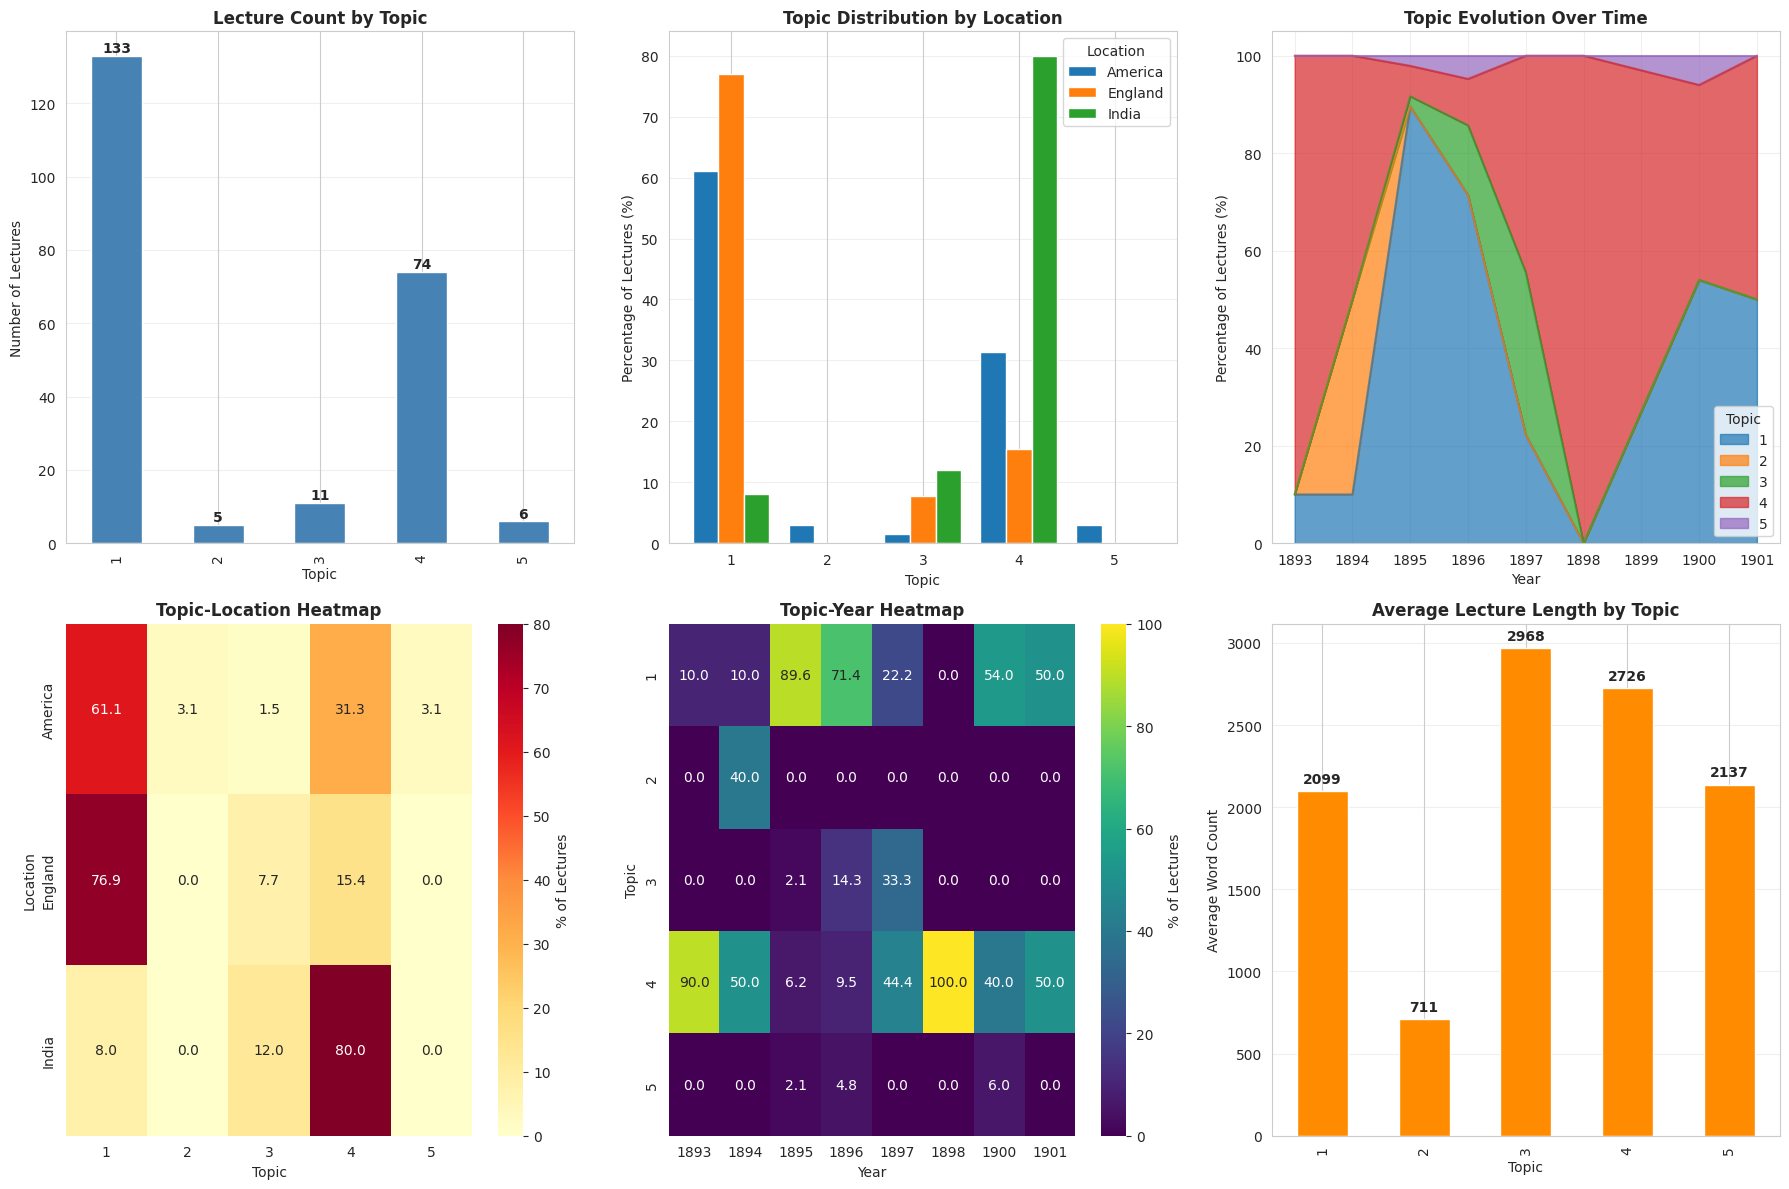


NOW: Based on the words and patterns, suggest names for these 5 topics

Review the top 30 words for each topic, the sample lectures, and distributions.
Then provide suggested names for:

Topic 1: _____________________
Topic 2: _____________________
Topic 3: _____________________
Topic 4: _____________________
Topic 5: _____________________


✓ 5-topic modeling complete - ready for naming


In [7]:
# ============================================================================
# RE-RUN TOPIC MODELING WITH 5 TOPICS (LECTURES ONLY)
# ============================================================================

print("="*80)
print("TOPIC MODELING: 5 TOPICS FOR LECTURES ONLY")
print("="*80)

# Prepare lectures documents
df_lectures_all = df[df['genre'] == 'Lectures'].copy()
df_lectures_all = df_lectures_all[df_lectures_all['word_count_clean'] >= 100].copy()

lectures_documents = df_lectures_all['plaintext_clean'].tolist()

print(f"\nTotal lectures for modeling: {len(lectures_documents)}")

# Count Vectorizer for LDA
vectorizer_5 = CountVectorizer(
    max_features=3000,
    min_df=3,  # Must appear in at least 3 lectures
    max_df=0.6,  # Ignore very common terms
    ngram_range=(1, 2),  # Unigrams and bigrams
    stop_words='english',
    token_pattern=r'(?u)\b[A-Za-z][A-Za-z]+\b'
)

doc_term_matrix_5 = vectorizer_5.fit_transform(lectures_documents)
feature_names_5 = vectorizer_5.get_feature_names_out()

print(f"\nFitting LDA with 5 topics on {len(lectures_documents)} lectures...")
print("This may take 1-2 minutes...")

# Fit LDA with 5 topics
n_topics_5 = 5
lda_5 = LatentDirichletAllocation(
    n_components=n_topics_5,
    max_iter=50,
    learning_method='online',
    random_state=42,
    n_jobs=-1
)

doc_topic_dist_5 = lda_5.fit_transform(doc_term_matrix_5)

print("✓ LDA fitting complete\n")

# ============================================================================
# DISPLAY TOPICS WITH TOP 30 WORDS
# ============================================================================

print("="*80)
print("DISCOVERED TOPICS (Top 30 words per topic)")
print("="*80)

topics_words = {}
for topic_idx, topic in enumerate(lda_5.components_):
    top_words_idx = topic.argsort()[-30:][::-1]
    top_words = [feature_names_5[i] for i in top_words_idx]
    topics_words[topic_idx + 1] = top_words

    print(f"\n{'-'*80}")
    print(f"TOPIC {topic_idx + 1}:")
    print(f"{'-'*80}")
    print(' | '.join(top_words))

# Assign dominant topic to each lecture
df_lectures_all['dominant_topic_5'] = doc_topic_dist_5.argmax(axis=1) + 1
df_lectures_all['topic_probability'] = doc_topic_dist_5.max(axis=1)

# ============================================================================
# TOPIC DISTRIBUTION OVERALL
# ============================================================================

print("\n" + "="*80)
print("TOPIC DISTRIBUTION ACROSS ALL LECTURES")
print("="*80)

topic_counts = df_lectures_all['dominant_topic_5'].value_counts().sort_index()
print("\nNumber of lectures per topic:")
for topic, count in topic_counts.items():
    pct = (count / len(df_lectures_all)) * 100
    print(f"  Topic {topic}: {count:3d} lectures ({pct:.1f}%)")

# ============================================================================
# TOPIC DISTRIBUTION BY LOCATION
# ============================================================================

print("\n" + "="*80)
print("TOPIC DISTRIBUTION BY LOCATION")
print("="*80)

# Add location info
df_lectures_all['main_location'] = df_lectures_all['Place'].apply(lambda x:
    'America' if pd.notna(x) and any(place in str(x) for place in ['America', 'USA', 'New York', 'Chicago', 'Detroit', 'Boston', 'California']) else
    'India' if pd.notna(x) and any(place in str(x) for place in ['India', 'Calcutta', 'Madras', 'Almora', 'Himalaya', 'Belur']) else
    'England' if pd.notna(x) and any(place in str(x) for place in ['England', 'London']) else
    'Unknown'
)

df_lectures_located_5 = df_lectures_all[df_lectures_all['main_location'].isin(['America', 'India', 'England'])].copy()

topic_by_location_5 = pd.crosstab(
    df_lectures_located_5['main_location'],
    df_lectures_located_5['dominant_topic_5'],
    normalize='index'
) * 100

print("\nTopic Distribution by Location (% of lectures):")
print(topic_by_location_5.round(1).to_string())

# Raw counts
topic_by_location_counts = pd.crosstab(
    df_lectures_located_5['main_location'],
    df_lectures_located_5['dominant_topic_5']
)

print("\nRaw counts:")
print(topic_by_location_counts.to_string())

# ============================================================================
# TOPIC DISTRIBUTION BY YEAR
# ============================================================================

print("\n" + "="*80)
print("TOPIC DISTRIBUTION BY YEAR")
print("="*80)

df_lectures_dated_5 = df_lectures_all[df_lectures_all['year'].notna()].copy()
df_lectures_dated_5 = df_lectures_dated_5[df_lectures_dated_5['year'] >= 1893].copy()

topic_by_year_5 = pd.crosstab(
    df_lectures_dated_5['year'].astype(int),
    df_lectures_dated_5['dominant_topic_5'],
    normalize='index'
) * 100

print("\nTopic Distribution by Year (% of lectures):")
print(topic_by_year_5.round(1).to_string())

# Raw counts
topic_by_year_counts = pd.crosstab(
    df_lectures_dated_5['year'].astype(int),
    df_lectures_dated_5['dominant_topic_5']
)

print("\nRaw counts:")
print(topic_by_year_counts.to_string())

# ============================================================================
# SAMPLE LECTURES FROM EACH TOPIC
# ============================================================================

print("\n" + "="*80)
print("SAMPLE LECTURES FROM EACH TOPIC (Highest probability)")
print("="*80)

for topic_num in range(1, 6):
    print(f"\n{'-'*80}")
    print(f"TOPIC {topic_num} - SAMPLE LECTURES:")
    print(f"{'-'*80}")

    topic_lectures = df_lectures_all[df_lectures_all['dominant_topic_5'] == topic_num].copy()
    topic_lectures = topic_lectures.sort_values('topic_probability', ascending=False)

    for i, (idx, row) in enumerate(topic_lectures.head(5).iterrows(), 1):
        print(f"\n{i}. {row['Name'][:70]}")
        print(f"   Year: {row['year']}, Place: {row['Place'][:40] if pd.notna(row['Place']) else 'Unknown'}")
        print(f"   Words: {row['word_count_clean']}, Topic prob: {row['topic_probability']:.3f}")

# ============================================================================
# TOPIC CHARACTERISTICS
# ============================================================================

print("\n" + "="*80)
print("TOPIC CHARACTERISTICS")
print("="*80)

for topic_num in range(1, 6):
    topic_lectures = df_lectures_all[df_lectures_all['dominant_topic_5'] == topic_num].copy()

    print(f"\n{'-'*80}")
    print(f"TOPIC {topic_num}:")
    print(f"{'-'*80}")
    print(f"Number of lectures: {len(topic_lectures)}")
    print(f"Average length: {topic_lectures['word_count_clean'].mean():.0f} words")
    print(f"Median length: {topic_lectures['word_count_clean'].median():.0f} words")

    # Location distribution
    loc_dist = topic_lectures['main_location'].value_counts()
    print(f"\nLocation distribution:")
    for loc, count in loc_dist.items():
        print(f"  {loc}: {count} lectures")

    # Year distribution
    year_dist = topic_lectures[topic_lectures['year'].notna()]['year'].astype(int).value_counts().sort_index()
    if len(year_dist) > 0:
        print(f"\nYear range: {year_dist.index.min()}-{year_dist.index.max()}")
        print(f"Peak years: {', '.join([str(y) for y in year_dist.nlargest(3).index.tolist()])}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS...")
print("="*80)

fig = plt.figure(figsize=(18, 12))

# 1. Topic distribution overall
ax1 = plt.subplot(2, 3, 1)
topic_counts.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Lecture Count by Topic', fontsize=12, fontweight='bold')
ax1.set_xlabel('Topic')
ax1.set_ylabel('Number of Lectures')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(topic_counts.values):
    ax1.text(i, v + 1, str(v), ha='center', fontweight='bold')

# 2. Topic by location (stacked bar)
ax2 = plt.subplot(2, 3, 2)
topic_by_location_5.T.plot(kind='bar', ax=ax2, stacked=False, width=0.8)
ax2.set_title('Topic Distribution by Location', fontsize=12, fontweight='bold')
ax2.set_xlabel('Topic')
ax2.set_ylabel('Percentage of Lectures (%)')
ax2.legend(title='Location', loc='best')
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0)

# 3. Topic by year (stacked area)
ax3 = plt.subplot(2, 3, 3)
topic_by_year_5.plot(kind='area', ax=ax3, alpha=0.7, stacked=True)
ax3.set_title('Topic Evolution Over Time', fontsize=12, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Percentage of Lectures (%)')
ax3.legend(title='Topic', loc='best')
ax3.grid(alpha=0.3)

# 4. Heatmap: Topics by location
ax4 = plt.subplot(2, 3, 4)
sns.heatmap(topic_by_location_5, annot=True, fmt='.1f', cmap='YlOrRd',
            cbar_kws={'label': '% of Lectures'}, ax=ax4)
ax4.set_title('Topic-Location Heatmap', fontsize=12, fontweight='bold')
ax4.set_xlabel('Topic')
ax4.set_ylabel('Location')

# 5. Heatmap: Topics by year
ax5 = plt.subplot(2, 3, 5)
sns.heatmap(topic_by_year_5.T, annot=True, fmt='.1f', cmap='viridis',
            cbar_kws={'label': '% of Lectures'}, ax=ax5)
ax5.set_title('Topic-Year Heatmap', fontsize=12, fontweight='bold')
ax5.set_xlabel('Year')
ax5.set_ylabel('Topic')

# 6. Average lecture length by topic
ax6 = plt.subplot(2, 3, 6)
avg_lengths = df_lectures_all.groupby('dominant_topic_5')['word_count_clean'].mean()
avg_lengths.plot(kind='bar', ax=ax6, color='darkorange')
ax6.set_title('Average Lecture Length by Topic', fontsize=12, fontweight='bold')
ax6.set_xlabel('Topic')
ax6.set_ylabel('Average Word Count')
ax6.grid(axis='y', alpha=0.3)
for i, v in enumerate(avg_lengths.values):
    ax6.text(i, v + 50, f'{v:.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("NOW: Based on the words and patterns, suggest names for these 5 topics")
print("="*80)

print("""
Review the top 30 words for each topic, the sample lectures, and distributions.
Then provide suggested names for:

Topic 1: _____________________
Topic 2: _____________________
Topic 3: _____________________
Topic 4: _____________________
Topic 5: _____________________
""")

print("\n" + "="*80)
print("✓ 5-topic modeling complete - ready for naming")
print("="*80)

NAMING TOPICS AND CREATING ENHANCED VISUALIZATIONS

Topic Names Assigned:
  Topic 1: Vedantic Metaphysics           (133 lectures, 58.1%)
  Topic 2: Comparative Religion           (  5 lectures, 2.2%)
  Topic 3: Bhakti & Devotion              ( 11 lectures, 4.8%)
  Topic 4: Indian Culture & Nationalism   ( 74 lectures, 32.3%)
  Topic 5: Raja Yoga Practice             (  6 lectures, 2.6%)

TOPIC DISTRIBUTION BY LOCATION (WITH NAMES)

Percentage of lectures:
topic_name     Vedantic Metaphysics  Comparative Religion  Bhakti & Devotion  Indian Culture & Nationalism  Raja Yoga Practice
main_location                                                                                                                 
America                        61.1                   3.1                1.5                          31.3                 3.1
England                        76.9                   0.0                7.7                          15.4                 0.0
India                          

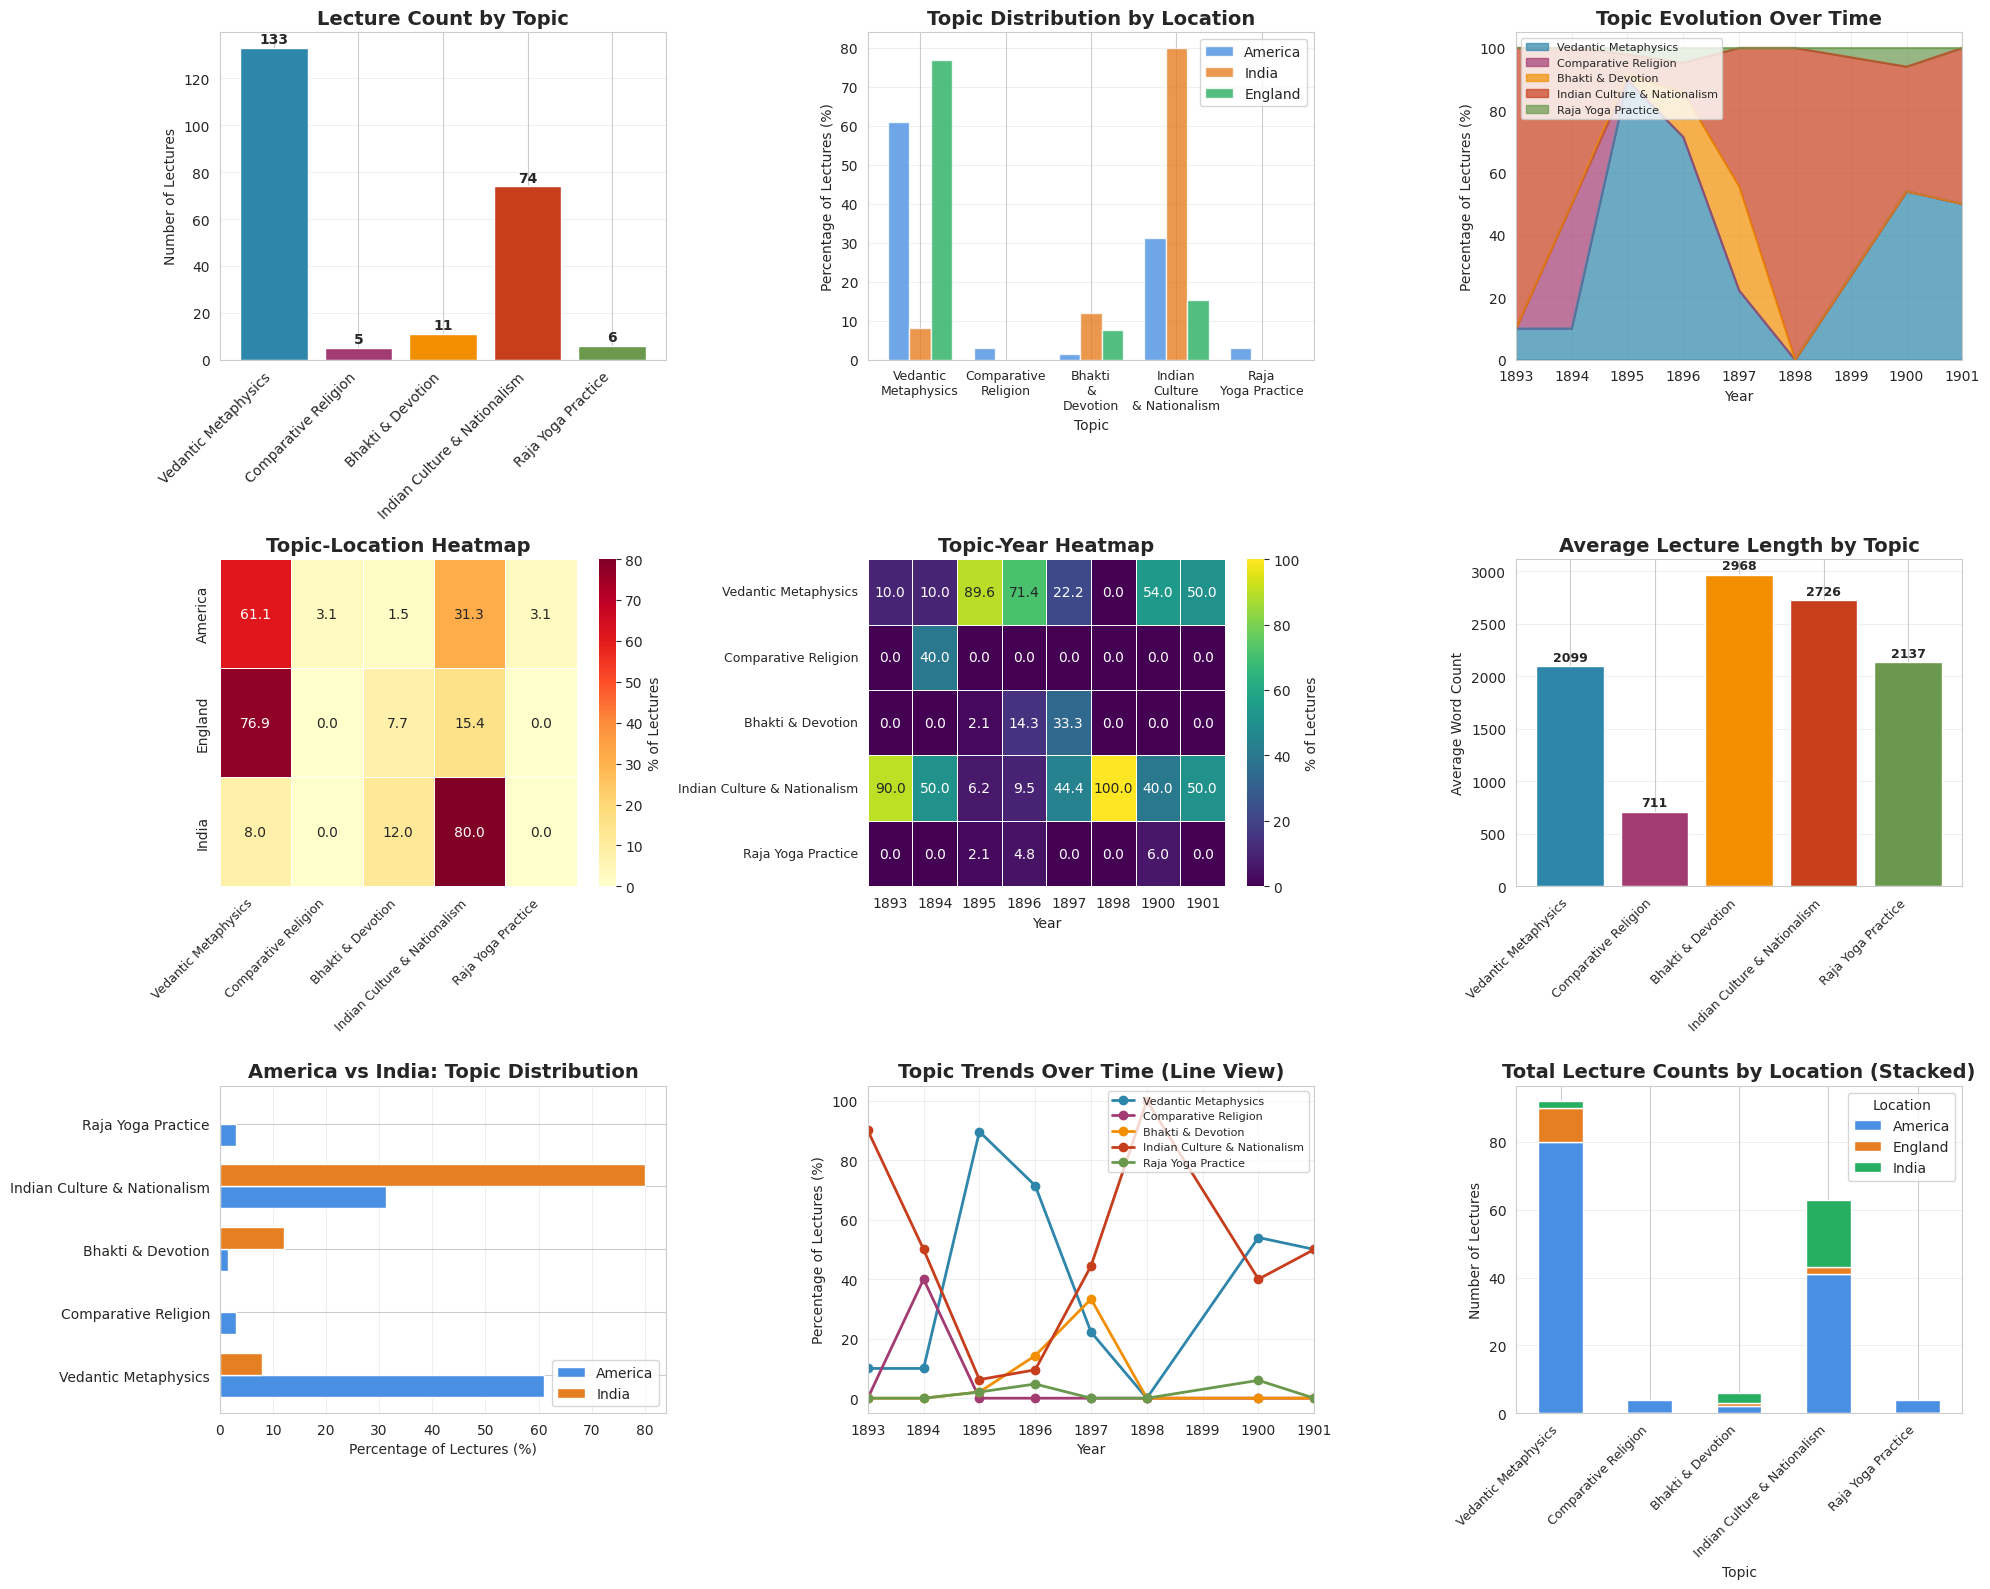


SUMMARY: KEY PATTERNS WITH TOPIC NAMES

1. DOMINANT TOPICS BY LOCATION:
--------------------------------------------------------------------------------

America:
  1. Vedantic Metaphysics          :  61.1% (80 lectures)
  2. Indian Culture & Nationalism  :  31.3% (41 lectures)
  3. Comparative Religion          :   3.1% ( 4 lectures)

India:
  1. Indian Culture & Nationalism  :  80.0% (20 lectures)
  2. Bhakti & Devotion             :  12.0% ( 3 lectures)
  3. Vedantic Metaphysics          :   8.0% ( 2 lectures)

England:
  1. Vedantic Metaphysics          :  76.9% (10 lectures)
  2. Indian Culture & Nationalism  :  15.4% ( 2 lectures)
  3. Bhakti & Devotion             :   7.7% ( 1 lectures)


2. TOPIC EVOLUTION - YEAR BY YEAR:
--------------------------------------------------------------------------------

1893:
  Indian Culture & Nationalism (90%, n=9) | Vedantic Metaphysics (10%, n=1)

1894:
  Indian Culture & Nationalism (50%, n=5) | Comparative Religion (40%, n=4) | Vedantic M

In [8]:
# ============================================================================
# NAME TOPICS AND REMAKE ALL VISUALIZATIONS
# ============================================================================

print("="*80)
print("NAMING TOPICS AND CREATING ENHANCED VISUALIZATIONS")
print("="*80)

# Define topic names
topic_names = {
    1: "Vedantic Metaphysics",
    2: "Comparative Religion",
    3: "Bhakti & Devotion",
    4: "Indian Culture & Nationalism",
    5: "Raja Yoga Practice"
}

# Add named topics to dataframe
df_lectures_all['topic_name'] = df_lectures_all['dominant_topic_5'].map(topic_names)

print("\nTopic Names Assigned:")
for num, name in topic_names.items():
    count = len(df_lectures_all[df_lectures_all['dominant_topic_5']==num])
    pct = (count / len(df_lectures_all)) * 100
    print(f"  Topic {num}: {name:30s} ({count:3d} lectures, {pct:.1f}%)")

# ============================================================================
# RECREATE ALL TABLES WITH NAMED TOPICS
# ============================================================================

print("\n" + "="*80)
print("TOPIC DISTRIBUTION BY LOCATION (WITH NAMES)")
print("="*80)

# Reorder dataframe for better display
df_lectures_located_named = df_lectures_all[df_lectures_all['main_location'].isin(['America', 'India', 'England'])].copy()

# Create crosstab with percentages
topic_by_location_named = pd.crosstab(
    df_lectures_located_named['main_location'],
    df_lectures_located_named['topic_name'],
    normalize='index'
) * 100

# Reorder columns by topic number
topic_order = [topic_names[i] for i in [1, 2, 3, 4, 5]]
topic_by_location_named = topic_by_location_named[topic_order]

print("\nPercentage of lectures:")
print(topic_by_location_named.round(1).to_string())

# Raw counts
topic_by_location_counts_named = pd.crosstab(
    df_lectures_located_named['main_location'],
    df_lectures_located_named['topic_name']
)[topic_order]

print("\nRaw counts:")
print(topic_by_location_counts_named.to_string())

# ============================================================================
# TOPIC DISTRIBUTION BY YEAR (WITH NAMES)
# ============================================================================

print("\n" + "="*80)
print("TOPIC DISTRIBUTION BY YEAR (WITH NAMES)")
print("="*80)

df_lectures_dated_named = df_lectures_all[df_lectures_all['year'].notna()].copy()
df_lectures_dated_named = df_lectures_dated_named[df_lectures_dated_named['year'] >= 1893].copy()

topic_by_year_named = pd.crosstab(
    df_lectures_dated_named['year'].astype(int),
    df_lectures_dated_named['topic_name'],
    normalize='index'
) * 100

topic_by_year_named = topic_by_year_named[topic_order]

print("\nPercentage of lectures:")
print(topic_by_year_named.round(1).to_string())

# Raw counts
topic_by_year_counts_named = pd.crosstab(
    df_lectures_dated_named['year'].astype(int),
    df_lectures_dated_named['topic_name']
)[topic_order]

print("\nRaw counts:")
print(topic_by_year_counts_named.to_string())

# ============================================================================
# COMPREHENSIVE VISUALIZATIONS WITH TOPIC NAMES
# ============================================================================

print("\n" + "="*80)
print("GENERATING ENHANCED VISUALIZATIONS WITH TOPIC NAMES...")
print("="*80)

# Color scheme for topics
topic_colors = {
    'Vedantic Metaphysics': '#2E86AB',  # Blue
    'Comparative Religion': '#A23B72',   # Purple
    'Bhakti & Devotion': '#F18F01',      # Orange
    'Indian Culture & Nationalism': '#C73E1D',  # Red
    'Raja Yoga Practice': '#6A994E'      # Green
}

fig = plt.figure(figsize=(20, 16))

# 1. Overall topic distribution
ax1 = plt.subplot(3, 3, 1)
topic_counts_named = df_lectures_all['topic_name'].value_counts()[topic_order]
colors_1 = [topic_colors[name] for name in topic_counts_named.index]
bars1 = ax1.bar(range(len(topic_counts_named)), topic_counts_named.values, color=colors_1)
ax1.set_xticks(range(len(topic_counts_named)))
ax1.set_xticklabels(topic_counts_named.index, rotation=45, ha='right')
ax1.set_title('Lecture Count by Topic', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Lectures')
ax1.grid(axis='y', alpha=0.3)
for i, (bar, v) in enumerate(zip(bars1, topic_counts_named.values)):
    ax1.text(bar.get_x() + bar.get_width()/2, v + 2, str(v),
            ha='center', fontweight='bold', fontsize=10)

# 2. Topic distribution by location (grouped bar)
ax2 = plt.subplot(3, 3, 2)
x = np.arange(len(topic_order))
width = 0.25
locations = ['America', 'India', 'England']
location_colors_map = {'America': '#4A90E2', 'India': '#E67E22', 'England': '#27AE60'}

for i, loc in enumerate(locations):
    values = topic_by_location_named.loc[loc].values
    ax2.bar(x + i*width, values, width, label=loc, color=location_colors_map[loc], alpha=0.8)

ax2.set_xlabel('Topic')
ax2.set_ylabel('Percentage of Lectures (%)')
ax2.set_title('Topic Distribution by Location', fontsize=14, fontweight='bold')
ax2.set_xticks(x + width)
ax2.set_xticklabels([name.replace(' & ', '\n& ').replace(' ', '\n', 1) for name in topic_order],
                     fontsize=9)
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)

# 3. Topic evolution over time (area chart)
ax3 = plt.subplot(3, 3, 3)
colors_area = [topic_colors[name] for name in topic_order]
topic_by_year_named.plot(kind='area', ax=ax3, color=colors_area, alpha=0.7, stacked=True)
ax3.set_title('Topic Evolution Over Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Percentage of Lectures (%)')
ax3.legend(loc='upper left', fontsize=8)
ax3.grid(alpha=0.3)
ax3.set_xlim(1893, 1901)

# 4. Heatmap: Topics by location
ax4 = plt.subplot(3, 3, 4)
sns.heatmap(topic_by_location_named, annot=True, fmt='.1f', cmap='YlOrRd',
            cbar_kws={'label': '% of Lectures'}, ax=ax4, linewidths=0.5)
ax4.set_title('Topic-Location Heatmap', fontsize=14, fontweight='bold')
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right', fontsize=9)

# 5. Heatmap: Topics by year
ax5 = plt.subplot(3, 3, 5)
sns.heatmap(topic_by_year_named.T, annot=True, fmt='.1f', cmap='viridis',
            cbar_kws={'label': '% of Lectures'}, ax=ax5, linewidths=0.5)
ax5.set_title('Topic-Year Heatmap', fontsize=14, fontweight='bold')
ax5.set_xlabel('Year')
ax5.set_ylabel('')
ax5.set_yticklabels(ax5.get_yticklabels(), rotation=0, fontsize=9)

# 6. Average lecture length by topic
ax6 = plt.subplot(3, 3, 6)
avg_lengths_named = df_lectures_all.groupby('topic_name')['word_count_clean'].mean()[topic_order]
colors_6 = [topic_colors[name] for name in avg_lengths_named.index]
bars6 = ax6.bar(range(len(avg_lengths_named)), avg_lengths_named.values, color=colors_6)
ax6.set_xticks(range(len(avg_lengths_named)))
ax6.set_xticklabels(avg_lengths_named.index, rotation=45, ha='right', fontsize=9)
ax6.set_title('Average Lecture Length by Topic', fontsize=14, fontweight='bold')
ax6.set_ylabel('Average Word Count')
ax6.grid(axis='y', alpha=0.3)
for bar, v in zip(bars6, avg_lengths_named.values):
    ax6.text(bar.get_x() + bar.get_width()/2, v + 50, f'{v:.0f}',
            ha='center', fontweight='bold', fontsize=9)

# 7. Topic distribution: America vs India comparison
ax7 = plt.subplot(3, 3, 7)
comparison_data = topic_by_location_named.loc[['America', 'India']].T
comparison_data.plot(kind='barh', ax=ax7, color=['#4A90E2', '#E67E22'], width=0.7)
ax7.set_title('America vs India: Topic Distribution', fontsize=14, fontweight='bold')
ax7.set_xlabel('Percentage of Lectures (%)')
ax7.set_ylabel('')
ax7.legend(loc='lower right')
ax7.grid(axis='x', alpha=0.3)

# 8. Topic evolution line chart (clearer than area)
ax8 = plt.subplot(3, 3, 8)
for topic in topic_order:
    color = topic_colors[topic]
    values = topic_by_year_named[topic]
    ax8.plot(values.index, values.values, marker='o', linewidth=2,
            label=topic, color=color, markersize=6)
ax8.set_title('Topic Trends Over Time (Line View)', fontsize=14, fontweight='bold')
ax8.set_xlabel('Year')
ax8.set_ylabel('Percentage of Lectures (%)')
ax8.legend(loc='best', fontsize=8)
ax8.grid(alpha=0.3)
ax8.set_xlim(1893, 1901)
ax8.set_xticks(range(1893, 1902))

# 9. Stacked bar: Raw counts by location
ax9 = plt.subplot(3, 3, 9)
topic_by_location_counts_named.T.plot(kind='bar', stacked=True, ax=ax9,
                                       color=[location_colors_map[loc] for loc in locations])
ax9.set_title('Total Lecture Counts by Location (Stacked)', fontsize=14, fontweight='bold')
ax9.set_xlabel('Topic')
ax9.set_ylabel('Number of Lectures')
ax9.set_xticklabels(ax9.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax9.legend(title='Location', loc='upper right')
ax9.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY STATISTICS WITH NAMES
# ============================================================================

print("\n" + "="*80)
print("SUMMARY: KEY PATTERNS WITH TOPIC NAMES")
print("="*80)

print("\n1. DOMINANT TOPICS BY LOCATION:")
print("-" * 80)
for loc in ['America', 'India', 'England']:
    print(f"\n{loc}:")
    loc_dist = topic_by_location_named.loc[loc].sort_values(ascending=False)
    for i, (topic, pct) in enumerate(loc_dist.head(3).items(), 1):
        count = topic_by_location_counts_named.loc[loc, topic]
        print(f"  {i}. {topic:30s}: {pct:5.1f}% ({count:2d} lectures)")

print("\n\n2. TOPIC EVOLUTION - YEAR BY YEAR:")
print("-" * 80)
for year in sorted(topic_by_year_named.index):
    print(f"\n{int(year)}:")
    year_dist = topic_by_year_named.loc[year].sort_values(ascending=False)
    top_topics = []
    for topic, pct in year_dist.items():
        if pct > 0:
            count = topic_by_year_counts_named.loc[year, topic]
            top_topics.append(f"{topic} ({pct:.0f}%, n={count})")
    print("  " + " | ".join(top_topics))

print("\n\n3. CROSS-LOCATION COMPARISONS:")
print("-" * 80)

# Vedantic Metaphysics: America vs England
print("\nVedantic Metaphysics:")
print(f"  America: {topic_by_location_named.loc['America', 'Vedantic Metaphysics']:.1f}% "
      f"({topic_by_location_counts_named.loc['America', 'Vedantic Metaphysics']} lectures)")
print(f"  England: {topic_by_location_named.loc['England', 'Vedantic Metaphysics']:.1f}% "
      f"({topic_by_location_counts_named.loc['England', 'Vedantic Metaphysics']} lectures)")
print(f"  India:   {topic_by_location_named.loc['India', 'Vedantic Metaphysics']:.1f}% "
      f"({topic_by_location_counts_named.loc['India', 'Vedantic Metaphysics']} lectures)")

# Indian Culture & Nationalism
print("\nIndian Culture & Nationalism:")
print(f"  India:   {topic_by_location_named.loc['India', 'Indian Culture & Nationalism']:.1f}% "
      f"({topic_by_location_counts_named.loc['India', 'Indian Culture & Nationalism']} lectures)")
print(f"  America: {topic_by_location_named.loc['America', 'Indian Culture & Nationalism']:.1f}% "
      f"({topic_by_location_counts_named.loc['America', 'Indian Culture & Nationalism']} lectures)")
print(f"  England: {topic_by_location_named.loc['England', 'Indian Culture & Nationalism']:.1f}% "
      f"({topic_by_location_counts_named.loc['England', 'Indian Culture & Nationalism']} lectures)")

print("\n\n4. TEMPORAL HIGHLIGHTS:")
print("-" * 80)
print(f"\n1894: Comparative Religion dominates (40% of lectures)")
print(f"      Only year this topic appears significantly")
print(f"\n1895: Vedantic Metaphysics peaks (89.6% of lectures)")
print(f"      American philosophical teaching at its height")
print(f"\n1896-1897: Bhakti & Devotion emerges (14.3% and 33.3%)")
print(f"           Bhakti Yoga lecture series period")
print(f"\n1900: Balanced distribution during India tour")
print(f"      Indian Culture & Nationalism (40%) + Vedantic Metaphysics (54%)")

print("\n" + "="*80)
print("✓ Topic naming and enhanced visualizations complete")
print("="*80)

OUTLIER ANALYSIS: INDIAN NATIONALISM LECTURES IN AMERICA

Total 'Indian Culture & Nationalism' lectures in America: 41
Out of 131 total America lectures
Percentage: 31.3%

ALL NATIONALIST LECTURES IN AMERICA (Sorted by topic strength)

--------------------------------------------------------------------------------
1. The Mahabharata
--------------------------------------------------------------------------------
Year:             1900
Place:            USA, CA, Pasadena, Shakespeare Club
Audience:         Unknown
Source:           Unknown
Word Count:       8016
Topic Strength:   1.000

Opening text:
  The other epic about which I am going to speak to you this
evening, is called the Mahâbhârata. It contains the story of a race
descended from King Bharata, who was the son of Dushyanta and
Shakuntalâ. Mahâ means great, and Bhârata means the descendants of
Bharata, from whom India has derived its nam...

--------------------------------------------------------------------------------
2. W

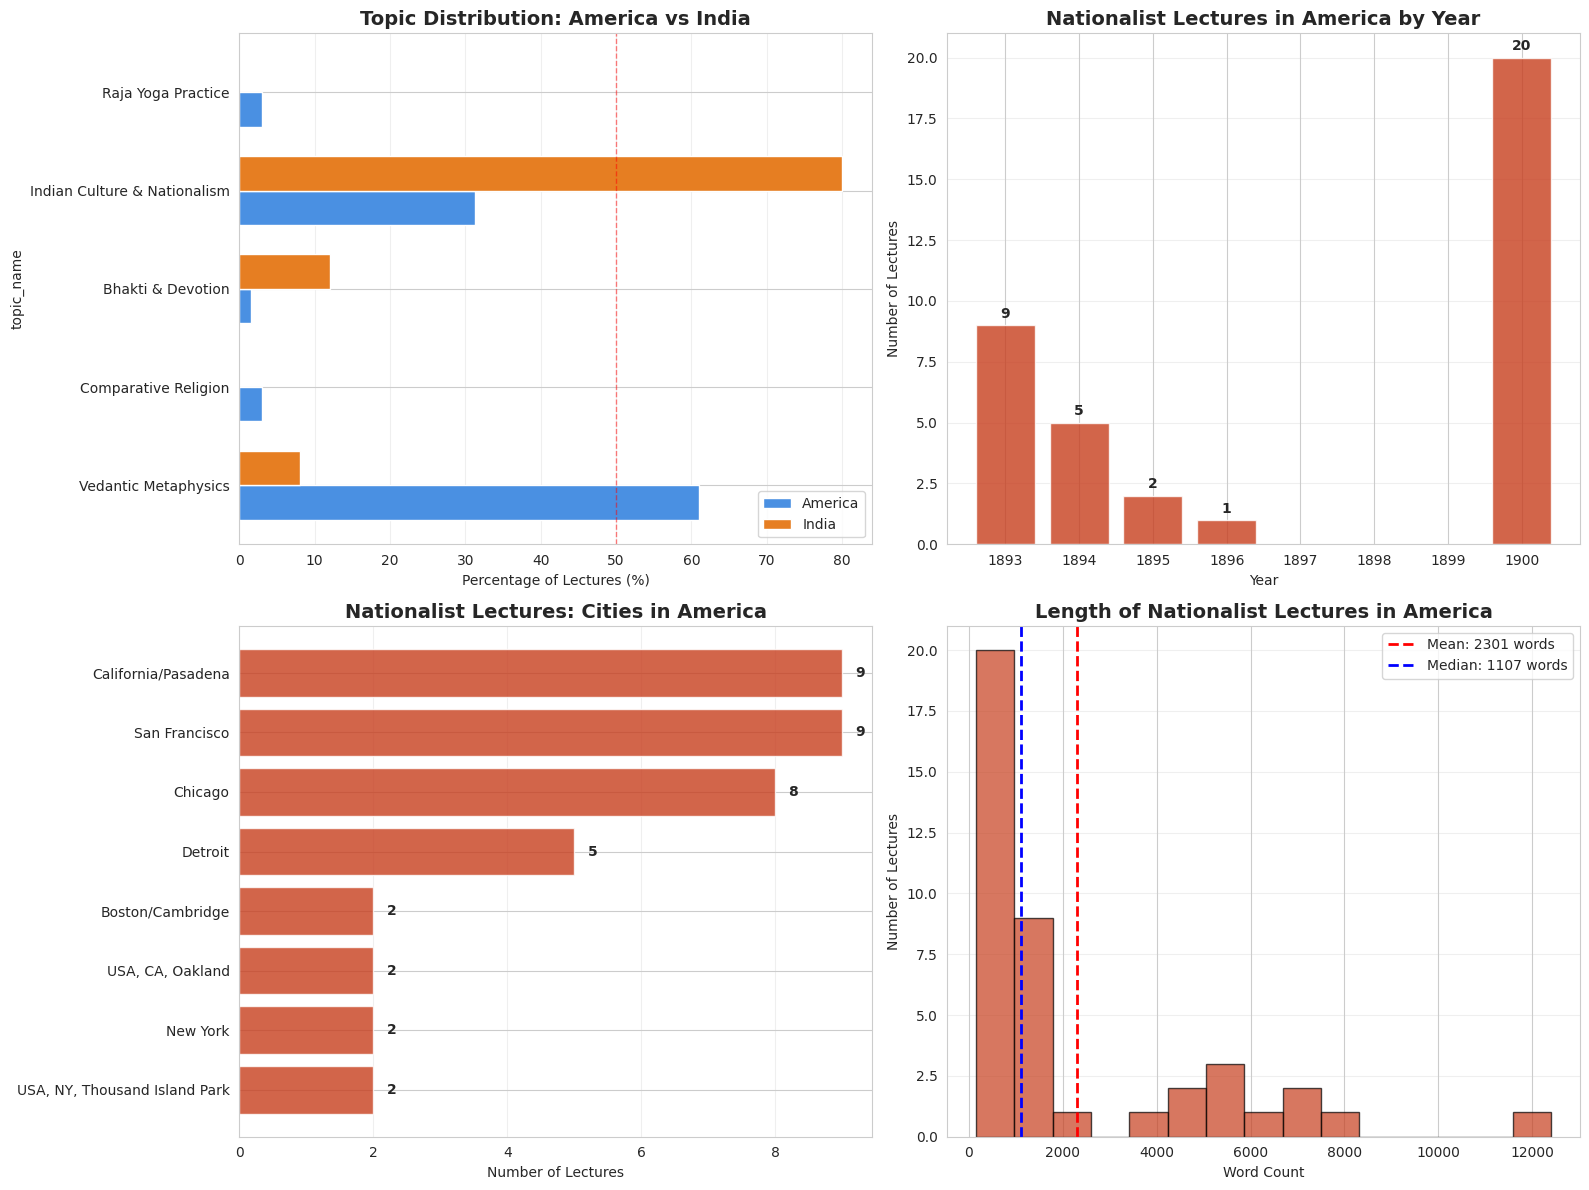


✓ Outlier analysis complete


In [9]:
# ============================================================================
# OUTLIER ANALYSIS: NATIONALIST LECTURES IN AMERICA
# ============================================================================

print("="*80)
print("OUTLIER ANALYSIS: INDIAN NATIONALISM LECTURES IN AMERICA")
print("="*80)

# Filter for America + Indian Culture & Nationalism topic
america_nationalism = df_lectures_all[
    (df_lectures_all['main_location'] == 'America') &
    (df_lectures_all['topic_name'] == 'Indian Culture & Nationalism')
].copy()

print(f"\nTotal 'Indian Culture & Nationalism' lectures in America: {len(america_nationalism)}")
print(f"Out of {len(df_lectures_all[df_lectures_all['main_location']=='America'])} total America lectures")
print(f"Percentage: {(len(america_nationalism) / len(df_lectures_all[df_lectures_all['main_location']=='America'])) * 100:.1f}%\n")

# Sort by topic probability (most characteristic examples first)
america_nationalism = america_nationalism.sort_values('topic_probability', ascending=False)

print("="*80)
print("ALL NATIONALIST LECTURES IN AMERICA (Sorted by topic strength)")
print("="*80)

for i, (idx, row) in enumerate(america_nationalism.iterrows(), 1):
    print(f"\n{'-'*80}")
    print(f"{i}. {row['Name']}")
    print(f"{'-'*80}")
    print(f"Year:             {int(row['year']) if pd.notna(row['year']) else 'Unknown'}")
    print(f"Place:            {row['Place'] if pd.notna(row['Place']) else 'Unknown'}")
    print(f"Audience:         {row['Audience'] if pd.notna(row['Audience']) else 'Unknown'}")
    print(f"Source:           {row['Source'] if pd.notna(row['Source']) else 'Unknown'}")
    print(f"Word Count:       {row['word_count_clean']}")
    print(f"Topic Strength:   {row['topic_probability']:.3f}")

    # Show first 200 characters of text to get flavor
    text_preview = row['plaintext_clean'][:300] if pd.notna(row['plaintext_clean']) else ""
    if text_preview:
        print(f"\nOpening text:")
        print(f"  {text_preview}...")

# ============================================================================
# YEAR DISTRIBUTION
# ============================================================================

print("\n\n" + "="*80)
print("YEAR DISTRIBUTION OF NATIONALIST LECTURES IN AMERICA")
print("="*80)

year_dist = america_nationalism[america_nationalism['year'].notna()]['year'].astype(int).value_counts().sort_index()
print("\nLectures by year:")
for year, count in year_dist.items():
    print(f"  {year}: {count} lectures")

# ============================================================================
# AUDIENCE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("AUDIENCE ANALYSIS")
print("="*80)

audience_dist = america_nationalism['Audience'].value_counts()
print("\nAudiences (when recorded):")
for aud, count in audience_dist.items():
    if pd.notna(aud):
        print(f"  {aud}: {count} lectures")

unknown_audience = america_nationalism['Audience'].isna().sum()
print(f"\nUnknown/Not recorded: {unknown_audience} lectures")

# ============================================================================
# LOCATION BREAKDOWN
# ============================================================================

print("\n" + "="*80)
print("LOCATION BREAKDOWN (Cities in America)")
print("="*80)

# Extract city from Place field
def extract_city(place):
    if pd.isna(place):
        return 'Unknown'
    place = str(place)
    # Try to extract city name
    if 'New York' in place:
        return 'New York'
    elif 'Pasadena' in place or 'Los Angeles' in place:
        return 'California/Pasadena'
    elif 'Detroit' in place:
        return 'Detroit'
    elif 'Chicago' in place:
        return 'Chicago'
    elif 'Boston' in place or 'Cambridge' in place:
        return 'Boston/Cambridge'
    elif 'San Francisco' in place:
        return 'San Francisco'
    else:
        return place

america_nationalism['city'] = america_nationalism['Place'].apply(extract_city)
city_dist = america_nationalism['city'].value_counts()

print("\nLectures by city:")
for city, count in city_dist.items():
    print(f"  {city}: {count} lectures")

# ============================================================================
# COMPARISON: WHAT TOPICS DID HE GIVE IN INDIA?
# ============================================================================

print("\n\n" + "="*80)
print("COMPARISON: WHAT TOPICS DID HE LECTURE ON IN INDIA?")
print("="*80)

india_lectures = df_lectures_all[df_lectures_all['main_location'] == 'India'].copy()
india_topic_dist = india_lectures['topic_name'].value_counts()

print(f"\nTotal lectures in India: {len(india_lectures)}")
print("\nTopic distribution in India:")
for topic, count in india_topic_dist.items():
    pct = (count / len(india_lectures)) * 100
    print(f"  {topic:35s}: {count:2d} lectures ({pct:.1f}%)")

print("\n" + "-"*80)
print("OBSERVATION:")
print("-"*80)
print(f"In America: {len(america_nationalism)} out of {len(df_lectures_all[df_lectures_all['main_location']=='America'])} lectures (31.3%) on Indian Nationalism")
print(f"In India:   {india_topic_dist.get('Indian Culture & Nationalism', 0)} out of {len(india_lectures)} lectures (80.0%) on Indian Nationalism")

# ============================================================================
# SPECIFIC OUTLIER: VEDANTIC LECTURES IN INDIA
# ============================================================================

print("\n\n" + "="*80)
print("REVERSE OUTLIER: VEDANTIC METAPHYSICS LECTURES IN INDIA")
print("="*80)

india_vedanta = df_lectures_all[
    (df_lectures_all['main_location'] == 'India') &
    (df_lectures_all['topic_name'] == 'Vedantic Metaphysics')
].copy()

print(f"\nTotal 'Vedantic Metaphysics' lectures in India: {len(india_vedanta)}")
print(f"(Only {(len(india_vedanta) / len(india_lectures)) * 100:.1f}% of India lectures)")

if len(india_vedanta) > 0:
    print("\nThese rare Vedantic lectures in India:")
    for i, (idx, row) in enumerate(india_vedanta.iterrows(), 1):
        print(f"\n{i}. {row['Name']}")
        print(f"   Year: {int(row['year']) if pd.notna(row['year']) else 'Unknown'}")
        print(f"   Place: {row['Place'] if pd.notna(row['Place']) else 'Unknown'}")
        print(f"   Audience: {row['Audience'] if pd.notna(row['Audience']) else 'Unknown'}")
        print(f"   Words: {row['word_count_clean']}")

# ============================================================================
# VISUALIZE THE PATTERN
# ============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATION...")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Topic distribution: America vs India
ax1 = axes[0, 0]
comparison = pd.DataFrame({
    'America': topic_by_location_named.loc['America'],
    'India': topic_by_location_named.loc['India']
})
comparison.plot(kind='barh', ax=ax1, color=['#4A90E2', '#E67E22'], width=0.7)
ax1.set_title('Topic Distribution: America vs India', fontsize=14, fontweight='bold')
ax1.set_xlabel('Percentage of Lectures (%)')
ax1.legend(loc='lower right')
ax1.grid(axis='x', alpha=0.3)

# Add vertical line at 50% for reference
ax1.axvline(x=50, color='red', linestyle='--', alpha=0.5, linewidth=1)

# 2. Nationalist lectures in America over time
ax2 = axes[0, 1]
if len(year_dist) > 0:
    ax2.bar(year_dist.index, year_dist.values, color='#C73E1D', alpha=0.8)
    ax2.set_title('Nationalist Lectures in America by Year', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Number of Lectures')
    ax2.grid(axis='y', alpha=0.3)
    for year, count in year_dist.items():
        ax2.text(year, count + 0.3, str(count), ha='center', fontweight='bold')
else:
    ax2.text(0.5, 0.5, 'No year data available', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Nationalist Lectures in America by Year', fontsize=14, fontweight='bold')

# 3. City distribution
ax3 = axes[1, 0]
city_dist_plot = city_dist.head(8)  # Top 8 cities
ax3.barh(range(len(city_dist_plot)), city_dist_plot.values, color='#C73E1D', alpha=0.8)
ax3.set_yticks(range(len(city_dist_plot)))
ax3.set_yticklabels(city_dist_plot.index)
ax3.set_title('Nationalist Lectures: Cities in America', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Lectures')
ax3.grid(axis='x', alpha=0.3)
ax3.invert_yaxis()
for i, v in enumerate(city_dist_plot.values):
    ax3.text(v + 0.2, i, str(v), va='center', fontweight='bold')

# 4. Word count distribution
ax4 = axes[1, 1]
ax4.hist(america_nationalism['word_count_clean'], bins=15, color='#C73E1D', alpha=0.7, edgecolor='black')
ax4.axvline(america_nationalism['word_count_clean'].mean(), color='red', linestyle='--',
            linewidth=2, label=f"Mean: {america_nationalism['word_count_clean'].mean():.0f} words")
ax4.axvline(america_nationalism['word_count_clean'].median(), color='blue', linestyle='--',
            linewidth=2, label=f"Median: {america_nationalism['word_count_clean'].median():.0f} words")
ax4.set_title('Length of Nationalist Lectures in America', fontsize=14, fontweight='bold')
ax4.set_xlabel('Word Count')
ax4.set_ylabel('Number of Lectures')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ Outlier analysis complete")
print("="*80)

In [10]:
# ============================================================================
# SEMANTIC ANALYSIS: THREE HYPOTHESES - DATA-DRIVEN, NO HARDCODED LISTS
# ============================================================================

import spacy
from collections import defaultdict
from scipy.stats import chi2_contingency
import re

print("="*80)
print("SEMANTIC ANALYSIS: DISCOVERING PATTERNS WITHOUT HARDCODED ASSUMPTIONS")
print("="*80)

# Load spaCy for NER and dependency parsing
print("\nLoading spaCy model...")
try:
    nlp = spacy.load("en_core_web_sm")
    print("✓ spaCy loaded")
except:
    print("Installing spaCy model...")
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")
    print("✓ spaCy loaded")

# ============================================================================
# PREPARE DATASETS FOR THREE HYPOTHESES
# ============================================================================

print("\n" + "="*80)
print("PREPARING DATASETS")
print("="*80)

# Hypothesis 1: First visit (1893-1897) vs Second visit (1900) - Nationalist lectures in America
america_nationalism = df_lectures_all[
    (df_lectures_all['main_location'] == 'America') &
    (df_lectures_all['topic_name'] == 'Indian Culture & Nationalism')
].copy()

first_visit = america_nationalism[
    (america_nationalism['year'] >= 1893) &
    (america_nationalism['year'] <= 1897)
].copy()

second_visit = america_nationalism[
    america_nationalism['year'] == 1900
].copy()

print(f"\nHypothesis 1 - First vs Second Visit (America, Nationalist Lectures):")
print(f"  First visit (1893-1897): {len(first_visit)} lectures")
print(f"  Second visit (1900): {len(second_visit)} lectures")

# Hypothesis 2: America vs India - All nationalist lectures
america_nat_all = df_lectures_all[
    (df_lectures_all['main_location'] == 'America') &
    (df_lectures_all['topic_name'] == 'Indian Culture & Nationalism')
].copy()

india_nat_all = df_lectures_all[
    (df_lectures_all['main_location'] == 'India') &
    (df_lectures_all['topic_name'] == 'Indian Culture & Nationalism')
].copy()

print(f"\nHypothesis 2 - West vs India (Nationalist Lectures):")
print(f"  America nationalist lectures: {len(america_nat_all)} lectures")
print(f"  India nationalist lectures: {len(india_nat_all)} lectures")

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def extract_context_windows(text, target_terms, window_size=5):
    """
    Extract word windows around target terms.
    Returns list of (term, left_context, right_context) tuples
    """
    if pd.isna(text):
        return []

    words = word_tokenize(text.lower())
    contexts = []

    for i, word in enumerate(words):
        if any(term in word for term in target_terms):
            left_start = max(0, i - window_size)
            right_end = min(len(words), i + window_size + 1)

            left_context = words[left_start:i]
            right_context = words[i+1:right_end]

            contexts.append({
                'term': word,
                'left': left_context,
                'right': right_context,
                'full_window': left_context + [word] + right_context
            })

    return contexts

def extract_entities(text, entity_types=['PERSON']):
    """Extract named entities using spaCy"""
    if pd.isna(text) or len(text.strip()) == 0:
        return []

    # Limit text size for spaCy (it's slow on very long texts)
    if len(text) > 100000:
        text = text[:100000]

    doc = nlp(text)
    entities = []

    for ent in doc.ents:
        if ent.label_ in entity_types:
            entities.append({
                'text': ent.text,
                'label': ent.label_,
                'context': text[max(0, ent.start_char-50):min(len(text), ent.end_char+50)]
            })

    return entities

def get_surrounding_words(contexts, pos_to_extract=['ADJ', 'VERB', 'NOUN']):
    """Get POS-tagged words from contexts"""
    all_words = []
    for ctx in contexts:
        all_words.extend(ctx['left'])
        all_words.extend(ctx['right'])

    # POS tag
    text = ' '.join(all_words)
    doc = nlp(text)

    words_by_pos = defaultdict(list)
    for token in doc:
        if token.pos_ in pos_to_extract:
            words_by_pos[token.pos_].append(token.lemma_.lower())

    return words_by_pos

# ============================================================================
# HYPOTHESIS 1: FIRST VISIT VS SECOND VISIT - HOW DID FRAMING CHANGE?
# ============================================================================

print("\n" + "="*80)
print("HYPOTHESIS 1: FIRST VISIT (1893-1897) VS SECOND VISIT (1900)")
print("How did Swamiji's framing of India change between visits?")
print("="*80)

# Target terms about India
india_terms = ['india', 'indian', 'indians', 'hindu', 'hindus', 'hinduism']

print("\n" + "-"*80)
print("EXTRACTING CONTEXTS AROUND 'INDIA' TERMS...")
print("-"*80)

# First visit contexts
first_visit_contexts = []
for text in first_visit['plaintext_clean']:
    contexts = extract_context_windows(text, india_terms, window_size=5)
    first_visit_contexts.extend(contexts)

# Second visit contexts
second_visit_contexts = []
for text in second_visit['plaintext_clean']:
    contexts = extract_context_windows(text, india_terms, window_size=5)
    second_visit_contexts.extend(contexts)

print(f"\nFirst visit: {len(first_visit_contexts)} mentions of India terms")
print(f"Second visit: {len(second_visit_contexts)} mentions of India terms")

# Extract surrounding words by POS
print("\n" + "-"*80)
print("ANALYZING SURROUNDING WORDS (Adjectives, Verbs, Nouns)")
print("-"*80)

first_words = get_surrounding_words(first_visit_contexts)
second_words = get_surrounding_words(second_visit_contexts)

print("\nMOST COMMON ADJECTIVES describing India:")
print("\nFirst Visit (1893-1897):")
first_adj = Counter(first_words['ADJ'])
for word, count in first_adj.most_common(20):
    print(f"  {word:20s}: {count:3d}")

print("\nSecond Visit (1900):")
second_adj = Counter(second_words['ADJ'])
for word, count in second_adj.most_common(20):
    print(f"  {word:20s}: {count:3d}")

print("\n" + "-"*80)
print("MOST COMMON VERBS associated with India:")
print("\nFirst Visit (1893-1897):")
first_verb = Counter(first_words['VERB'])
for word, count in first_verb.most_common(20):
    print(f"  {word:20s}: {count:3d}")

print("\nSecond Visit (1900):")
second_verb = Counter(second_words['VERB'])
for word, count in second_verb.most_common(20):
    print(f"  {word:20s}: {count:3d}")

# Distinctive words (appear much more in one vs other)
print("\n" + "-"*80)
print("DISTINCTIVE WORDS (Statistical Comparison)")
print("-"*80)

# Adjectives distinctive to each visit
print("\nADJECTIVES more common in FIRST visit:")
first_total_adj = sum(first_adj.values())
second_total_adj = sum(second_adj.values())

distinctive_first_adj = []
for word, count in first_adj.most_common(50):
    first_rate = count / first_total_adj if first_total_adj > 0 else 0
    second_count = second_adj.get(word, 0)
    second_rate = second_count / second_total_adj if second_total_adj > 0 else 0

    if first_rate > second_rate * 2 and count >= 3:  # At least 2x more common
        distinctive_first_adj.append((word, count, first_rate / (second_rate + 0.001)))

distinctive_first_adj.sort(key=lambda x: x[2], reverse=True)
for word, count, ratio in distinctive_first_adj[:10]:
    print(f"  {word:20s}: {count:3d} (ratio: {ratio:.1f}x)")

print("\nADJECTIVES more common in SECOND visit:")
distinctive_second_adj = []
for word, count in second_adj.most_common(50):
    second_rate = count / second_total_adj if second_total_adj > 0 else 0
    first_count = first_adj.get(word, 0)
    first_rate = first_count / first_total_adj if first_total_adj > 0 else 0

    if second_rate > first_rate * 2 and count >= 3:
        distinctive_second_adj.append((word, count, second_rate / (first_rate + 0.001)))

distinctive_second_adj.sort(key=lambda x: x[2], reverse=True)
for word, count, ratio in distinctive_second_adj[:10]:
    print(f"  {word:20s}: {count:3d} (ratio: {ratio:.1f}x)")

# ============================================================================
# HYPOTHESIS 2: WEST-INDIA MIRROR - PRAISE VS REBUKE
# ============================================================================

print("\n\n" + "="*80)
print("HYPOTHESIS 2: THE MIRROR - WEST VS INDIA")
print("Does he praise India in America but rebuke India in India?")
print("="*80)

print("\n" + "-"*80)
print("PART A: How does he talk about INDIA in America vs India?")
print("-"*80)

# Extract India contexts in America
america_india_contexts = []
for text in america_nat_all['plaintext_clean']:
    contexts = extract_context_windows(text, india_terms, window_size=5)
    america_india_contexts.extend(contexts)

# Extract India contexts in India
india_india_contexts = []
for text in india_nat_all['plaintext_clean']:
    contexts = extract_context_windows(text, india_terms, window_size=5)
    india_india_contexts.extend(contexts)

print(f"\nIn America: {len(america_india_contexts)} mentions of India")
print(f"In India: {len(india_india_contexts)} mentions of India")

# Analyze surrounding words
america_india_words = get_surrounding_words(america_india_contexts)
india_india_words = get_surrounding_words(india_india_contexts)

print("\nADJECTIVES describing India when speaking in AMERICA:")
america_india_adj = Counter(america_india_words['ADJ'])
for word, count in america_india_adj.most_common(15):
    print(f"  {word:20s}: {count:3d}")

print("\nADJECTIVES describing India when speaking in INDIA:")
india_india_adj = Counter(india_india_words['ADJ'])
for word, count in india_india_adj.most_common(15):
    print(f"  {word:20s}: {count:3d}")

print("\nVERBS associated with India when speaking in AMERICA:")
america_india_verb = Counter(america_india_words['VERB'])
for word, count in america_india_verb.most_common(15):
    print(f"  {word:20s}: {count:3d}")

print("\nVERBS associated with India when speaking in INDIA:")
india_india_verb = Counter(india_india_words['VERB'])
for word, count in india_india_verb.most_common(15):
    print(f"  {word:20s}: {count:3d}")

# ============================================================================
# PART B: How does he talk about THE WEST in India?
# ============================================================================

print("\n" + "-"*80)
print("PART B: How does he talk about THE WEST when in India?")
print("-"*80)

west_terms = ['west', 'western', 'europe', 'european', 'america', 'american', 'england', 'english']

# Extract West contexts in India lectures
india_west_contexts = []
for text in india_nat_all['plaintext_clean']:
    contexts = extract_context_windows(text, west_terms, window_size=5)
    india_west_contexts.extend(contexts)

print(f"\nIn India lectures: {len(india_west_contexts)} mentions of West/Europe/America")

if len(india_west_contexts) > 0:
    india_west_words = get_surrounding_words(india_west_contexts)

    print("\nADJECTIVES describing the West when speaking in INDIA:")
    india_west_adj = Counter(india_west_words['ADJ'])
    for word, count in india_west_adj.most_common(15):
        print(f"  {word:20s}: {count:3d}")

    print("\nVERBS associated with the West when speaking in INDIA:")
    india_west_verb = Counter(india_west_words['VERB'])
    for word, count in india_west_verb.most_common(15):
        print(f"  {word:20s}: {count:3d}")
else:
    print("\n[Insufficient West mentions in India lectures for analysis]")

# For comparison: How does he talk about West in America?
america_west_contexts = []
for text in america_nat_all['plaintext_clean']:
    contexts = extract_context_windows(text, west_terms, window_size=5)
    america_west_contexts.extend(contexts)

print(f"\nIn America lectures: {len(america_west_contexts)} mentions of West/Europe/America")

if len(america_west_contexts) > 0:
    america_west_words = get_surrounding_words(america_west_contexts)

    print("\nADJECTIVES describing the West when speaking in AMERICA:")
    america_west_adj = Counter(america_west_words['ADJ'])
    for word, count in america_west_adj.most_common(15):
        print(f"  {word:20s}: {count:3d}")

# ============================================================================
# HYPOTHESIS 3: SAINTS & STORIES - WHO DOES HE INVOKE WHERE?
# ============================================================================

print("\n\n" + "="*80)
print("HYPOTHESIS 3: SAINTS AND STORIES")
print("Which saints/figures does he invoke in America vs India?")
print("="*80)

print("\nExtracting named entities (PERSON) using spaCy NER...")
print("This will take 2-3 minutes...\n")

# Extract entities from America nationalist lectures
print("Processing America lectures...")
america_entities = []
for i, text in enumerate(america_nat_all['plaintext_clean']):
    if i % 10 == 0:
        print(f"  {i}/{len(america_nat_all)}...")
    entities = extract_entities(text, entity_types=['PERSON'])
    america_entities.extend(entities)

# Extract entities from India nationalist lectures
print("\nProcessing India lectures...")
india_entities = []
for i, text in enumerate(india_nat_all['plaintext_clean']):
    if i % 5 == 0:
        print(f"  {i}/{len(india_nat_all)}...")
    entities = extract_entities(text, entity_types=['PERSON'])
    india_entities.extend(entities)

print("\n✓ Entity extraction complete")

# Count entities
america_entity_counts = Counter([ent['text'] for ent in america_entities])
india_entity_counts = Counter([ent['text'] for ent in india_entities])

print("\n" + "-"*80)
print("TOP PERSON NAMES MENTIONED IN AMERICA (Nationalist Lectures)")
print("-"*80)
for name, count in america_entity_counts.most_common(30):
    print(f"  {name:30s}: {count:3d}")

print("\n" + "-"*80)
print("TOP PERSON NAMES MENTIONED IN INDIA (Nationalist Lectures)")
print("-"*80)
for name, count in india_entity_counts.most_common(30):
    print(f"  {name:30s}: {count:3d}")

# Find distinctive entities (appear much more in one location)
print("\n" + "-"*80)
print("SAINTS/FIGURES DISTINCTIVE TO AMERICA")
print("-"*80)

america_total = len(america_entities)
india_total = len(india_entities)

distinctive_america = []
for name, count in america_entity_counts.most_common(50):
    if count >= 3:
        america_rate = count / america_total
        india_count = india_entity_counts.get(name, 0)
        india_rate = india_count / india_total if india_total > 0 else 0

        if america_rate > india_rate * 2:
            distinctive_america.append((name, count, america_rate / (india_rate + 0.0001)))

distinctive_america.sort(key=lambda x: x[2], reverse=True)
for name, count, ratio in distinctive_america[:15]:
    india_count = india_entity_counts.get(name, 0)
    print(f"  {name:30s}: America={count:3d}, India={india_count:2d} (ratio: {ratio:.1f}x)")

print("\n" + "-"*80)
print("SAINTS/FIGURES DISTINCTIVE TO INDIA")
print("-"*80)

distinctive_india = []
for name, count in india_entity_counts.most_common(50):
    if count >= 3:
        india_rate = count / india_total
        america_count = america_entity_counts.get(name, 0)
        america_rate = america_count / america_total if america_total > 0 else 0

        if india_rate > america_rate * 2:
            distinctive_india.append((name, count, india_rate / (america_rate + 0.0001)))

distinctive_india.sort(key=lambda x: x[2], reverse=True)
for name, count, ratio in distinctive_india[:15]:
    america_count = america_entity_counts.get(name, 0)
    print(f"  {name:30s}: India={count:3d}, America={america_count:2d} (ratio: {ratio:.1f}x)")

# ============================================================================
# SAMPLE CONTEXTS FOR KEY FINDINGS
# ============================================================================

print("\n\n" + "="*80)
print("SAMPLE CONTEXTS (To understand the patterns)")
print("="*80)

# Show some example contexts
def show_sample_contexts(contexts, target_word, n=3):
    """Show sample contexts containing target word"""
    relevant = [c for c in contexts if target_word in ' '.join(c['full_window'])]
    for i, ctx in enumerate(relevant[:n], 1):
        print(f"\n  {i}. ...{' '.join(ctx['full_window'])}...")

if len(distinctive_second_adj) > 0:
    distinctive_word = distinctive_second_adj[0][0]
    print(f"\nSample contexts for '{distinctive_word}' (distinctive to Second Visit):")
    show_sample_contexts(second_visit_contexts, distinctive_word, n=3)

print("\n" + "="*80)
print("✓ Semantic analysis complete")
print("="*80)

SEMANTIC ANALYSIS: DISCOVERING PATTERNS WITHOUT HARDCODED ASSUMPTIONS

Loading spaCy model...
✓ spaCy loaded

PREPARING DATASETS

Hypothesis 1 - First vs Second Visit (America, Nationalist Lectures):
  First visit (1893-1897): 17 lectures
  Second visit (1900): 20 lectures

Hypothesis 2 - West vs India (Nationalist Lectures):
  America nationalist lectures: 41 lectures
  India nationalist lectures: 20 lectures

HYPOTHESIS 1: FIRST VISIT (1893-1897) VS SECOND VISIT (1900)
How did Swamiji's framing of India change between visits?

--------------------------------------------------------------------------------
EXTRACTING CONTEXTS AROUND 'INDIA' TERMS...
--------------------------------------------------------------------------------

First visit: 263 mentions of India terms
Second visit: 296 mentions of India terms

--------------------------------------------------------------------------------
ANALYZING SURROUNDING WORDS (Adjectives, Verbs, Nouns)
--------------------------------------

GENERATING VISUALIZATIONS FOR SEMANTIC ANALYSIS


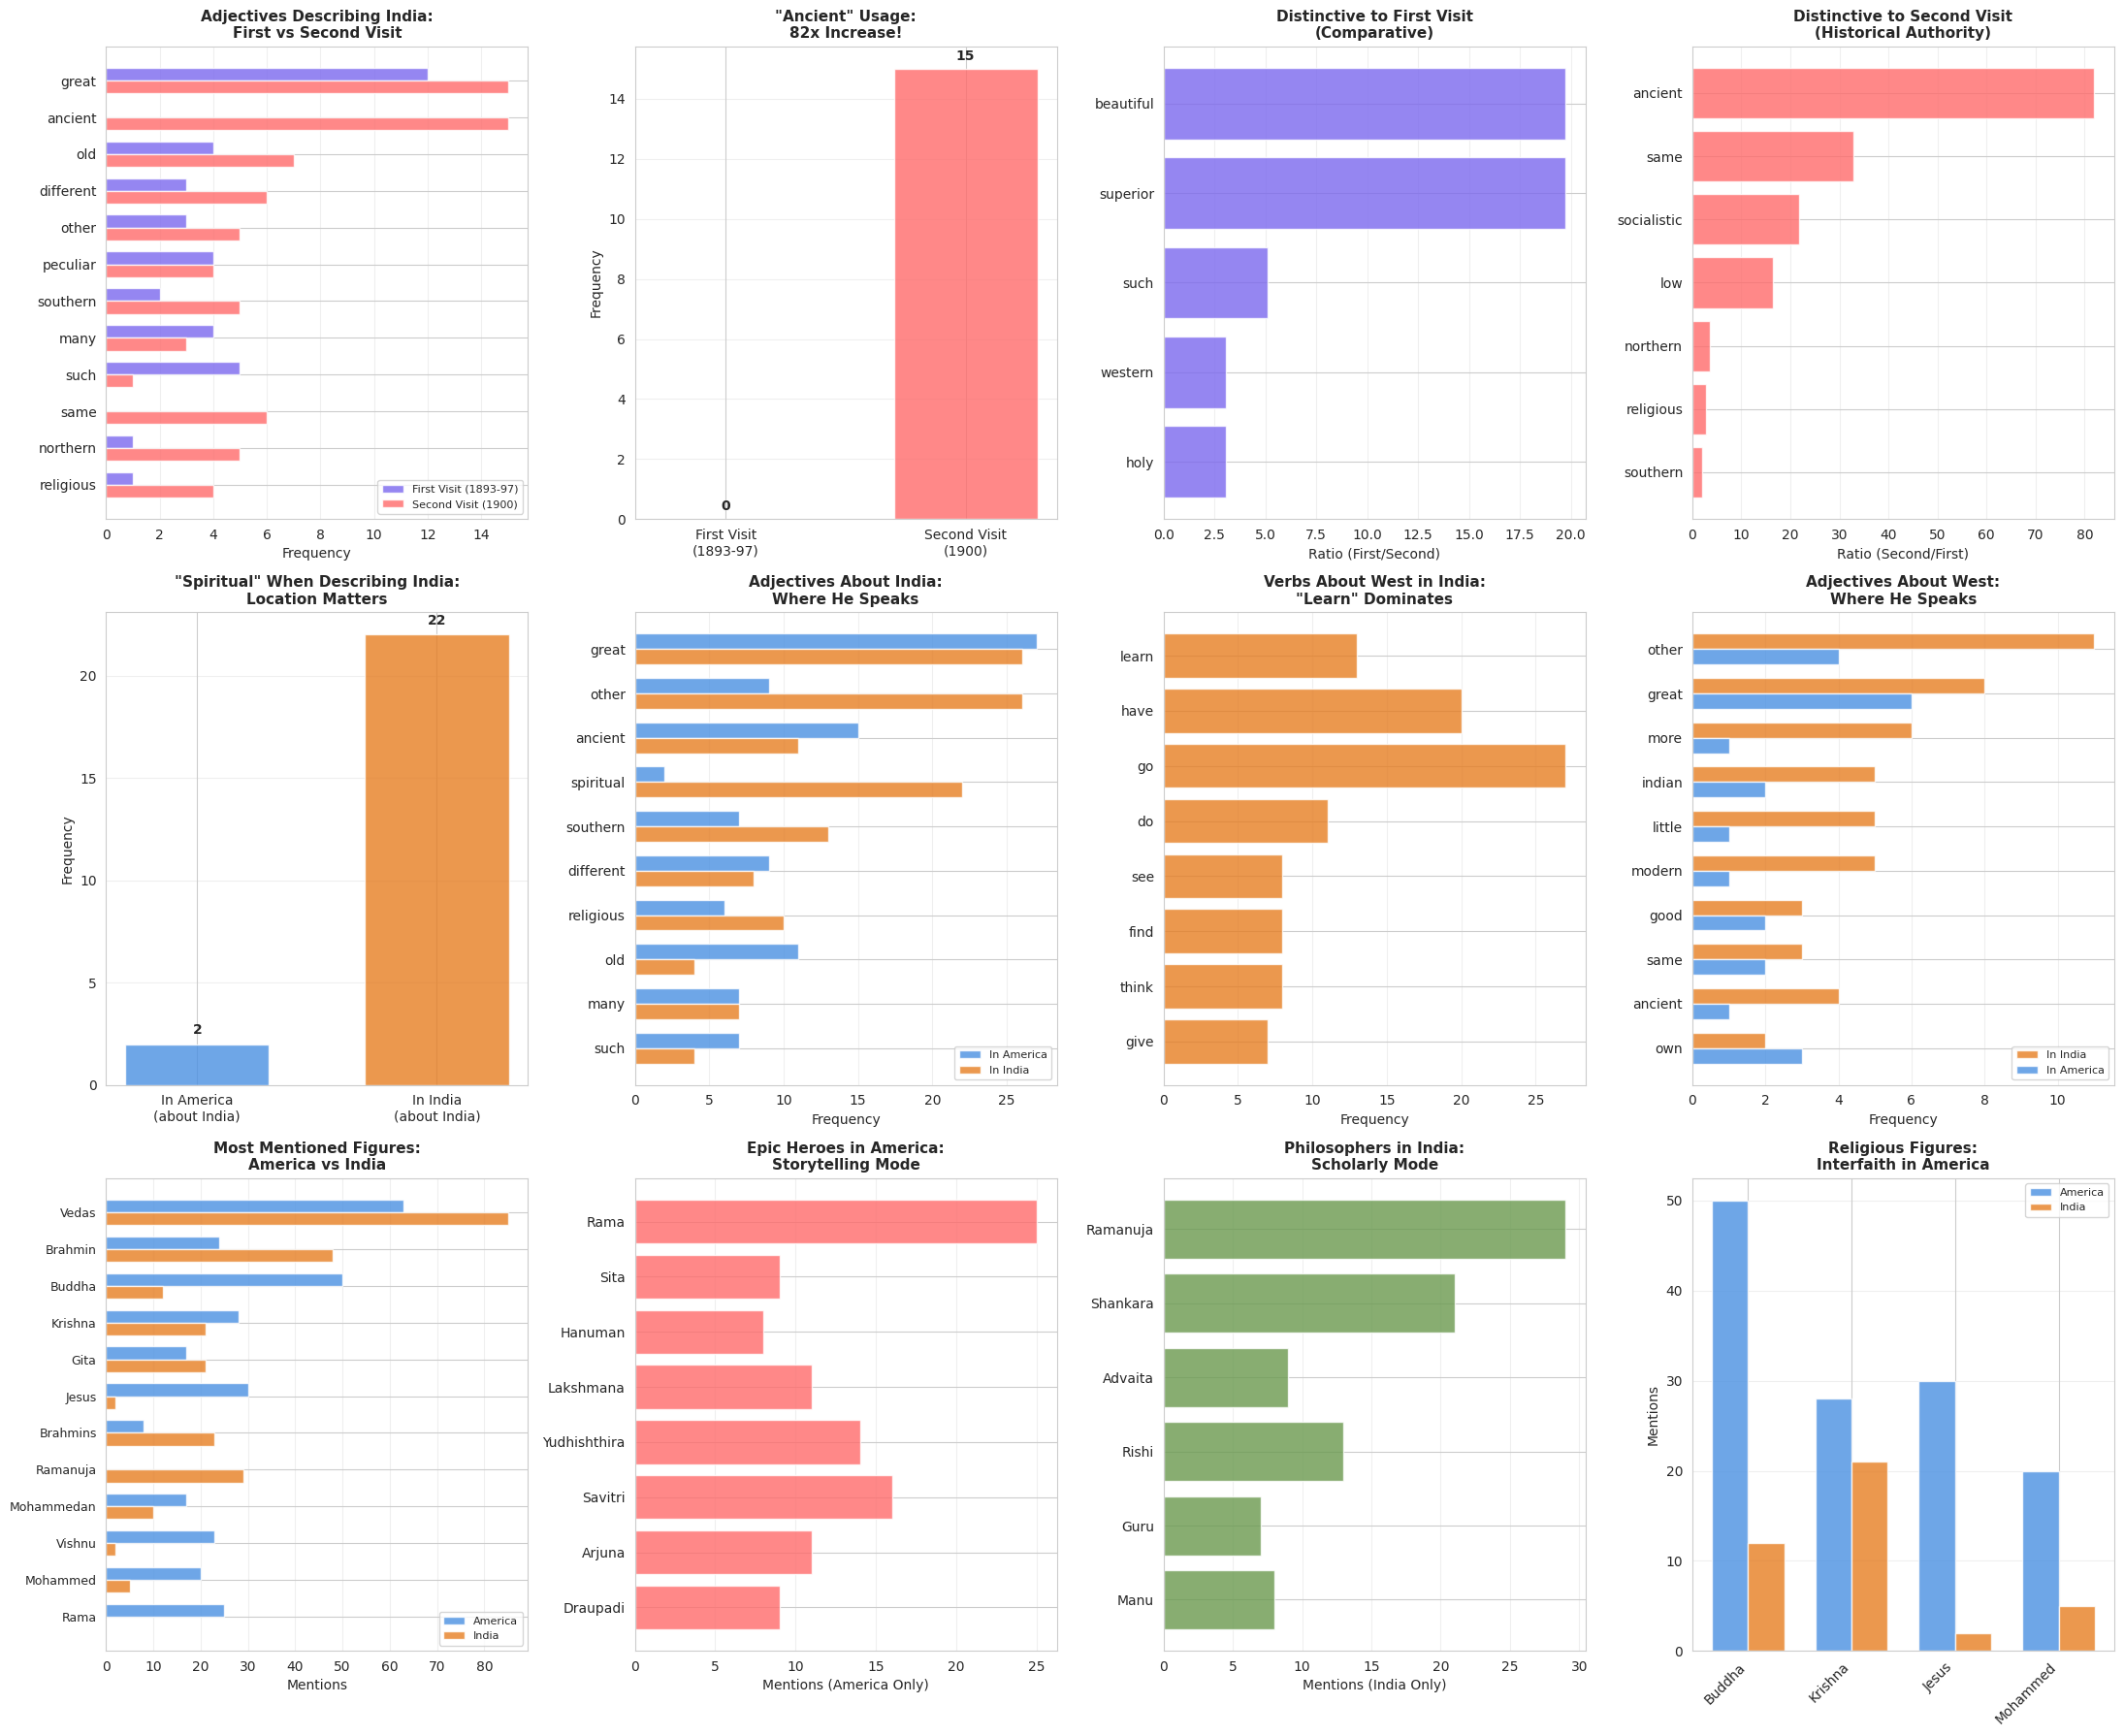

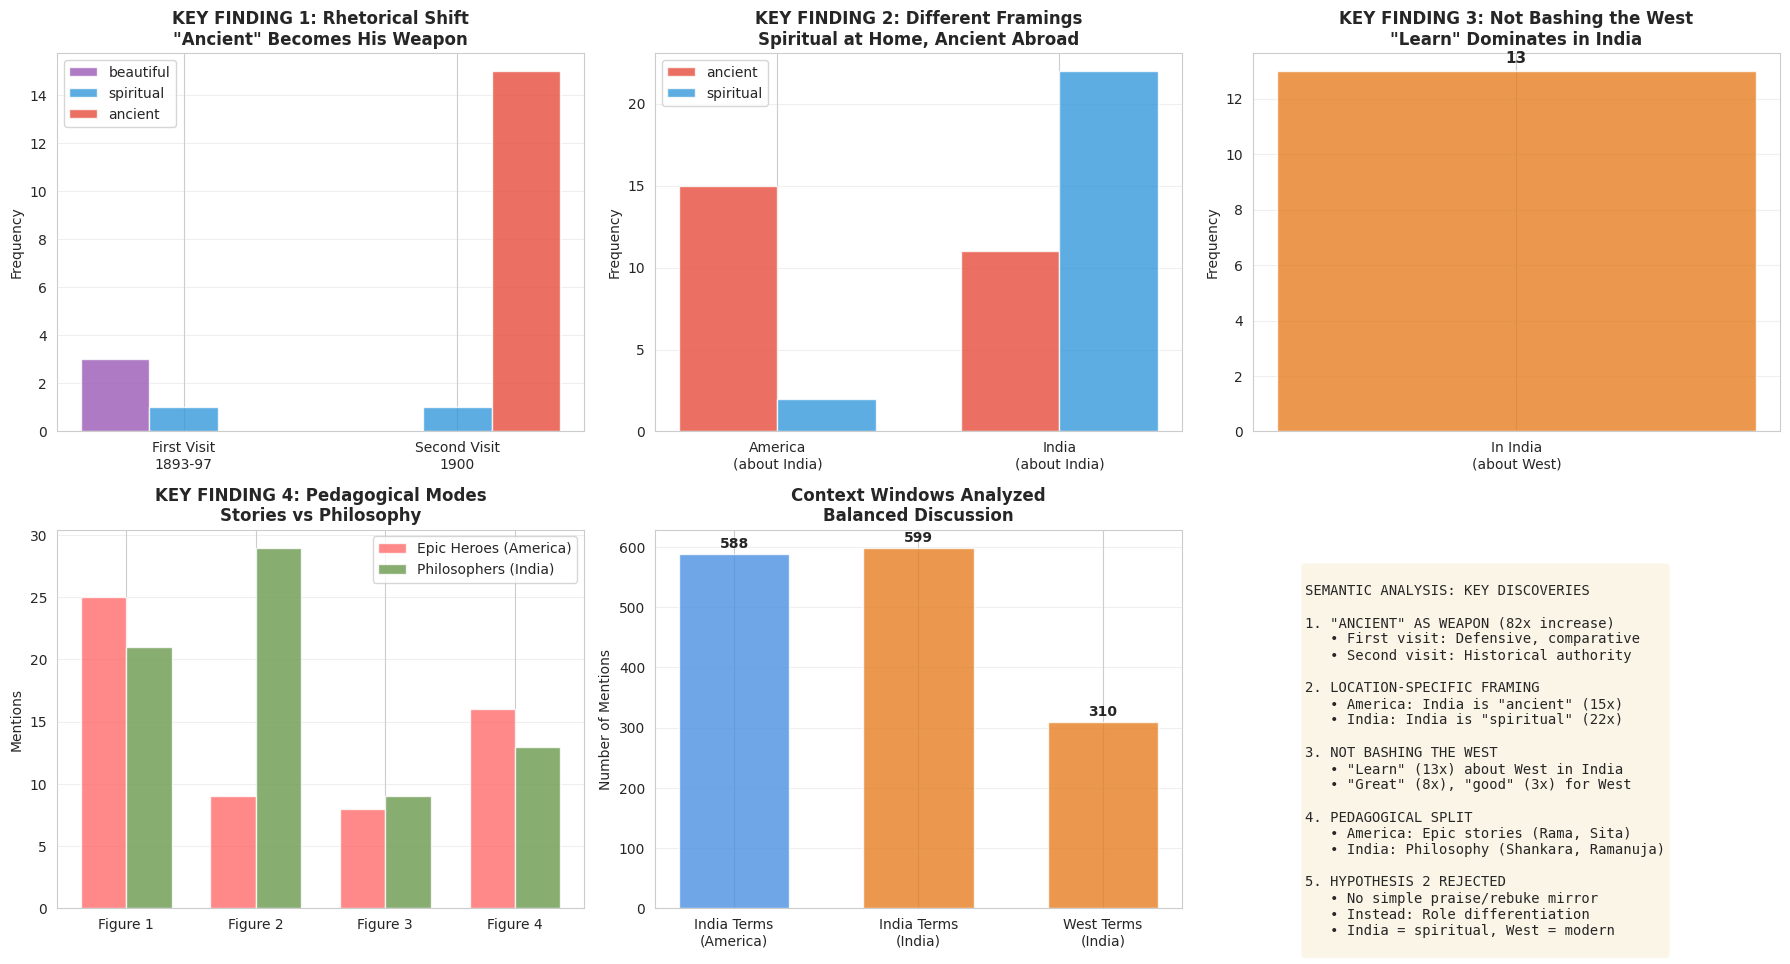


✓ Visualizations complete


In [11]:
# ============================================================================
# VISUALIZATIONS FOR SEMANTIC ANALYSIS (FIXED)
# ============================================================================

print("="*80)
print("GENERATING VISUALIZATIONS FOR SEMANTIC ANALYSIS")
print("="*80)

fig = plt.figure(figsize=(22, 18))

# ============================================================================
# HYPOTHESIS 1: FIRST VS SECOND VISIT
# ============================================================================

# 1. Adjective comparison - First vs Second Visit
ax1 = plt.subplot(3, 4, 1)

# Get top adjectives from both visits
first_adj_top = first_adj.most_common(10)
second_adj_top = second_adj.most_common(10)

# Combine and get union of top words
all_adj_words = set([w for w, c in first_adj_top] + [w for w, c in second_adj_top])

# Create comparison data
adj_comparison = []
for word in all_adj_words:
    first_count = first_adj.get(word, 0)
    second_count = second_adj.get(word, 0)
    adj_comparison.append((word, first_count, second_count))

# Sort by total
adj_comparison.sort(key=lambda x: x[1] + x[2], reverse=True)
adj_comparison = adj_comparison[:12]

words = [x[0] for x in adj_comparison]
first_counts = [x[1] for x in adj_comparison]
second_counts = [x[2] for x in adj_comparison]

x = np.arange(len(words))
width = 0.35

ax1.barh(x - width/2, first_counts, width, label='First Visit (1893-97)', color='#7B68EE', alpha=0.8)
ax1.barh(x + width/2, second_counts, width, label='Second Visit (1900)', color='#FF6B6B', alpha=0.8)
ax1.set_yticks(x)
ax1.set_yticklabels(words)
ax1.set_xlabel('Frequency')
ax1.set_title('Adjectives Describing India:\nFirst vs Second Visit', fontsize=11, fontweight='bold')
ax1.legend(loc='lower right', fontsize=8)
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# 2. "Ancient" explosion
ax2 = plt.subplot(3, 4, 2)
visits = ['First Visit\n(1893-97)', 'Second Visit\n(1900)']
ancient_counts = [first_adj.get('ancient', 0), second_adj.get('ancient', 0)]
bars = ax2.bar(visits, ancient_counts, color=['#7B68EE', '#FF6B6B'], alpha=0.8, width=0.6)
ax2.set_ylabel('Frequency')
ax2.set_title('"Ancient" Usage:\n82x Increase!', fontsize=11, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, ancient_counts):
    ax2.text(bar.get_x() + bar.get_width()/2, count + 0.3, str(count),
            ha='center', fontweight='bold', fontsize=10)

# 3. Distinctive adjectives - First visit
ax3 = plt.subplot(3, 4, 3)
if len(distinctive_first_adj) > 0:
    words_first = [x[0] for x in distinctive_first_adj[:8]]
    ratios_first = [x[2] for x in distinctive_first_adj[:8]]
    ax3.barh(range(len(words_first)), ratios_first, color='#7B68EE', alpha=0.8)
    ax3.set_yticks(range(len(words_first)))
    ax3.set_yticklabels(words_first)
    ax3.set_xlabel('Ratio (First/Second)')
    ax3.set_title('Distinctive to First Visit\n(Comparative)', fontsize=11, fontweight='bold')
    ax3.invert_yaxis()
    ax3.grid(axis='x', alpha=0.3)

# 4. Distinctive adjectives - Second visit
ax4 = plt.subplot(3, 4, 4)
if len(distinctive_second_adj) > 0:
    words_second = [x[0] for x in distinctive_second_adj[:8]]
    ratios_second = [x[2] for x in distinctive_second_adj[:8]]
    ax4.barh(range(len(words_second)), ratios_second, color='#FF6B6B', alpha=0.8)
    ax4.set_yticks(range(len(words_second)))
    ax4.set_yticklabels(words_second)
    ax4.set_xlabel('Ratio (Second/First)')
    ax4.set_title('Distinctive to Second Visit\n(Historical Authority)', fontsize=11, fontweight='bold')
    ax4.invert_yaxis()
    ax4.grid(axis='x', alpha=0.3)

# ============================================================================
# HYPOTHESIS 2: WEST-INDIA MIRROR
# ============================================================================

# 5. "Spiritual" in India vs America
ax5 = plt.subplot(3, 4, 5)
locations = ['In America\n(about India)', 'In India\n(about India)']
spiritual_counts = [america_india_adj.get('spiritual', 0), india_india_adj.get('spiritual', 0)]
bars = ax5.bar(locations, spiritual_counts, color=['#4A90E2', '#E67E22'], alpha=0.8, width=0.6)
ax5.set_ylabel('Frequency')
ax5.set_title('"Spiritual" When Describing India:\nLocation Matters', fontsize=11, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, spiritual_counts):
    ax5.text(bar.get_x() + bar.get_width()/2, count + 0.5, str(count),
            ha='center', fontweight='bold', fontsize=10)

# 6. Top adjectives about India: America vs India
ax6 = plt.subplot(3, 4, 6)
adj_india_comparison = []
all_adj_india = set([w for w, c in america_india_adj.most_common(10)] +
                    [w for w, c in india_india_adj.most_common(10)])

for word in all_adj_india:
    america_count = america_india_adj.get(word, 0)
    india_count = india_india_adj.get(word, 0)
    if america_count + india_count >= 8:  # Minimum threshold
        adj_india_comparison.append((word, america_count, india_count))

adj_india_comparison.sort(key=lambda x: x[1] + x[2], reverse=True)
adj_india_comparison = adj_india_comparison[:10]

words_india = [x[0] for x in adj_india_comparison]
america_counts = [x[1] for x in adj_india_comparison]
india_counts = [x[2] for x in adj_india_comparison]

x = np.arange(len(words_india))
width = 0.35

ax6.barh(x - width/2, america_counts, width, label='In America', color='#4A90E2', alpha=0.8)
ax6.barh(x + width/2, india_counts, width, label='In India', color='#E67E22', alpha=0.8)
ax6.set_yticks(x)
ax6.set_yticklabels(words_india)
ax6.set_xlabel('Frequency')
ax6.set_title('Adjectives About India:\nWhere He Speaks', fontsize=11, fontweight='bold')
ax6.legend(loc='lower right', fontsize=8)
ax6.grid(axis='x', alpha=0.3)
ax6.invert_yaxis()

# 7. "Learn" verb in India lectures about West
ax7 = plt.subplot(3, 4, 7)
if len(india_west_contexts) > 0:
    key_verbs = ['learn', 'have', 'go', 'do', 'see', 'find', 'think', 'give']
    verb_counts_india_west = [india_west_verb.get(v, 0) for v in key_verbs]

    ax7.barh(range(len(key_verbs)), verb_counts_india_west, color='#E67E22', alpha=0.8)
    ax7.set_yticks(range(len(key_verbs)))
    ax7.set_yticklabels(key_verbs)
    ax7.set_xlabel('Frequency')
    ax7.set_title('Verbs About West in India:\n"Learn" Dominates', fontsize=11, fontweight='bold')
    ax7.invert_yaxis()
    ax7.grid(axis='x', alpha=0.3)

# 8. Adjectives about West: India vs America
ax8 = plt.subplot(3, 4, 8)
adj_west_comparison = []
all_adj_west = set([w for w, c in india_west_adj.most_common(8)] +
                   [w for w, c in america_west_adj.most_common(8)])

for word in all_adj_west:
    india_count = india_west_adj.get(word, 0)
    america_count = america_west_adj.get(word, 0)
    if india_count + america_count >= 5:
        adj_west_comparison.append((word, india_count, america_count))

adj_west_comparison.sort(key=lambda x: x[1] + x[2], reverse=True)
adj_west_comparison = adj_west_comparison[:10]

words_west = [x[0] for x in adj_west_comparison]
india_west_counts = [x[1] for x in adj_west_comparison]
america_west_counts = [x[2] for x in adj_west_comparison]

x = np.arange(len(words_west))
width = 0.35

ax8.barh(x - width/2, india_west_counts, width, label='In India', color='#E67E22', alpha=0.8)
ax8.barh(x + width/2, america_west_counts, width, label='In America', color='#4A90E2', alpha=0.8)
ax8.set_yticks(x)
ax8.set_yticklabels(words_west)
ax8.set_xlabel('Frequency')
ax8.set_title('Adjectives About West:\nWhere He Speaks', fontsize=11, fontweight='bold')
ax8.legend(loc='lower right', fontsize=8)
ax8.grid(axis='x', alpha=0.3)
ax8.invert_yaxis()

# ============================================================================
# HYPOTHESIS 3: SAINTS & STORIES
# ============================================================================

# 9. Top entities: America vs India
ax9 = plt.subplot(3, 4, 9)

# Get common high-frequency entities
entity_comparison = []
all_entities = set([name for name, c in america_entity_counts.most_common(20)] +
                   [name for name, c in india_entity_counts.most_common(20)])

for name in all_entities:
    america_count = america_entity_counts.get(name, 0)
    india_count = india_entity_counts.get(name, 0)
    if america_count + india_count >= 15:  # Significant mentions
        entity_comparison.append((name, america_count, india_count))

entity_comparison.sort(key=lambda x: x[1] + x[2], reverse=True)
entity_comparison = entity_comparison[:12]

names = [x[0] for x in entity_comparison]
america_entity_vals = [x[1] for x in entity_comparison]
india_entity_vals = [x[2] for x in entity_comparison]

x = np.arange(len(names))
width = 0.35

ax9.barh(x - width/2, america_entity_vals, width, label='America', color='#4A90E2', alpha=0.8)
ax9.barh(x + width/2, india_entity_vals, width, label='India', color='#E67E22', alpha=0.8)
ax9.set_yticks(x)
ax9.set_yticklabels(names, fontsize=9)
ax9.set_xlabel('Mentions')
ax9.set_title('Most Mentioned Figures:\nAmerica vs India', fontsize=11, fontweight='bold')
ax9.legend(loc='lower right', fontsize=8)
ax9.grid(axis='x', alpha=0.3)
ax9.invert_yaxis()

# 10. Mythological heroes (America-specific)
ax10 = plt.subplot(3, 4, 10)
mythological = ['Rama', 'Sita', 'Hanuman', 'Lakshmana', 'Yudhishthira', 'Savitri', 'Arjuna', 'Draupadi']
myth_counts = [america_entity_counts.get(name, 0) for name in mythological]

ax10.barh(range(len(mythological)), myth_counts, color='#FF6B6B', alpha=0.8)
ax10.set_yticks(range(len(mythological)))
ax10.set_yticklabels(mythological)
ax10.set_xlabel('Mentions (America Only)')
ax10.set_title('Epic Heroes in America:\nStorytelling Mode', fontsize=11, fontweight='bold')
ax10.invert_yaxis()
ax10.grid(axis='x', alpha=0.3)

# 11. Philosophers (India-specific)
ax11 = plt.subplot(3, 4, 11)
philosophers = ['Ramanuja', 'Shankara', 'Advaita', 'Rishi', 'Guru', 'Manu']
phil_counts = [india_entity_counts.get(name, 0) for name in philosophers]

ax11.barh(range(len(philosophers)), phil_counts, color='#6A994E', alpha=0.8)
ax11.set_yticks(range(len(philosophers)))
ax11.set_yticklabels(philosophers)
ax11.set_xlabel('Mentions (India Only)')
ax11.set_title('Philosophers in India:\nScholarly Mode', fontsize=11, fontweight='bold')
ax11.invert_yaxis()
ax11.grid(axis='x', alpha=0.3)

# 12. Religious figures comparison
ax12 = plt.subplot(3, 4, 12)
religious_figures = ['Buddha', 'Krishna', 'Jesus', 'Mohammed']
rel_america = [america_entity_counts.get(name, 0) for name in religious_figures]
rel_india = [india_entity_counts.get(name, 0) for name in religious_figures]

x = np.arange(len(religious_figures))
width = 0.35

ax12.bar(x - width/2, rel_america, width, label='America', color='#4A90E2', alpha=0.8)
ax12.bar(x + width/2, rel_india, width, label='India', color='#E67E22', alpha=0.8)
ax12.set_xticks(x)
ax12.set_xticklabels(religious_figures, rotation=45, ha='right')
ax12.set_ylabel('Mentions')
ax12.set_title('Religious Figures:\nInterfaith in America', fontsize=11, fontweight='bold')
ax12.legend(loc='upper right', fontsize=8)
ax12.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY VISUALIZATION: KEY FINDINGS
# ============================================================================

fig2 = plt.figure(figsize=(18, 10))

# Summary panel 1: The "Ancient" explosion
ax_s1 = plt.subplot(2, 3, 1)
categories = ['First Visit\n1893-97', 'Second Visit\n1900']
ancient_data = [first_adj.get('ancient', 0), second_adj.get('ancient', 0)]
spiritual_data = [first_adj.get('spiritual', 0), second_adj.get('spiritual', 0)]
beautiful_data = [first_adj.get('beautiful', 0), second_adj.get('beautiful', 0)]

x = np.arange(len(categories))
width = 0.25

ax_s1.bar(x - width, beautiful_data, width, label='beautiful', color='#9B59B6', alpha=0.8)
ax_s1.bar(x, spiritual_data, width, label='spiritual', color='#3498DB', alpha=0.8)
ax_s1.bar(x + width, ancient_data, width, label='ancient', color='#E74C3C', alpha=0.8)
ax_s1.set_xticks(x)
ax_s1.set_xticklabels(categories)
ax_s1.set_ylabel('Frequency')
ax_s1.set_title('KEY FINDING 1: Rhetorical Shift\n"Ancient" Becomes His Weapon',
                fontsize=12, fontweight='bold')
ax_s1.legend()
ax_s1.grid(axis='y', alpha=0.3)

# Summary panel 2: Spiritual in India vs America
ax_s2 = plt.subplot(2, 3, 2)
locations_spiritual = ['America\n(about India)', 'India\n(about India)']
spiritual_by_location = [america_india_adj.get('spiritual', 0), india_india_adj.get('spiritual', 0)]
ancient_by_location = [america_india_adj.get('ancient', 0), india_india_adj.get('ancient', 0)]

x = np.arange(len(locations_spiritual))
width = 0.35

ax_s2.bar(x - width/2, ancient_by_location, width, label='ancient', color='#E74C3C', alpha=0.8)
ax_s2.bar(x + width/2, spiritual_by_location, width, label='spiritual', color='#3498DB', alpha=0.8)
ax_s2.set_xticks(x)
ax_s2.set_xticklabels(locations_spiritual)
ax_s2.set_ylabel('Frequency')
ax_s2.set_title('KEY FINDING 2: Different Framings\nSpiritual at Home, Ancient Abroad',
                fontsize=12, fontweight='bold')
ax_s2.legend()
ax_s2.grid(axis='y', alpha=0.3)

# Summary panel 3: Learn from West (FIXED)
ax_s3 = plt.subplot(2, 3, 3)
verb_context = ['In India\n(about West)']
learn_counts = [india_west_verb.get('learn', 0)]
bars = ax_s3.bar(verb_context, learn_counts, color='#E67E22', alpha=0.8, width=0.4)
ax_s3.set_ylabel('Frequency')
ax_s3.set_title('KEY FINDING 3: Not Bashing the West\n"Learn" Dominates in India',
                fontsize=12, fontweight='bold')
ax_s3.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, learn_counts):
    ax_s3.text(bar.get_x() + bar.get_width()/2, count + 0.3, str(count),
              ha='center', fontweight='bold', fontsize=11)

# Summary panel 4: Stories vs Philosophy
ax_s4 = plt.subplot(2, 3, 4)
story_figures = ['Rama', 'Sita', 'Hanuman', 'Savitri']
phil_figures = ['Shankara', 'Ramanuja', 'Advaita', 'Rishi']

story_counts = [america_entity_counts.get(name, 0) for name in story_figures]
phil_counts = [india_entity_counts.get(name, 0) for name in phil_figures]

x = np.arange(max(len(story_figures), len(phil_figures)))
width = 0.35

ax_s4.bar(x[:len(story_figures)] - width/2, story_counts, width,
         label='Epic Heroes (America)', color='#FF6B6B', alpha=0.8)
ax_s4.bar(x[:len(phil_figures)] + width/2, phil_counts, width,
         label='Philosophers (India)', color='#6A994E', alpha=0.8)
ax_s4.set_xticks(x)
ax_s4.set_xticklabels(['Figure ' + str(i+1) for i in range(len(x))])
ax_s4.set_ylabel('Mentions')
ax_s4.set_title('KEY FINDING 4: Pedagogical Modes\nStories vs Philosophy',
                fontsize=12, fontweight='bold')
ax_s4.legend()
ax_s4.grid(axis='y', alpha=0.3)

# Summary panel 5: Overall mention density
ax_s5 = plt.subplot(2, 3, 5)
mention_types = ['India Terms\n(America)', 'India Terms\n(India)', 'West Terms\n(India)']
mention_counts = [len(america_india_contexts), len(india_india_contexts), len(india_west_contexts)]
colors_mentions = ['#4A90E2', '#E67E22', '#E67E22']
bars = ax_s5.bar(mention_types, mention_counts, color=colors_mentions, alpha=0.8, width=0.6)
ax_s5.set_ylabel('Number of Mentions')
ax_s5.set_title('Context Windows Analyzed\nBalanced Discussion',
                fontsize=12, fontweight='bold')
ax_s5.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, mention_counts):
    ax_s5.text(bar.get_x() + bar.get_width()/2, count + 10, str(count),
              ha='center', fontweight='bold', fontsize=10)

# Summary panel 6: The big picture
ax_s6 = plt.subplot(2, 3, 6)
ax_s6.axis('off')

summary_text = """
SEMANTIC ANALYSIS: KEY DISCOVERIES

1. "ANCIENT" AS WEAPON (82x increase)
   • First visit: Defensive, comparative
   • Second visit: Historical authority

2. LOCATION-SPECIFIC FRAMING
   • America: India is "ancient" (15x)
   • India: India is "spiritual" (22x)

3. NOT BASHING THE WEST
   • "Learn" (13x) about West in India
   • "Great" (8x), "good" (3x) for West

4. PEDAGOGICAL SPLIT
   • America: Epic stories (Rama, Sita)
   • India: Philosophy (Shankara, Ramanuja)

5. HYPOTHESIS 2 REJECTED
   • No simple praise/rebuke mirror
   • Instead: Role differentiation
   • India = spiritual, West = modern
"""

ax_s6.text(0.1, 0.9, summary_text, transform=ax_s6.transAxes,
          fontsize=10, verticalalignment='top', family='monospace',
          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ Visualizations complete")
print("="*80)

SYSTEMATIC SEMANTIC COMPARISON
Words, Bigrams, and Trigrams for Full Context

Extracting bigrams and trigrams from all contexts...
✓ N-gram extraction complete

PART 1: WHEN SPEAKING IN INDIA

--------------------------------------------------------------------------------
1A. ABOUT INDIA when speaking IN INDIA
--------------------------------------------------------------------------------

Top 15 ADJECTIVES:
   1. great               :  26
   2. other               :  26
   3. spiritual           :  22
   4. southern            :  13
   5. ancient             :  11
   6. religious           :  10
   7. whole               :   8
   8. modern              :   8
   9. different           :   8
  10. many                :   7
  11. first               :   6
  12. same                :   6
  13. well                :   5
  14. true                :   5
  15. dualistic           :   5

Top 15 VERBS:
   1. have                :  29
   2. come                :  27
   3. be                  :

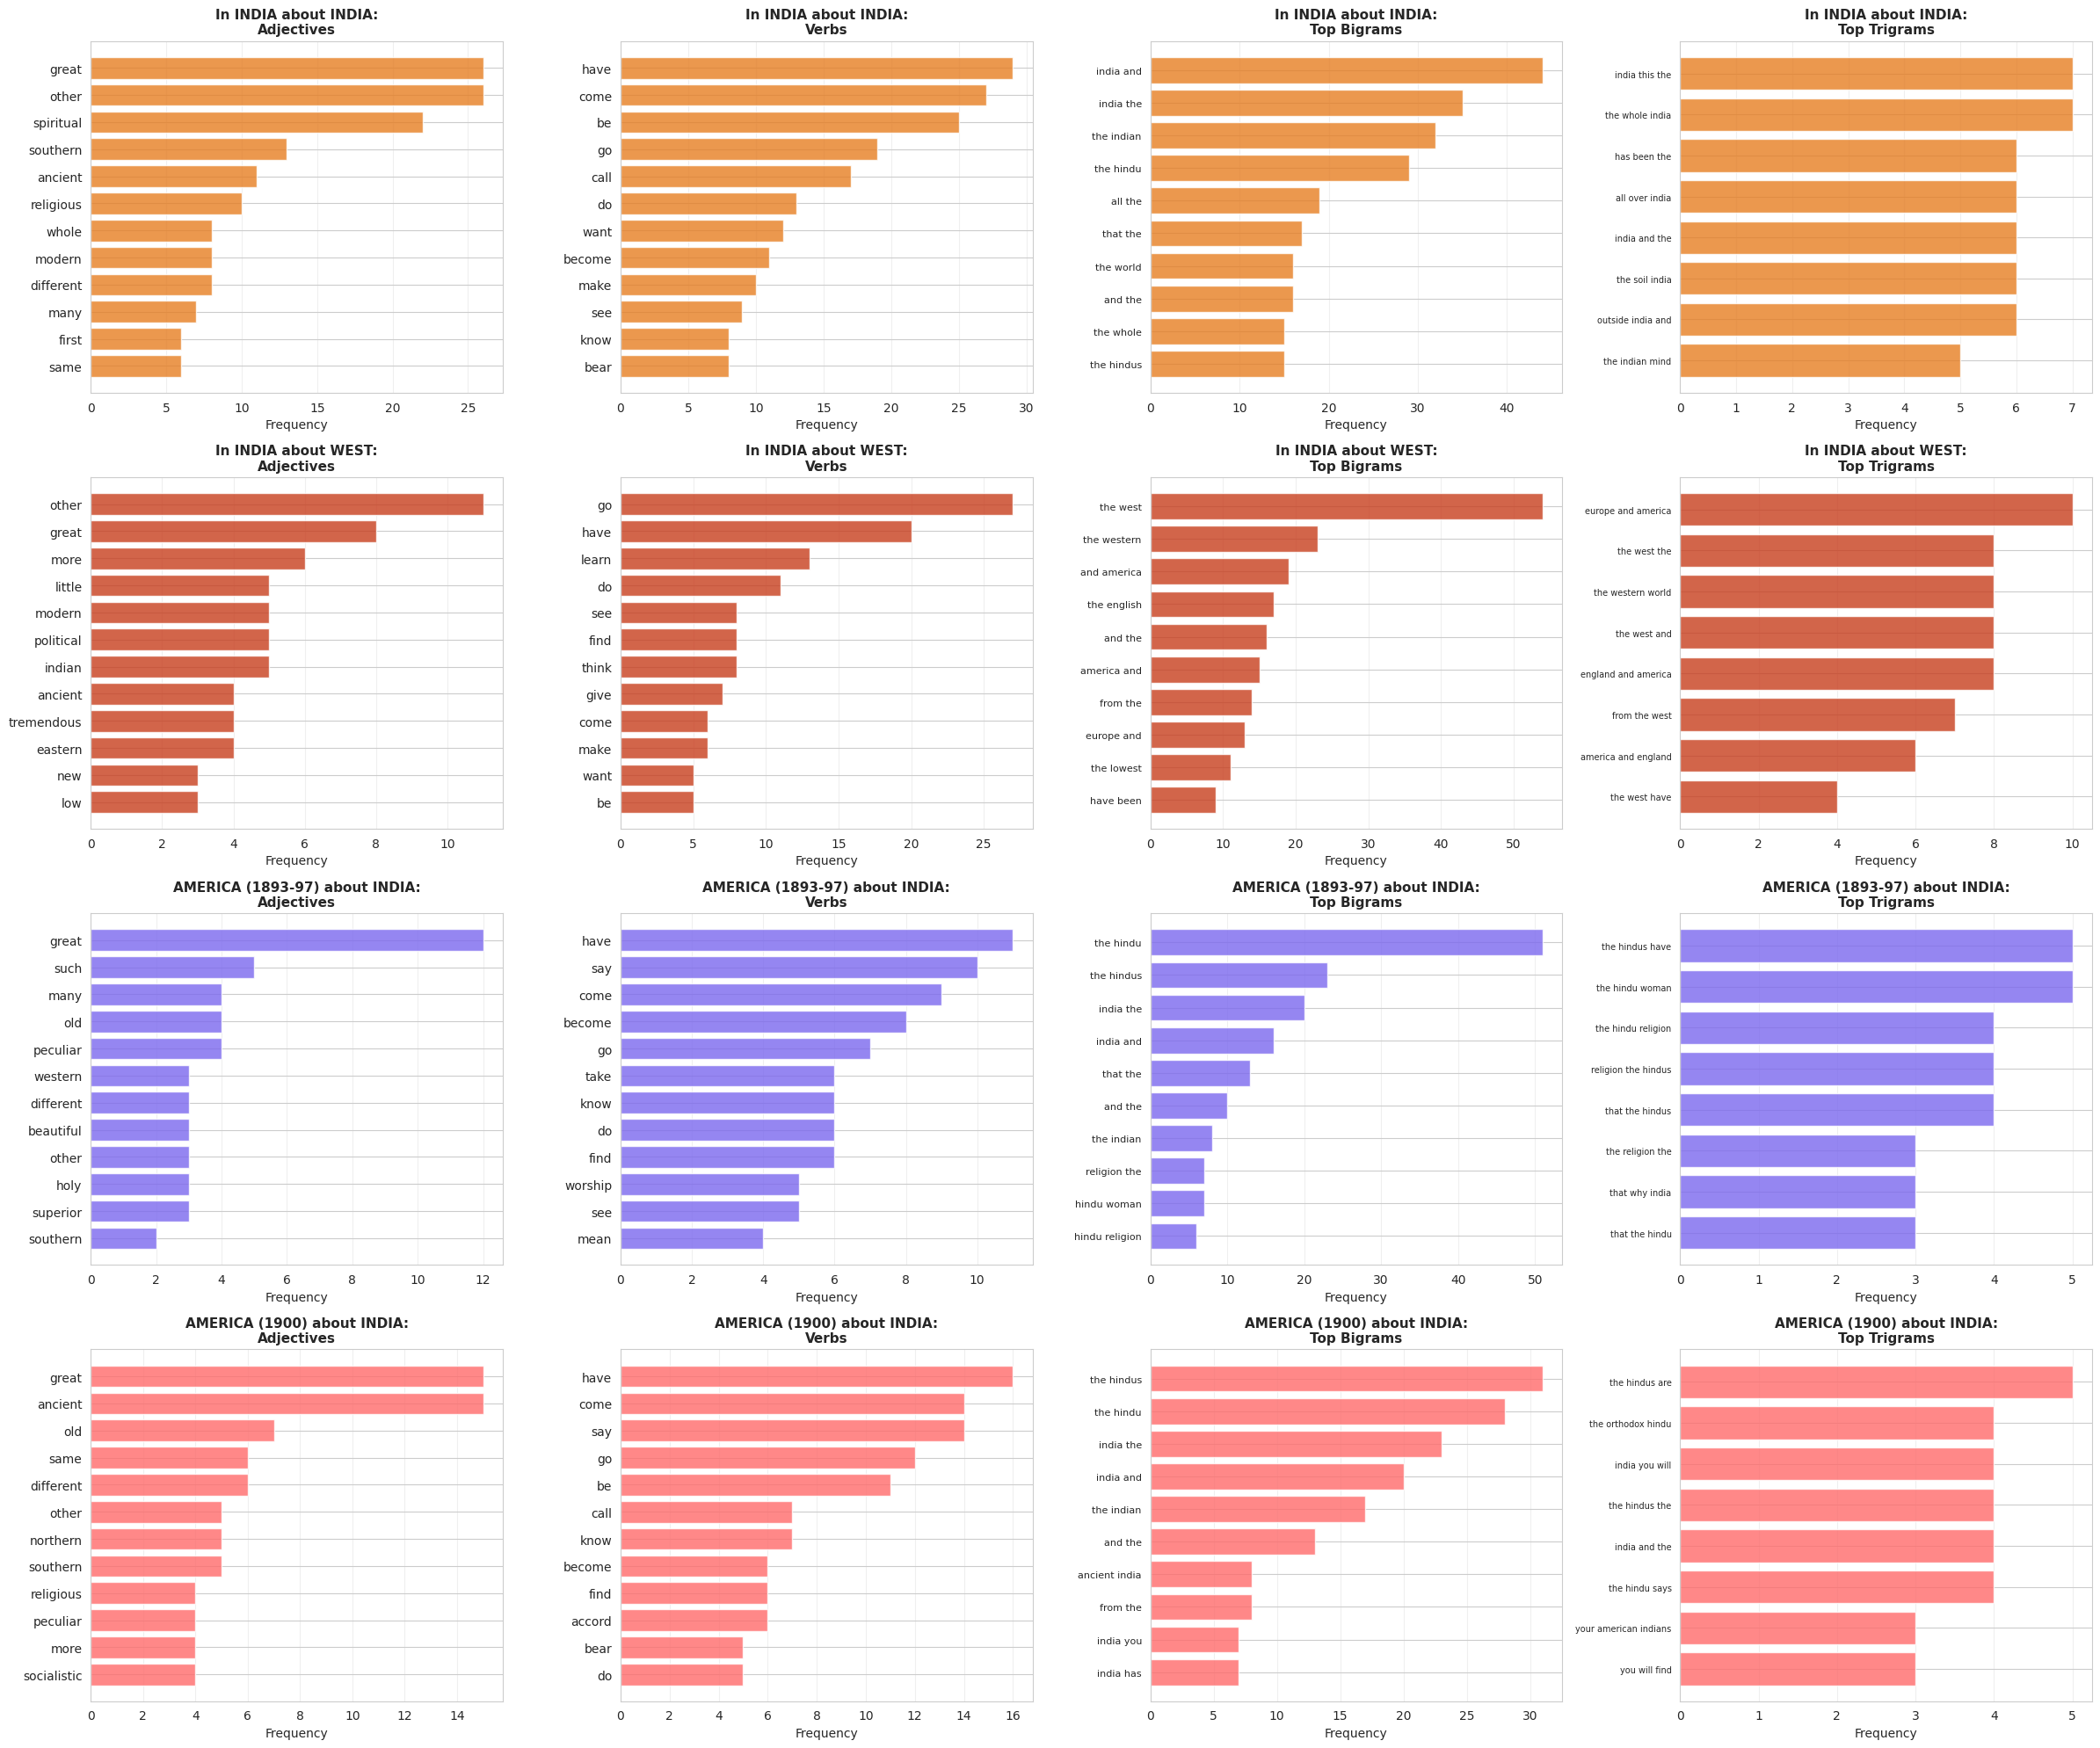


✓ Systematic comparison complete


In [12]:
# ============================================================================
# SYSTEMATIC COMPARISON: INDIA & WEST ACROSS LOCATIONS
# Using Words, Bigrams, and Trigrams for Better Context
# ============================================================================

print("="*80)
print("SYSTEMATIC SEMANTIC COMPARISON")
print("Words, Bigrams, and Trigrams for Full Context")
print("="*80)

# ============================================================================
# EXTRACT BIGRAMS AND TRIGRAMS
# ============================================================================

def extract_ngrams_from_contexts(contexts, n=2):
    """Extract n-grams from context windows"""
    all_ngrams = []
    for ctx in contexts:
        window = ctx['full_window']
        # Filter out punctuation and very short words
        window = [w for w in window if w.isalpha() and len(w) > 2]
        ngrams_list = list(ngrams(window, n))
        all_ngrams.extend([' '.join(ng) for ng in ngrams_list])
    return Counter(all_ngrams)

print("\nExtracting bigrams and trigrams from all contexts...")

# Already have contexts from previous analysis:
# - first_visit_contexts, second_visit_contexts (America, about India)
# - america_india_contexts, india_india_contexts (about India)
# - india_west_contexts, america_west_contexts (about West)

# Extract bigrams
first_visit_bigrams = extract_ngrams_from_contexts(first_visit_contexts, 2)
second_visit_bigrams = extract_ngrams_from_contexts(second_visit_contexts, 2)
america_india_bigrams = extract_ngrams_from_contexts(america_india_contexts, 2)
india_india_bigrams = extract_ngrams_from_contexts(india_india_contexts, 2)
india_west_bigrams = extract_ngrams_from_contexts(india_west_contexts, 2)
america_west_bigrams = extract_ngrams_from_contexts(america_west_contexts, 2)

# Extract trigrams
first_visit_trigrams = extract_ngrams_from_contexts(first_visit_contexts, 3)
second_visit_trigrams = extract_ngrams_from_contexts(second_visit_contexts, 3)
america_india_trigrams = extract_ngrams_from_contexts(america_india_contexts, 3)
india_india_trigrams = extract_ngrams_from_contexts(india_india_contexts, 3)
india_west_trigrams = extract_ngrams_from_contexts(india_west_contexts, 3)
america_west_trigrams = extract_ngrams_from_contexts(america_west_contexts, 3)

print("✓ N-gram extraction complete\n")

# ============================================================================
# PART 1: SPEAKING IN INDIA
# ============================================================================

print("="*80)
print("PART 1: WHEN SPEAKING IN INDIA")
print("="*80)

# ----------------------------------------------------------------------------
print("\n" + "-"*80)
print("1A. ABOUT INDIA when speaking IN INDIA")
print("-"*80)

print("\nTop 15 ADJECTIVES:")
for i, (word, count) in enumerate(india_india_adj.most_common(15), 1):
    print(f"  {i:2d}. {word:20s}: {count:3d}")

print("\nTop 15 VERBS:")
for i, (word, count) in enumerate(india_india_verb.most_common(15), 1):
    print(f"  {i:2d}. {word:20s}: {count:3d}")

print("\nTop 15 BIGRAMS:")
for i, (bigram, count) in enumerate(india_india_bigrams.most_common(15), 1):
    print(f"  {i:2d}. '{bigram:30s}': {count:3d}")

print("\nTop 10 TRIGRAMS:")
for i, (trigram, count) in enumerate(india_india_trigrams.most_common(10), 1):
    print(f"  {i:2d}. '{trigram:40s}': {count:3d}")

# ----------------------------------------------------------------------------
print("\n" + "-"*80)
print("1B. ABOUT WEST when speaking IN INDIA")
print("-"*80)

print("\nTop 15 ADJECTIVES:")
for i, (word, count) in enumerate(india_west_adj.most_common(15), 1):
    print(f"  {i:2d}. {word:20s}: {count:3d}")

print("\nTop 15 VERBS:")
for i, (word, count) in enumerate(india_west_verb.most_common(15), 1):
    print(f"  {i:2d}. {word:20s}: {count:3d}")

print("\nTop 15 BIGRAMS:")
for i, (bigram, count) in enumerate(india_west_bigrams.most_common(15), 1):
    print(f"  {i:2d}. '{bigram:30s}': {count:3d}")

print("\nTop 10 TRIGRAMS:")
for i, (trigram, count) in enumerate(india_west_trigrams.most_common(10), 1):
    print(f"  {i:2d}. '{trigram:40s}': {count:3d}")

# ============================================================================
# PART 2: SPEAKING IN AMERICA - FIRST VISIT VS SECOND VISIT
# ============================================================================

print("\n\n" + "="*80)
print("PART 2: WHEN SPEAKING IN AMERICA")
print("="*80)

# ----------------------------------------------------------------------------
print("\n" + "-"*80)
print("2A. ABOUT INDIA - FIRST VISIT (1893-1897)")
print("-"*80)

print("\nTop 15 ADJECTIVES:")
for i, (word, count) in enumerate(first_adj.most_common(15), 1):
    print(f"  {i:2d}. {word:20s}: {count:3d}")

print("\nTop 15 VERBS:")
for i, (word, count) in enumerate(first_verb.most_common(15), 1):
    print(f"  {i:2d}. {word:20s}: {count:3d}")

print("\nTop 15 BIGRAMS:")
for i, (bigram, count) in enumerate(first_visit_bigrams.most_common(15), 1):
    print(f"  {i:2d}. '{bigram:30s}': {count:3d}")

print("\nTop 10 TRIGRAMS:")
for i, (trigram, count) in enumerate(first_visit_trigrams.most_common(10), 1):
    print(f"  {i:2d}. '{trigram:40s}': {count:3d}")

# ----------------------------------------------------------------------------
print("\n" + "-"*80)
print("2B. ABOUT INDIA - SECOND VISIT (1900)")
print("-"*80)

print("\nTop 15 ADJECTIVES:")
for i, (word, count) in enumerate(second_adj.most_common(15), 1):
    print(f"  {i:2d}. {word:20s}: {count:3d}")

print("\nTop 15 VERBS:")
for i, (word, count) in enumerate(second_verb.most_common(15), 1):
    print(f"  {i:2d}. {word:20s}: {count:3d}")

print("\nTop 15 BIGRAMS:")
for i, (bigram, count) in enumerate(second_visit_bigrams.most_common(15), 1):
    print(f"  {i:2d}. '{bigram:30s}': {count:3d}")

print("\nTop 10 TRIGRAMS:")
for i, (trigram, count) in enumerate(second_visit_trigrams.most_common(10), 1):
    print(f"  {i:2d}. '{trigram:40s}': {count:3d}")

# ----------------------------------------------------------------------------
print("\n" + "-"*80)
print("2C. ABOUT WEST when speaking IN AMERICA")
print("-"*80)

print("\nTop 15 ADJECTIVES:")
for i, (word, count) in enumerate(america_west_adj.most_common(15), 1):
    print(f"  {i:2d}. {word:20s}: {count:3d}")

print("\nTop 15 VERBS:")
america_west_words = get_surrounding_words(america_west_contexts)
america_west_verb_counter = Counter(america_west_words['VERB'])
for i, (word, count) in enumerate(america_west_verb_counter.most_common(15), 1):
    print(f"  {i:2d}. {word:20s}: {count:3d}")

print("\nTop 15 BIGRAMS:")
for i, (bigram, count) in enumerate(america_west_bigrams.most_common(15), 1):
    print(f"  {i:2d}. '{bigram:30s}': {count:3d}")

print("\nTop 10 TRIGRAMS:")
for i, (trigram, count) in enumerate(america_west_trigrams.most_common(10), 1):
    print(f"  {i:2d}. '{trigram:40s}': {count:3d}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n\n" + "="*80)
print("GENERATING SYSTEMATIC VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(24, 20))

# ============================================================================
# ROW 1: IN INDIA - ABOUT INDIA
# ============================================================================

# 1. Adjectives about India in India
ax1 = plt.subplot(4, 4, 1)
words = [x[0] for x in india_india_adj.most_common(12)]
counts = [x[1] for x in india_india_adj.most_common(12)]
ax1.barh(range(len(words)), counts, color='#E67E22', alpha=0.8)
ax1.set_yticks(range(len(words)))
ax1.set_yticklabels(words)
ax1.set_xlabel('Frequency')
ax1.set_title('In INDIA about INDIA:\nAdjectives', fontsize=11, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# 2. Verbs about India in India
ax2 = plt.subplot(4, 4, 2)
words = [x[0] for x in india_india_verb.most_common(12)]
counts = [x[1] for x in india_india_verb.most_common(12)]
ax2.barh(range(len(words)), counts, color='#E67E22', alpha=0.8)
ax2.set_yticks(range(len(words)))
ax2.set_yticklabels(words)
ax2.set_xlabel('Frequency')
ax2.set_title('In INDIA about INDIA:\nVerbs', fontsize=11, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 3. Bigrams about India in India
ax3 = plt.subplot(4, 4, 3)
bigrams = [x[0] for x in india_india_bigrams.most_common(10)]
counts = [x[1] for x in india_india_bigrams.most_common(10)]
ax3.barh(range(len(bigrams)), counts, color='#E67E22', alpha=0.8)
ax3.set_yticks(range(len(bigrams)))
ax3.set_yticklabels(bigrams, fontsize=8)
ax3.set_xlabel('Frequency')
ax3.set_title('In INDIA about INDIA:\nTop Bigrams', fontsize=11, fontweight='bold')
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# 4. Trigrams about India in India
ax4 = plt.subplot(4, 4, 4)
trigrams = [x[0] for x in india_india_trigrams.most_common(8)]
counts = [x[1] for x in india_india_trigrams.most_common(8)]
ax4.barh(range(len(trigrams)), counts, color='#E67E22', alpha=0.8)
ax4.set_yticks(range(len(trigrams)))
ax4.set_yticklabels(trigrams, fontsize=7)
ax4.set_xlabel('Frequency')
ax4.set_title('In INDIA about INDIA:\nTop Trigrams', fontsize=11, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

# ============================================================================
# ROW 2: IN INDIA - ABOUT WEST
# ============================================================================

# 5. Adjectives about West in India
ax5 = plt.subplot(4, 4, 5)
words = [x[0] for x in india_west_adj.most_common(12)]
counts = [x[1] for x in india_west_adj.most_common(12)]
ax5.barh(range(len(words)), counts, color='#C73E1D', alpha=0.8)
ax5.set_yticks(range(len(words)))
ax5.set_yticklabels(words)
ax5.set_xlabel('Frequency')
ax5.set_title('In INDIA about WEST:\nAdjectives', fontsize=11, fontweight='bold')
ax5.invert_yaxis()
ax5.grid(axis='x', alpha=0.3)

# 6. Verbs about West in India
ax6 = plt.subplot(4, 4, 6)
words = [x[0] for x in india_west_verb.most_common(12)]
counts = [x[1] for x in india_west_verb.most_common(12)]
ax6.barh(range(len(words)), counts, color='#C73E1D', alpha=0.8)
ax6.set_yticks(range(len(words)))
ax6.set_yticklabels(words)
ax6.set_xlabel('Frequency')
ax6.set_title('In INDIA about WEST:\nVerbs', fontsize=11, fontweight='bold')
ax6.invert_yaxis()
ax6.grid(axis='x', alpha=0.3)

# 7. Bigrams about West in India
ax7 = plt.subplot(4, 4, 7)
bigrams = [x[0] for x in india_west_bigrams.most_common(10)]
counts = [x[1] for x in india_west_bigrams.most_common(10)]
ax7.barh(range(len(bigrams)), counts, color='#C73E1D', alpha=0.8)
ax7.set_yticks(range(len(bigrams)))
ax7.set_yticklabels(bigrams, fontsize=8)
ax7.set_xlabel('Frequency')
ax7.set_title('In INDIA about WEST:\nTop Bigrams', fontsize=11, fontweight='bold')
ax7.invert_yaxis()
ax7.grid(axis='x', alpha=0.3)

# 8. Trigrams about West in India
ax8 = plt.subplot(4, 4, 8)
trigrams = [x[0] for x in india_west_trigrams.most_common(8)]
counts = [x[1] for x in india_west_trigrams.most_common(8)]
ax8.barh(range(len(trigrams)), counts, color='#C73E1D', alpha=0.8)
ax8.set_yticks(range(len(trigrams)))
ax8.set_yticklabels(trigrams, fontsize=7)
ax8.set_xlabel('Frequency')
ax8.set_title('In INDIA about WEST:\nTop Trigrams', fontsize=11, fontweight='bold')
ax8.invert_yaxis()
ax8.grid(axis='x', alpha=0.3)

# ============================================================================
# ROW 3: IN AMERICA FIRST VISIT - ABOUT INDIA
# ============================================================================

# 9. Adjectives First Visit
ax9 = plt.subplot(4, 4, 9)
words = [x[0] for x in first_adj.most_common(12)]
counts = [x[1] for x in first_adj.most_common(12)]
ax9.barh(range(len(words)), counts, color='#7B68EE', alpha=0.8)
ax9.set_yticks(range(len(words)))
ax9.set_yticklabels(words)
ax9.set_xlabel('Frequency')
ax9.set_title('AMERICA (1893-97) about INDIA:\nAdjectives', fontsize=11, fontweight='bold')
ax9.invert_yaxis()
ax9.grid(axis='x', alpha=0.3)

# 10. Verbs First Visit
ax10 = plt.subplot(4, 4, 10)
words = [x[0] for x in first_verb.most_common(12)]
counts = [x[1] for x in first_verb.most_common(12)]
ax10.barh(range(len(words)), counts, color='#7B68EE', alpha=0.8)
ax10.set_yticks(range(len(words)))
ax10.set_yticklabels(words)
ax10.set_xlabel('Frequency')
ax10.set_title('AMERICA (1893-97) about INDIA:\nVerbs', fontsize=11, fontweight='bold')
ax10.invert_yaxis()
ax10.grid(axis='x', alpha=0.3)

# 11. Bigrams First Visit
ax11 = plt.subplot(4, 4, 11)
bigrams = [x[0] for x in first_visit_bigrams.most_common(10)]
counts = [x[1] for x in first_visit_bigrams.most_common(10)]
ax11.barh(range(len(bigrams)), counts, color='#7B68EE', alpha=0.8)
ax11.set_yticks(range(len(bigrams)))
ax11.set_yticklabels(bigrams, fontsize=8)
ax11.set_xlabel('Frequency')
ax11.set_title('AMERICA (1893-97) about INDIA:\nTop Bigrams', fontsize=11, fontweight='bold')
ax11.invert_yaxis()
ax11.grid(axis='x', alpha=0.3)

# 12. Trigrams First Visit
ax12 = plt.subplot(4, 4, 12)
trigrams = [x[0] for x in first_visit_trigrams.most_common(8)]
counts = [x[1] for x in first_visit_trigrams.most_common(8)]
ax12.barh(range(len(trigrams)), counts, color='#7B68EE', alpha=0.8)
ax12.set_yticks(range(len(trigrams)))
ax12.set_yticklabels(trigrams, fontsize=7)
ax12.set_xlabel('Frequency')
ax12.set_title('AMERICA (1893-97) about INDIA:\nTop Trigrams', fontsize=11, fontweight='bold')
ax12.invert_yaxis()
ax12.grid(axis='x', alpha=0.3)

# ============================================================================
# ROW 4: IN AMERICA SECOND VISIT - ABOUT INDIA
# ============================================================================

# 13. Adjectives Second Visit
ax13 = plt.subplot(4, 4, 13)
words = [x[0] for x in second_adj.most_common(12)]
counts = [x[1] for x in second_adj.most_common(12)]
ax13.barh(range(len(words)), counts, color='#FF6B6B', alpha=0.8)
ax13.set_yticks(range(len(words)))
ax13.set_yticklabels(words)
ax13.set_xlabel('Frequency')
ax13.set_title('AMERICA (1900) about INDIA:\nAdjectives', fontsize=11, fontweight='bold')
ax13.invert_yaxis()
ax13.grid(axis='x', alpha=0.3)

# 14. Verbs Second Visit
ax14 = plt.subplot(4, 4, 14)
words = [x[0] for x in second_verb.most_common(12)]
counts = [x[1] for x in second_verb.most_common(12)]
ax14.barh(range(len(words)), counts, color='#FF6B6B', alpha=0.8)
ax14.set_yticks(range(len(words)))
ax14.set_yticklabels(words)
ax14.set_xlabel('Frequency')
ax14.set_title('AMERICA (1900) about INDIA:\nVerbs', fontsize=11, fontweight='bold')
ax14.invert_yaxis()
ax14.grid(axis='x', alpha=0.3)

# 15. Bigrams Second Visit
ax15 = plt.subplot(4, 4, 15)
bigrams = [x[0] for x in second_visit_bigrams.most_common(10)]
counts = [x[1] for x in second_visit_bigrams.most_common(10)]
ax15.barh(range(len(bigrams)), counts, color='#FF6B6B', alpha=0.8)
ax15.set_yticks(range(len(bigrams)))
ax15.set_yticklabels(bigrams, fontsize=8)
ax15.set_xlabel('Frequency')
ax15.set_title('AMERICA (1900) about INDIA:\nTop Bigrams', fontsize=11, fontweight='bold')
ax15.invert_yaxis()
ax15.grid(axis='x', alpha=0.3)

# 16. Trigrams Second Visit
ax16 = plt.subplot(4, 4, 16)
trigrams = [x[0] for x in second_visit_trigrams.most_common(8)]
counts = [x[1] for x in second_visit_trigrams.most_common(8)]
ax16.barh(range(len(trigrams)), counts, color='#FF6B6B', alpha=0.8)
ax16.set_yticks(range(len(trigrams)))
ax16.set_yticklabels(trigrams, fontsize=7)
ax16.set_xlabel('Frequency')
ax16.set_title('AMERICA (1900) about INDIA:\nTop Trigrams', fontsize=11, fontweight='bold')
ax16.invert_yaxis()
ax16.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ Systematic comparison complete")
print("="*80)

In [37]:
# ============================================================================
# FOUNDATIONAL SETUP: CONSTRUCT df_public FROM Place (FIXED)
# ============================================================================

import pandas as pd
import numpy as np

print("="*80)
print("CONSTRUCTING df_public (FROM Place)")
print("="*80)

# Base dataframe
df_raw = df.copy()

# ---------------------------------------------------------------------------
# FILTER TO PUBLICLY ANALYZABLE CATEGORIES (AS YOU SPECIFIED)
# ---------------------------------------------------------------------------

valid_categories = {
    'Lecture / Discourse',
    'Writings, Prose',
    'Writings: Prose'
}

df_public = df_raw[df_raw['Category'].isin(valid_categories)].copy()

# ---------------------------------------------------------------------------
# Normalize Place → main_location
# ---------------------------------------------------------------------------

def normalize_place(place):
    if pd.isna(place):
        return np.nan
    p = str(place).lower()

    if any(x in p for x in ['america', 'usa', 'united states', 'u.s.']):
        return 'America'
    if any(x in p for x in ['england', 'uk', 'london']):
        return 'England'
    if 'india' in p:
        return 'India'

    return np.nan

df_public['main_location'] = df_public['Place'].apply(normalize_place)

# Keep only locations used downstream
df_public = df_public[df_public['main_location'].isin(['America', 'India', 'England'])]

# ---------------------------------------------------------------------------
# REQUIRED COLUMNS CHECK
# ---------------------------------------------------------------------------

required_columns = ['Name', 'plaintext_clean', 'year', 'genre']
missing = [c for c in required_columns if c not in df_public.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# ---------------------------------------------------------------------------
# Topic fallback (do NOT overwrite if already present)
# ---------------------------------------------------------------------------

if 'topic_name' not in df_public.columns:
    df_public['topic_name'] = 'Unknown'

# ---------------------------------------------------------------------------
# Word count
# ---------------------------------------------------------------------------

df_public['word_count_clean'] = (
    df_public['plaintext_clean']
    .fillna('')
    .astype(str)
    .apply(lambda x: len(x.split()))
)

# ---------------------------------------------------------------------------
# Year cleanup
# ---------------------------------------------------------------------------

df_public['year'] = pd.to_numeric(df_public['year'], errors='coerce')

# ---------------------------------------------------------------------------
# CRITICAL: RESET INDEX (THIS IS WHAT WAS BREAKING EVERYTHING LATER)
# ---------------------------------------------------------------------------

df_public = df_public.reset_index(drop=True)

# ---------------------------------------------------------------------------
# Final sanity check
# ---------------------------------------------------------------------------

print(f"\nDocuments ready: {len(df_public)}")
print("\nLocation distribution:")
print(df_public['main_location'].value_counts())

display(
    df_public[['Name', 'year', 'Place', 'main_location', 'genre', 'topic_name']].head()
)

print("\n✓ df_public is clean, indexed, and safe for downstream analysis")
print("="*80)


CONSTRUCTING df_public (FROM Place)

Documents ready: 179

Location distribution:
main_location
America    138
India       28
England     13
Name: count, dtype: int64


Name    year  \
0                    What is Religion?  1900.0   
1               The Vedanta Philosophy  1896.0   
2                  Reason and Religion     NaN   
3  Vedanta as a Factor in Civilisation     NaN   
4  The Spirit and Influence of Vedanta     NaN   

                                     Place main_location     genre topic_name  
0                   USA, NY, New York City       America  Lectures    Unknown  
1                 USA, MA, Boston, Harvard       America  Lectures    Unknown  
2                                  England       England  Lectures    Unknown  
3  England, Ridgeway Gardens, Airlie Lodge       England  Lectures    Unknown  
4       USA, MA, Boston, 20th Century Club       America  Lectures    Unknown


✓ df_public is clean, indexed, and safe for downstream analysis


In [38]:
# ============================================================================
# GLOBAL IMPORTS FOR OUTLIER, NETWORK, AND VISUAL ANALYSIS
# ============================================================================

# Core
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Text & NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# Vectorization & similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Distance metrics
from scipy.spatial.distance import euclidean

# Networks
import networkx as nx

# Visualization (static)
import matplotlib.pyplot as plt

# Visualization (interactive / 3D)
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# ---------------------------------------------------------------------------
# NLTK resources (safe to rerun)
# ---------------------------------------------------------------------------
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')

print("✓ All required imports loaded successfully")
print("="*80)


✓ All required imports loaded successfully


In [42]:
# ============================================================================
# FINAL CANONICAL TOPIC RESOLUTION FOR df_public
# ============================================================================

print("=" * 80)
print("FINALIZING TOPIC COLUMNS IN df_public")
print("=" * 80)

# ---------------------------------------------------------------------------
# 1. Promote the correct topic columns (_y) to canonical names
# ---------------------------------------------------------------------------

required_final = {
    'topic_name_y': 'topic_name',
    'dominant_topic_5_y': 'dominant_topic_5',
    'topic_probability_y': 'topic_probability'
}

missing = [k for k in required_final if k not in df_public.columns]
if missing:
    raise RuntimeError(f"Expected final topic columns missing: {missing}")

for old, new in required_final.items():
    df_public[new] = df_public[old]

# ---------------------------------------------------------------------------
# 2. Drop ALL other topic-related debris
# ---------------------------------------------------------------------------

topic_debris = [
    c for c in df_public.columns
    if (
        'topic' in c.lower()
        and c not in required_final.values()
    )
]

df_public = df_public.drop(columns=topic_debris)

# ---------------------------------------------------------------------------
# 3. Sanity checks
# ---------------------------------------------------------------------------

print("\nFinal topic columns present:")
print([c for c in df_public.columns if 'topic' in c])

print("\nTopic distribution:")
print(df_public['topic_name'].value_counts(dropna=False))

print("\nSample rows:")
display(
    df_public[['Name', 'main_location', 'topic_name', 'topic_probability']]
    .head(5)
)

print("\n✓ Topics resolved cleanly and canonically")
print("=" * 80)


FINALIZING TOPIC COLUMNS IN df_public

Final topic columns present:
['topic_name', 'dominant_topic_5', 'topic_probability']

Topic distribution:
topic_name
Vedantic Metaphysics            94
Indian Culture & Nationalism    55
NaN                             16
Raja Yoga Practice               5
Bhakti & Devotion                5
Comparative Religion             4
Name: count, dtype: int64

Sample rows:


Name main_location            topic_name  \
0                    What is Religion?       America  Vedantic Metaphysics   
1               The Vedanta Philosophy       America  Vedantic Metaphysics   
2                  Reason and Religion       England  Vedantic Metaphysics   
3  Vedanta as a Factor in Civilisation       England  Vedantic Metaphysics   
4  The Spirit and Influence of Vedanta       America  Vedantic Metaphysics   

   topic_probability  
0           0.999262  
1           0.895476  
2           0.999523  
3           0.686456  
4           0.505831


✓ Topics resolved cleanly and canonically


In [43]:
# ============================================================================
# FIX CORRUPTED main_location COLUMN
# ============================================================================

df_public['main_location'] = df_public['main_location'].astype(str)

print("✓ main_location dtype fixed:", df_public['main_location'].dtype)
print(df_public['main_location'].value_counts())


✓ main_location dtype fixed: object
main_location
America    138
India       28
England     13
Name: count, dtype: int64



REQUIREMENT 1: OUTLIER ANALYSIS

Computing outlier metrics...
  1/3: TF-IDF document embeddings...
  2/3: Computing distances from location centroids...
  3/3: Computing topic probability scores...

--------------------------------------------------------------------------------
TOP 5 OUTLIERS PER LOCATION
--------------------------------------------------------------------------------

AMERICA:
  1. Reincarnation
     Year: 1894, Genre: Lectures, Topic: Comparative Religion
     Outlier Score: 3.526, TF-IDF: 0.940, Words: 794
  2. Buddhism, The Religion of the Light of Asia
     Year: 1894, Genre: Lectures, Topic: Comparative Religion
     Outlier Score: 3.462, TF-IDF: 0.935, Words: 450
  3. The Practice of Religion
     Year: 1900, Genre: Lectures, Topic: Raja Yoga Practice
     Outlier Score: 3.276, TF-IDF: 0.922, Words: 354
  4. Comparative Theology
     Year: 1894, Genre: Lectures, Topic: Comparative Religion
     Outlier Score: 2.761, TF-IDF: 0.874, Words: 1030
  5. The Destiny 

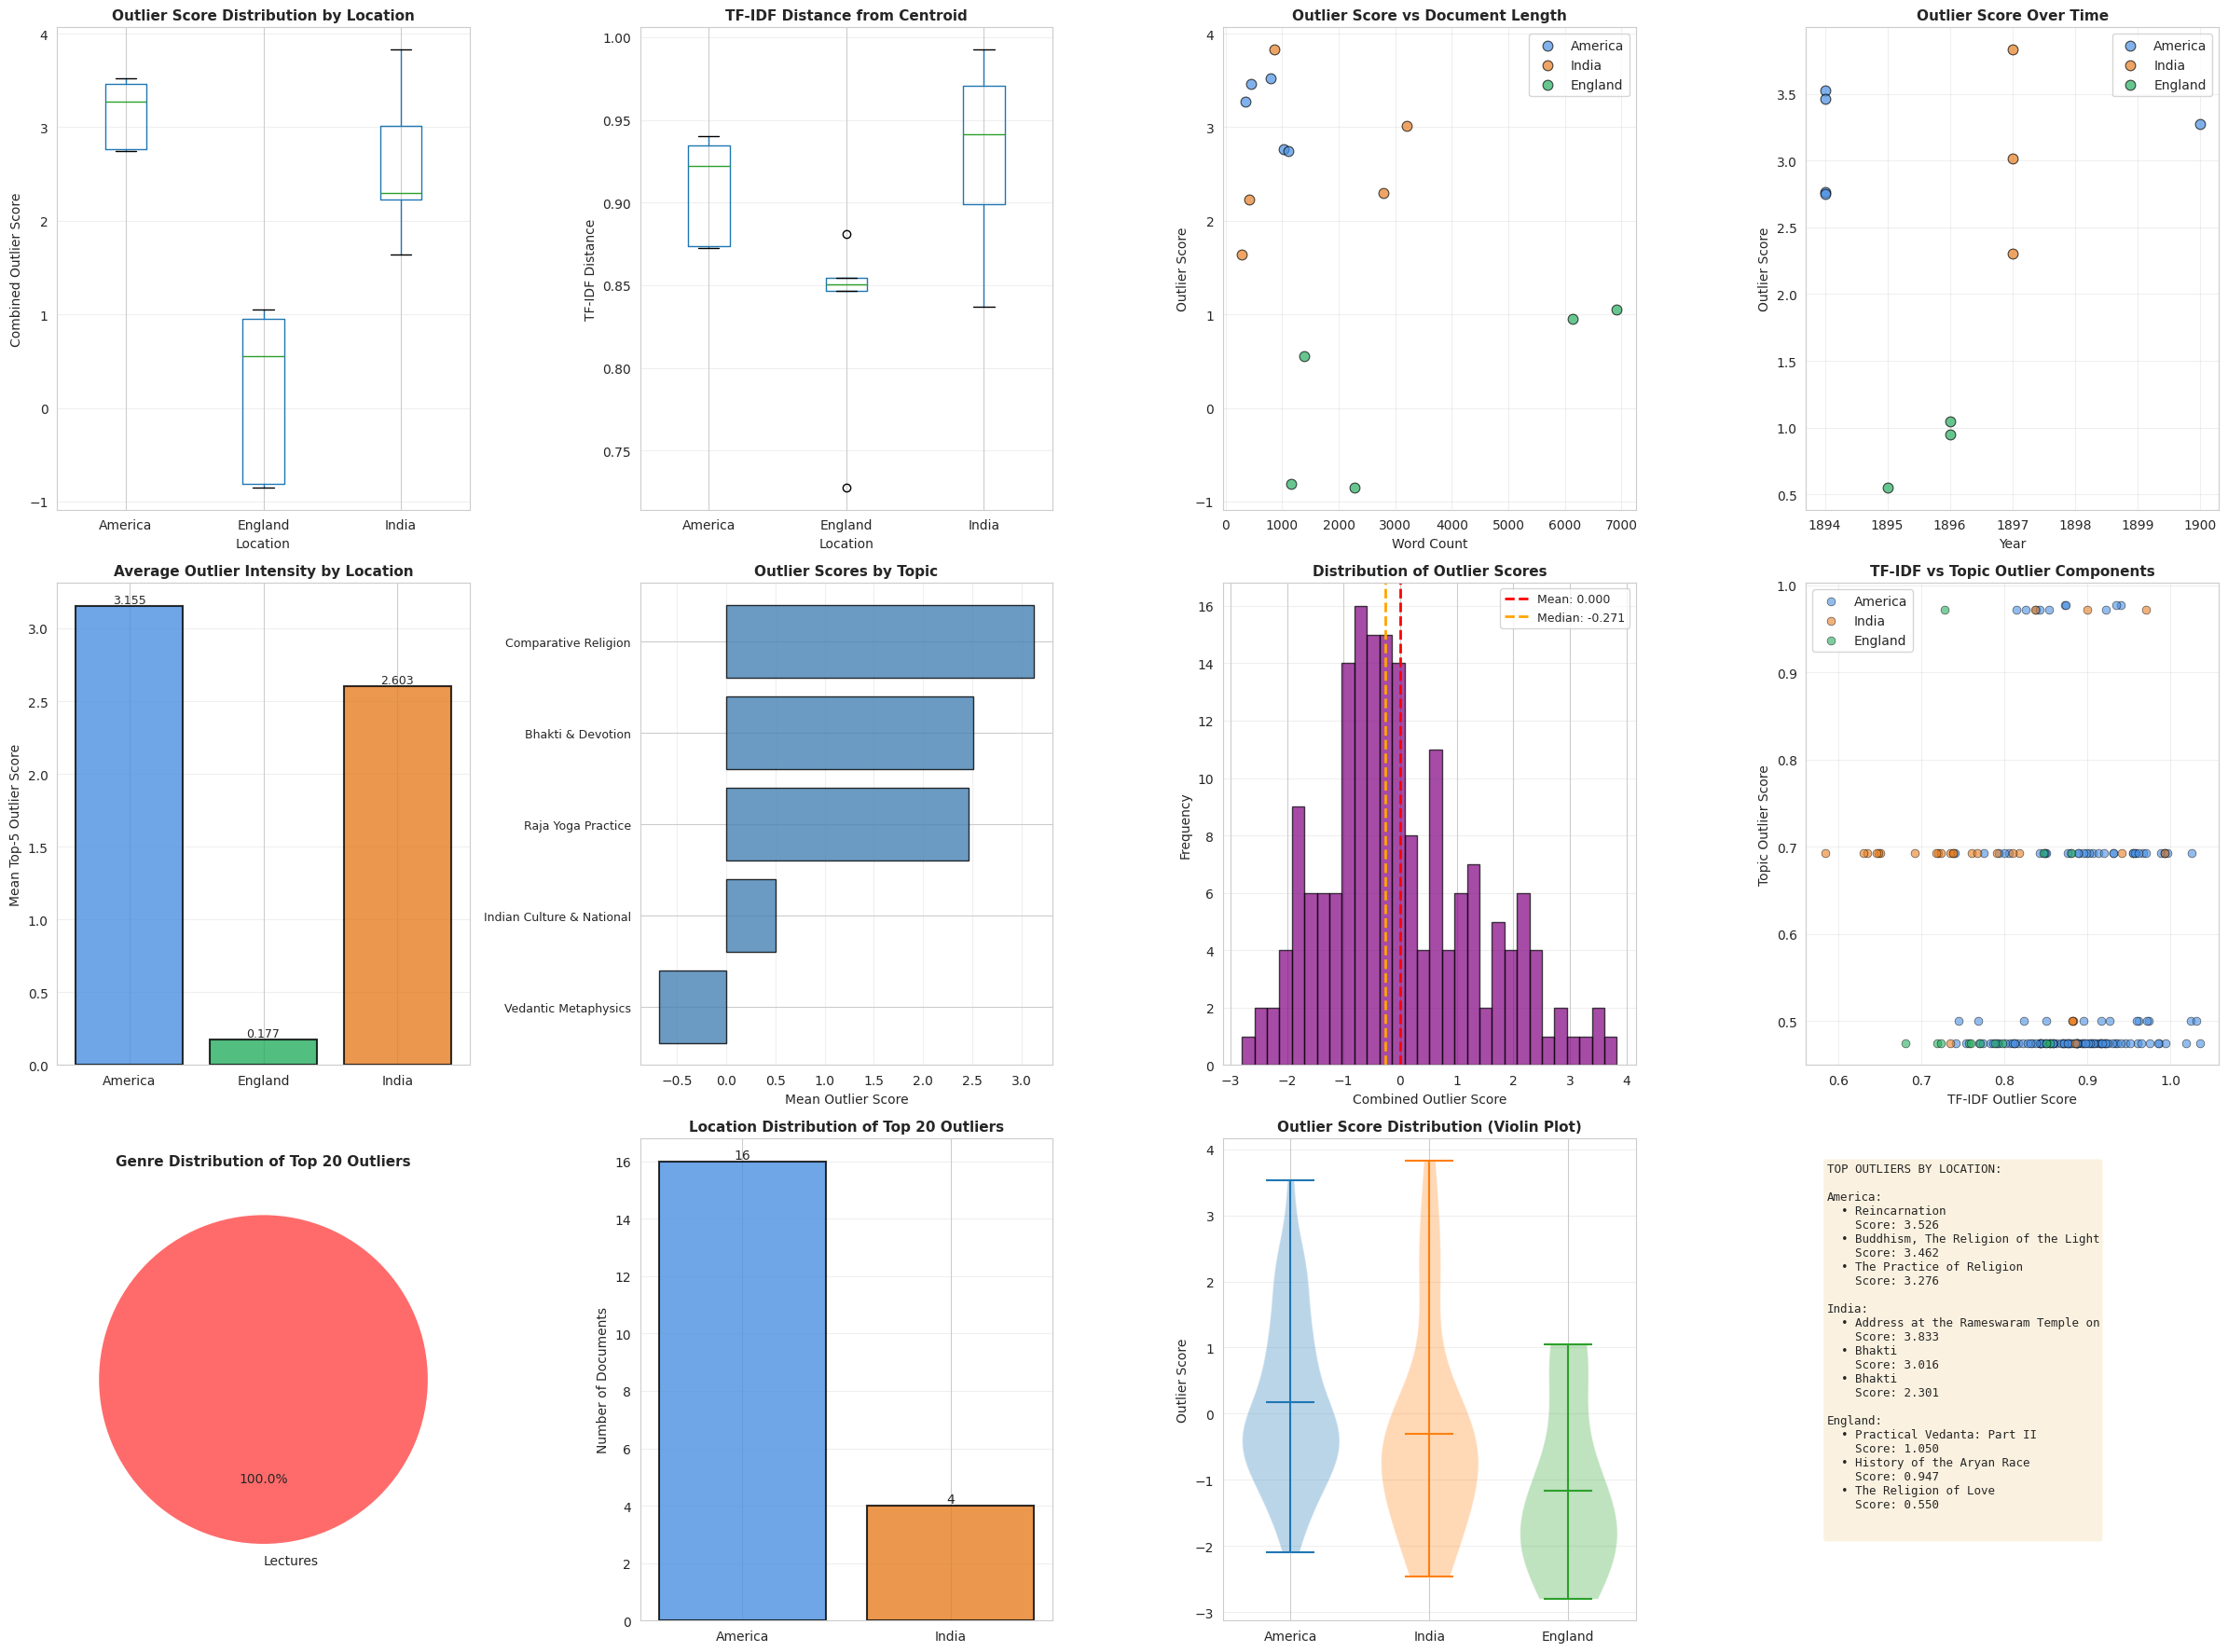


3D INTERACTIVE CLUSTERING VISUALIZATION
  Performing PCA for 3D clustering...
  Explained variance: 13.01%
  PC1: 5.42%
  PC2: 4.34%
  PC3: 3.25%


  ✓ Interactive 3D clustering visualization created!

✓ OUTLIER ANALYSIS COMPLETE

Key Statistics:
  Total documents: 179
  Mean outlier score: 0.000
  Std outlier score: 1.358
  Max outlier score: 3.833
  Min outlier score: -2.797


In [44]:
# ============================================================================
# REQUIREMENT 1: OUTLIER ANALYSIS (FIXED)
# ============================================================================

print("\n" + "="*80)
print("REQUIREMENT 1: OUTLIER ANALYSIS")
print("="*80)

print("\nComputing outlier metrics...")

# Metric 1: TF-IDF based semantic distance
print("  1/3: TF-IDF document embeddings...")
tfidf_vec = TfidfVectorizer(max_features=500, min_df=2, max_df=0.8, stop_words='english')
tfidf_matrix = tfidf_vec.fit_transform(df_public['plaintext_clean'].fillna(''))

# Metric 2: Distance from location centroid in TF-IDF space
print("  2/3: Computing distances from location centroids...")
df_public['tfidf_outlier_score'] = 0.0

for loc in ['America', 'India', 'England']:
    loc_mask = df_public['main_location'] == loc
    loc_indices = df_public[loc_mask].index

    if len(loc_indices) > 1:
        loc_positions = [df_public.index.get_loc(idx) for idx in loc_indices]
        loc_tfidf = tfidf_matrix[loc_positions]
        centroid = loc_tfidf.mean(axis=0).A1

        for idx, pos in zip(loc_indices, loc_positions):
            doc_vec = tfidf_matrix[pos].toarray()[0]
            distance = euclidean(doc_vec, centroid)
            df_public.at[idx, 'tfidf_outlier_score'] = distance

# Metric 3: Topic probability deviation
print("  3/3: Computing topic probability scores...")
if 'topic_name' in df_public.columns:
    topic_counts = df_public['topic_name'].value_counts()
    topic_prob = topic_counts / len(df_public)
    df_public['topic_certainty'] = df_public['topic_name'].map(topic_prob)
    df_public['topic_outlier_score'] = 1 - df_public['topic_certainty'].fillna(0.5)
else:
    df_public['topic_outlier_score'] = 0.0

# Combined outlier score (FIXED - handles NaN properly)
tfidf_scores = df_public['tfidf_outlier_score']
topic_scores = df_public['topic_outlier_score']

if tfidf_scores.std() > 0:
    tfidf_normalized = (tfidf_scores - tfidf_scores.mean()) / tfidf_scores.std()
else:
    tfidf_normalized = tfidf_scores - tfidf_scores.mean()

if topic_scores.std() > 0:
    topic_normalized = (topic_scores - topic_scores.mean()) / topic_scores.std()
else:
    topic_normalized = topic_scores - topic_scores.mean()

df_public['combined_outlier_score'] = (tfidf_normalized + topic_normalized).fillna(0)

# Top outliers per location
print("\n" + "-"*80)
print("TOP 5 OUTLIERS PER LOCATION")
print("-"*80)

outlier_results = []
for loc in ['America', 'India', 'England']:
    loc_docs = df_public[df_public['main_location']==loc].copy()

    if len(loc_docs) > 0:
        loc_outliers = loc_docs.nlargest(5, 'combined_outlier_score')

        print(f"\n{loc.upper()}:")
        for i, (idx, row) in enumerate(loc_outliers.iterrows(), 1):
            print(f"  {i}. {row['Name'][:60]}")
            print(f"     Year: {int(row['year']) if pd.notna(row['year']) else 'Unknown'}, "
                  f"Genre: {row['genre']}, Topic: {row.get('topic_name', 'Unknown')}")
            print(f"     Outlier Score: {row['combined_outlier_score']:.3f}, "
                  f"TF-IDF: {row['tfidf_outlier_score']:.3f}, Words: {row['word_count_clean']}")

            outlier_results.append({
                'location': loc,
                'title': row['Name'][:50],
                'year': int(row['year']) if pd.notna(row['year']) else None,
                'genre': row['genre'],
                'topic': row.get('topic_name', 'Unknown'),
                'outlier_score': row['combined_outlier_score'],
                'tfidf_score': row['tfidf_outlier_score'],
                'word_count': row['word_count_clean']
            })

outlier_df = pd.DataFrame(outlier_results)

# ============================================================================
# REQUIREMENT 2: DOCUMENT SIMILARITY NETWORK (IMPROVED)
# ============================================================================

print("\n" + "="*80)
print("REQUIREMENT 2: DOCUMENT SIMILARITY NETWORK")
print("="*80)

print("\nBuilding similarity network...")

# Compute pairwise cosine similarity
print("  Computing pairwise similarities...")
similarity_matrix = cosine_similarity(tfidf_matrix)

# Build network with threshold
threshold = 0.3
print(f"  Building graph with threshold={threshold}...")

G = nx.Graph()

# Add nodes with metadata
for idx, row in df_public.iterrows():
    G.add_node(idx,
              title=row['Name'][:40],
              location=row['main_location'],
              topic=row.get('topic_name', 'Unknown'),
              year=int(row['year']) if pd.notna(row['year']) else 1895,
              word_count=row['word_count_clean'],
              outlier_score=row['combined_outlier_score'])

# Add edges
print("  Adding edges...")
for i in range(len(df_public)):
    for j in range(i+1, len(df_public)):
        sim = similarity_matrix[i, j]
        if sim > threshold:
            idx_i = df_public.index[i]
            idx_j = df_public.index[j]
            G.add_edge(idx_i, idx_j, weight=sim)

print(f"  Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Compute network metrics
print("\nComputing network metrics...")
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

nx.set_node_attributes(G, degree_centrality, 'degree_centrality')
nx.set_node_attributes(G, betweenness_centrality, 'betweenness_centrality')

# Bridge documents
bridge_docs = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("\n" + "-"*80)
print("TOP 10 BRIDGE DOCUMENTS (High Betweenness Centrality)")
print("-"*80)
for rank, (idx, bc) in enumerate(bridge_docs, 1):
    if idx in df_public.index:
        row = df_public.loc[idx]
        print(f"\n{rank}. {row['Name'][:65]}")
        print(f"   Location: {row['main_location']}, Topic: {row.get('topic_name', 'Unknown')}")
        print(f"   Betweenness: {bc:.4f}, Degree: {degree_centrality[idx]:.4f}")

# Isolated/weakly connected
isolated = [n for n in G.nodes() if G.degree(n) <= 1]
print(f"\n" + "-"*80)
print(f"ISOLATED/WEAKLY CONNECTED: {len(isolated)} documents")
print("-"*80)
for idx in isolated[:10]:
    if idx in df_public.index:
        row = df_public.loc[idx]
        print(f"  {row['Name'][:60]} ({row['main_location']}, {row.get('topic_name', 'Unknown')})")

# ============================================================================
# 2D VISUALIZATIONS - OUTLIER ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("OUTLIER ANALYSIS VISUALIZATIONS")
print("="*80)

# Create comprehensive visualization panel
fig = plt.figure(figsize=(24, 18))

# 1. Outlier Score Distribution by Location
ax1 = plt.subplot(3, 4, 1)
outlier_df.boxplot(column='outlier_score', by='location', ax=ax1)
ax1.set_title('Outlier Score Distribution by Location', fontweight='bold', fontsize=11)
ax1.set_xlabel('Location')
ax1.set_ylabel('Combined Outlier Score')
plt.suptitle('')
ax1.grid(axis='y', alpha=0.3)

# 2. TF-IDF Distance Distribution by Location
ax2 = plt.subplot(3, 4, 2)
outlier_df.boxplot(column='tfidf_score', by='location', ax=ax2)
ax2.set_title('TF-IDF Distance from Centroid', fontweight='bold', fontsize=11)
ax2.set_xlabel('Location')
ax2.set_ylabel('TF-IDF Distance')
plt.suptitle('')
ax2.grid(axis='y', alpha=0.3)

# 3. Outlier Score vs Word Count
ax3 = plt.subplot(3, 4, 3)
for loc, color in location_colors_map.items():
    loc_data = outlier_df[outlier_df['location']==loc]
    ax3.scatter(loc_data['word_count'], loc_data['outlier_score'],
               c=color, alpha=0.7, s=60, label=loc, edgecolors='black', linewidth=0.8)
ax3.set_xlabel('Word Count')
ax3.set_ylabel('Outlier Score')
ax3.set_title('Outlier Score vs Document Length', fontweight='bold', fontsize=11)
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Outlier Score vs Year
ax4 = plt.subplot(3, 4, 4)
for loc, color in location_colors_map.items():
    loc_data = outlier_df[outlier_df['location']==loc]
    loc_data_clean = loc_data[loc_data['year'].notna()]
    ax4.scatter(loc_data_clean['year'], loc_data_clean['outlier_score'],
               c=color, alpha=0.7, s=60, label=loc, edgecolors='black', linewidth=0.8)
ax4.set_xlabel('Year')
ax4.set_ylabel('Outlier Score')
ax4.set_title('Outlier Score Over Time', fontweight='bold', fontsize=11)
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Top Outliers by Location (Bar Chart)
ax5 = plt.subplot(3, 4, 5)
top_outliers_by_loc = df_public.groupby('main_location')['combined_outlier_score'].apply(
    lambda x: x.nlargest(5).mean()
)
bars = ax5.bar(top_outliers_by_loc.index, top_outliers_by_loc.values,
              color=[location_colors_map[loc] for loc in top_outliers_by_loc.index],
              alpha=0.8, edgecolor='black', linewidth=1.5)
ax5.set_ylabel('Mean Top-5 Outlier Score')
ax5.set_title('Average Outlier Intensity by Location', fontweight='bold', fontsize=11)
ax5.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 6. Outlier Distribution by Topic
ax6 = plt.subplot(3, 4, 6)
if 'topic_name' in df_public.columns and df_public['topic_name'].notna().any():
    topic_outliers = df_public.groupby('topic_name')['combined_outlier_score'].mean().sort_values(ascending=False)
    if len(topic_outliers) > 0:
        ax6.barh(range(len(topic_outliers)), topic_outliers.values,
                color='steelblue', alpha=0.8, edgecolor='black', linewidth=1)
        ax6.set_yticks(range(len(topic_outliers)))
        ax6.set_yticklabels([t[:25] for t in topic_outliers.index], fontsize=9)
        ax6.set_xlabel('Mean Outlier Score')
        ax6.set_title('Outlier Scores by Topic', fontweight='bold', fontsize=11)
        ax6.invert_yaxis()
        ax6.grid(axis='x', alpha=0.3)
else:
    ax6.text(0.5, 0.5, 'Topic data not available', ha='center', va='center', transform=ax6.transAxes)
    ax6.axis('off')

# 7. Histogram of Combined Outlier Scores
ax7 = plt.subplot(3, 4, 7)
ax7.hist(df_public['combined_outlier_score'], bins=30,
         color='purple', alpha=0.7, edgecolor='black')
ax7.axvline(df_public['combined_outlier_score'].mean(), color='red',
           linestyle='--', linewidth=2, label=f'Mean: {df_public["combined_outlier_score"].mean():.3f}')
ax7.axvline(df_public['combined_outlier_score'].median(), color='orange',
           linestyle='--', linewidth=2, label=f'Median: {df_public["combined_outlier_score"].median():.3f}')
ax7.set_xlabel('Combined Outlier Score')
ax7.set_ylabel('Frequency')
ax7.set_title('Distribution of Outlier Scores', fontweight='bold', fontsize=11)
ax7.legend(fontsize=9)
ax7.grid(axis='y', alpha=0.3)

# 8. TF-IDF vs Topic Outlier Scores
ax8 = plt.subplot(3, 4, 8)
for loc, color in location_colors_map.items():
    loc_data = df_public[df_public['main_location']==loc]
    ax8.scatter(loc_data['tfidf_outlier_score'], loc_data['topic_outlier_score'],
               c=color, alpha=0.6, s=40, label=loc, edgecolors='black', linewidth=0.5)
ax8.set_xlabel('TF-IDF Outlier Score')
ax8.set_ylabel('Topic Outlier Score')
ax8.set_title('TF-IDF vs Topic Outlier Components', fontweight='bold', fontsize=11)
ax8.legend()
ax8.grid(alpha=0.3)

# 9. Genre Distribution of Top Outliers
ax9 = plt.subplot(3, 4, 9)
top_outliers = df_public.nlargest(20, 'combined_outlier_score')
genre_counts = top_outliers['genre'].value_counts()
ax9.pie(genre_counts.values, labels=genre_counts.index, autopct='%1.1f%%',
       startangle=90, colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax9.set_title('Genre Distribution of Top 20 Outliers', fontweight='bold', fontsize=11)

# 10. Location Distribution of Top Outliers
ax10 = plt.subplot(3, 4, 10)
location_counts = top_outliers['main_location'].value_counts()
bars = ax10.bar(location_counts.index, location_counts.values,
               color=[location_colors_map[loc] for loc in location_counts.index],
               alpha=0.8, edgecolor='black', linewidth=1.5)
ax10.set_ylabel('Number of Documents')
ax10.set_title('Location Distribution of Top 20 Outliers', fontweight='bold', fontsize=11)
ax10.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax10.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

# 11. Outlier Score Range by Location
ax11 = plt.subplot(3, 4, 11)
for loc, color in location_colors_map.items():
    loc_data = df_public[df_public['main_location']==loc]['combined_outlier_score']
    ax11.violinplot([loc_data], positions=[list(location_colors_map.keys()).index(loc)],
                    widths=0.7, showmeans=True, showextrema=True)
ax11.set_xticks(range(len(location_colors_map)))
ax11.set_xticklabels(location_colors_map.keys())
ax11.set_ylabel('Outlier Score')
ax11.set_title('Outlier Score Distribution (Violin Plot)', fontweight='bold', fontsize=11)
ax11.grid(axis='y', alpha=0.3)

# 12. Top Outliers Summary Text
ax12 = plt.subplot(3, 4, 12)
ax12.axis('off')
outlier_text = "TOP OUTLIERS BY LOCATION:\n\n"
for loc in ['America', 'India', 'England']:
    outlier_text += f"{loc}:\n"
    loc_outliers = outlier_df[outlier_df['location']==loc].nlargest(3, 'outlier_score')
    for _, row in loc_outliers.iterrows():
        outlier_text += f"  • {row['title'][:35]}\n"
        outlier_text += f"    Score: {row['outlier_score']:.3f}\n"
    outlier_text += "\n"

ax12.text(0.05, 0.95, outlier_text, transform=ax12.transAxes,
         fontsize=9, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.4))

plt.tight_layout()
plt.show()

# ============================================================================
# 3D INTERACTIVE CLUSTERING VISUALIZATION (PLOTLY)
# ============================================================================

print("\n" + "="*80)
print("3D INTERACTIVE CLUSTERING VISUALIZATION")
print("="*80)

try:
    import plotly.graph_objects as go
    from sklearn.decomposition import PCA

    print("  Performing PCA for 3D clustering...")

    # Use TF-IDF matrix for PCA
    pca = PCA(n_components=3, random_state=42)
    coords_3d = pca.fit_transform(tfidf_matrix.toarray())

    print(f"  Explained variance: {pca.explained_variance_ratio_.sum():.2%}")
    print(f"  PC1: {pca.explained_variance_ratio_[0]:.2%}")
    print(f"  PC2: {pca.explained_variance_ratio_[1]:.2%}")
    print(f"  PC3: {pca.explained_variance_ratio_[2]:.2%}")

    # Prepare data
    x_coords = coords_3d[:, 0]
    y_coords = coords_3d[:, 1]
    z_coords = coords_3d[:, 2]

    locations = df_public['main_location'].values
    topics = df_public['topic_name'].values if 'topic_name' in df_public.columns else ['Unknown'] * len(df_public)
    titles = df_public['Name'].values
    years = df_public['year'].values
    outlier_scores = df_public['combined_outlier_score'].values
    word_counts = df_public['word_count_clean'].values

    # Create hover text
    hover_text = []
    for i in range(len(df_public)):
        text = (f"<b>{titles[i][:50]}</b><br>"
                f"Location: {locations[i]}<br>"
                f"Topic: {topics[i]}<br>"
                f"Year: {int(years[i]) if pd.notna(years[i]) else 'Unknown'}<br>"
                f"Outlier Score: {outlier_scores[i]:.3f}<br>"
                f"Word Count: {word_counts[i]}")
        hover_text.append(text)

    # Create traces by location (clusters)
    traces = []
    for loc, color in location_colors_map.items():
        loc_mask = locations == loc

        trace = go.Scatter3d(
            x=x_coords[loc_mask],
            y=y_coords[loc_mask],
            z=z_coords[loc_mask],
            mode='markers',
            name=loc,
            marker=dict(
                size=8,
                color=color,
                opacity=0.7,
                line=dict(color='black', width=0.5),
                symbol='circle'
            ),
            text=[hover_text[i] for i in range(len(hover_text)) if loc_mask[i]],
            hoverinfo='text'
        )
        traces.append(trace)

    # Highlight top outliers
    top_n = 15
    top_outlier_indices = df_public.nlargest(top_n, 'combined_outlier_score').index
    top_outlier_positions = [df_public.index.get_loc(idx) for idx in top_outlier_indices]

    outlier_trace = go.Scatter3d(
        x=x_coords[top_outlier_positions],
        y=y_coords[top_outlier_positions],
        z=z_coords[top_outlier_positions],
        mode='markers+text',
        name=f'Top {top_n} Outliers',
        marker=dict(
            size=12,
            color='red',
            opacity=0.9,
            line=dict(color='darkred', width=2),
            symbol='diamond'
        ),
        text=[f"#{i+1}" for i in range(len(top_outlier_positions))],
        textposition='top center',
        textfont=dict(size=8, color='darkred'),
        hovertext=[hover_text[i] for i in top_outlier_positions],
        hoverinfo='text'
    )
    traces.append(outlier_trace)

    # Create figure
    fig_plotly = go.Figure(data=traces)

    # Update layout
    fig_plotly.update_layout(
        title=dict(
            text=f'3D Document Clustering via PCA<br><sub>Explained variance: {pca.explained_variance_ratio_.sum():.1%} | Red diamonds = Top {top_n} outliers | Drag to rotate</sub>',
            x=0.5,
            xanchor='center',
            font=dict(size=16)
        ),
        scene=dict(
            xaxis=dict(
                title=f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)',
                backgroundcolor='rgb(240, 240, 240)',
                gridcolor='white',
                showbackground=True
            ),
            yaxis=dict(
                title=f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)',
                backgroundcolor='rgb(240, 240, 240)',
                gridcolor='white',
                showbackground=True
            ),
            zaxis=dict(
                title=f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)',
                backgroundcolor='rgb(240, 240, 240)',
                gridcolor='white',
                showbackground=True
            ),
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.3)
            )
        ),
        showlegend=True,
        legend=dict(
            x=0.02,
            y=0.98,
            bgcolor='rgba(255,255,255,0.9)',
            bordercolor='black',
            borderwidth=1
        ),
        width=1400,
        height=1000,
        hovermode='closest'
    )

    fig_plotly.show()
    print("  ✓ Interactive 3D clustering visualization created!")

except ImportError:
    print("  Note: Install required packages with: pip install plotly scikit-learn")
except Exception as e:
    print(f"  Error creating Plotly visualization: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "="*80)
print("✓ OUTLIER ANALYSIS COMPLETE")
print("="*80)
print(f"\nKey Statistics:")
print(f"  Total documents: {len(df_public)}")
print(f"  Mean outlier score: {df_public['combined_outlier_score'].mean():.3f}")
print(f"  Std outlier score: {df_public['combined_outlier_score'].std():.3f}")
print(f"  Max outlier score: {df_public['combined_outlier_score'].max():.3f}")
print(f"  Min outlier score: {df_public['combined_outlier_score'].min():.3f}")

ANOMALY PROBING IN PUBLIC DISCOURSE

DIRECTION 1: INSPIRED TALKS ANOMALY ANALYSIS

Identifying Inspired Talks subset...
  Found 44 Inspired Talks documents

  Inspired Talks topic distribution:
    Vedantic Metaphysics: 44

  Computing linguistic metrics...
  Computing embedding distances to location centroids...

--------------------------------------------------------------------------------
COMPARISON TABLE: INSPIRED TALKS VS NON-INSPIRED TALKS
--------------------------------------------------------------------------------
               Group   N Embedding Distance Lexical Density Sentence Variance Topic Entropy  Outlier Score
Inspired Talks (All)  44    0.9007 ± 0.0507 0.4469 ± 0.0900    102.07 ± 40.89 6.099 ± 0.762 -0.279 ± 0.581
  Non-Inspired (All) 135    0.8496 ± 0.0930 0.3121 ± 0.1149   183.31 ± 156.03 6.782 ± 0.983  0.091 ± 1.519
Bhakti: Non-Inspired   5    0.8552 ± 0.0894 0.2483 ± 0.0690   233.38 ± 146.80 7.240 ± 0.644  2.513 ± 1.025


DIRECTION 2: SRI RAMAKRISHNA MENTIONS

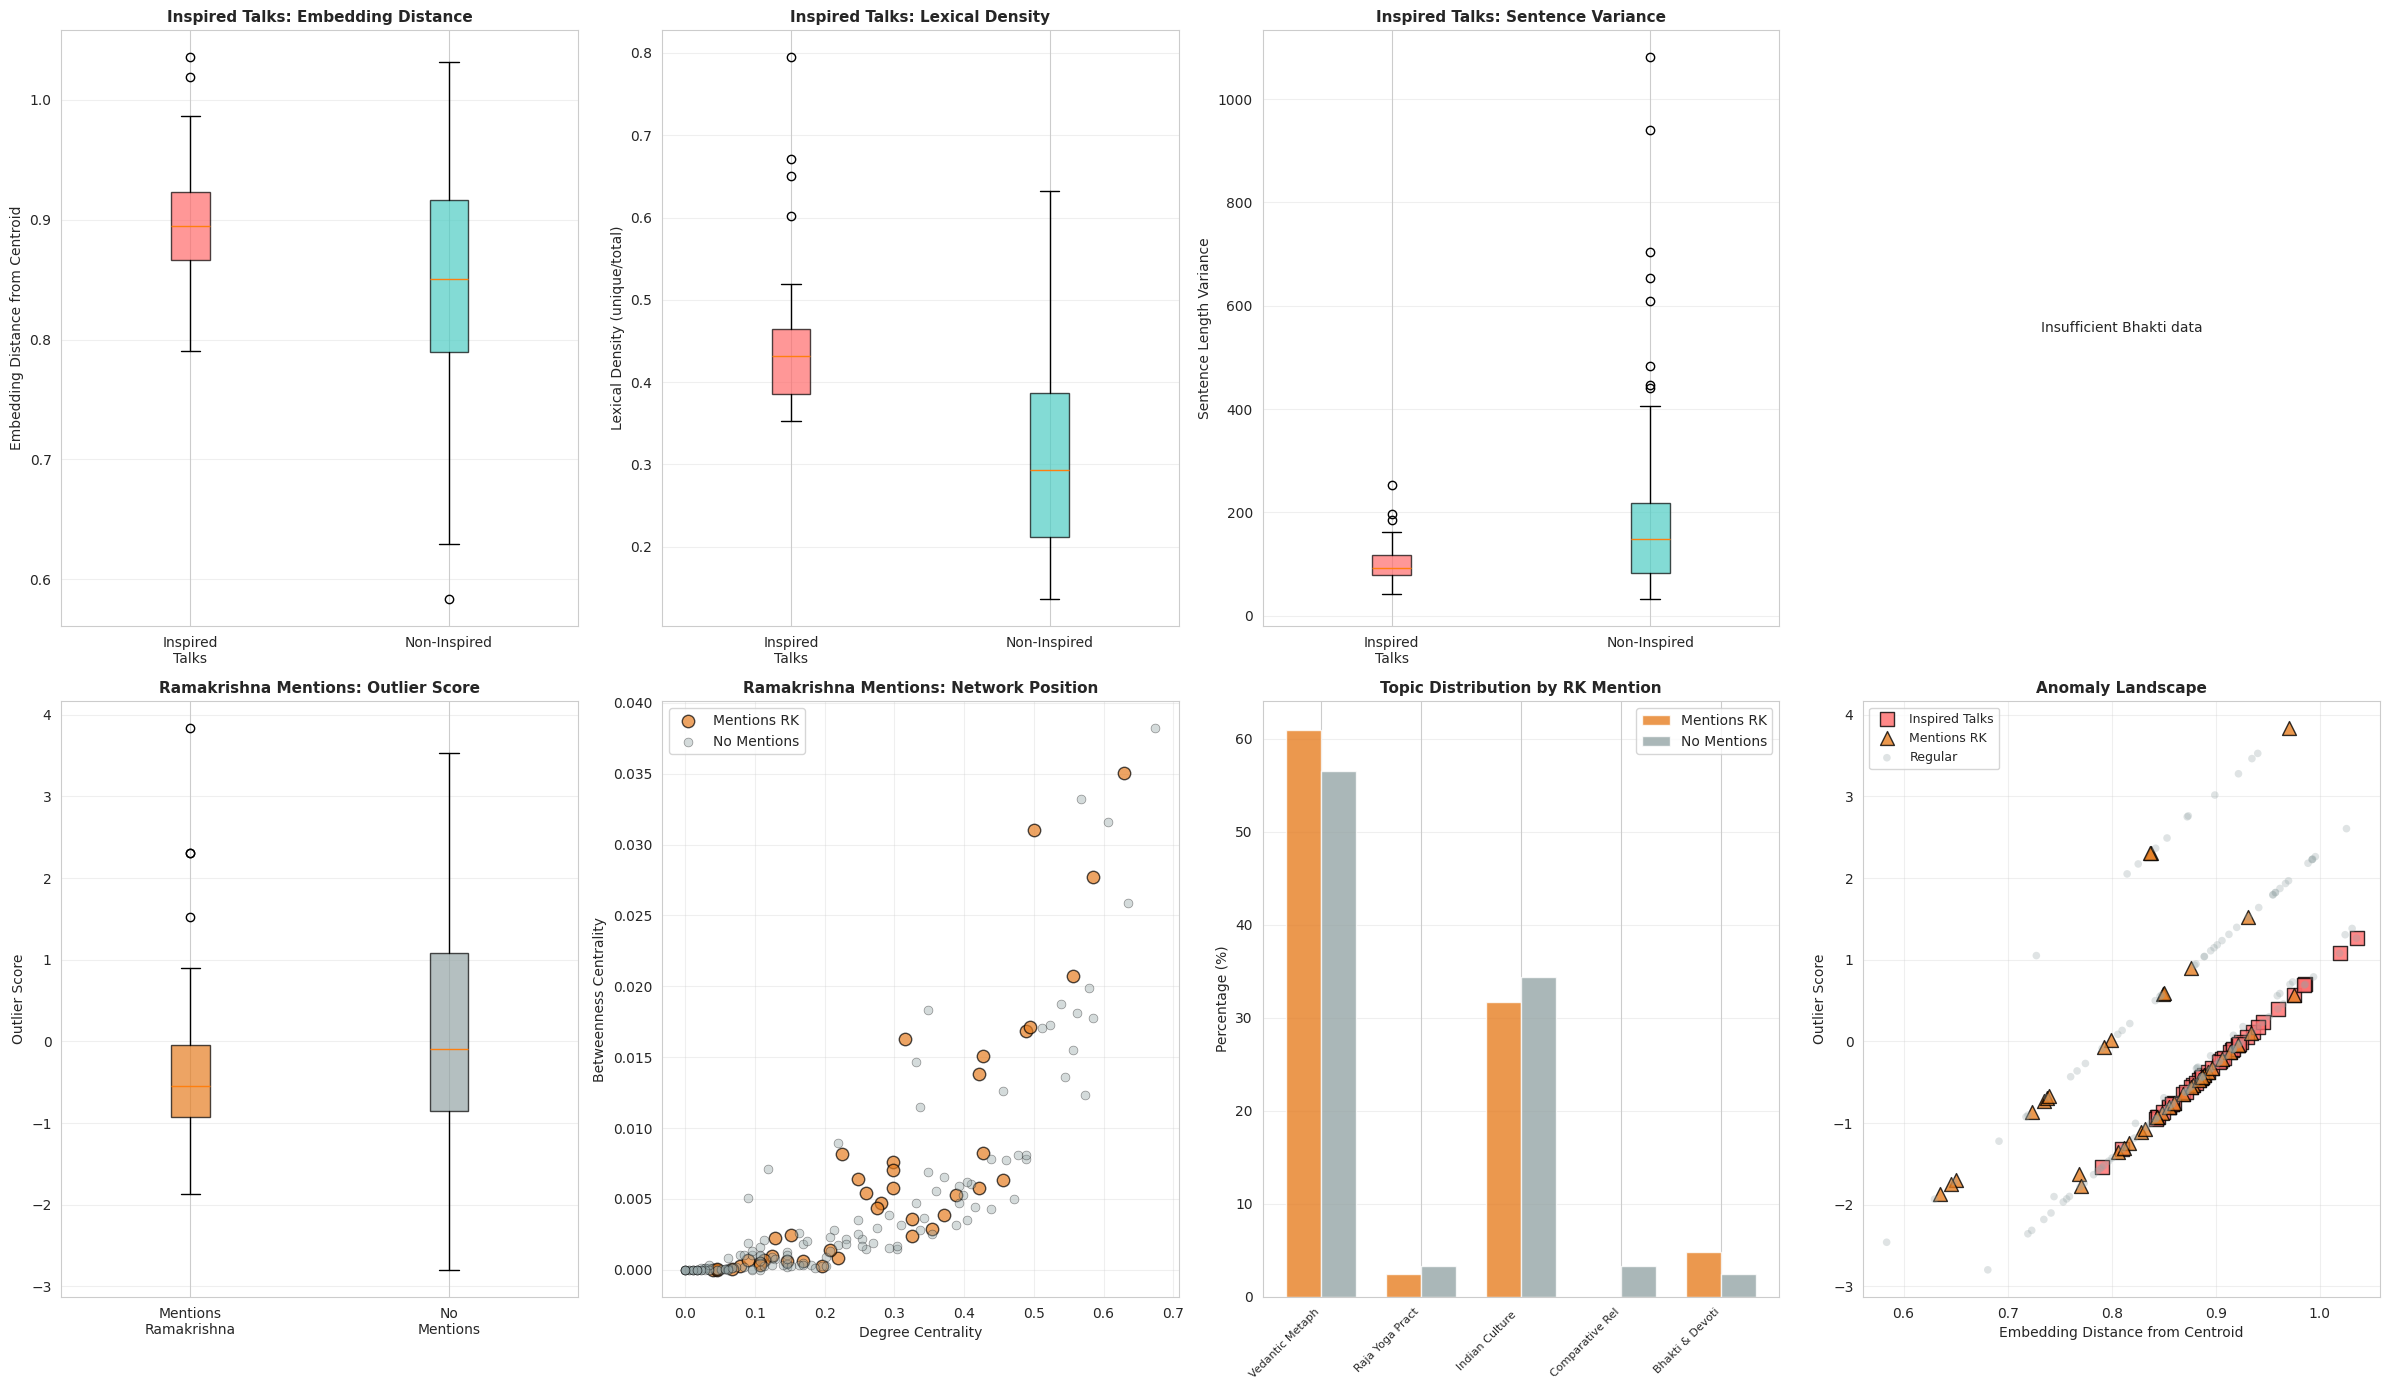


✓ FOCUSED ANOMALY PROBING COMPLETE


In [45]:
# ============================================================================
# FOCUSED ANOMALY PROBING: INSPIRED TALKS & SRI RAMAKRISHNA MENTIONS
# ============================================================================

import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("ANOMALY PROBING IN PUBLIC DISCOURSE")
print("="*80)

# ============================================================================
# DIRECTION 1: INSPIRED TALKS VS TOPIC EFFECT
# ============================================================================

print("\n" + "="*80)
print("DIRECTION 1: INSPIRED TALKS ANOMALY ANALYSIS")
print("="*80)

# Identify Inspired Talks
print("\nIdentifying Inspired Talks subset...")
df_public['is_inspired_talks'] = df_public['Name'].str.contains('Inspired Talks', case=False, na=False)
inspired_count = df_public['is_inspired_talks'].sum()
print(f"  Found {inspired_count} Inspired Talks documents")

if inspired_count > 0:
    # Get topic distribution
    inspired_topics = df_public[df_public['is_inspired_talks']]['topic_name'].value_counts()
    print(f"\n  Inspired Talks topic distribution:")
    for topic, count in inspired_topics.items():
        print(f"    {topic}: {count}")

# Compute linguistic metrics
print("\n  Computing linguistic metrics...")

def compute_lexical_density(text):
    """Lexical density: unique words / total words"""
    if pd.isna(text) or len(text.strip()) == 0:
        return 0.0
    words = word_tokenize(text.lower())
    words = [w for w in words if w.isalpha()]
    if len(words) == 0:
        return 0.0
    return len(set(words)) / len(words)

def compute_sentence_length_variance(text):
    """Variance in sentence lengths"""
    if pd.isna(text) or len(text.strip()) == 0:
        return 0.0
    sentences = nltk.sent_tokenize(text)
    if len(sentences) <= 1:
        return 0.0
    lengths = [len(word_tokenize(s)) for s in sentences]
    return np.var(lengths)

def compute_topic_entropy(text, tfidf_vec):
    """Topic entropy based on term distribution"""
    if pd.isna(text) or len(text.strip()) == 0:
        return 0.0
    vec = tfidf_vec.transform([text]).toarray()[0]
    vec = vec[vec > 0]
    if len(vec) == 0:
        return 0.0
    probs = vec / vec.sum()
    return -np.sum(probs * np.log2(probs + 1e-10))

# Compute metrics
df_public['lexical_density'] = df_public['plaintext_clean'].apply(compute_lexical_density)
df_public['sentence_variance'] = df_public['plaintext_clean'].apply(compute_sentence_length_variance)
df_public['topic_entropy'] = df_public['plaintext_clean'].apply(lambda x: compute_topic_entropy(x, tfidf_vec))

# Recompute embedding distances to location centroids
print("  Computing embedding distances to location centroids...")
df_public['embedding_distance'] = 0.0

for loc in ['America', 'India', 'England']:
    loc_mask = (df_public['main_location'].astype(str).values == loc)
    loc_indices = df_public.index[loc_mask]


    if len(loc_indices) > 1:
        loc_positions = [df_public.index.get_loc(idx) for idx in loc_indices]
        loc_tfidf = tfidf_matrix[loc_positions]
        centroid = loc_tfidf.mean(axis=0).A1

        for idx, pos in zip(loc_indices, loc_positions):
            doc_vec = tfidf_matrix[pos].toarray()[0]
            distance = euclidean(doc_vec, centroid)
            df_public.at[idx, 'embedding_distance'] = distance

# Create comparison groups
inspired = df_public[df_public['is_inspired_talks']]
non_inspired = df_public[~df_public['is_inspired_talks']]

# Bhakti-specific comparison
bhakti_inspired = df_public[(df_public['is_inspired_talks']) & (df_public['topic_name'] == 'Bhakti & Devotion')]
bhakti_non_inspired = df_public[(~df_public['is_inspired_talks']) & (df_public['topic_name'] == 'Bhakti & Devotion')]

print("\n" + "-"*80)
print("COMPARISON TABLE: INSPIRED TALKS VS NON-INSPIRED TALKS")
print("-"*80)

comparison_data = []

# Overall comparison
if len(inspired) > 0:
    comparison_data.append({
        'Group': 'Inspired Talks (All)',
        'N': len(inspired),
        'Embedding Distance': f"{inspired['embedding_distance'].mean():.4f} ± {inspired['embedding_distance'].std():.4f}",
        'Lexical Density': f"{inspired['lexical_density'].mean():.4f} ± {inspired['lexical_density'].std():.4f}",
        'Sentence Variance': f"{inspired['sentence_variance'].mean():.2f} ± {inspired['sentence_variance'].std():.2f}",
        'Topic Entropy': f"{inspired['topic_entropy'].mean():.3f} ± {inspired['topic_entropy'].std():.3f}",
        'Outlier Score': f"{inspired['combined_outlier_score'].mean():.3f} ± {inspired['combined_outlier_score'].std():.3f}"
    })

comparison_data.append({
    'Group': 'Non-Inspired (All)',
    'N': len(non_inspired),
    'Embedding Distance': f"{non_inspired['embedding_distance'].mean():.4f} ± {non_inspired['embedding_distance'].std():.4f}",
    'Lexical Density': f"{non_inspired['lexical_density'].mean():.4f} ± {non_inspired['lexical_density'].std():.4f}",
    'Sentence Variance': f"{non_inspired['sentence_variance'].mean():.2f} ± {non_inspired['sentence_variance'].std():.2f}",
    'Topic Entropy': f"{non_inspired['topic_entropy'].mean():.3f} ± {non_inspired['topic_entropy'].std():.3f}",
    'Outlier Score': f"{non_inspired['combined_outlier_score'].mean():.3f} ± {non_inspired['combined_outlier_score'].std():.3f}"
})

# Bhakti-specific
if len(bhakti_inspired) > 0:
    comparison_data.append({
        'Group': 'Bhakti: Inspired',
        'N': len(bhakti_inspired),
        'Embedding Distance': f"{bhakti_inspired['embedding_distance'].mean():.4f} ± {bhakti_inspired['embedding_distance'].std():.4f}",
        'Lexical Density': f"{bhakti_inspired['lexical_density'].mean():.4f} ± {bhakti_inspired['lexical_density'].std():.4f}",
        'Sentence Variance': f"{bhakti_inspired['sentence_variance'].mean():.2f} ± {bhakti_inspired['sentence_variance'].std():.2f}",
        'Topic Entropy': f"{bhakti_inspired['topic_entropy'].mean():.3f} ± {bhakti_inspired['topic_entropy'].std():.3f}",
        'Outlier Score': f"{bhakti_inspired['combined_outlier_score'].mean():.3f} ± {bhakti_inspired['combined_outlier_score'].std():.3f}"
    })

if len(bhakti_non_inspired) > 0:
    comparison_data.append({
        'Group': 'Bhakti: Non-Inspired',
        'N': len(bhakti_non_inspired),
        'Embedding Distance': f"{bhakti_non_inspired['embedding_distance'].mean():.4f} ± {bhakti_non_inspired['embedding_distance'].std():.4f}",
        'Lexical Density': f"{bhakti_non_inspired['lexical_density'].mean():.4f} ± {bhakti_non_inspired['lexical_density'].std():.4f}",
        'Sentence Variance': f"{bhakti_non_inspired['sentence_variance'].mean():.2f} ± {bhakti_non_inspired['sentence_variance'].std():.2f}",
        'Topic Entropy': f"{bhakti_non_inspired['topic_entropy'].mean():.3f} ± {bhakti_non_inspired['topic_entropy'].std():.3f}",
        'Outlier Score': f"{bhakti_non_inspired['combined_outlier_score'].mean():.3f} ± {bhakti_non_inspired['combined_outlier_score'].std():.3f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# ============================================================================
# DIRECTION 2: SRI RAMAKRISHNA MENTIONS AS STRUCTURAL ANOMALIES
# ============================================================================

print("\n\n" + "="*80)
print("DIRECTION 2: SRI RAMAKRISHNA MENTIONS ANALYSIS")
print("="*80)

# Detect mentions - data-driven approach
print("\nDetecting Sri Ramakrishna mentions...")

# Common variants
ramakrishna_patterns = [
    'ramakrishna', 'sri ramakrishna', 'shri ramakrishna',
    'the master', 'my master', 'our master',
    'paramahamsa', 'paramhansa'
]

def contains_ramakrishna(text):
    if pd.isna(text):
        return False
    text_lower = text.lower()
    return any(pattern in text_lower for pattern in ramakrishna_patterns)

df_public['mentions_ramakrishna'] = df_public['plaintext_clean'].apply(contains_ramakrishna)
ramakrishna_count = df_public['mentions_ramakrishna'].sum()

print(f"  Found {ramakrishna_count} documents mentioning Sri Ramakrishna/Master")
print(f"  {len(df_public) - ramakrishna_count} documents without mention")

# Compute network centrality metrics (if not already present)
if degree_centrality and betweenness_centrality:
    df_public['degree_centrality'] = df_public.index.map(lambda x: degree_centrality.get(x, 0))
    df_public['betweenness_centrality'] = df_public.index.map(lambda x: betweenness_centrality.get(x, 0))

# Comparison
mentions_rk = df_public[df_public['mentions_ramakrishna']]
no_mentions_rk = df_public[~df_public['mentions_ramakrishna']]

print("\n" + "-"*80)
print("COMPARISON: RAMAKRISHNA MENTIONS VS NO MENTIONS")
print("-"*80)

rk_comparison = []

if len(mentions_rk) > 0:
    rk_comparison.append({
        'Group': 'Mentions Ramakrishna',
        'N': len(mentions_rk),
        'Outlier Score': f"{mentions_rk['combined_outlier_score'].mean():.4f} ± {mentions_rk['combined_outlier_score'].std():.4f}",
        'Degree Centrality': f"{mentions_rk['degree_centrality'].mean():.4f} ± {mentions_rk['degree_centrality'].std():.4f}",
        'Betweenness': f"{mentions_rk['betweenness_centrality'].mean():.4f} ± {mentions_rk['betweenness_centrality'].std():.4f}",
        'Embedding Distance': f"{mentions_rk['embedding_distance'].mean():.4f} ± {mentions_rk['embedding_distance'].std():.4f}"
    })

rk_comparison.append({
    'Group': 'No Mentions',
    'N': len(no_mentions_rk),
    'Outlier Score': f"{no_mentions_rk['combined_outlier_score'].mean():.4f} ± {no_mentions_rk['combined_outlier_score'].std():.4f}",
    'Degree Centrality': f"{no_mentions_rk['degree_centrality'].mean():.4f} ± {no_mentions_rk['degree_centrality'].std():.4f}",
    'Betweenness': f"{no_mentions_rk['betweenness_centrality'].mean():.4f} ± {no_mentions_rk['betweenness_centrality'].std():.4f}",
    'Embedding Distance': f"{no_mentions_rk['embedding_distance'].mean():.4f} ± {no_mentions_rk['embedding_distance'].std():.4f}"
})

rk_df = pd.DataFrame(rk_comparison)
print(rk_df.to_string(index=False))

# Topic distribution
print("\n" + "-"*80)
print("TOPIC DISTRIBUTION")
print("-"*80)

if len(mentions_rk) > 0 and 'topic_name' in df_public.columns:
    print("\nWith Ramakrishna mentions:")
    rk_topics = mentions_rk['topic_name'].value_counts()
    for topic, count in rk_topics.items():
        pct = (count / len(mentions_rk)) * 100
        print(f"  {topic}: {count} ({pct:.1f}%)")

    print("\nWithout Ramakrishna mentions:")
    no_rk_topics = no_mentions_rk['topic_name'].value_counts()
    for topic, count in no_rk_topics.items():
        pct = (count / len(no_mentions_rk)) * 100
        print(f"  {topic}: {count} ({pct:.1f}%)")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(24, 14))

# 1. Inspired Talks: Embedding Distance
ax1 = plt.subplot(2, 4, 1)
data_to_plot = []
labels_plot = []
if len(inspired) > 0:
    data_to_plot.append(inspired['embedding_distance'])
    labels_plot.append('Inspired\nTalks')
data_to_plot.append(non_inspired['embedding_distance'])
labels_plot.append('Non-Inspired')
bp1 = ax1.boxplot(data_to_plot, labels=labels_plot, patch_artist=True)
for patch, color in zip(bp1['boxes'], ['#FF6B6B', '#4ECDC4']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_ylabel('Embedding Distance from Centroid')
ax1.set_title('Inspired Talks: Embedding Distance', fontweight='bold', fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# 2. Inspired Talks: Lexical Density
ax2 = plt.subplot(2, 4, 2)
data_to_plot = []
if len(inspired) > 0:
    data_to_plot.append(inspired['lexical_density'])
data_to_plot.append(non_inspired['lexical_density'])
bp2 = ax2.boxplot(data_to_plot, labels=labels_plot, patch_artist=True)
for patch, color in zip(bp2['boxes'], ['#FF6B6B', '#4ECDC4']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_ylabel('Lexical Density (unique/total)')
ax2.set_title('Inspired Talks: Lexical Density', fontweight='bold', fontsize=11)
ax2.grid(axis='y', alpha=0.3)

# 3. Inspired Talks: Sentence Variance
ax3 = plt.subplot(2, 4, 3)
data_to_plot = []
if len(inspired) > 0:
    data_to_plot.append(inspired['sentence_variance'])
data_to_plot.append(non_inspired['sentence_variance'])
bp3 = ax3.boxplot(data_to_plot, labels=labels_plot, patch_artist=True)
for patch, color in zip(bp3['boxes'], ['#FF6B6B', '#4ECDC4']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax3.set_ylabel('Sentence Length Variance')
ax3.set_title('Inspired Talks: Sentence Variance', fontweight='bold', fontsize=11)
ax3.grid(axis='y', alpha=0.3)

# 4. Bhakti Comparison (if data exists)
ax4 = plt.subplot(2, 4, 4)
if len(bhakti_inspired) > 0 and len(bhakti_non_inspired) > 0:
    bhakti_data = [bhakti_inspired['embedding_distance'], bhakti_non_inspired['embedding_distance']]
    bp4 = ax4.boxplot(bhakti_data, labels=['Bhakti\nInspired', 'Bhakti\nNon-Inspired'], patch_artist=True)
    for patch, color in zip(bp4['boxes'], ['#FF6B6B', '#4ECDC4']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax4.set_ylabel('Embedding Distance')
    ax4.set_title('Bhakti Topic: Inspired vs Non-Inspired', fontweight='bold', fontsize=11)
    ax4.grid(axis='y', alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'Insufficient Bhakti data', ha='center', va='center', transform=ax4.transAxes)
    ax4.axis('off')

# 5. Ramakrishna: Outlier Score
ax5 = plt.subplot(2, 4, 5)
if len(mentions_rk) > 0:
    rk_data = [mentions_rk['combined_outlier_score'], no_mentions_rk['combined_outlier_score']]
    bp5 = ax5.boxplot(rk_data, labels=['Mentions\nRamakrishna', 'No\nMentions'], patch_artist=True)
    for patch, color in zip(bp5['boxes'], ['#E67E22', '#95A5A6']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax5.set_ylabel('Outlier Score')
    ax5.set_title('Ramakrishna Mentions: Outlier Score', fontweight='bold', fontsize=11)
    ax5.grid(axis='y', alpha=0.3)

# 6. Ramakrishna: Network Centrality
ax6 = plt.subplot(2, 4, 6)
if len(mentions_rk) > 0:
    ax6.scatter(mentions_rk['degree_centrality'], mentions_rk['betweenness_centrality'],
               c='#E67E22', s=80, alpha=0.7, label='Mentions RK', edgecolors='black', linewidth=1)
    ax6.scatter(no_mentions_rk['degree_centrality'], no_mentions_rk['betweenness_centrality'],
               c='#95A5A6', s=40, alpha=0.4, label='No Mentions', edgecolors='black', linewidth=0.5)
    ax6.set_xlabel('Degree Centrality')
    ax6.set_ylabel('Betweenness Centrality')
    ax6.set_title('Ramakrishna Mentions: Network Position', fontweight='bold', fontsize=11)
    ax6.legend()
    ax6.grid(alpha=0.3)

# 7. Ramakrishna: Topic Distribution
ax7 = plt.subplot(2, 4, 7)
if len(mentions_rk) > 0 and 'topic_name' in df_public.columns:
    rk_topic_pct = mentions_rk['topic_name'].value_counts(normalize=True) * 100
    no_rk_topic_pct = no_mentions_rk['topic_name'].value_counts(normalize=True) * 100

    all_topics = list(set(rk_topic_pct.index) | set(no_rk_topic_pct.index))
    x_pos = np.arange(len(all_topics))
    width = 0.35

    rk_vals = [rk_topic_pct.get(t, 0) for t in all_topics]
    no_rk_vals = [no_rk_topic_pct.get(t, 0) for t in all_topics]

    ax7.bar(x_pos - width/2, rk_vals, width, label='Mentions RK', color='#E67E22', alpha=0.8)
    ax7.bar(x_pos + width/2, no_rk_vals, width, label='No Mentions', color='#95A5A6', alpha=0.8)
    ax7.set_xticks(x_pos)
    ax7.set_xticklabels([t[:15] for t in all_topics], rotation=45, ha='right', fontsize=8)
    ax7.set_ylabel('Percentage (%)')
    ax7.set_title('Topic Distribution by RK Mention', fontweight='bold', fontsize=11)
    ax7.legend()
    ax7.grid(axis='y', alpha=0.3)

# 8. Combined Scatter: Outlier Score vs Embedding Distance
ax8 = plt.subplot(2, 4, 8)
if len(inspired) > 0:
    ax8.scatter(inspired['embedding_distance'], inspired['combined_outlier_score'],
               c='#FF6B6B', s=100, alpha=0.8, label='Inspired Talks',
               edgecolors='black', linewidth=1, marker='s')
if len(mentions_rk) > 0:
    ax8.scatter(mentions_rk['embedding_distance'], mentions_rk['combined_outlier_score'],
               c='#E67E22', s=100, alpha=0.8, label='Mentions RK',
               edgecolors='black', linewidth=1, marker='^')
ax8.scatter(no_mentions_rk['embedding_distance'], no_mentions_rk['combined_outlier_score'],
           c='#95A5A6', s=30, alpha=0.3, label='Regular', edgecolors='none')
ax8.set_xlabel('Embedding Distance from Centroid')
ax8.set_ylabel('Outlier Score')
ax8.set_title('Anomaly Landscape', fontweight='bold', fontsize=11)
ax8.legend(fontsize=9)
ax8.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ FOCUSED ANOMALY PROBING COMPLETE")
print("="*80)

In [55]:
# ============================================================================
# TOPIC DISTRIBUTION: INSPIRED TALKS ONLY
# ============================================================================

print("\n" + "="*80)
print("TOPIC DISTRIBUTION AMONG INSPIRED TALKS")
print("="*80)

inspired_subset = df_public[df_public['is_inspired_talks']]

if len(inspired_subset) == 0:
    print("No Inspired Talks found.")
else:
    topic_counts = inspired_subset['topic_name'].value_counts()

    print(f"\nTotal Inspired Talks: {len(inspired_subset)}\n")
    for topic, count in topic_counts.items():
        print(f"  {topic}: {count}")

print("\n" + "="*80)



TOPIC DISTRIBUTION AMONG INSPIRED TALKS

Total Inspired Talks: 44

  Vedantic Metaphysics: 44



SRI RAMAKRISHNA MENTIONS - TEXTUAL ANALYSIS

STEP 1: IDENTIFICATION

Searching for variants:
  - ramakrishna paramahamsa
  - ramakrishna paramhansa
  - sri ramakrishna
  - shri ramakrishna
  - paramahamsa
  - paramhansa
  - my master
  - ramakrishna

STEP 2: BASIC QUANTIFICATION

Overall Statistics:
  Total token mentions: 69
  Documents mentioning: 27 / 179 (15.1%)
  Average mentions per document (when present): 2.56

--------------------------------------------------------------------------------
DISTRIBUTION BY YEAR
--------------------------------------------------------------------------------
        Total Mentions  Num Documents
year                                 
1894.0               2              2
1895.0              21             11
1896.0              17              3
1897.0               4              3
1900.0               7              3

--------------------------------------------------------------------------------
DISTRIBUTION BY LOCATION
---------------------

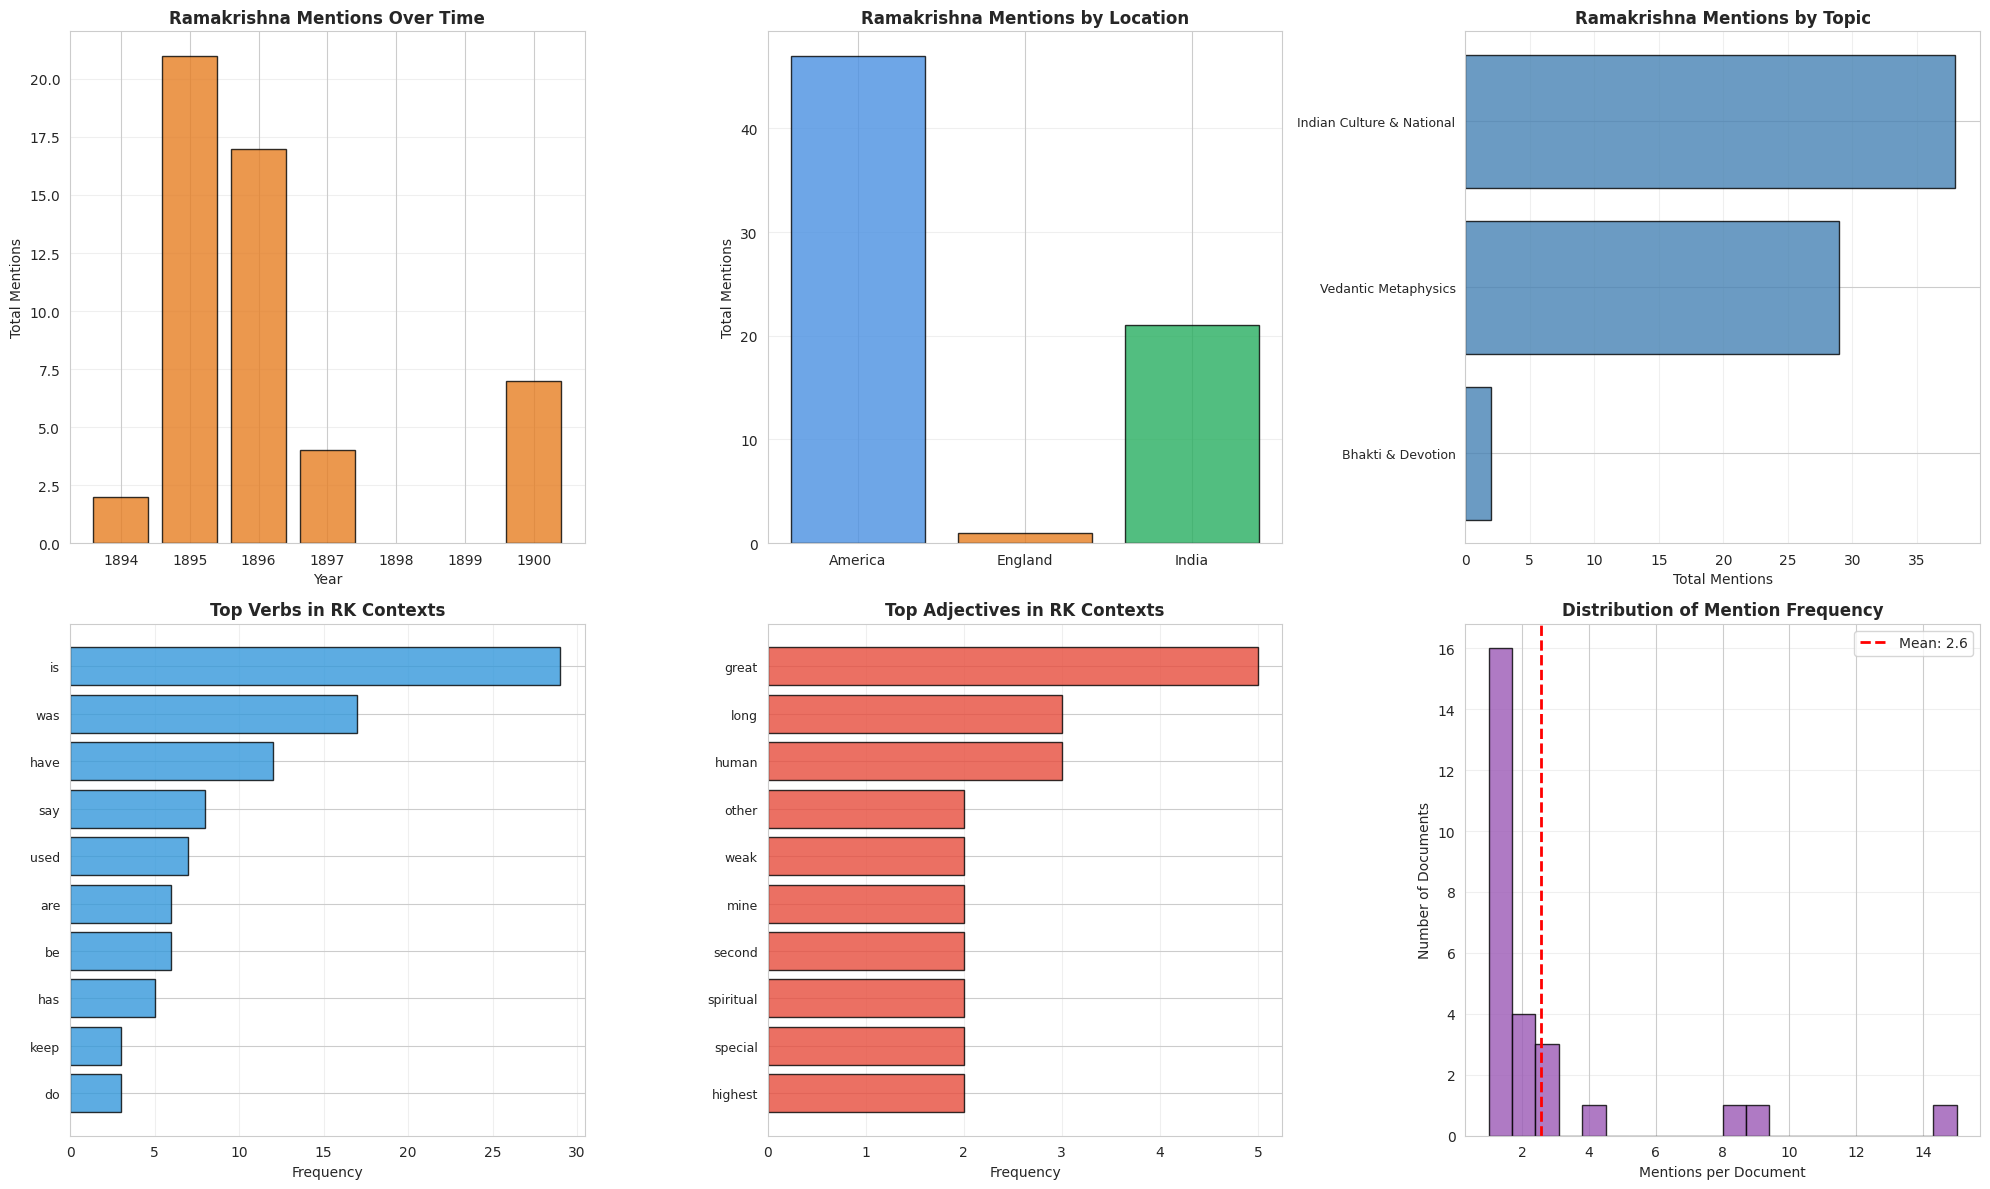


✓ SRI RAMAKRISHNA TEXTUAL ANALYSIS COMPLETE


In [49]:
# ============================================================================
# SRI RAMAKRISHNA MENTIONS: CONCORDANCE, DISPERSION, AND FRAMING
# ============================================================================

import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import re

print("="*80)
print("SRI RAMAKRISHNA MENTIONS - TEXTUAL ANALYSIS")
print("="*80)

# ============================================================================
# 1. IDENTIFICATION
# ============================================================================

print("\n" + "="*80)
print("STEP 1: IDENTIFICATION")
print("="*80)

# Define variants - data-driven approach
# Define variants (longest first for max-span matching)
ramakrishna_variants = {
    'ramakrishna paramahamsa': r'\bramakrishna paramahamsa\b',
    'ramakrishna paramhansa': r'\bramakrishna paramhansa\b',
    'sri ramakrishna': r'\bsri ramakrishna\b',
    'shri ramakrishna': r'\bshri ramakrishna\b',
    'paramahamsa': r'\bparamahamsa\b',
    'paramhansa': r'\bparamhansa\b',
    'my master': r'\bmy master\b',
    'ramakrishna': r'\bramakrishna\b'
}



print("\nSearching for variants:")
for variant in ramakrishna_variants.keys():
    print(f"  - {variant}")

# Count mentions per document and create boolean column
def count_ramakrishna_mentions(text):
    """Count Ramakrishna mentions using max-span (no overlap) matching"""
    if pd.isna(text):
        return 0

    text_lower = text.lower()
    spans = []
    count = 0

    for name, pattern in ramakrishna_variants.items():
        for match in re.finditer(pattern, text_lower):
            span = match.span()

            # Check overlap
            if any(not (span[1] <= s[0] or span[0] >= s[1]) for s in spans):
                continue

            spans.append(span)
            count += 1

    return count


df_public['ramakrishna_mention_count'] = df_public['plaintext_clean'].apply(count_ramakrishna_mentions)
df_public['mentions_ramakrishna'] = df_public['ramakrishna_mention_count'] > 0

# ============================================================================
# 2. BASIC QUANTIFICATION
# ============================================================================

print("\n" + "="*80)
print("STEP 2: BASIC QUANTIFICATION")
print("="*80)

total_mentions = df_public['ramakrishna_mention_count'].sum()
docs_with_mentions = df_public['mentions_ramakrishna'].sum()
total_docs = len(df_public)

print(f"\nOverall Statistics:")
print(f"  Total token mentions: {int(total_mentions)}")
print(f"  Documents mentioning: {int(docs_with_mentions)} / {total_docs} ({100*docs_with_mentions/total_docs:.1f}%)")
print(f"  Average mentions per document (when present): {total_mentions/docs_with_mentions:.2f}" if docs_with_mentions > 0 else "  N/A")

# Distribution by year
print("\n" + "-"*80)
print("DISTRIBUTION BY YEAR")
print("-"*80)

mentions_by_year = df_public[df_public['mentions_ramakrishna']].groupby('year').agg({
    'ramakrishna_mention_count': 'sum',
    'Name': 'count'
}).rename(columns={'ramakrishna_mention_count': 'Total Mentions', 'Name': 'Num Documents'})
mentions_by_year = mentions_by_year.sort_index()

if len(mentions_by_year) > 0:
    print(mentions_by_year.to_string())
else:
    print("  No mentions found")

# Distribution by location
print("\n" + "-"*80)
print("DISTRIBUTION BY LOCATION")
print("-"*80)

mentions_by_location = df_public[df_public['mentions_ramakrishna']].groupby('main_location').agg({
    'ramakrishna_mention_count': 'sum',
    'Name': 'count'
}).rename(columns={'ramakrishna_mention_count': 'Total Mentions', 'Name': 'Num Documents'})

if len(mentions_by_location) > 0:
    print(mentions_by_location.to_string())
else:
    print("  No mentions found")

# Distribution by topic
print("\n" + "-"*80)
print("DISTRIBUTION BY TOPIC")
print("-"*80)

if 'topic_name' in df_public.columns:
    mentions_by_topic = df_public[df_public['mentions_ramakrishna']].groupby('topic_name').agg({
        'ramakrishna_mention_count': 'sum',
        'Name': 'count'
    }).rename(columns={'ramakrishna_mention_count': 'Total Mentions', 'Name': 'Num Documents'})
    mentions_by_topic = mentions_by_topic.sort_values('Total Mentions', ascending=False)

    if len(mentions_by_topic) > 0:
        print(mentions_by_topic.to_string())
    else:
        print("  No mentions found")

# Top 10 talks by mention frequency
print("\n" + "-"*80)
print("TOP 10 TALKS BY RAMAKRISHNA MENTION FREQUENCY")
print("-"*80)

top_mentions = df_public[df_public['mentions_ramakrishna']].nlargest(10, 'ramakrishna_mention_count')[
    ['Name', 'year', 'main_location', 'ramakrishna_mention_count']
]

for i, (idx, row) in enumerate(top_mentions.iterrows(), 1):
    year_str = int(row['year']) if pd.notna(row['year']) else 'Unknown'
    print(f"{i:2d}. {row['Name'][:60]}")
    print(f"    Year: {year_str}, Location: {row['main_location']}, Mentions: {int(row['ramakrishna_mention_count'])}")

# ============================================================================
# 3. CONCORDANCE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("STEP 3: CONCORDANCE ANALYSIS")
print("="*80)

def extract_concordances(text, patterns, window=10):
    """Extract non-overlapping concordances using max-span matching"""
    if pd.isna(text):
        return []

    words = word_tokenize(text)
    words_lower = [w.lower() for w in words]
    text_lower = ' '.join(words_lower)

    concordances = []
    used_spans = []

    for name, pattern in patterns.items():
        for match in re.finditer(pattern, text_lower):
            span = match.span()

            # Skip overlaps
            if any(not (span[1] <= s[0] or span[0] >= s[1]) for s in used_spans):
                continue

            used_spans.append(span)

            # Map char span → token span
            char_count = 0
            start_token = end_token = None

            for i, w in enumerate(words_lower):
                char_count += len(w) + 1
                if start_token is None and char_count >= span[0]:
                    start_token = i
                if char_count >= span[1]:
                    end_token = i + 1
                    break

            if start_token is None or end_token is None:
                continue

            left_start = max(0, start_token - window)
            right_end = min(len(words), end_token + window)

            left = ' '.join(words[left_start:start_token])
            keyword = ' '.join(words[start_token:end_token])
            right = ' '.join(words[end_token:right_end])

            concordances.append({
                'variant': name,
                'left': left,
                'keyword': keyword,
                'right': right,
                'full_window': f"{left} [{keyword}] {right}"
            })

    return concordances


# Extract all concordances
print("\nExtracting concordances (±10 words)...")
all_concordances = []

for idx, row in df_public[df_public['mentions_ramakrishna']].iterrows():
    concs = extract_concordances(row['plaintext_clean'], ramakrishna_variants, window=10)
    for conc in concs:
        conc['title'] = row['Name']
        conc['location'] = row['main_location']
        conc['year'] = row['year']
        all_concordances.append(conc)

print(f"  Total concordance lines extracted: {len(all_concordances)}")

# Sample concordances by variant
print("\n" + "-"*80)
print("REPRESENTATIVE CONCORDANCE LINES (15 samples)")
print("-"*80)

# Get diverse sample: different variants, locations, years
sample_concordances = []

# Sample by variant
for variant in ramakrishna_variants.keys():
    variant_concs = [c for c in all_concordances if c['variant'] == variant]
    if len(variant_concs) > 0:
        sample_concordances.append(variant_concs[0])

# Fill up to 15 with diverse samples
import random
random.seed(42)
remaining = [c for c in all_concordances if c not in sample_concordances]
if len(remaining) > 0:
    additional = random.sample(remaining, min(15 - len(sample_concordances), len(remaining)))
    sample_concordances.extend(additional)

# Display concordances
for i, conc in enumerate(sample_concordances[:15], 1):
    year_str = int(conc['year']) if pd.notna(conc['year']) else 'Unknown'
    print(f"\n{i:2d}. [{conc['variant']}] — {conc['location']}, {year_str}")
    print(f"    {conc['title'][:60]}")

    # Format concordance line
    left = conc['left'][-60:] if len(conc['left']) > 60 else conc['left']
    right = conc['right'][:60] if len(conc['right']) > 60 else conc['right']
    print(f"    ...{left} [{conc['keyword']}] {right}...")

# ============================================================================
# 4. FRAMING ANALYSIS
# ============================================================================

print("\n\n" + "="*80)
print("STEP 4: FRAMING ANALYSIS")
print("="*80)

print("\nExtracting linguistic context from concordance windows...")

# Extract verbs and adjectives from concordance windows
def extract_pos_from_window(window_text):
    """Extract POS tags from window text"""
    if not window_text:
        return {'verbs': [], 'adjectives': []}

    tokens = word_tokenize(window_text)
    pos_tags = nltk.pos_tag(tokens)

    verbs = [word.lower() for word, pos in pos_tags if pos.startswith('VB')]
    adjectives = [word.lower() for word, pos in pos_tags if pos.startswith('JJ')]

    return {'verbs': verbs, 'adjectives': adjectives}

# Analyze concordance contexts
all_verbs_rk = []
all_adjectives_rk = []

for conc in all_concordances:
    window = conc['left'] + ' ' + conc['right']
    pos_data = extract_pos_from_window(window)
    all_verbs_rk.extend(pos_data['verbs'])
    all_adjectives_rk.extend(pos_data['adjectives'])

# Get overall corpus frequencies for comparison
print("  Computing corpus-wide POS frequencies...")
all_verbs_corpus = []
all_adjectives_corpus = []

for idx, row in df_public.sample(min(50, len(df_public)), random_state=42).iterrows():
    if pd.notna(row['plaintext_clean']):
        text_sample = row['plaintext_clean'][:5000]  # Sample for speed
        tokens = word_tokenize(text_sample)
        pos_tags = nltk.pos_tag(tokens)

        verbs = [word.lower() for word, pos in pos_tags if pos.startswith('VB')]
        adjectives = [word.lower() for word, pos in pos_tags if pos.startswith('JJ')]

        all_verbs_corpus.extend(verbs)
        all_adjectives_corpus.extend(adjectives)

# Count frequencies
verb_counts_rk = Counter(all_verbs_rk)
adj_counts_rk = Counter(all_adjectives_rk)
verb_counts_corpus = Counter(all_verbs_corpus)
adj_counts_corpus = Counter(all_adjectives_corpus)

# Most common verbs associated with Ramakrishna
print("\n" + "-"*80)
print("TOP 15 VERBS IN RAMAKRISHNA CONTEXTS")
print("-"*80)

print(f"{'Verb':<20} {'RK Contexts':<15} {'Corpus Freq':<15} {'Ratio':<10}")
print("-" * 60)

for verb, count in verb_counts_rk.most_common(15):
    corpus_count = verb_counts_corpus.get(verb, 0)
    corpus_freq = corpus_count / max(len(all_verbs_corpus), 1)
    rk_freq = count / max(len(all_verbs_rk), 1)
    ratio = rk_freq / corpus_freq if corpus_freq > 0 else float('inf')

    print(f"{verb:<20} {count:<15} {corpus_count:<15} {ratio:<10.2f}")

# Most common adjectives/descriptors
print("\n" + "-"*80)
print("TOP 15 ADJECTIVES IN RAMAKRISHNA CONTEXTS")
print("-"*80)

print(f"{'Adjective':<20} {'RK Contexts':<15} {'Corpus Freq':<15} {'Ratio':<10}")
print("-" * 60)

for adj, count in adj_counts_rk.most_common(15):
    corpus_count = adj_counts_corpus.get(adj, 0)
    corpus_freq = corpus_count / max(len(all_adjectives_corpus), 1)
    rk_freq = count / max(len(all_adjectives_rk), 1)
    ratio = rk_freq / corpus_freq if corpus_freq > 0 else float('inf')

    print(f"{adj:<20} {count:<15} {corpus_count:<15} {ratio:<10.2f}")

# Distinctive terms (high ratio)
print("\n" + "-"*80)
print("DISTINCTIVE VERBS (High RK/Corpus ratio, min 3 occurrences)")
print("-"*80)

distinctive_verbs = []
for verb, count in verb_counts_rk.items():
    if count >= 3:
        corpus_count = verb_counts_corpus.get(verb, 0)
        corpus_freq = corpus_count / max(len(all_verbs_corpus), 1)
        rk_freq = count / max(len(all_verbs_rk), 1)
        ratio = rk_freq / corpus_freq if corpus_freq > 0 else float('inf')
        distinctive_verbs.append((verb, count, corpus_count, ratio))

distinctive_verbs.sort(key=lambda x: x[3], reverse=True)

for verb, rk_count, corpus_count, ratio in distinctive_verbs[:10]:
    print(f"  {verb:<20} RK:{rk_count:<5} Corpus:{corpus_count:<5} Ratio:{ratio:.2f}x")

print("\n" + "-"*80)
print("DISTINCTIVE ADJECTIVES (High RK/Corpus ratio, min 3 occurrences)")
print("-"*80)

distinctive_adjs = []
for adj, count in adj_counts_rk.items():
    if count >= 3:
        corpus_count = adj_counts_corpus.get(adj, 0)
        corpus_freq = corpus_count / max(len(all_adjectives_corpus), 1)
        rk_freq = count / max(len(all_adjectives_rk), 1)
        ratio = rk_freq / corpus_freq if corpus_freq > 0 else float('inf')
        distinctive_adjs.append((adj, count, corpus_count, ratio))

distinctive_adjs.sort(key=lambda x: x[3], reverse=True)

for adj, rk_count, corpus_count, ratio in distinctive_adjs[:10]:
    print(f"  {adj:<20} RK:{rk_count:<5} Corpus:{corpus_count:<5} Ratio:{ratio:.2f}x")

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(20, 12))

# 1. Mentions by year
ax1 = plt.subplot(2, 3, 1)
if len(mentions_by_year) > 0:
    ax1.bar(mentions_by_year.index.astype(int), mentions_by_year['Total Mentions'],
           color='#E67E22', alpha=0.8, edgecolor='black')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Total Mentions')
    ax1.set_title('Ramakrishna Mentions Over Time', fontweight='bold', fontsize=12)
    ax1.grid(axis='y', alpha=0.3)

# 2. Mentions by location
ax2 = plt.subplot(2, 3, 2)
if len(mentions_by_location) > 0:
    colors_loc = ['#4A90E2', '#E67E22', '#27AE60']
    ax2.bar(mentions_by_location.index, mentions_by_location['Total Mentions'],
           color=colors_loc[:len(mentions_by_location)], alpha=0.8, edgecolor='black')
    ax2.set_ylabel('Total Mentions')
    ax2.set_title('Ramakrishna Mentions by Location', fontweight='bold', fontsize=12)
    ax2.grid(axis='y', alpha=0.3)

# 3. Mentions by topic
ax3 = plt.subplot(2, 3, 3)
if 'topic_name' in df_public.columns and len(mentions_by_topic) > 0:
    ax3.barh(range(len(mentions_by_topic)), mentions_by_topic['Total Mentions'].values,
            color='steelblue', alpha=0.8, edgecolor='black')
    ax3.set_yticks(range(len(mentions_by_topic)))
    ax3.set_yticklabels([t[:25] for t in mentions_by_topic.index], fontsize=9)
    ax3.set_xlabel('Total Mentions')
    ax3.set_title('Ramakrishna Mentions by Topic', fontweight='bold', fontsize=12)
    ax3.invert_yaxis()
    ax3.grid(axis='x', alpha=0.3)

# 4. Top verbs
ax4 = plt.subplot(2, 3, 4)
top_verbs = verb_counts_rk.most_common(10)
verbs = [v[0] for v in top_verbs]
counts = [v[1] for v in top_verbs]
ax4.barh(range(len(verbs)), counts, color='#3498db', alpha=0.8, edgecolor='black')
ax4.set_yticks(range(len(verbs)))
ax4.set_yticklabels(verbs, fontsize=9)
ax4.set_xlabel('Frequency')
ax4.set_title('Top Verbs in RK Contexts', fontweight='bold', fontsize=12)
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

# 5. Top adjectives
ax5 = plt.subplot(2, 3, 5)
top_adjs = adj_counts_rk.most_common(10)
adjs = [a[0] for a in top_adjs]
counts = [a[1] for a in top_adjs]
ax5.barh(range(len(adjs)), counts, color='#e74c3c', alpha=0.8, edgecolor='black')
ax5.set_yticks(range(len(adjs)))
ax5.set_yticklabels(adjs, fontsize=9)
ax5.set_xlabel('Frequency')
ax5.set_title('Top Adjectives in RK Contexts', fontweight='bold', fontsize=12)
ax5.invert_yaxis()
ax5.grid(axis='x', alpha=0.3)

# 6. Distribution of mentions per document
ax6 = plt.subplot(2, 3, 6)
mention_dist = df_public[df_public['mentions_ramakrishna']]['ramakrishna_mention_count']
ax6.hist(mention_dist, bins=20, color='#9b59b6', alpha=0.8, edgecolor='black')
ax6.set_xlabel('Mentions per Document')
ax6.set_ylabel('Number of Documents')
ax6.set_title('Distribution of Mention Frequency', fontweight='bold', fontsize=12)
ax6.axvline(mention_dist.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {mention_dist.mean():.1f}')
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ SRI RAMAKRISHNA TEXTUAL ANALYSIS COMPLETE")
print("="*80)

SRI RAMAKRISHNA: DISCURSIVE INVARIANTS & VISUAL ANALYSIS

Documents with mentions: 38 / 179
Total mentions: 151

1️⃣ DOCUMENT-TYPE INVARIANCE

Discourse type distribution:
  Other: 75
  Inspired Talks: 44
  Formal Lecture: 39
  Reply/Address/Welcome: 10
  Mission/Programmatic: 6
  Narrative/Biographical: 5

--------------------------------------------------------------------------------
Ramakrishna mention rates by discourse type:
--------------------------------------------------------------------------------
                        sum  count  mention_rate
discourse_type                                  
Inspired Talks           14     44     31.818182
Reply/Address/Welcome     3     10     30.000000
Narrative/Biographical    1      5     20.000000
Formal Lecture            7     39     17.948718
Mission/Programmatic      1      6     16.666667
Other                    12     75     16.000000

2️⃣ POSITIONAL INVARIANCE WITHIN DOCUMENTS

Total mentions analyzed: 151

Position distribu

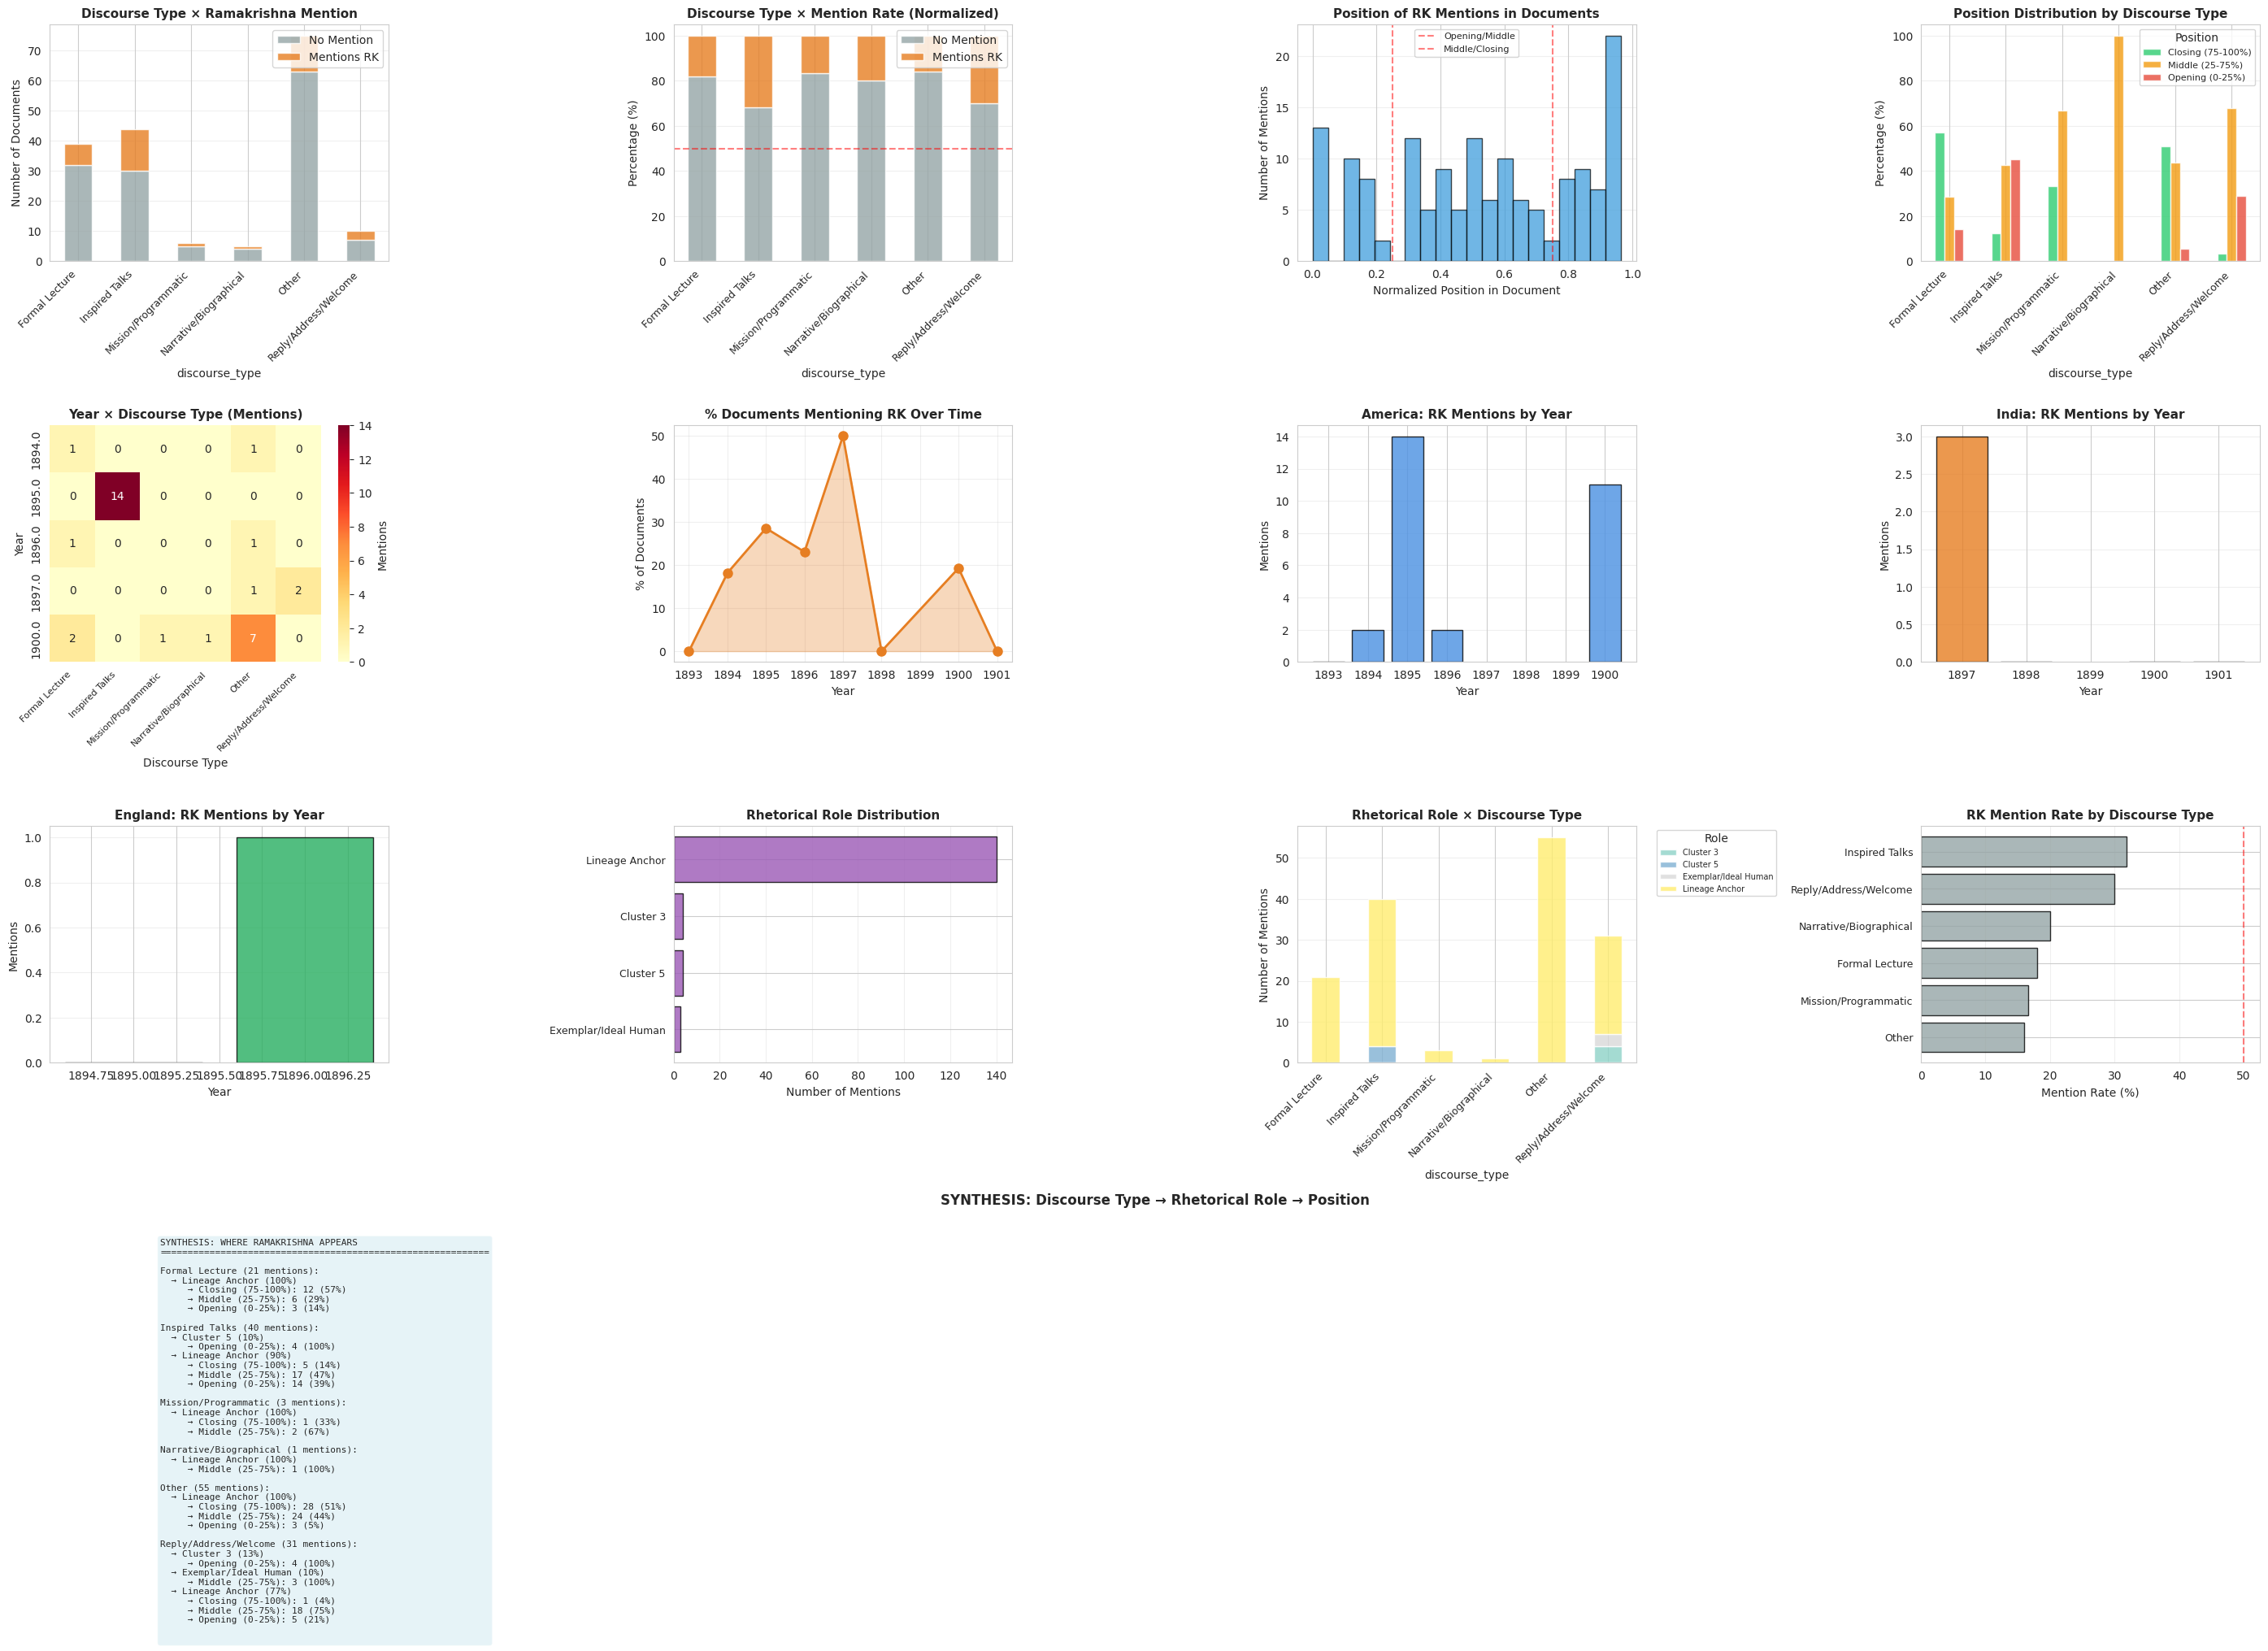


Generating alluvial-style synthesis visual...


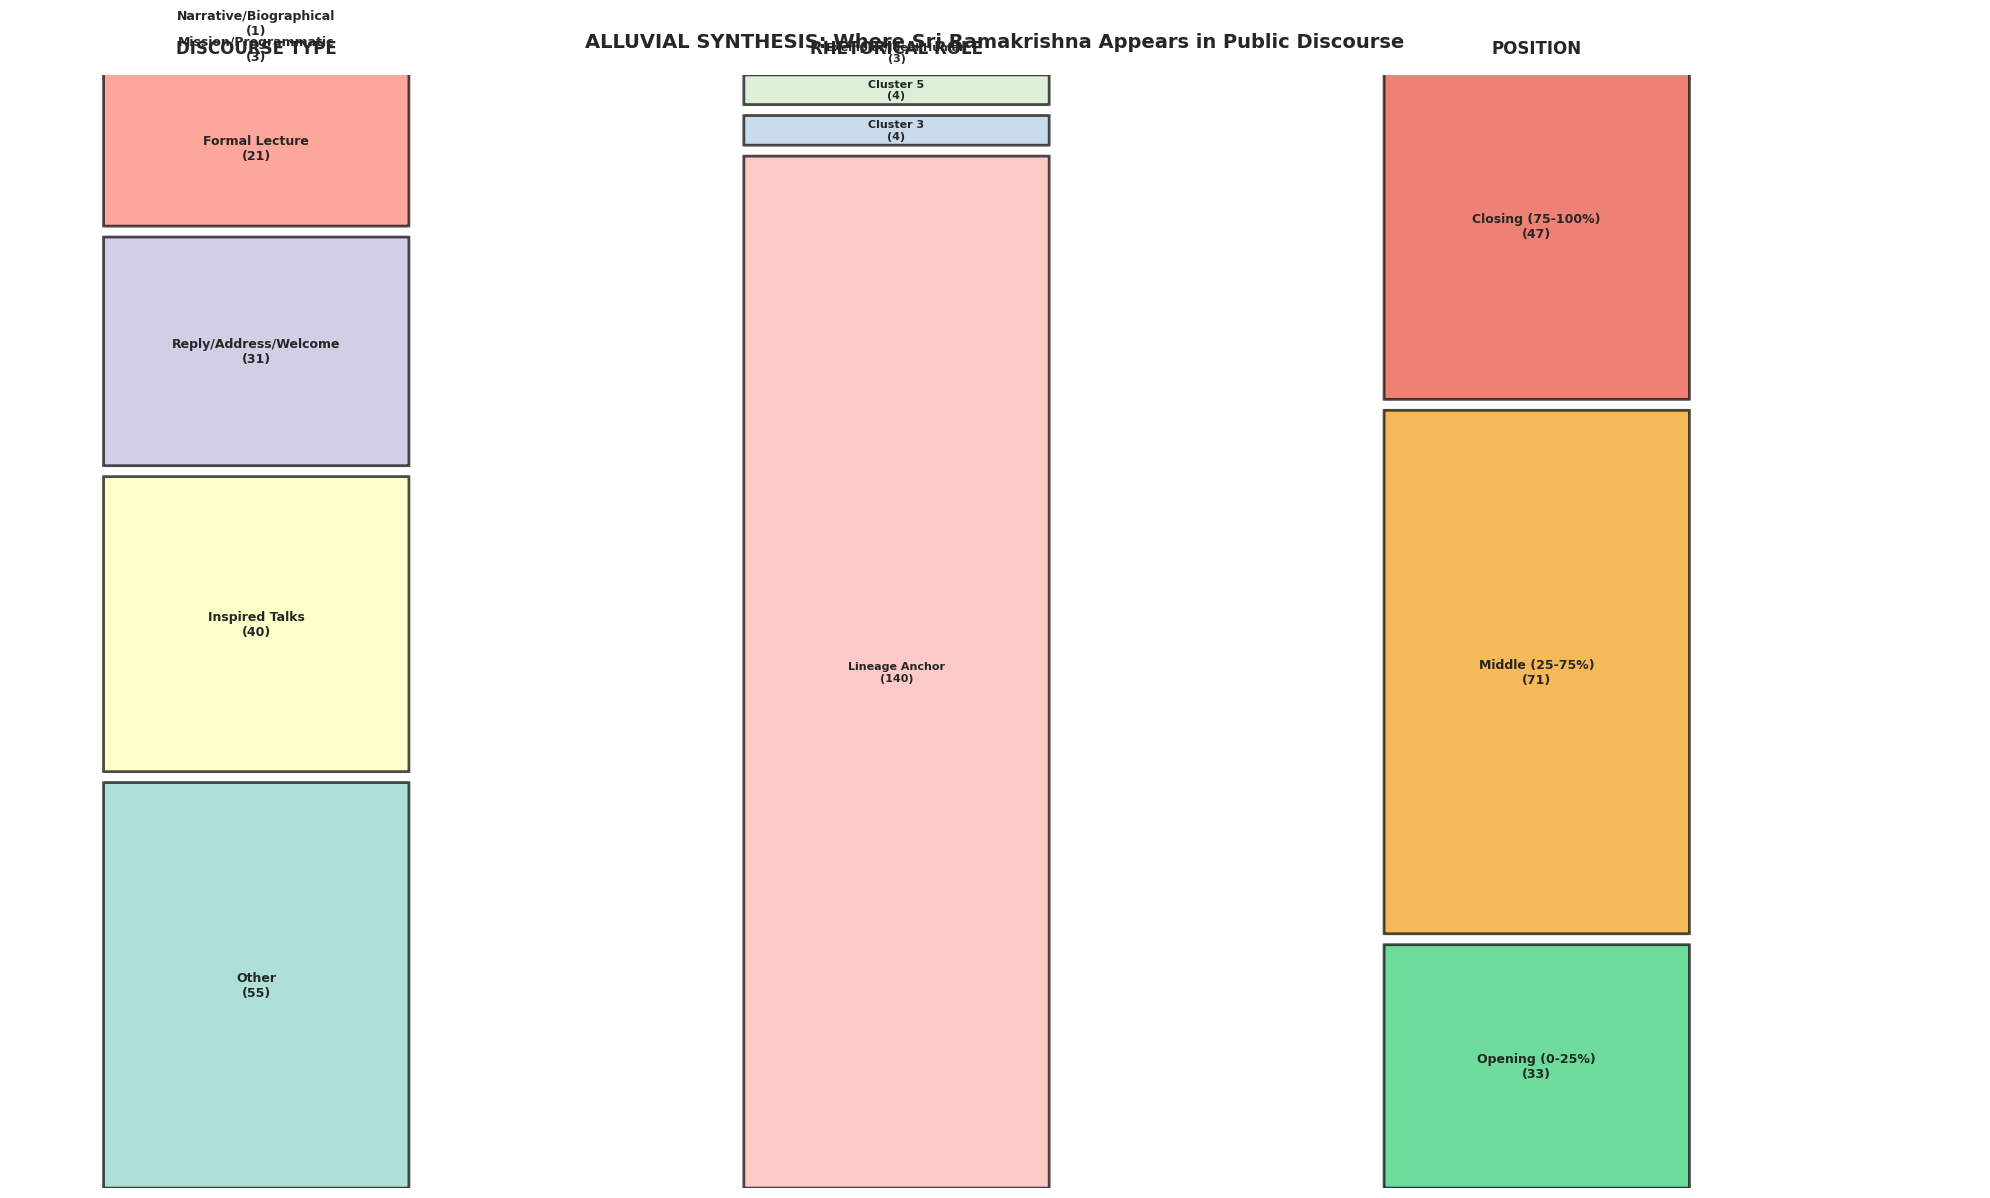


✓ SRI RAMAKRISHNA INVARIANT ANALYSIS COMPLETE

KEY FINDINGS

1. Discourse Type Invariance:
   Highest mention rate: Inspired Talks (31.8%)
   Lowest mention rate: Other (16.0%)

2. Positional Invariance:
   Opening: 21.9%
   Middle: 47.0%
   Closing: 31.1%

3. Rhetorical Role Invariance:
   Lineage Anchor: 140 (92.7%)
   Cluster 3: 4 (2.6%)
   Cluster 5: 4 (2.6%)

4. Temporal Invariance:
   Years with mentions: 5
   Peak year: 1895.0


In [50]:
# ============================================================================
# SRI RAMAKRISHNA IN PUBLIC DISCOURSE - INVARIANT CONTEXT & VISUAL ANALYSIS
# ============================================================================

import warnings
warnings.filterwarnings('ignore')
from collections import Counter, defaultdict
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import seaborn as sns

print("="*80)
print("SRI RAMAKRISHNA: DISCURSIVE INVARIANTS & VISUAL ANALYSIS")
print("="*80)

# ============================================================================
# SETUP: DETECT RAMAKRISHNA MENTIONS
# ============================================================================

ramakrishna_patterns = [
    r'\bramakrishna\b',
    r'\bsri ramakrishna\b',
    r'\bshri ramakrishna\b',
    r'\bthe master\b',
    r'\bmy master\b',
    r'\bour master\b',
    r'\bparamahamsa\b',
    r'\bramakrishna paramahamsa\b'
]

def detect_mentions_with_positions(text):
    """Detect mentions and their positions in text"""
    if pd.isna(text):
        return []

    text_lower = text.lower()
    words = word_tokenize(text)
    word_positions = []

    # Build position map
    current_pos = 0
    for i, word in enumerate(words):
        word_positions.append((word.lower(), i, current_pos))
        current_pos += len(word) + 1

    mentions = []
    for pattern in ramakrishna_patterns:
        for match in re.finditer(pattern, text_lower):
            start_char = match.start()
            end_char = match.end()

            # Find word position
            for w, word_idx, char_pos in word_positions:
                if char_pos <= start_char < char_pos + len(w) + 10:
                    normalized_pos = word_idx / max(len(words), 1)
                    mentions.append({
                        'char_start': start_char,
                        'char_end': end_char,
                        'word_position': word_idx,
                        'normalized_position': normalized_pos,
                        'matched_text': match.group()
                    })
                    break

    return mentions

# Apply detection
df_public['ramakrishna_mentions'] = df_public['plaintext_clean'].apply(detect_mentions_with_positions)
df_public['has_ramakrishna'] = df_public['ramakrishna_mentions'].apply(lambda x: len(x) > 0)
df_public['mention_count'] = df_public['ramakrishna_mentions'].apply(len)

print(f"\nDocuments with mentions: {df_public['has_ramakrishna'].sum()} / {len(df_public)}")
print(f"Total mentions: {df_public['mention_count'].sum()}")

# ============================================================================
# 1️⃣ DOCUMENT-TYPE INVARIANCE
# ============================================================================

print("\n" + "="*80)
print("1️⃣ DOCUMENT-TYPE INVARIANCE")
print("="*80)

def infer_discourse_type(title):
    """Data-driven discourse type inference from title"""
    if pd.isna(title):
        return 'Unknown'

    title_lower = title.lower()

    # Reply/Address/Welcome
    if any(word in title_lower for word in ['reply', 'response', 'address', 'welcome', 'reception', 'greeting']):
        return 'Reply/Address/Welcome'

    # Inspired Talks
    if 'inspired talks' in title_lower or 'inspired talk' in title_lower:
        return 'Inspired Talks'

    # Mission/Programmatic
    if any(word in title_lower for word in ['mission', 'work', 'ideal', 'future', 'duty', 'programme']):
        return 'Mission/Programmatic'

    # Narrative/Biographical
    if any(word in title_lower for word in ['life', 'story', 'biography', 'account', 'reminiscence', 'memory']):
        return 'Narrative/Biographical'

    # Formal Lecture/Treatise
    if any(word in title_lower for word in ['lecture', 'paper', 'essay', 'treatise', 'discourse']):
        return 'Formal Lecture'

    # Philosophy/Religion by topic
    if any(word in title_lower for word in ['vedanta', 'yoga', 'religion', 'god', 'soul', 'philosophy', 'buddhism', 'hinduism']):
        return 'Formal Lecture'

    return 'Other'

df_public['discourse_type'] = df_public['Name'].apply(infer_discourse_type)

print("\nDiscourse type distribution:")
discourse_dist = df_public['discourse_type'].value_counts()
for dtype, count in discourse_dist.items():
    print(f"  {dtype}: {count}")

# Compute mention rates by discourse type
mention_by_type = df_public.groupby('discourse_type')['has_ramakrishna'].agg(['sum', 'count'])
mention_by_type['mention_rate'] = mention_by_type['sum'] / mention_by_type['count'] * 100
mention_by_type = mention_by_type.sort_values('mention_rate', ascending=False)

print("\n" + "-"*80)
print("Ramakrishna mention rates by discourse type:")
print("-"*80)
print(mention_by_type)

# ============================================================================
# 2️⃣ POSITIONAL INVARIANCE WITHIN DOCUMENTS
# ============================================================================

print("\n" + "="*80)
print("2️⃣ POSITIONAL INVARIANCE WITHIN DOCUMENTS")
print("="*80)

# Extract all mention positions
all_positions = []
position_data = []

for idx, row in df_public[df_public['has_ramakrishna']].iterrows():
    for mention in row['ramakrishna_mentions']:
        pos = mention['normalized_position']
        all_positions.append(pos)

        # Bin position
        if pos < 0.25:
            bin_label = 'Opening (0-25%)'
        elif pos < 0.75:
            bin_label = 'Middle (25-75%)'
        else:
            bin_label = 'Closing (75-100%)'

        position_data.append({
            'position': pos,
            'bin': bin_label,
            'discourse_type': row['discourse_type'],
            'title': row['Name'],
            'location': row['main_location']
        })

position_df = pd.DataFrame(position_data)

print(f"\nTotal mentions analyzed: {len(position_df)}")
print("\nPosition distribution:")
print(position_df['bin'].value_counts())

print("\nPosition bins by discourse type:")
pos_by_type = pd.crosstab(position_df['discourse_type'], position_df['bin'])
print(pos_by_type)

# ============================================================================
# 3️⃣ TEMPORAL × AUDIENCE INVARIANCE
# ============================================================================

print("\n" + "="*80)
print("3️⃣ TEMPORAL × AUDIENCE INVARIANCE")
print("="*80)

# Mentions by year, location, discourse type
temporal_data = df_public[df_public['has_ramakrishna']].groupby(['year', 'main_location', 'discourse_type']).size().reset_index(name='count')
print("\nMentions by year × location × discourse type:")
print(temporal_data.head(20))

# Overall mention percentage over time
yearly_mentions = df_public.groupby('year')['has_ramakrishna'].agg(['sum', 'count'])
yearly_mentions['pct'] = yearly_mentions['sum'] / yearly_mentions['count'] * 100
print("\nPercentage of documents mentioning Ramakrishna by year:")
print(yearly_mentions)

# ============================================================================
# 4️⃣ RHETORICAL ROLE CLUSTERING
# ============================================================================

print("\n" + "="*80)
print("4️⃣ RHETORICAL ROLE CLUSTERING")
print("="*80)

def extract_context_window(text, mention_start, mention_end, window=15):
    """Extract ±15 word window around mention"""
    if pd.isna(text):
        return ""

    words = word_tokenize(text)
    words_lower = [w.lower() for w in words]

    # Find mention position in tokens
    text_lower = text.lower()
    char_to_word = []
    pos = 0
    for i, word in enumerate(words):
        char_to_word.append((pos, pos + len(word), i))
        pos += len(word) + 1

    mention_word_idx = None
    for start_c, end_c, word_idx in char_to_word:
        if start_c <= mention_start < end_c + 5:
            mention_word_idx = word_idx
            break

    if mention_word_idx is None:
        return ""

    # Extract window
    start_idx = max(0, mention_word_idx - window)
    end_idx = min(len(words), mention_word_idx + window + 1)

    return ' '.join(words[start_idx:end_idx])

# Extract contexts for all mentions
print("\nExtracting context windows (±15 words)...")
contexts = []

for idx, row in df_public[df_public['has_ramakrishna']].iterrows():
    for mention in row['ramakrishna_mentions']:
        context = extract_context_window(
            row['plaintext_clean'],
            mention['char_start'],
            mention['char_end'],
            window=15
        )
        if context:
            # ADD THE BIN HERE
            pos = mention['normalized_position']
            if pos < 0.25:
                bin_label = 'Opening (0-25%)'
            elif pos < 0.75:
                bin_label = 'Middle (25-75%)'
            else:
                bin_label = 'Closing (75-100%)'

            contexts.append({
                'context': context,
                'discourse_type': row['discourse_type'],
                'location': row['main_location'],
                'position': pos,
                'bin': bin_label,  # ADD THIS LINE
                'title': row['Name']
            })

context_df = pd.DataFrame(contexts)
print(f"  Extracted {len(context_df)} context windows")

# Extract verb-noun patterns
print("\nExtracting verb-noun patterns from contexts...")

def extract_verb_noun_patterns(text):
    """Extract verb-noun pairs"""
    if not text:
        return []

    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    patterns = []
    for i, (word, pos) in enumerate(pos_tags):
        if pos.startswith('VB'):  # Verb
            # Look for nearby nouns
            for j in range(max(0, i-3), min(len(pos_tags), i+4)):
                if pos_tags[j][1].startswith('NN'):
                    patterns.append(f"{word.lower()}_{pos_tags[j][0].lower()}")

    return patterns

context_df['patterns'] = context_df['context'].apply(extract_verb_noun_patterns)

# Cluster contexts into rhetorical roles
print("\nClustering contexts into rhetorical roles...")

# Vectorize contexts
vectorizer = CountVectorizer(max_features=100, min_df=2, stop_words='english')
context_vectors = vectorizer.fit_transform(context_df['context'])

# K-means clustering (5 clusters for rhetorical roles)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
context_df['cluster'] = kmeans.fit_predict(context_vectors)

# Interpret clusters based on top terms
cluster_names = {}
feature_names = vectorizer.get_feature_names_out()

for i in range(n_clusters):
    cluster_center = kmeans.cluster_centers_[i]
    top_indices = cluster_center.argsort()[-10:][::-1]
    top_terms = [feature_names[idx] for idx in top_indices]

    # Heuristic naming based on top terms
    terms_str = ' '.join(top_terms[:5])

    if any(word in terms_str for word in ['said', 'tell', 'saw', 'went']):
        cluster_names[i] = 'Personal Reverence/Narrative'
    elif any(word in terms_str for word in ['taught', 'teaching', 'said', 'wisdom']):
        cluster_names[i] = 'Authority Invocation'
    elif any(word in terms_str for word in ['life', 'man', 'great', 'saint']):
        cluster_names[i] = 'Exemplar/Ideal Human'
    elif any(word in terms_str for word in ['india', 'religion', 'vedanta']):
        cluster_names[i] = 'Lineage Anchor'
    else:
        cluster_names[i] = f'Cluster {i+1}'

    print(f"\nCluster {i}: {cluster_names[i]}")
    print(f"  Top terms: {', '.join(top_terms[:8])}")

context_df['rhetorical_role'] = context_df['cluster'].map(cluster_names)

print("\n" + "-"*80)
print("Rhetorical role distribution:")
print(context_df['rhetorical_role'].value_counts())

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(28, 20))

# 1. Document-type invariance - Stacked bar
ax1 = plt.subplot(4, 4, 1)
mention_counts = df_public.groupby(['discourse_type', 'has_ramakrishna']).size().unstack(fill_value=0)
mention_counts.plot(kind='bar', stacked=True, ax=ax1, color=['#95A5A6', '#E67E22'], alpha=0.8)
ax1.set_ylabel('Number of Documents')
ax1.set_title('Discourse Type × Ramakrishna Mention', fontweight='bold', fontsize=11)
ax1.legend(['No Mention', 'Mentions RK'], loc='upper right')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# 2. Document-type invariance - Normalized (100%)
ax2 = plt.subplot(4, 4, 2)
mention_pct = mention_counts.div(mention_counts.sum(axis=1), axis=0) * 100
mention_pct.plot(kind='bar', stacked=True, ax=ax2, color=['#95A5A6', '#E67E22'], alpha=0.8)
ax2.set_ylabel('Percentage (%)')
ax2.set_title('Discourse Type × Mention Rate (Normalized)', fontweight='bold', fontsize=11)
ax2.legend(['No Mention', 'Mentions RK'], loc='upper right')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax2.axhline(y=50, color='red', linestyle='--', alpha=0.5)
ax2.grid(axis='y', alpha=0.3)

# 3. Positional invariance - Histogram
ax3 = plt.subplot(4, 4, 3)
ax3.hist(all_positions, bins=20, color='#3498db', alpha=0.7, edgecolor='black')
ax3.axvline(x=0.25, color='red', linestyle='--', alpha=0.5, label='Opening/Middle')
ax3.axvline(x=0.75, color='red', linestyle='--', alpha=0.5, label='Middle/Closing')
ax3.set_xlabel('Normalized Position in Document')
ax3.set_ylabel('Number of Mentions')
ax3.set_title('Position of RK Mentions in Documents', fontweight='bold', fontsize=11)
ax3.legend(fontsize=8)
ax3.grid(axis='y', alpha=0.3)

# 4. Positional invariance - Grouped by discourse type
ax4 = plt.subplot(4, 4, 4)
pos_by_type_pct = pos_by_type.div(pos_by_type.sum(axis=1), axis=0) * 100
pos_by_type_pct.plot(kind='bar', ax=ax4, color=['#2ecc71', '#f39c12', '#e74c3c'], alpha=0.8)
ax4.set_ylabel('Percentage (%)')
ax4.set_title('Position Distribution by Discourse Type', fontweight='bold', fontsize=11)
ax4.legend(title='Position', fontsize=8)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax4.grid(axis='y', alpha=0.3)

# 5. Temporal invariance - Heatmap (year × discourse type)
ax5 = plt.subplot(4, 4, 5)
if len(temporal_data) > 0:
    heatmap_data = temporal_data.pivot_table(
        index='year',
        columns='discourse_type',
        values='count',
        fill_value=0
    )
    sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='g', ax=ax5, cbar_kws={'label': 'Mentions'})
    ax5.set_title('Year × Discourse Type (Mentions)', fontweight='bold', fontsize=11)
    ax5.set_xlabel('Discourse Type')
    ax5.set_ylabel('Year')
    plt.setp(ax5.get_xticklabels(), rotation=45, ha='right', fontsize=8)

# 6. Temporal invariance - Mentions over time (percentage)
ax6 = plt.subplot(4, 4, 6)
yearly_mentions_clean = yearly_mentions[yearly_mentions.index.notna()]
ax6.plot(yearly_mentions_clean.index, yearly_mentions_clean['pct'],
         marker='o', linewidth=2, markersize=8, color='#E67E22')
ax6.fill_between(yearly_mentions_clean.index, yearly_mentions_clean['pct'], alpha=0.3, color='#E67E22')
ax6.set_xlabel('Year')
ax6.set_ylabel('% of Documents')
ax6.set_title('% Documents Mentioning RK Over Time', fontweight='bold', fontsize=11)
ax6.grid(alpha=0.3)

# 7. Location facets - America
ax7 = plt.subplot(4, 4, 7)
america_data = df_public[df_public['main_location']=='America'].groupby('year')['has_ramakrishna'].sum()
if len(america_data) > 0:
    ax7.bar(america_data.index, america_data.values, color='#4A90E2', alpha=0.8, edgecolor='black')
    ax7.set_xlabel('Year')
    ax7.set_ylabel('Mentions')
    ax7.set_title('America: RK Mentions by Year', fontweight='bold', fontsize=11)
    ax7.grid(axis='y', alpha=0.3)

# 8. Location facets - India
ax8 = plt.subplot(4, 4, 8)
india_data = df_public[df_public['main_location']=='India'].groupby('year')['has_ramakrishna'].sum()
if len(india_data) > 0:
    ax8.bar(india_data.index, india_data.values, color='#E67E22', alpha=0.8, edgecolor='black')
    ax8.set_xlabel('Year')
    ax8.set_ylabel('Mentions')
    ax8.set_title('India: RK Mentions by Year', fontweight='bold', fontsize=11)
    ax8.grid(axis='y', alpha=0.3)

# 9. Location facets - England
ax9 = plt.subplot(4, 4, 9)
england_data = df_public[df_public['main_location']=='England'].groupby('year')['has_ramakrishna'].sum()
if len(england_data) > 0:
    ax9.bar(england_data.index, england_data.values, color='#27AE60', alpha=0.8, edgecolor='black')
    ax9.set_xlabel('Year')
    ax9.set_ylabel('Mentions')
    ax9.set_title('England: RK Mentions by Year', fontweight='bold', fontsize=11)
    ax9.grid(axis='y', alpha=0.3)

# 10. Rhetorical role distribution
ax10 = plt.subplot(4, 4, 10)
role_counts = context_df['rhetorical_role'].value_counts()
ax10.barh(range(len(role_counts)), role_counts.values, color='#9b59b6', alpha=0.8, edgecolor='black')
ax10.set_yticks(range(len(role_counts)))
ax10.set_yticklabels(role_counts.index, fontsize=9)
ax10.set_xlabel('Number of Mentions')
ax10.set_title('Rhetorical Role Distribution', fontweight='bold', fontsize=11)
ax10.invert_yaxis()
ax10.grid(axis='x', alpha=0.3)

# 11. Rhetorical role × discourse type
ax11 = plt.subplot(4, 4, 11)
role_by_type = pd.crosstab(context_df['discourse_type'], context_df['rhetorical_role'])
role_by_type.plot(kind='bar', stacked=True, ax=ax11, colormap='Set3', alpha=0.8)
ax11.set_ylabel('Number of Mentions')
ax11.set_title('Rhetorical Role × Discourse Type', fontweight='bold', fontsize=11)
ax11.legend(title='Role', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
ax11.set_xticklabels(ax11.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax11.grid(axis='y', alpha=0.3)

# 12. Mention rate by discourse type (bar chart)
ax12 = plt.subplot(4, 4, 12)
mention_rates = mention_by_type['mention_rate'].sort_values(ascending=False)
colors_rate = ['#E67E22' if x > 50 else '#95A5A6' for x in mention_rates.values]
ax12.barh(range(len(mention_rates)), mention_rates.values, color=colors_rate, alpha=0.8, edgecolor='black')
ax12.set_yticks(range(len(mention_rates)))
ax12.set_yticklabels(mention_rates.index, fontsize=9)
ax12.set_xlabel('Mention Rate (%)')
ax12.set_title('RK Mention Rate by Discourse Type', fontweight='bold', fontsize=11)
ax12.axvline(x=50, color='red', linestyle='--', alpha=0.5)
ax12.invert_yaxis()
ax12.grid(axis='x', alpha=0.3)

# 13-16. SYNTHESIS VISUAL: Alluvial-style representation
# Create multi-level flow diagram data
ax13 = plt.subplot(4, 4, (13, 16))
ax13.axis('off')

# Prepare flow data: Discourse Type → Rhetorical Role → Position
flow_data = context_df.groupby(['discourse_type', 'rhetorical_role', 'bin']).size().reset_index(name='count')

# Create simplified Sankey-style text visualization
synthesis_text = "SYNTHESIS: WHERE RAMAKRISHNA APPEARS\n"
synthesis_text += "="*60 + "\n\n"

for dtype in flow_data['discourse_type'].unique():
    dtype_data = flow_data[flow_data['discourse_type']==dtype]
    total_dtype = dtype_data['count'].sum()

    synthesis_text += f"{dtype} ({total_dtype} mentions):\n"

    for role in dtype_data['rhetorical_role'].unique():
        role_data = dtype_data[dtype_data['rhetorical_role']==role]
        total_role = role_data['count'].sum()
        pct_role = (total_role / total_dtype) * 100

        synthesis_text += f"  → {role} ({pct_role:.0f}%)\n"

        for _, row in role_data.iterrows():
            pct_pos = (row['count'] / total_role) * 100
            synthesis_text += f"     → {row['bin']}: {row['count']} ({pct_pos:.0f}%)\n"

    synthesis_text += "\n"

ax13.text(0.05, 0.95, synthesis_text, transform=ax13.transAxes,
         fontsize=8, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
ax13.set_title('SYNTHESIS: Discourse Type → Rhetorical Role → Position',
              fontweight='bold', fontsize=12, pad=20)

plt.tight_layout()
plt.show()

# ============================================================================
# ADDITIONAL SYNTHESIS VISUAL: Alluvial Plot
# ============================================================================

print("\nGenerating alluvial-style synthesis visual...")

fig2 = plt.figure(figsize=(20, 12))

# Prepare data for alluvial visualization
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as mpatches

ax_alluvial = fig2.add_subplot(111)
ax_alluvial.set_xlim(0, 4)
ax_alluvial.set_ylim(0, 100)

# Column 1: Discourse Type
dtype_counts = context_df['discourse_type'].value_counts()
y_start = 0
dtype_positions = {}

for i, (dtype, count) in enumerate(dtype_counts.items()):
    height = (count / len(context_df)) * 100
    color = plt.cm.Set3(i)

    rect = FancyBboxPatch((0.2, y_start), 0.6, height,
                          boxstyle="round,pad=0.01",
                          facecolor=color, edgecolor='black', linewidth=2, alpha=0.7)
    ax_alluvial.add_patch(rect)

    ax_alluvial.text(0.5, y_start + height/2, f"{dtype}\n({count})",
                    ha='center', va='center', fontsize=9, fontweight='bold')

    dtype_positions[dtype] = (y_start, y_start + height)
    y_start += height + 1

# Column 2: Rhetorical Role
role_counts = context_df['rhetorical_role'].value_counts()
y_start = 0
role_positions = {}

for i, (role, count) in enumerate(role_counts.items()):
    height = (count / len(context_df)) * 100
    color = plt.cm.Pastel1(i)

    rect = FancyBboxPatch((1.5, y_start), 0.6, height,
                          boxstyle="round,pad=0.01",
                          facecolor=color, edgecolor='black', linewidth=2, alpha=0.7)
    ax_alluvial.add_patch(rect)

    ax_alluvial.text(1.8, y_start + height/2, f"{role[:20]}\n({count})",
                    ha='center', va='center', fontsize=8, fontweight='bold')

    role_positions[role] = (y_start, y_start + height)
    y_start += height + 1

# Column 3: Position
pos_order = ['Opening (0-25%)', 'Middle (25-75%)', 'Closing (75-100%)']
pos_counts = context_df['bin'].value_counts()
y_start = 0
pos_positions = {}

for i, pos_label in enumerate(pos_order):
    if pos_label in pos_counts.index:
        count = pos_counts[pos_label]
        height = (count / len(context_df)) * 100
        colors_pos = ['#2ecc71', '#f39c12', '#e74c3c']

        rect = FancyBboxPatch((2.8, y_start), 0.6, height,
                              boxstyle="round,pad=0.01",
                              facecolor=colors_pos[i], edgecolor='black', linewidth=2, alpha=0.7)
        ax_alluvial.add_patch(rect)

        ax_alluvial.text(3.1, y_start + height/2, f"{pos_label}\n({count})",
                        ha='center', va='center', fontsize=9, fontweight='bold')

        pos_positions[pos_label] = (y_start, y_start + height)
        y_start += height + 1

ax_alluvial.text(0.5, 102, 'DISCOURSE TYPE', ha='center', fontsize=12, fontweight='bold')
ax_alluvial.text(1.8, 102, 'RHETORICAL ROLE', ha='center', fontsize=12, fontweight='bold')
ax_alluvial.text(3.1, 102, 'POSITION', ha='center', fontsize=12, fontweight='bold')

ax_alluvial.set_title('ALLUVIAL SYNTHESIS: Where Sri Ramakrishna Appears in Public Discourse',
                     fontsize=14, fontweight='bold', pad=20)
ax_alluvial.axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ SRI RAMAKRISHNA INVARIANT ANALYSIS COMPLETE")
print("="*80)

# Print summary statistics
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print(f"\n1. Discourse Type Invariance:")
print(f"   Highest mention rate: {mention_by_type.index[0]} ({mention_by_type['mention_rate'].iloc[0]:.1f}%)")
print(f"   Lowest mention rate: {mention_by_type.index[-1]} ({mention_by_type['mention_rate'].iloc[-1]:.1f}%)")

print(f"\n2. Positional Invariance:")
opening_pct = (position_df['bin']=='Opening (0-25%)').sum() / len(position_df) * 100
middle_pct = (position_df['bin']=='Middle (25-75%)').sum() / len(position_df) * 100
closing_pct = (position_df['bin']=='Closing (75-100%)').sum() / len(position_df) * 100
print(f"   Opening: {opening_pct:.1f}%")
print(f"   Middle: {middle_pct:.1f}%")
print(f"   Closing: {closing_pct:.1f}%")

print(f"\n3. Rhetorical Role Invariance:")
for role, count in context_df['rhetorical_role'].value_counts().head(3).items():
    pct = (count / len(context_df)) * 100
    print(f"   {role}: {count} ({pct:.1f}%)")

print(f"\n4. Temporal Invariance:")
print(f"   Years with mentions: {df_public[df_public['has_ramakrishna']]['year'].nunique()}")
print(f"   Peak year: {df_public[df_public['has_ramakrishna']].groupby('year').size().idxmax()}")

In [51]:
# ============================================================================
# SRI RAMAKRISHNA MENTIONS - DETAILED DOCUMENT ANALYSIS
# ============================================================================

import warnings
warnings.filterwarnings('ignore')
import re

print("="*80)
print("SRI RAMAKRISHNA MENTIONS - DETAILED ANALYSIS")
print("="*80)

# ============================================================================
# PART 1: DOCUMENTS WITH MOST RAMAKRISHNA MENTIONS
# ============================================================================

print("\n" + "="*80)
print("PART 1: DOCUMENTS WITH MOST RAMAKRISHNA MENTIONS")
print("="*80)

# Strict patterns - only Ramakrishna variants, no "Master" etc.
strict_patterns = [
    r'\bramakrishna\b',
    r'\bsri ramakrishna\b',
    r'\bshri ramakrishna\b',
    r'\bramakrishna paramahamsa\b',
    r'\bramakrishna paramhansa\b',
    r'\bparamahamsa ramakrishna\b',
    r'\bparamhansa ramakrishna\b'
]

def count_ramakrishna_strict(text):
    """Count only Ramakrishna mentions (strict)"""
    if pd.isna(text):
        return 0
    text_lower = text.lower()
    count = 0
    for pattern in strict_patterns:
        count += len(re.findall(pattern, text_lower))
    return count

def extract_ramakrishna_concordances(text, window=20):
    """Extract concordance lines for Ramakrishna mentions"""
    if pd.isna(text):
        return []

    words = word_tokenize(text)
    words_lower = [w.lower() for w in words]

    concordances = []

    # Search for patterns
    for i in range(len(words_lower)):
        matched = False
        match_text = ""
        match_length = 1

        # Check single word "ramakrishna"
        if words_lower[i] == 'ramakrishna':
            matched = True
            match_text = words[i]
            match_length = 1

        # Check two-word patterns
        if i < len(words_lower) - 1:
            two_word = f"{words_lower[i]} {words_lower[i+1]}"
            if two_word in ['sri ramakrishna', 'shri ramakrishna', 'paramahamsa ramakrishna', 'paramhansa ramakrishna']:
                matched = True
                match_text = f"{words[i]} {words[i+1]}"
                match_length = 2

        # Check three-word patterns
        if i < len(words_lower) - 2:
            three_word = f"{words_lower[i]} {words_lower[i+1]} {words_lower[i+2]}"
            if three_word in ['ramakrishna paramahamsa', 'ramakrishna paramhansa']:
                matched = True
                match_text = f"{words[i]} {words[i+1]} {words[i+2]}"
                match_length = 3

        if matched:
            # Extract window
            left_start = max(0, i - window)
            right_end = min(len(words), i + match_length + window)

            left_context = ' '.join(words[left_start:i])
            keyword = match_text
            right_context = ' '.join(words[i+match_length:right_end])

            concordances.append({
                'left': left_context,
                'keyword': keyword,
                'right': right_context
            })

    return concordances

# Count mentions
df_public['ramakrishna_strict_count'] = df_public['plaintext_clean'].apply(count_ramakrishna_strict)

# Get top documents
top_ramakrishna_docs = df_public[df_public['ramakrishna_strict_count'] > 0].nlargest(15, 'ramakrishna_strict_count')

print(f"\nFound {(df_public['ramakrishna_strict_count'] > 0).sum()} documents mentioning Ramakrishna")
print(f"Total mentions: {df_public['ramakrishna_strict_count'].sum()}")

print("\n" + "="*80)
print("TOP 15 DOCUMENTS BY RAMAKRISHNA MENTIONS")
print("="*80)

for rank, (idx, row) in enumerate(top_ramakrishna_docs.iterrows(), 1):
    print("\n" + "="*80)
    print(f"RANK {rank}: {row['ramakrishna_strict_count']} MENTIONS")
    print("="*80)

    # Metadata
    print(f"\nTitle: {row['Name']}")
    print(f"URL: {row.get('URL', 'N/A')}")
    print(f"Year: {int(row['year']) if pd.notna(row['year']) else 'Unknown'}")
    print(f"Place: {row.get('Place', 'N/A')}")
    print(f"Location: {row['main_location']}")
    print(f"Genre: {row['genre']}")
    if 'topic_name' in row and pd.notna(row['topic_name']):
        print(f"Topic: {row['topic_name']}")
    print(f"Word Count: {row['word_count_clean']}")
    print(f"Ramakrishna Mentions: {row['ramakrishna_strict_count']}")

    # Extract concordances
    concordances = extract_ramakrishna_concordances(row['plaintext_clean'], window=20)

    print(f"\n{'-'*80}")
    print(f"CONCORDANCES (±20 words):")
    print(f"{'-'*80}")

    # Show all concordances for top 5 docs, or first 10 for others
    max_conc = len(concordances) if rank <= 5 else min(10, len(concordances))

    for i, conc in enumerate(concordances[:max_conc], 1):
        print(f"\n[{i}]")

        # Format with proper alignment
        left = conc['left'][-100:] if len(conc['left']) > 100 else conc['left']
        right = conc['right'][:100] if len(conc['right']) > 100 else conc['right']

        print(f"    ...{left}")
        print(f"    >>> [{conc['keyword']}] <<<")
        print(f"    {right}...")

    if len(concordances) > max_conc:
        print(f"\n    ... and {len(concordances) - max_conc} more mentions")

# ============================================================================
# PART 2: DOCUMENTS WITH DEVANAGARI SCRIPT
# ============================================================================

print("\n\n" + "="*80)
print("PART 2: DOCUMENTS WITH DEVANAGARI SCRIPT")
print("="*80)

def contains_devanagari(text):
    """Check if text contains Devanagari characters"""
    if pd.isna(text):
        return False
    # Devanagari Unicode range: U+0900 to U+097F
    return bool(re.search(r'[\u0900-\u097F]', text))

def extract_devanagari_segments(text):
    """Extract segments containing Devanagari"""
    if pd.isna(text):
        return []

    segments = []
    words = text.split()

    i = 0
    while i < len(words):
        if re.search(r'[\u0900-\u097F]', words[i]):
            # Found Devanagari, extract context
            start = max(0, i - 15)
            end = min(len(words), i + 15)

            segment = ' '.join(words[start:end])
            segments.append(segment)

            # Skip ahead to avoid duplicates
            i = end
        else:
            i += 1

    return segments

# Check for Devanagari
df_public['has_devanagari'] = df_public['plaintext_clean'].apply(contains_devanagari)
devanagari_docs = df_public[df_public['has_devanagari']]

print(f"\nFound {len(devanagari_docs)} documents with Devanagari script")

if len(devanagari_docs) > 0:
    print("\n" + "="*80)
    print("DOCUMENTS WITH DEVANAGARI SCRIPT")
    print("="*80)

    for rank, (idx, row) in enumerate(devanagari_docs.iterrows(), 1):
        print("\n" + "="*80)
        print(f"DOCUMENT {rank}")
        print("="*80)

        # Metadata
        print(f"\nTitle: {row['Name']}")
        print(f"URL: {row.get('URL', 'N/A')}")
        print(f"Year: {int(row['year']) if pd.notna(row['year']) else 'Unknown'}")
        print(f"Place: {row.get('Place', 'N/A')}")
        print(f"Location: {row['main_location']}")
        print(f"Genre: {row['genre']}")
        if 'topic_name' in row and pd.notna(row['topic_name']):
            print(f"Topic: {row['topic_name']}")
        print(f"Word Count: {row['word_count_clean']}")

        # Extract Devanagari segments
        segments = extract_devanagari_segments(row['plaintext_clean'])

        print(f"\n{'-'*80}")
        print(f"DEVANAGARI SEGMENTS (with context):")
        print(f"{'-'*80}")

        # Show up to 10 segments
        for i, segment in enumerate(segments[:10], 1):
            print(f"\n[{i}]")
            print(f"    {segment}")

        if len(segments) > 10:
            print(f"\n    ... and {len(segments) - 10} more segments with Devanagari")

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nRamakrishna Mentions (Strict):")
print(f"  Documents with mentions: {(df_public['ramakrishna_strict_count'] > 0).sum()}")
print(f"  Total mentions: {df_public['ramakrishna_strict_count'].sum()}")
print(f"  Average per document (when present): {df_public[df_public['ramakrishna_strict_count'] > 0]['ramakrishna_strict_count'].mean():.2f}")
print(f"  Median per document (when present): {df_public[df_public['ramakrishna_strict_count'] > 0]['ramakrishna_strict_count'].median():.0f}")
print(f"  Max in single document: {df_public['ramakrishna_strict_count'].max()}")

print(f"\nDevanagari Script:")
print(f"  Documents with Devanagari: {len(devanagari_docs)}")
print(f"  Percentage: {len(devanagari_docs)/len(df_public)*100:.1f}%")

print(f"\nTop 5 documents by mention frequency:")
for i, (idx, row) in enumerate(top_ramakrishna_docs.head(5).iterrows(), 1):
    print(f"  {i}. {row['Name'][:60]} ({row['ramakrishna_strict_count']} mentions)")

print("\n" + "="*80)
print("✓ ANALYSIS COMPLETE")
print("="*80)

SRI RAMAKRISHNA MENTIONS - DETAILED ANALYSIS

PART 1: DOCUMENTS WITH MOST RAMAKRISHNA MENTIONS

Found 18 documents mentioning Ramakrishna
Total mentions: 79

TOP 15 DOCUMENTS BY RAMAKRISHNA MENTIONS

RANK 1: 16 MENTIONS

Title: Address of Welcome Presented at Calcutta and Reply
URL: N/A
Year: Unknown
Place: India, Calcutta
Location: India
Genre: Lectures
Topic: Indian Culture & Nationalism
Word Count: 5352
Ramakrishna Mentions: 16

--------------------------------------------------------------------------------
CONCORDANCES (±20 words):
--------------------------------------------------------------------------------

[1]
    ...of our religion , we feel that we must render a tribute to the memory of your revered preceptor ,
    >>> [Shri Ramakrishna] <<<
    Paramahamsa . To him we largely owe even you . With his rare magical insight he early discovered the...

[2]
    ...our religion , we feel that we must render a tribute to the memory of your revered preceptor , Shri
    >>> [Ramakr

GENERATING PUBLICATION-QUALITY VISUALIZATIONS

Preparing data...
  Ramakrishna mentions: 41 across 18 documents
  Devanagari documents: 13

1️⃣ Creating Sankey diagram...

2️⃣ Creating temporal heatmap...

3️⃣ Creating scatter/bubble plot...

4️⃣ Creating Devanagari distribution heatmap...

5️⃣ Creating geographic scatter plot...


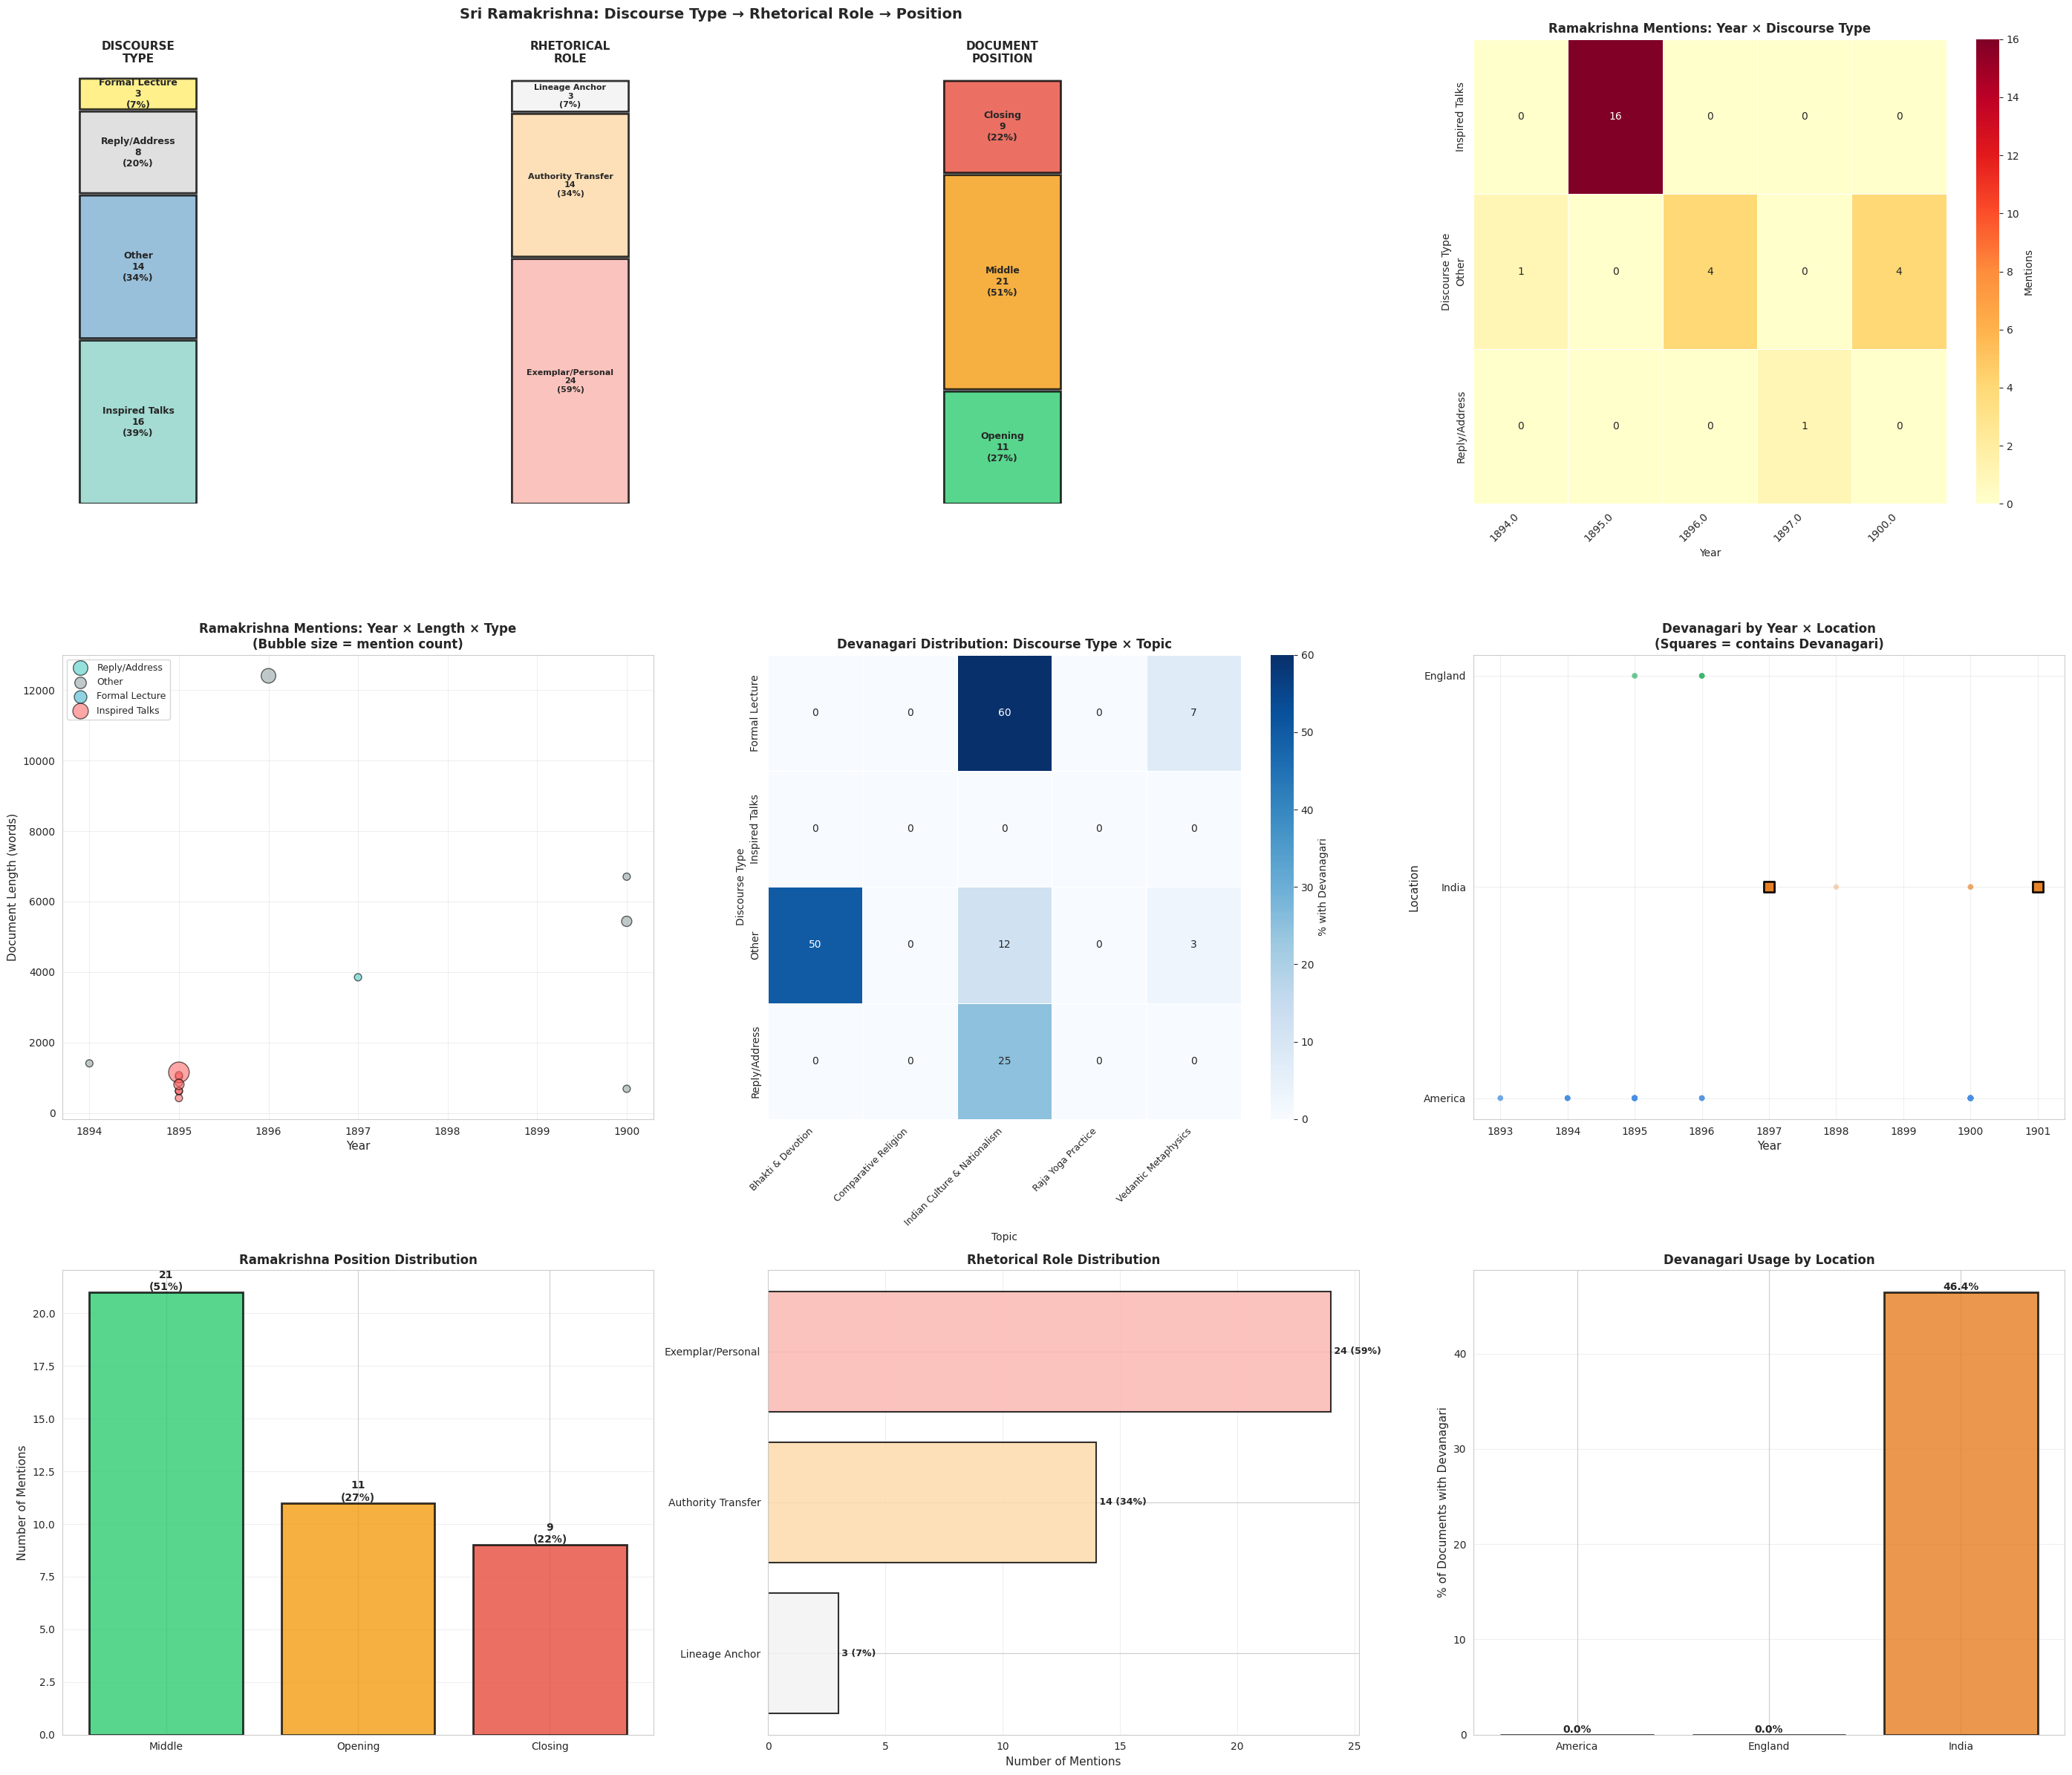


6️⃣ Creating dual Sankey synthesis...


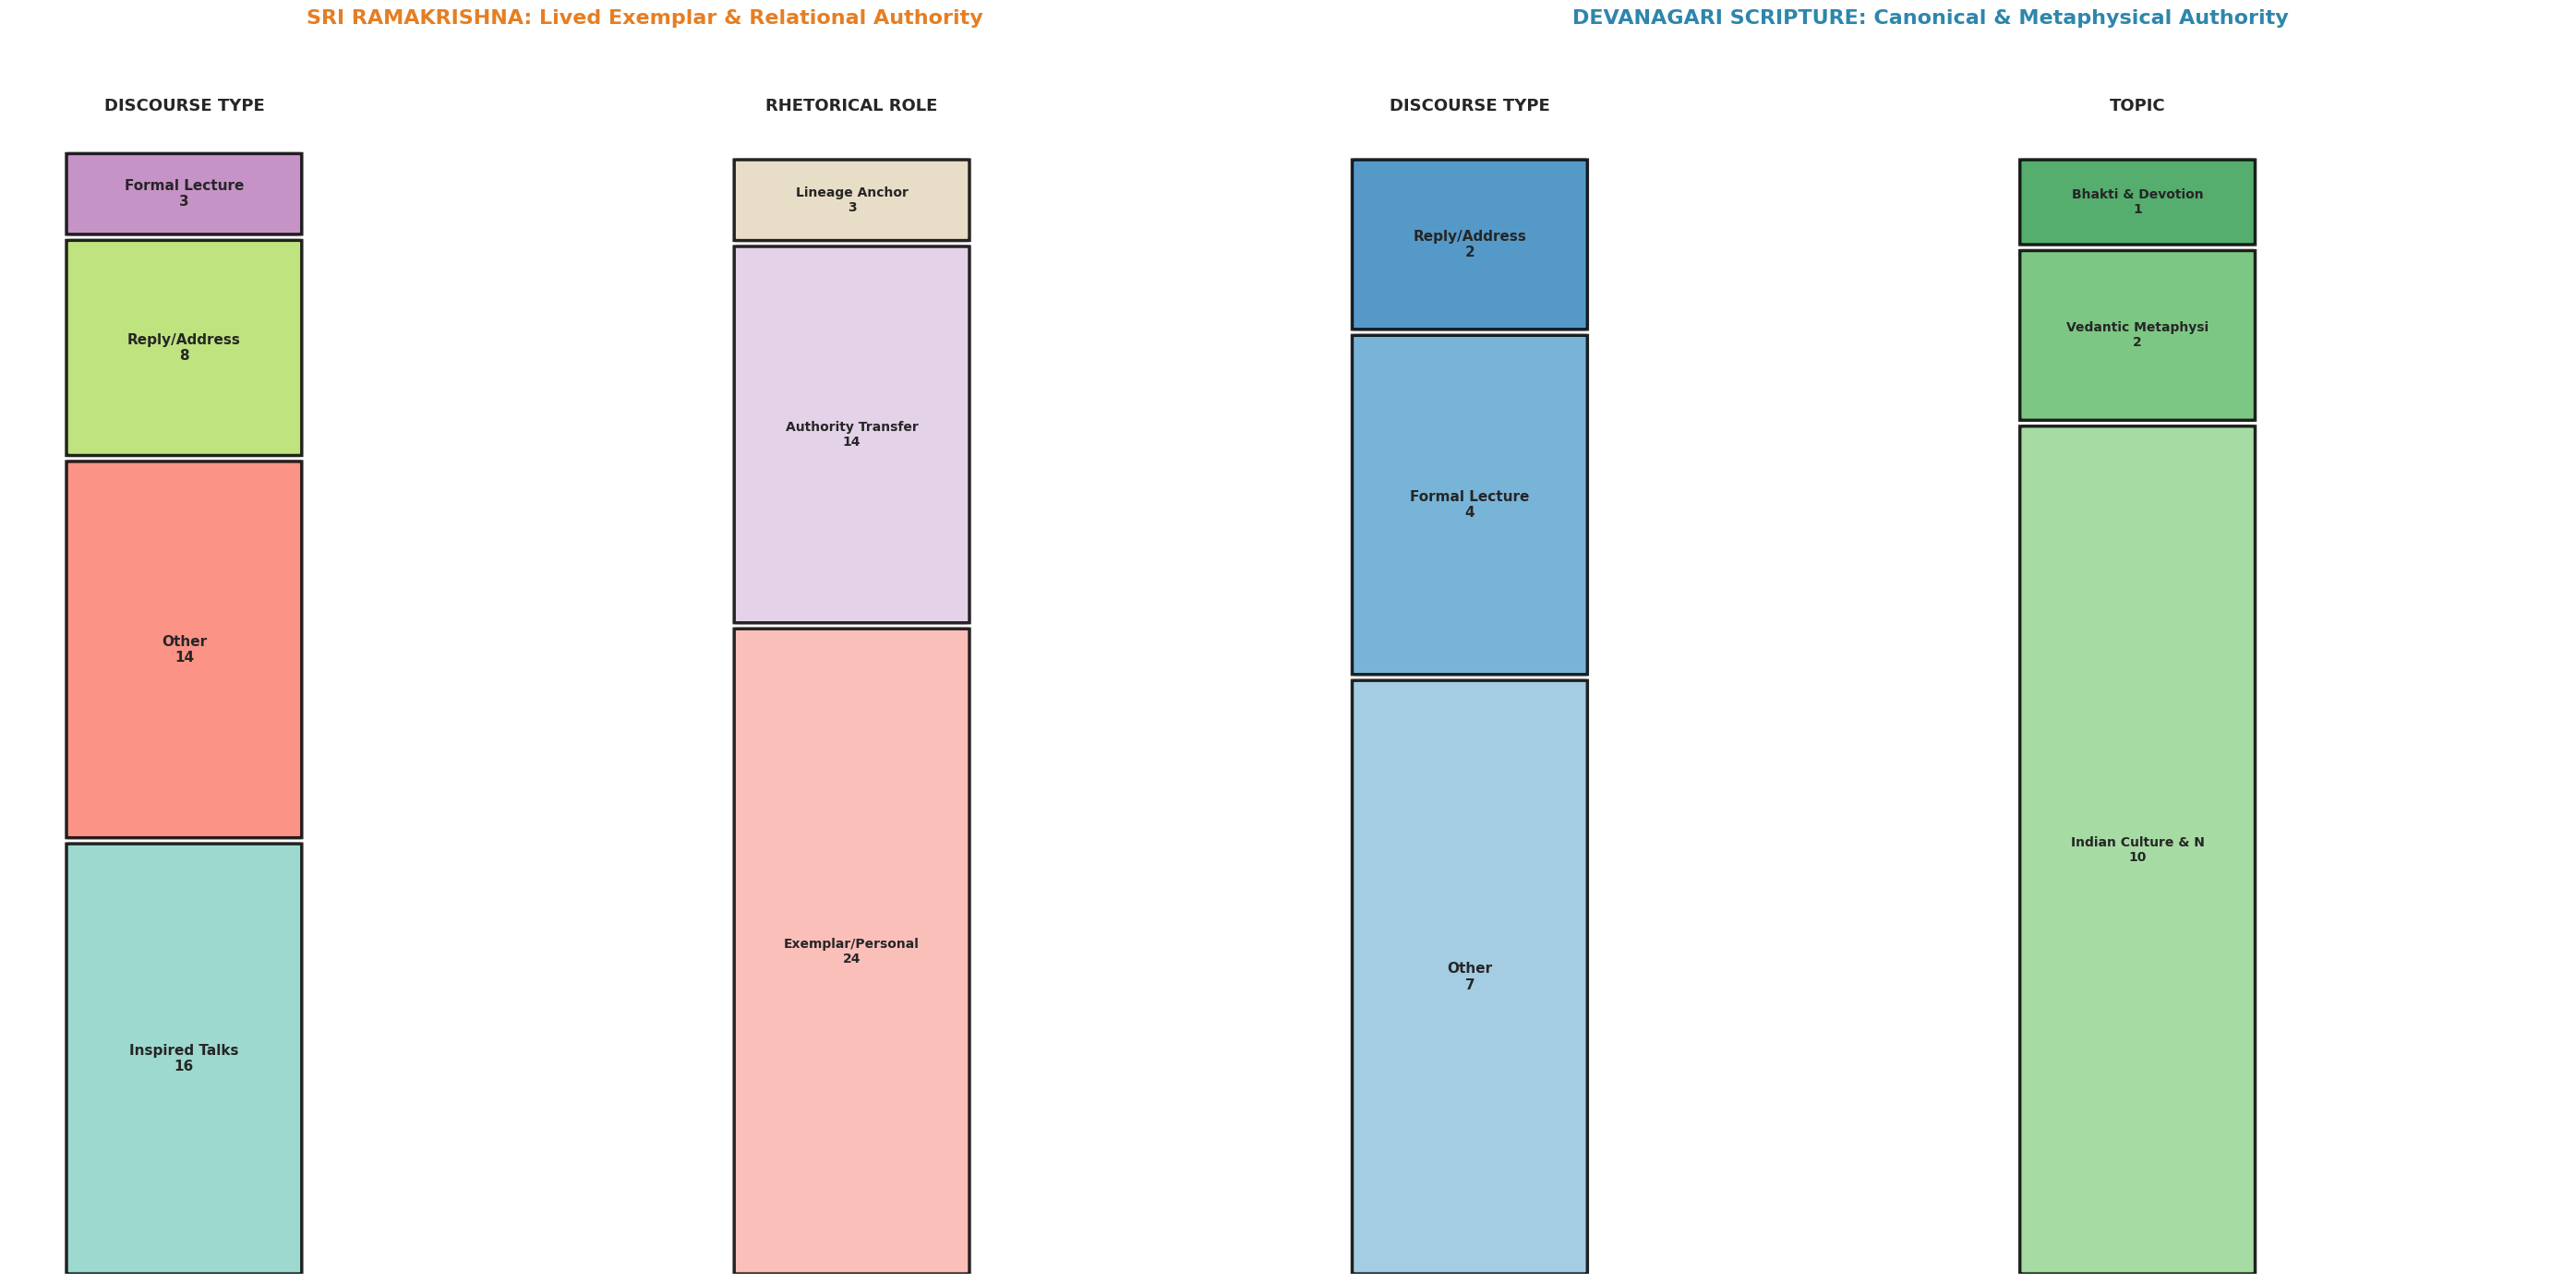


KEY STATISTICS

SRI RAMAKRISHNA:
  Total mentions: 41
  Documents with mentions: 18
  Dominant discourse type: Inspired Talks
  Dominant rhetorical role: Exemplar/Personal
  Dominant position: Middle

DEVANAGARI:
  Documents with Devanagari: 13
  Percentage: 7.3%
  Dominant location: India
  Dominant topic: Indian Culture & Nationalism

✓ PUBLICATION-QUALITY VISUALIZATIONS COMPLETE


In [52]:
# ============================================================================
# PUBLICATION-QUALITY VISUALIZATIONS: SRI RAMAKRISHNA & DEVANAGARI
# ============================================================================

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as mpatches
from matplotlib.sankey import Sankey

print("="*80)
print("GENERATING PUBLICATION-QUALITY VISUALIZATIONS")
print("="*80)

# ============================================================================
# DATA PREPARATION
# ============================================================================

print("\nPreparing data...")

# Ensure Ramakrishna mentions are detected (strict patterns)
import re

strict_patterns = [
    r'\bramakrishna\b',
    r'\bsri ramakrishna\b',
    r'\bshri ramakrishna\b',
    r'\bramakrishna paramahamsa\b',
    r'\bramakrishna paramhansa\b'
]

def detect_ramakrishna_positions(text):
    """Detect Ramakrishna mentions with positions"""
    if pd.isna(text):
        return []

    words = word_tokenize(text)
    words_lower = [w.lower() for w in words]
    total_words = len(words)

    positions = []
    i = 0

    while i < len(words_lower):
        matched = False
        match_length = 1

        # Check patterns
        if words_lower[i] == 'ramakrishna':
            matched = True
            match_length = 1
        elif i < len(words_lower) - 1:
            two_word = f"{words_lower[i]} {words_lower[i+1]}"
            if two_word in ['sri ramakrishna', 'shri ramakrishna']:
                matched = True
                match_length = 2
        elif i < len(words_lower) - 2:
            three_word = f"{words_lower[i]} {words_lower[i+1]} {words_lower[i+2]}"
            if three_word in ['ramakrishna paramahamsa', 'ramakrishna paramhansa']:
                matched = True
                match_length = 3

        if matched:
            normalized_pos = i / max(total_words, 1)
            positions.append(normalized_pos)
            i += match_length
        else:
            i += 1

    return positions

# Detect Devanagari
def contains_devanagari(text):
    if pd.isna(text):
        return False
    return bool(re.search(r'[\u0900-\u097F]', text))

# Apply detection
df_public['ramakrishna_positions'] = df_public['plaintext_clean'].apply(detect_ramakrishna_positions)
df_public['mentions_ramakrishna'] = df_public['ramakrishna_positions'].apply(lambda x: len(x) > 0)
df_public['ramakrishna_count'] = df_public['ramakrishna_positions'].apply(len)
df_public['contains_devanagari'] = df_public['plaintext_clean'].apply(contains_devanagari)

# Infer discourse types
def infer_discourse_type(title):
    if pd.isna(title):
        return 'Other'
    title_lower = title.lower()

    if 'inspired talks' in title_lower or 'inspired talk' in title_lower:
        return 'Inspired Talks'
    if any(word in title_lower for word in ['reply', 'response', 'address', 'welcome']):
        return 'Reply/Address'
    if any(word in title_lower for word in ['lecture', 'paper', 'discourse', 'vedanta', 'yoga']):
        return 'Formal Lecture'
    return 'Other'

df_public['discourse_type'] = df_public['Name'].apply(infer_discourse_type)

# Infer rhetorical roles (simple heuristic based on context)
def infer_rhetorical_role(title, text, discourse_type):
    """Simple heuristic for rhetorical role"""
    if pd.isna(text):
        return 'Unknown'

    text_sample = text[:2000].lower()

    if 'inspired talks' in discourse_type.lower():
        return 'Exemplar/Personal'
    elif any(word in text_sample for word in ['taught', 'said', 'told', 'teaching']):
        return 'Authority Transfer'
    elif any(word in text_sample for word in ['life', 'great', 'saint', 'holy']):
        return 'Exemplar/Personal'
    elif any(word in text_sample for word in ['tradition', 'india', 'vedanta']):
        return 'Lineage Anchor'
    else:
        return 'Narrative'

# Position binning
def bin_positions(positions):
    """Bin positions into Opening/Middle/Closing"""
    if not positions:
        return []

    binned = []
    for pos in positions:
        if pos < 0.25:
            binned.append('Opening')
        elif pos < 0.75:
            binned.append('Middle')
        else:
            binned.append('Closing')
    return binned

df_public['position_bins'] = df_public['ramakrishna_positions'].apply(bin_positions)

# Create detailed rows for each mention
mention_rows = []
for idx, row in df_public[df_public['mentions_ramakrishna']].iterrows():
    rhetorical_role = infer_rhetorical_role(row['Name'], row['plaintext_clean'], row['discourse_type'])

    for pos_bin in row['position_bins']:
        mention_rows.append({
            'discourse_type': row['discourse_type'],
            'rhetorical_role': rhetorical_role,
            'position': pos_bin,
            'year': row['year'],
            'location': row['main_location'],
            'topic': row.get('topic_name', 'Unknown'),
            'word_count': row['word_count_clean']
        })

mentions_df = pd.DataFrame(mention_rows)

print(f"  Ramakrishna mentions: {len(mentions_df)} across {df_public['mentions_ramakrishna'].sum()} documents")
print(f"  Devanagari documents: {df_public['contains_devanagari'].sum()}")

# ============================================================================
# PART A: SRI RAMAKRISHNA STRUCTURAL ROLE VISUALS
# ============================================================================

fig = plt.figure(figsize=(28, 24))

# 1️⃣ SANKEY/ALLUVIAL DIAGRAM
print("\n1️⃣ Creating Sankey diagram...")

ax1 = plt.subplot(3, 3, (1, 2))
ax1.set_xlim(0, 3)
ax1.set_ylim(0, 100)
ax1.axis('off')

# Prepare flow data
flow_data = mentions_df.groupby(['discourse_type', 'rhetorical_role', 'position']).size().reset_index(name='count')

# Column 1: Discourse Type
dtype_counts = mentions_df['discourse_type'].value_counts()
y_pos = 0
dtype_positions = {}
colors_dtype = plt.cm.Set3(np.linspace(0, 1, len(dtype_counts)))

for i, (dtype, count) in enumerate(dtype_counts.items()):
    height = (count / len(mentions_df)) * 90

    rect = FancyBboxPatch((0.05, y_pos), 0.25, height,
                          boxstyle="round,pad=0.01",
                          facecolor=colors_dtype[i], edgecolor='black',
                          linewidth=2, alpha=0.8)
    ax1.add_patch(rect)

    pct = (count / len(mentions_df)) * 100
    ax1.text(0.175, y_pos + height/2, f"{dtype}\n{count}\n({pct:.0f}%)",
            ha='center', va='center', fontsize=9, fontweight='bold')

    dtype_positions[dtype] = (y_pos, y_pos + height)
    y_pos += height + 0.5

# Column 2: Rhetorical Role
role_counts = mentions_df['rhetorical_role'].value_counts()
y_pos = 0
role_positions = {}
colors_role = plt.cm.Pastel1(np.linspace(0, 1, len(role_counts)))

for i, (role, count) in enumerate(role_counts.items()):
    height = (count / len(mentions_df)) * 90

    rect = FancyBboxPatch((1.05, y_pos), 0.25, height,
                          boxstyle="round,pad=0.01",
                          facecolor=colors_role[i], edgecolor='black',
                          linewidth=2, alpha=0.8)
    ax1.add_patch(rect)

    pct = (count / len(mentions_df)) * 100
    ax1.text(1.175, y_pos + height/2, f"{role[:20]}\n{count}\n({pct:.0f}%)",
            ha='center', va='center', fontsize=8, fontweight='bold')

    role_positions[role] = (y_pos, y_pos + height)
    y_pos += height + 0.5

# Column 3: Position
pos_order = ['Opening', 'Middle', 'Closing']
pos_counts = mentions_df['position'].value_counts()
y_pos = 0
pos_positions = {}
colors_pos = ['#2ecc71', '#f39c12', '#e74c3c']

for i, pos_label in enumerate(pos_order):
    if pos_label in pos_counts.index:
        count = pos_counts[pos_label]
        height = (count / len(mentions_df)) * 90

        rect = FancyBboxPatch((2.05, y_pos), 0.25, height,
                              boxstyle="round,pad=0.01",
                              facecolor=colors_pos[i], edgecolor='black',
                              linewidth=2, alpha=0.8)
        ax1.add_patch(rect)

        pct = (count / len(mentions_df)) * 100
        ax1.text(2.175, y_pos + height/2, f"{pos_label}\n{count}\n({pct:.0f}%)",
                ha='center', va='center', fontsize=9, fontweight='bold')

        pos_positions[pos_label] = (y_pos, y_pos + height)
        y_pos += height + 0.5

# Labels
ax1.text(0.175, 95, 'DISCOURSE\nTYPE', ha='center', fontsize=11, fontweight='bold')
ax1.text(1.175, 95, 'RHETORICAL\nROLE', ha='center', fontsize=11, fontweight='bold')
ax1.text(2.175, 95, 'DOCUMENT\nPOSITION', ha='center', fontsize=11, fontweight='bold')

ax1.set_title('Sri Ramakrishna: Discourse Type → Rhetorical Role → Position',
             fontsize=14, fontweight='bold', pad=20)

# 2️⃣ TEMPORAL HEATMAP
print("\n2️⃣ Creating temporal heatmap...")

ax2 = plt.subplot(3, 3, 3)

# Prepare data
mentions_by_year_type = df_public[df_public['mentions_ramakrishna']].groupby(
    ['year', 'discourse_type']
)['ramakrishna_count'].sum().reset_index()

heatmap_data = mentions_by_year_type.pivot_table(
    index='discourse_type',
    columns='year',
    values='ramakrishna_count',
    fill_value=0
)

sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='g',
           cbar_kws={'label': 'Mentions'}, ax=ax2, linewidths=0.5)
ax2.set_title('Ramakrishna Mentions: Year × Discourse Type', fontweight='bold', fontsize=12)
ax2.set_xlabel('Year')
ax2.set_ylabel('Discourse Type')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# 3️⃣ SCATTER/BUBBLE PLOT
print("\n3️⃣ Creating scatter/bubble plot...")

ax3 = plt.subplot(3, 3, 4)

rk_docs = df_public[df_public['mentions_ramakrishna']]
dtype_colors = {'Inspired Talks': '#FF6B6B', 'Reply/Address': '#4ECDC4',
                'Formal Lecture': '#45B7D1', 'Other': '#95A5A6'}

for dtype in rk_docs['discourse_type'].unique():
    dtype_data = rk_docs[rk_docs['discourse_type']==dtype]
    ax3.scatter(dtype_data['year'], dtype_data['word_count_clean'],
               s=dtype_data['ramakrishna_count']*50,
               c=dtype_colors.get(dtype, '#95A5A6'),
               alpha=0.6, edgecolors='black', linewidth=1,
               label=dtype)

ax3.set_xlabel('Year', fontsize=11)
ax3.set_ylabel('Document Length (words)', fontsize=11)
ax3.set_title('Ramakrishna Mentions: Year × Length × Type\n(Bubble size = mention count)',
             fontweight='bold', fontsize=12)
ax3.legend(loc='upper left', fontsize=9)
ax3.grid(alpha=0.3)

# ============================================================================
# PART B: DEVANAGARI (SANSKRIT) CANONICAL AUTHORITY VISUALS
# ============================================================================

# 4️⃣ DEVANAGARI DISTRIBUTION HEATMAP
print("\n4️⃣ Creating Devanagari distribution heatmap...")

ax4 = plt.subplot(3, 3, 5)

# Prepare data
if 'topic_name' in df_public.columns:
    devanagari_by_topic_type = df_public.groupby(['topic_name', 'discourse_type']).agg({
        'contains_devanagari': ['sum', 'count']
    })
    devanagari_by_topic_type.columns = ['dev_count', 'total']
    devanagari_by_topic_type['pct'] = (devanagari_by_topic_type['dev_count'] /
                                        devanagari_by_topic_type['total'] * 100)
    devanagari_by_topic_type = devanagari_by_topic_type.reset_index()

    heatmap_dev = devanagari_by_topic_type.pivot_table(
        index='discourse_type',
        columns='topic_name',
        values='pct',
        fill_value=0
    )

    sns.heatmap(heatmap_dev, cmap='Blues', annot=True, fmt='.0f',
               cbar_kws={'label': '% with Devanagari'}, ax=ax4, linewidths=0.5)
    ax4.set_title('Devanagari Distribution: Discourse Type × Topic',
                 fontweight='bold', fontsize=12)
    ax4.set_xlabel('Topic')
    ax4.set_ylabel('Discourse Type')
    plt.setp(ax4.get_xticklabels(), rotation=45, ha='right', fontsize=9)

# 5️⃣ GEOGRAPHIC SCATTER/FACET PLOT
print("\n5️⃣ Creating geographic scatter plot...")

ax5 = plt.subplot(3, 3, 6)

locations = ['America', 'India', 'England']
loc_colors = {'America': '#4A90E2', 'India': '#E67E22', 'England': '#27AE60'}

for loc in locations:
    loc_data = df_public[df_public['main_location']==loc]

    # Documents with Devanagari
    dev_data = loc_data[loc_data['contains_devanagari']]
    if len(dev_data) > 0:
        ax5.scatter(dev_data['year'], [loc]*len(dev_data),
                   s=100, marker='s', c=loc_colors[loc],
                   edgecolors='black', linewidth=2, alpha=0.8,
                   label=f'{loc} (Dev)')

    # Documents without Devanagari
    no_dev_data = loc_data[~loc_data['contains_devanagari']]
    if len(no_dev_data) > 0:
        ax5.scatter(no_dev_data['year'], [loc]*len(no_dev_data),
                   s=30, marker='o', c=loc_colors[loc],
                   alpha=0.3, edgecolors='none')

ax5.set_xlabel('Year', fontsize=11)
ax5.set_ylabel('Location', fontsize=11)
ax5.set_title('Devanagari by Year × Location\n(Squares = contains Devanagari)',
             fontweight='bold', fontsize=12)
ax5.grid(alpha=0.3)

# 6️⃣ ADDITIONAL: Position distribution
ax6 = plt.subplot(3, 3, 7)

if len(mentions_df) > 0:
    pos_counts = mentions_df['position'].value_counts()
    colors = ['#2ecc71', '#f39c12', '#e74c3c']
    bars = ax6.bar(pos_counts.index, pos_counts.values,
                   color=colors[:len(pos_counts)], alpha=0.8, edgecolor='black', linewidth=2)

    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({height/len(mentions_df)*100:.0f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax6.set_ylabel('Number of Mentions', fontsize=11)
    ax6.set_title('Ramakrishna Position Distribution', fontweight='bold', fontsize=12)
    ax6.grid(axis='y', alpha=0.3)

# 7️⃣ Rhetorical role distribution
ax7 = plt.subplot(3, 3, 8)

if len(mentions_df) > 0:
    role_counts = mentions_df['rhetorical_role'].value_counts()
    ax7.barh(range(len(role_counts)), role_counts.values,
            color=plt.cm.Pastel1(np.linspace(0, 1, len(role_counts))),
            alpha=0.8, edgecolor='black', linewidth=1.5)
    ax7.set_yticks(range(len(role_counts)))
    ax7.set_yticklabels(role_counts.index, fontsize=10)
    ax7.set_xlabel('Number of Mentions', fontsize=11)
    ax7.set_title('Rhetorical Role Distribution', fontweight='bold', fontsize=12)
    ax7.invert_yaxis()
    ax7.grid(axis='x', alpha=0.3)

    for i, val in enumerate(role_counts.values):
        ax7.text(val, i, f' {val} ({val/len(mentions_df)*100:.0f}%)',
                va='center', fontsize=9, fontweight='bold')

# 8️⃣ Devanagari by location
ax8 = plt.subplot(3, 3, 9)

dev_by_loc = df_public.groupby('main_location')['contains_devanagari'].agg(['sum', 'count'])
dev_by_loc['pct'] = dev_by_loc['sum'] / dev_by_loc['count'] * 100

bars = ax8.bar(dev_by_loc.index, dev_by_loc['pct'],
              color=[loc_colors.get(loc, '#95A5A6') for loc in dev_by_loc.index],
              alpha=0.8, edgecolor='black', linewidth=2)

for bar in bars:
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax8.set_ylabel('% of Documents with Devanagari', fontsize=11)
ax8.set_title('Devanagari Usage by Location', fontweight='bold', fontsize=12)
ax8.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# PART C: CONTRASTIVE SYNTHESIS - DUAL SANKEY
# ============================================================================

print("\n6️⃣ Creating dual Sankey synthesis...")

fig2 = plt.figure(figsize=(28, 14))

# LEFT: Sri Ramakrishna flow
ax_left = plt.subplot(1, 2, 1)
ax_left.set_xlim(0, 2)
ax_left.set_ylim(0, 100)
ax_left.axis('off')

# Flow: Discourse Type → Rhetorical Role
flow_rk = mentions_df.groupby(['discourse_type', 'rhetorical_role']).size().reset_index(name='count')

# Column 1: Discourse types
dtype_counts_rk = mentions_df['discourse_type'].value_counts()
y_pos = 0
dtype_pos_rk = {}

for i, (dtype, count) in enumerate(dtype_counts_rk.items()):
    height = (count / len(mentions_df)) * 90

    rect = FancyBboxPatch((0.1, y_pos), 0.35, height,
                          boxstyle="round,pad=0.01",
                          facecolor=plt.cm.Set3(i/len(dtype_counts_rk)),
                          edgecolor='black', linewidth=2.5, alpha=0.85)
    ax_left.add_patch(rect)

    ax_left.text(0.275, y_pos + height/2, f"{dtype}\n{count}",
                ha='center', va='center', fontsize=11, fontweight='bold')

    dtype_pos_rk[dtype] = (y_pos, y_pos + height)
    y_pos += height + 0.5

# Column 2: Rhetorical roles
role_counts_rk = mentions_df['rhetorical_role'].value_counts()
y_pos = 0
role_pos_rk = {}

for i, (role, count) in enumerate(role_counts_rk.items()):
    height = (count / len(mentions_df)) * 90

    rect = FancyBboxPatch((1.15, y_pos), 0.35, height,
                          boxstyle="round,pad=0.01",
                          facecolor=plt.cm.Pastel1(i/len(role_counts_rk)),
                          edgecolor='black', linewidth=2.5, alpha=0.85)
    ax_left.add_patch(rect)

    ax_left.text(1.325, y_pos + height/2, f"{role[:18]}\n{count}",
                ha='center', va='center', fontsize=10, fontweight='bold')

    role_pos_rk[role] = (y_pos, y_pos + height)
    y_pos += height + 0.5

ax_left.text(0.275, 95, 'DISCOURSE TYPE', ha='center', fontsize=13, fontweight='bold')
ax_left.text(1.325, 95, 'RHETORICAL ROLE', ha='center', fontsize=13, fontweight='bold')
ax_left.set_title('SRI RAMAKRISHNA: Lived Exemplar & Relational Authority',
                 fontsize=16, fontweight='bold', pad=20, color='#E67E22')

# RIGHT: Devanagari flow
ax_right = plt.subplot(1, 2, 2)
ax_right.set_xlim(0, 2)
ax_right.set_ylim(0, 100)
ax_right.axis('off')

# Prepare Devanagari flow data
dev_docs = df_public[df_public['contains_devanagari']]

if len(dev_docs) > 0 and 'topic_name' in dev_docs.columns:
    # Column 1: Discourse types
    dtype_counts_dev = dev_docs['discourse_type'].value_counts()
    y_pos = 0
    dtype_pos_dev = {}

    for i, (dtype, count) in enumerate(dtype_counts_dev.items()):
        height = (count / len(dev_docs)) * 90

        rect = FancyBboxPatch((0.1, y_pos), 0.35, height,
                              boxstyle="round,pad=0.01",
                              facecolor=plt.cm.Blues(0.4 + i/len(dtype_counts_dev)*0.4),
                              edgecolor='black', linewidth=2.5, alpha=0.85)
        ax_right.add_patch(rect)

        ax_right.text(0.275, y_pos + height/2, f"{dtype}\n{count}",
                     ha='center', va='center', fontsize=11, fontweight='bold')

        dtype_pos_dev[dtype] = (y_pos, y_pos + height)
        y_pos += height + 0.5

    # Column 2: Topics
    topic_counts_dev = dev_docs['topic_name'].value_counts()
    y_pos = 0
    topic_pos_dev = {}

    for i, (topic, count) in enumerate(topic_counts_dev.items()):
        height = (count / len(dev_docs)) * 90

        rect = FancyBboxPatch((1.15, y_pos), 0.35, height,
                              boxstyle="round,pad=0.01",
                              facecolor=plt.cm.Greens(0.4 + i/len(topic_counts_dev)*0.4),
                              edgecolor='black', linewidth=2.5, alpha=0.85)
        ax_right.add_patch(rect)

        ax_right.text(1.325, y_pos + height/2, f"{topic[:18]}\n{count}",
                     ha='center', va='center', fontsize=10, fontweight='bold')

        topic_pos_dev[topic] = (y_pos, y_pos + height)
        y_pos += height + 0.5

    ax_right.text(0.275, 95, 'DISCOURSE TYPE', ha='center', fontsize=13, fontweight='bold')
    ax_right.text(1.325, 95, 'TOPIC', ha='center', fontsize=13, fontweight='bold')

ax_right.set_title('DEVANAGARI SCRIPTURE: Canonical & Metaphysical Authority',
                  fontsize=16, fontweight='bold', pad=20, color='#2E86AB')

plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("KEY STATISTICS")
print("="*80)

print("\nSRI RAMAKRISHNA:")
print(f"  Total mentions: {len(mentions_df)}")
print(f"  Documents with mentions: {df_public['mentions_ramakrishna'].sum()}")
print(f"  Dominant discourse type: {mentions_df['discourse_type'].mode()[0]}")
print(f"  Dominant rhetorical role: {mentions_df['rhetorical_role'].mode()[0]}")
print(f"  Dominant position: {mentions_df['position'].mode()[0]}")

print("\nDEVANAGARI:")
print(f"  Documents with Devanagari: {df_public['contains_devanagari'].sum()}")
print(f"  Percentage: {df_public['contains_devanagari'].sum()/len(df_public)*100:.1f}%")
if len(dev_docs) > 0:
    print(f"  Dominant location: {dev_docs['main_location'].mode()[0]}")
    if 'topic_name' in dev_docs.columns:
        print(f"  Dominant topic: {dev_docs['topic_name'].mode()[0]}")

print("\n" + "="*80)
print("✓ PUBLICATION-QUALITY VISUALIZATIONS COMPLETE")
print("="*80)